# ABCD Study Colab (Primary Target)

### Loading Libraries and Data

1.   Ensure you are on a minimum T4 GPU Runtime (Recommended for this runtime is an A100 GPU)
2.   Ensure that you also have the .csv file of our data imported to the **current** runtime named 'CLEAN_ABCD_5.1_panel_20241022.csv'


In [ ]:
#@markdown Run this section to install required libraries.


!pip install pygam
!pip install shap
!pip install smogn
!pip install imbalanced-learn
!pip install catboost
!pip install mapie
!pip install optuna
!pip install optuna-integration[catboost]
!pip install tabpfn
!pip install imblearn
!pip install scikit-learn
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cache

"!git clone https://github.com/priorlabs/tabpfn-extensions.git\n!pip uninstall tabpfn-extensions -y\n!pip install -e tabpfn-extensions\n\nimport sys\nsys.path.append('/content/tabpfn-extensions/src/')\n\n# Import the required functions directly from the shap module\nfrom tabpfn_extensions.interpretability.shap import get_shap_values, plot_shap\n"

### Variable Loading & Data Preprocessing

In [ ]:
#@markdown Feature-Set Category at each Timepoint Loading for ML
###########################################

binary_or_categorical_outcome_variables = [
  "dep_onset_rci_1.96",
  "dep_onset_rci_2.3",
  "dep_remission_rci_1.96",
  "dep_remission_rci_2.3",
  "dep_increase_2sd",
  "dep_increase_1.5sd",
  "dep_decrease_2sd",
  "dep_decrease_1.5sd",
  "top_10_depression",
  "top_5_depression",
  "latent_class_depression"
]

continuous_outcome_variables = [
    "depress_D_p",
    "depress_D_p_rev"
]

#######################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def save_plot_2(coefs, name, metric, metric_score, tp):
  # Create the plot
  plt.figure(figsize=(8, 6))
  sns.barplot(x=coefs.values, y=coefs.index, palette="gray", hue=coefs.index, legend=False)
  plt.title(f"{name} ({metric} = {metric_score:.4f}, t = {tp})")
  plt.xlabel("Importance")
  plt.ylabel("Feature")
  plt.tight_layout()

  plt.yticks(fontsize=7)

  # Save the plot
  filename = f"dep_{name}.png"
  plt.savefig(filename, dpi=300)
  plt.close()


##############################################################################
# New Variables #

# categories:


# variables_for_each_time_point

variables_for_each_time_point = {
    0: {  # T0 Variables
        'Cognitive Task Outcomes': ['tb_picvocab', 'tb_flanker', 'tb_list', 'tb_cardsort', 'tb_pattern', 'tb_picture',
            'tb_reading', 'tb_fluid', 'tb_cryst', 'tb_total', 'lmt_accuracy', 'lmt_efficiency', 'nb_correct_nt',
            'nb_correct_mrt', 'nb_correct_nt_2back', 'nb_correct_mrt_2back', 'nb_correct_nt_pos', 'nb_correct_mrt_pos',
            'nb_correct_nt_neutral', 'nb_correct_mrt_neutral', 'nb_correct_nt_neg', 'nb_correct_mrt_neg',
            'nb2_accuracy_pos', 'nb2_resp_bias_pos', 'nb2_D_prime_pos', 'nb2_accuracy_neg', 'nb2_resp_bias_neg',
            'nb2_D_prime_neg', 'sst_ssrt_mean_est', 'sst_ssrt_int_est', 'sst_acceptable_performance',
            'mid_acceptable_performance', 'mid_total_payout', 'cct', 'mr_total', 'mr_matrix', 'ravlt_s_total',
            'ravlt_s_repitition', 'ravlt_s_intrusions', 'ravlt_l_total', 'ravlt_l_repitition', 'ravlt_l_intrusions', 'sst_theta0', 'sst_theta1', 'sst_mu', 'sst_aS', 'sst_dS', 'sst_gamma0', 'sst_gamma1', 'sst_dG', 'sst_aG1', 'sst_aG2',
            'sst_kappa0', 'sst_xM', 'sst_sM', 'sst_bG', 'sst_pp', 'sst_factor1', 'sst_factor2', 'sst_factor3', 'sst_mean_ssrt',
            'sst_median_ssrt', 'sst_mean_PDR', 'sst_median_PDR', 'sst_mean_SD', 'sst_median_SD', 'sst_mean_SDr', 'sst_median_SDr',
            'sst_mean_PDRg', 'sst_median_PDRg', 'sst_mean_betaS', 'sst_median_betaS', 'sst_mean_bS2', 'sst_median_bS2',
            'sst_mean_absdelta', 'sst_median_absdelta', 'sst_pdrV', 'sst_pdrSD', 'sst_pdrCV', 'sst_sdRV', 'sst_sdSD', 'sst_sdCV',
            'sst_sdrRV', 'sst_sdrSD', 'sst_sdrCV', 'sst_pdrgV', 'sst_pdrgSD', 'sst_pdrgCV', 'sst_betasV', 'sst_betasSD',
            'sst_betasCV', 'sst_absdeltaRV', 'sst_absdeltaSD', 'sst_absdeltaCV', 'sst_bs2V', 'sst_bs2SD', 'sst_bs2CV'],

        'Other Personality Features': ['up_negative_urgency_ss_k', 'up_lackofplanning_ss_k', 'up_sensationseeking_ss_k',
            'up_positiveurgency_ss_k', 'up_lackperseverance_ss_k', 'bis_behav_inhibition_ss_k',
            'bis_reward_responsive_ss_k', 'bis_drive_ss_k', 'bis_funseeking_ss_k', 'loquacious_p', 'bragadocious_p',
            'easily_jealous_p', 'wishes_other_sex_p', 'easily_embarrassed_p', 'secretive_p', 'perfectionist_p',
            'sex_orient_y'],

        'Medical/Somatic Problems': ['body_aches_p', 'frequent_headaches_p', 'nausea_p', 'eye_problems_p',
            'skin_problems_p', 'frequent_stomachaches_p', 'vomiting_p', 'constipated_p', 'bad_toilet_habits_p',
            'wets_bed_p'],

        'Sleep Problems': ['difficulty_goingtosleep_p', 'difficulty_wakingup_p', 'nightmares_p'],

        'Physical Activity/Features': ['height', 'weight', 'waist', 'saliva_DHEA', 'saliva_testosterone', 'puberty_k',
            'sex', 'birth_weight_p'],

        'Technology Use': ['screentime_weekday_ss_k', 'screentime_weekend_ss_k'],

        'Social Relationship Quality': ['not_liked_p', 'doesnt_get_along_p', 'prosocial_ss_p', 'close_boy_friends_k',
            'close_girl_friends_k', 'prosocial_ss_k'],

        'Family Dynamics & Parenting': ['fam_fight_often_k', 'fam_no_open_anger_k', 'fam_throw_things_k',
            'fam_no_lose_temps_k', 'fam_criticize_often_k', 'fam_hit_each_other_k', 'fam_keep_peace_k',
            'fam_try_one_up_k', 'fam_no_raise_voices_k', 'family_peaceful_p', 'family_lose_temper_rare_p',
            'family_believe_not_raise_voice_p', 'frequent_family_conflict_p', 'family_conflict_ss_p',
            'y_acceptance_ss_p_crpbi', 'y_acceptance_ss_caregiver_crpbi', 'family_conflict_ss_k',
            'parent_monitoring_ss_k', 'parent_age', 'sex_P', 'num_brothers_p', 'num_sisters_p',
            'religious_service_frequency', 'relig_importance',  'parent_family_responsibilities_p'],

        'Parent Anxiety and Fear-Related Issues': [
            'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
            'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
            'parent_relationship_concerns_p'
        ],

        'Parent Mood Issues': [
            'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p', 'parent_paranoid_p',
            'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
            'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p',
            'parent_enjoys_little_p', 'parent_sudden_mood_changes_p', 'parent_suicidal_thoughts_p', 'parent_happy_person_p'
        ],

        'Parent Impulsivity and Behavior Regulation': [
            'parent_impulsive_p', 'parent_risky_decisions_p', 'parent_drives_too_fast_p', 'parent_tardy_often_p',
            'parent_money_management_trouble_p', 'parent_priority_trouble_p', 'parent_behavior_changeable_p',
            'parent_hot_temper_p', 'parent_attention_seeking_p', 'parent_destroys_own_things_p',
            'parent_destroys_others_things_p', 'parent_doesnt_finish_tasks_p', 'parent_strange_behavior_p',
            'parent_illegal_behavior_p', 'parent_self_harm_p', 'parent_doesnt_eat_well_p'
        ],

        'Parent Interpersonal Relationships and Social Functioning': [
            'parent_bad_relationships_p', 'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p',
            'parent_friendship_trouble_p', 'parent_prefers_older_people_p', 'parent_associates_with_trouble_p',
            'parent_bad_opposite_sex_relationship_p', 'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p',
            'parent_teases_others_p', 'parent_stands_up_rights_p'
        ],

        'Parent Cognitive and Attention Issues': [
            'parent_forgetful_p', 'parent_concentration_trouble_p', 'parent_confused_p', 'parent_planning_trouble_p',
            'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p',
            'parent_repeats_acts_p', 'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p',
            'parent_decision_trouble_p', 'parent_priority_trouble_p'
        ],

        'Parent Personality': [
            'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p', 'parent_stubborn_irritable_p',
            'parent_clumsy_p', 'parent_strange_thoughts_p', 'parent_self_conscious_p', 'parent_uses_opportunities_p',
            'parent_louder_than_others_p', 'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p',
            'parent_easily_bored_p', 'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
            'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
            'parent_high_sleep_duration_p'
        ],

        'Parent Other': [
            'parent_physical_attacks_p', 'parent_picks_skin_p', 'parent_heart_racing_p', 'parent_numbness_p',
            'parent_sees_things_p', 'parent_hears_voices_p', 'parent_speech_problems_p',
            'parent_opposite_sex_wish_p'
        ],

        'SES & Mobility': ['parent_education', 'parent_income', 'struggle_food_expenses', 'couldnt_afford_phone',
            'couldnt_afford_rent_mortgage', 'evicted', 'gas_electric_oil_turned_off', 'parent_work_absences_p', 'parent_financial_trouble_p', 'parent_fails_to_pay_debts_p'],

        'Residential Characteristics': ['neighborhood_safety_ss_p', 'area_deprivation_idx', 'neighborhood_safe_y',
            'resid_density', 'resid_walkability', 'resid_prox_roads', 'resid_crime_tot', 'resid_crime_violent',
            'resid_crime_drug', 'resid_crime_dui', 'resid_lead_risk_poverty', 'resid_lead_risk_houses_perc',
            'resid_lead_risk', 'resid_no2_avg', 'resid_pm25_avg', 'resid_sexism', 'resid_sex_orient_bias',
            'resid_immigrant_bias', 'resid_racism', 'L_site_id'],

        'School Dynamics': ['getalong_teachers_k', 'feelsafe_at_school_k', 'feels_smart_k', 'enjoys_school_k',
            'grades_important_k', 'school_environment_ss_k', 'school_involvement_ss_k', 'school_disengagement_ss_k',
            'repeated_grade', 'grades_dropped', 'school_detension_suspension', 'finds_schoolboring_k'],

        'Task and Resting State': [
            'pc_SSTmri1', 'pc_SSTmri2', 'pc_SSTmri3', 'pc_SSTmri4', 'pc_SSTmri5', 'pc_SSTmri6', 'pc_SSTmri7', 'pc_SSTmri8',
            'pc_SSTmri9', 'pc_SSTmri10', 'pc_SSTmri11', 'pc_SSTmri12', 'pc_SSTmri13', 'pc_SSTmri14', 'pc_SSTmri15', 'pc_SSTmri16',
            'pc_SSTmri17', 'pc_SSTmri18', 'pc_SSTmri19', 'pc_SSTmri20', 'pc_SSTmri21', 'pc_SSTmri22', 'pc_SSTmri23', 'pc_SSTmri24',
            'pc_SSTmri25', 'pc_SSTmri26', 'pc_SSTmri27', 'pc_SSTmri28', 'pc_SSTmri29', 'pc_SSTmri30', 'pc_SSTmri31', 'pc_SSTmri32',
            'pc_SSTmri33', 'pc_SSTmri34', 'pc_SSTmri35', 'pc_SSTmri36', 'pc_SSTmri37', 'pc_SSTmri38', 'pc_SSTmri39', 'pc_SSTmri40',
            'pc_SSTmri41', 'pc_SSTmri42', 'pc_SSTmri43', 'pc_SSTmri44', 'pc_SSTmri45', 'pc_SSTmri46', 'pc_SSTmri47', 'pc_SSTmri48',
            'pc_SSTmri49', 'pc_SSTmri50', 'pc_SSTmri51', 'pc_SSTmri52', 'pc_SSTmri53', 'pc_SSTmri54', 'pc_SSTmri55', 'pc_SSTmri56',
            'pc_SSTmri57', 'pc_SSTmri58', 'pc_SSTmri59', 'pc_SSTmri60', 'pc_SSTmri61', 'pc_SSTmri62', 'pc_SSTmri63', 'pc_SSTmri64',
            'pc_SSTmri65', 'pc_SSTmri66', 'pc_SSTmri67', 'pc_SSTmri68', 'pc_SSTmri69', 'pc_SSTmri70', 'pc_SSTmri71', 'pc_SSTmri72',
            'pc_SSTmri73', 'pc_SSTmri74', 'pc_SSTmri75', 'pc_nbackmri1', 'pc_nbackmri2', 'pc_nbackmri3', 'pc_nbackmri4', 'pc_nbackmri5',
            'pc_nbackmri6', 'pc_nbackmri7', 'pc_nbackmri8', 'pc_nbackmri9', 'pc_nbackmri10', 'pc_nbackmri11', 'pc_nbackmri12',
            'pc_nbackmri13', 'pc_nbackmri14', 'pc_nbackmri15', 'pc_nbackmri16', 'pc_nbackmri17', 'pc_nbackmri18', 'pc_nbackmri19',
            'pc_nbackmri20', 'pc_nbackmri21', 'pc_nbackmri22', 'pc_nbackmri23', 'pc_nbackmri24', 'pc_nbackmri25', 'pc_nbackmri26',
            'pc_nbackmri27', 'pc_nbackmri28', 'pc_nbackmri29', 'pc_nbackmri30', 'pc_nbackmri31', 'pc_nbackmri32', 'pc_nbackmri33',
            'pc_nbackmri34', 'pc_nbackmri35', 'pc_nbackmri36', 'pc_nbackmri37', 'pc_nbackmri38', 'pc_nbackmri39', 'pc_nbackmri40',
            'pc_nbackmri41', 'pc_nbackmri42', 'pc_nbackmri43', 'pc_nbackmri44', 'pc_nbackmri45', 'pc_nbackmri46', 'pc_nbackmri47',
            'pc_nbackmri48', 'pc_nbackmri49', 'pc_nbackmri50', 'pc_nbackmri51', 'pc_nbackmri52', 'pc_nbackmri53', 'pc_nbackmri54',
            'pc_nbackmri55', 'pc_nbackmri56', 'pc_nbackmri57', 'pc_nbackmri58', 'pc_nbackmri59', 'pc_nbackmri60', 'pc_nbackmri61',
            'pc_nbackmri62', 'pc_nbackmri63', 'pc_nbackmri64', 'pc_nbackmri65', 'pc_nbackmri66', 'pc_nbackmri67', 'pc_nbackmri68',
            'pc_nbackmri69', 'pc_nbackmri70', 'pc_nbackmri71', 'pc_nbackmri72', 'pc_nbackmri73', 'pc_nbackmri74', 'pc_nbackmri75',
            'pc_midfmri1', 'pc_midfmri2', 'pc_midfmri3', 'pc_midfmri4', 'pc_midfmri5', 'pc_midfmri6', 'pc_midfmri7', 'pc_midfmri8',
            'pc_midfmri9', 'pc_midfmri10', 'pc_midfmri11', 'pc_midfmri12', 'pc_midfmri13', 'pc_midfmri14', 'pc_midfmri15',
            'pc_midfmri16', 'pc_midfmri17', 'pc_midfmri18', 'pc_midfmri19', 'pc_midfmri20', 'pc_midfmri21', 'pc_midfmri22',
            'pc_midfmri23', 'pc_midfmri24', 'pc_midfmri25', 'pc_midfmri26', 'pc_midfmri27', 'pc_midfmri28', 'pc_midfmri29',
            'pc_midfmri30', 'pc_midfmri31', 'pc_midfmri32', 'pc_midfmri33', 'pc_midfmri34', 'pc_midfmri35', 'pc_midfmri36',
            'pc_midfmri37', 'pc_midfmri38', 'pc_midfmri39', 'pc_midfmri40', 'pc_midfmri41', 'pc_midfmri42', 'pc_midfmri43',
            'pc_midfmri44', 'pc_midfmri45', 'pc_midfmri46', 'pc_midfmri47', 'pc_midfmri48', 'pc_midfmri49', 'pc_midfmri50',
            'pc_midfmri51', 'pc_midfmri52', 'pc_midfmri53', 'pc_midfmri54', 'pc_midfmri55', 'pc_midfmri56', 'pc_midfmri57',
            'pc_midfmri58', 'pc_midfmri59', 'pc_midfmri60', 'pc_midfmri61', 'pc_midfmri62', 'pc_midfmri63', 'pc_midfmri64',
            'pc_midfmri65', 'pc_midfmri66', 'pc_midfmri67', 'pc_midfmri68', 'pc_midfmri69', 'pc_midfmri70', 'pc_midfmri71',
            'pc_midfmri72', 'pc_midfmri73', 'pc_midfmri74', 'pc_midfmri75',
            'pc_rsFMRI1', 'pc_rsFMRI2', 'pc_rsFMRI3', 'pc_rsFMRI4', 'pc_rsFMRI5', 'pc_rsFMRI6', 'pc_rsFMRI7', 'pc_rsFMRI8',
            'pc_rsFMRI9', 'pc_rsFMRI10', 'pc_rsFMRI11', 'pc_rsFMRI12', 'pc_rsFMRI13', 'pc_rsFMRI14', 'pc_rsFMRI15',
            'pc_rsFMRI16', 'pc_rsFMRI17', 'pc_rsFMRI18', 'pc_rsFMRI19', 'pc_rsFMRI20', 'pc_rsFMRI21', 'pc_rsFMRI22',
            'pc_rsFMRI23', 'pc_rsFMRI24', 'pc_rsFMRI25', 'pc_rsFMRI26', 'pc_rsFMRI27', 'pc_rsFMRI28', 'pc_rsFMRI29',
            'pc_rsFMRI30', 'pc_rsFMRI31', 'pc_rsFMRI32', 'pc_rsFMRI33', 'pc_rsFMRI34', 'pc_rsFMRI35', 'pc_rsFMRI36',
            'pc_rsFMRI37', 'pc_rsFMRI38', 'pc_rsFMRI39', 'pc_rsFMRI40', 'pc_rsFMRI41', 'pc_rsFMRI42', 'pc_rsFMRI43',
            'pc_rsFMRI44', 'pc_rsFMRI45', 'pc_rsFMRI46', 'pc_rsFMRI47', 'pc_rsFMRI48', 'pc_rsFMRI49', 'pc_rsFMRI50',
            'pc_rsFMRI51', 'pc_rsFMRI52', 'pc_rsFMRI53', 'pc_rsFMRI54', 'pc_rsFMRI55', 'pc_rsFMRI56', 'pc_rsFMRI57',
            'pc_rsFMRI58', 'pc_rsFMRI59', 'pc_rsFMRI60', 'pc_rsFMRI61', 'pc_rsFMRI62', 'pc_rsFMRI63', 'pc_rsFMRI64',
            'pc_rsFMRI65', 'pc_rsFMRI66', 'pc_rsFMRI67', 'pc_rsFMRI68', 'pc_rsFMRI69', 'pc_rsFMRI70', 'pc_rsFMRI71',
            'pc_rsFMRI72', 'pc_rsFMRI73', 'pc_rsFMRI74', 'pc_rsFMRI75'],

        'Structural and DTI': [
            'pc_struct1', 'pc_struct2', 'pc_struct3', 'pc_struct4', 'pc_struct5', 'pc_struct6', 'pc_struct7', 'pc_struct8',
            'pc_struct9', 'pc_struct10', 'pc_struct11', 'pc_struct12', 'pc_struct13', 'pc_struct14', 'pc_struct15',
            'pc_struct16', 'pc_struct17', 'pc_struct18', 'pc_struct19', 'pc_struct20', 'pc_struct21', 'pc_struct22',
            'pc_struct23', 'pc_struct24', 'pc_struct25', 'pc_struct26', 'pc_struct27', 'pc_struct28', 'pc_struct29',
            'pc_struct30', 'pc_struct31', 'pc_struct32', 'pc_struct33', 'pc_struct34', 'pc_struct35', 'pc_struct36',
            'pc_struct37', 'pc_struct38', 'pc_struct39', 'pc_struct40', 'pc_struct41', 'pc_struct42', 'pc_struct43',
            'pc_struct44', 'pc_struct45', 'pc_struct46', 'pc_struct47', 'pc_struct48', 'pc_struct49', 'pc_struct50',
            'pc_struct51', 'pc_struct52', 'pc_struct53', 'pc_struct54', 'pc_struct55', 'pc_struct56', 'pc_struct57',
            'pc_struct58', 'pc_struct59', 'pc_struct60', 'pc_struct61', 'pc_struct62', 'pc_struct63', 'pc_struct64',
            'pc_struct65', 'pc_struct66', 'pc_struct67', 'pc_struct68', 'pc_struct69', 'pc_struct70', 'pc_struct71',
            'pc_struct72', 'pc_struct73', 'pc_struct74', 'pc_struct75',
            'pc_DTI1', 'pc_DTI2', 'pc_DTI3', 'pc_DTI4', 'pc_DTI5', 'pc_DTI6', 'pc_DTI7', 'pc_DTI8', 'pc_DTI9', 'pc_DTI10',
            'pc_DTI11', 'pc_DTI12', 'pc_DTI13', 'pc_DTI14', 'pc_DTI15', 'pc_DTI16', 'pc_DTI17', 'pc_DTI18', 'pc_DTI19',
            'pc_DTI20', 'pc_DTI21', 'pc_DTI22', 'pc_DTI23', 'pc_DTI24', 'pc_DTI25', 'pc_DTI26', 'pc_DTI27', 'pc_DTI28',
            'pc_DTI29', 'pc_DTI30', 'pc_DTI31', 'pc_DTI32', 'pc_DTI33', 'pc_DTI34', 'pc_DTI35', 'pc_DTI36', 'pc_DTI37',
            'pc_DTI38', 'pc_DTI39', 'pc_DTI40', 'pc_DTI41', 'pc_DTI42', 'pc_DTI43', 'pc_DTI44', 'pc_DTI45', 'pc_DTI46',
            'pc_DTI47', 'pc_DTI48', 'pc_DTI49', 'pc_DTI50', 'pc_DTI51', 'pc_DTI52', 'pc_DTI53', 'pc_DTI54', 'pc_DTI55',
            'pc_DTI56', 'pc_DTI57', 'pc_DTI58', 'pc_DTI59', 'pc_DTI60', 'pc_DTI61', 'pc_DTI62', 'pc_DTI63', 'pc_DTI64',
            'pc_DTI65', 'pc_DTI66', 'pc_DTI67', 'pc_DTI68', 'pc_DTI69', 'pc_DTI70', 'pc_DTI71', 'pc_DTI72', 'pc_DTI73',
            'pc_DTI74', 'pc_DTI75'],

        'Anxiety': ['social_fear_present_PK', 'worries_p', 'clings_to_adults_p', 'nervous_general_p',
            'nervous_twitching_p', 'fears_excl_school_p', 'fears_school_p', 'fears_being_bad_p', 'paranoid_p'],

        'ADHD': ['cant_concentrate_p', 'doesnt_finish_p', 'hyperactive_p', 'impulsive_p', 'easily_distracted_p'],

        'Externalizing': ['argues_p', 'stubborn_p', 'temper_tantrums_p', 'bullies_others_p',
            'destroys_own_things_p', 'destroys_others_things_p', 'disobedient_home_p', 'disobedient_school_p',
            'breaks_rules_p', 'fights_p', 'lying_p', 'attacks_others_p', 'steals_home_p', 'steals_outside_p',
            'threatens_others_p', 'whines_p', 'demands_attention_p'],

        'Family Psychopathology & Well-Being': ['parent_internal_D_p', 'parent_anhedonia_B_p', 'obsessions_present_B_p', 'poor_eye_contact_B_p','nightmares_B_p',
          'parent_elevated_mood_B_p', 'parent_excessive_worry_B_p', 'parent_lying_B_p', 'parent_social_anxiety_disorder_B_p',
          'parent_sleep_problem_B_p', 'parent_bulimia_B_p', 'parent_attention_D_p',
          'parent_aggressive_D_p', 'parent_external_D_p',
          'parent_anxdisord_D_p', 'parent_antisocial_D_p', 'parent_hyperactive_D_p',
          'parent_somatic_problems_D_p', 'parent_intrusive_thoughts_D_p', 'parent_avoidant_person_D_p', 'parent_personal_strength_D_p',
          'd_grandfather_dep', 'd_grandmother_dep', 'm_grandfather_dep', 'm_grandmother_dep', 'father_mania', 'mother_mania',
          'father_trouble', 'parent_hospitalized_emo', 'parent_therapy_emo'],

        'Family Drug Use': [
          'hallucinogen_use_history_B_p', 'hallucinogen_current_B_p', 'sedative_hypnotic_anxiolytic_use_B_p',
          'father_alcohol', 'mother_alcohol', 'father_druguse', 'mother_druguse',
          'cigs_during_pregnancy_p', 'alcohol_during_pregnancy_p', 'weed_during_pregnancy_p',
          'cocaine_during_pregnancy_p', 'heroin_during_pregnancy_p',
          'prescriptionmed_pregnancy_p', 'cigs_before_pregnancy_p', 'alcohol_before_pregnancy_p',
          'weed_before_pregnancy_p', 'cocaine_before_pregnancy_p', 'heroin_before_pregnancy_p',
          'drugs_before_pregnancy_p', 'drinksperweek_during_pregnancy_p', 'drugs_during_pregnancy_p',
          'caffeine_during_pregnancy_p', 'parent_tobacco_use_frequency_p', 'parent_drug_use_p', 'parent_drinks_too_much_p',
          'parent_drinks_frequency_p', 'parent_drunk_days_p', 'parent_drug_days_nonmedical_p'],

        'Ethnicity/Nationality': ['desc_african_AFR_B', 'desc_native_american_AMR_B', 'desc_alaska_native_AMR_B',
            'desc_chinese_EAS_B', 'desc_japanese_EAS_B', 'desc_korean_EAS_B', 'desc_vietnamese_EAS_B',
            'desc_european_EUR_B', 'desc_asian_indian_SAS_B', 'desc_other_south_asian_SAS_B', 'desc_latin_B',
            'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
            'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
            'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
            'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
            'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
            'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
            'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
            'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'],

        'Adverse Life Events': ['g_lifeevents_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'g_lifeevents_ss_p', 'b_lifeevents_ss_p', 'b_lifeevents_affected_ss_p', 'car_accident_hurt_p',
            'big_accident_need_treatment_p', 'fire_victim_p', 'natural_disaster_victim_p', 'terrorism_victim_p',
            'war_death_witness_p', 'stabbing_shooting_witness_p', 'stabbing_shooting_victim_community_p',
            'stabbing_shooting_victim_home_p', 'beating_victim_home_p', 'stranger_threatened_child_victim_p',
            'family_threatened_child_victim_p', 'adult_family_fighting_victim_p', 'domestic_child_sexually_abuse_victim_p',
            'foreign_child_sexually_abuse_victim_p', 'peer_child_sexually_abuse_victim_p', 'sudden_death_in_family_p'],

          'Religion': [
              'child_religion', 'religious_service_frequency', 'relig_importance'],

    },

1: {  # T1 Variables
        'Cognitive Task Outcomes': ['str_accuracy', 'str_accuracy_ic', 'str_accuracy_c', 'str_mrt', 'str_mrt_ic',
            'str_mrt_c', 'str_stroop_mrt', 'str_stroop_acc', "ddt_rew_amnt", "ddt_mrt", "ddt_mrt_delayed", "ddt_mrt_immediate"],

        'Cognitive Style': ['problem_solving_ss_k', 'strange_ideas_p', 'avoids_eyecontact_p',
            'bad_conversational_flow_p', 'narrow_interests_p', 'sensory_sensitivity_p', 'concentration_on_parts_p',
            'face_understanding'],

          'Positive Affect Child': ['pa_attentive', 'pa_delighted', 'pa_calm', 'pa_at_ease',
          'pa_enthusiastic', 'pa_interested', 'pa_confident',
          'pa_energetic', 'pa_concentrate', 'pa_sum_k'],

        'Delta': ["delta_parent_internal_D_p", "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
            "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
            "delta_somatic_problems_D_p", "delta_adhd_D_p", "delta_cant_concentrate_p",
            "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"],

        'Other Personality Features': ['mania_7up_ss_k', 'loquacious_p', 'bragadocious_p', 'easily_jealous_p',
            'wishes_other_sex_p', 'secretive_p', 'sex_orient_y'],

        'Medical/Somatic Problems': ['medhx_p', 'medhx_doctorvisit_p', 'medhx_asthma_p', 'medhx_allergies_p',
            'medhx_brain_p', 'medhx_diabetes_p', 'medhx_epilepsy_p', 'medhx_heart_p', 'medhx_headaches_p',
            'medhx_emergencyroom_p', 'medhx_brokenbones_p', 'medhx_seriousinjury_p', 'seriously_sick_lastyear_k',
            'body_aches_p', 'frequent_headaches_p', 'nausea_p', 'eye_problems_p', 'skin_problems_p',
            'frequent_stomachaches_p', 'vomiting_p', 'constipated_p', 'bad_toilet_habits_p', 'wets_bed_p'],

        'Sleep Problems': ['difficulty_goingtosleep_p', 'difficulty_wakingup_p'],

        'Physical Activity/Features': ['height', 'weight', 'waist', 'saliva_DHEA', 'saliva_testosterone', 'puberty_k',
            'sex', 'no_sports_activities_p', 'birth_weight_p'],

        'Technology Use': ['screentime_weekday_ss_k', 'screentime_weekend_ss_k'],

        'Social Relationship Quality': ['not_liked_p', 'doesnt_get_along_p', 'prosocial_ss_p',
            'difficulty_making_friends_p', 'regarded_weird_p', 'discrimination_ss_k', 'feels_discriminated_k',
            'senses_racism_k', 'doesnt_feel_accepted_k', 'prosocial_ss_k', 'feels_discriminated_teachers_k',
            'feels_discriminated_adults_not_school_k', 'feels_discriminated_students_k',
            'feels_unwanted_american_society_k', 'feels_discriminated_americans_k'],

        'Family Dynamics & Parenting': ['fam_fight_often_k', 'fam_no_open_anger_k', 'fam_throw_things_k',
            'fam_no_lose_temps_k', 'fam_criticize_often_k', 'fam_hit_each_other_k', 'fam_keep_peace_k',
            'fam_try_one_up_k', 'fam_no_raise_voices_k', 'family_peaceful_p', 'family_lose_temper_rare_p',
            'family_believe_not_raise_voice_p', 'frequent_family_conflict_p', 'family_conflict_ss_p',
            'parents_argue_more_p', 'family_emotionprob_p', 'parents_divorced_p', 'death_in_family_p',
            'family_move_p', 'y_acceptance_ss_p_crpbi', 'y_acceptance_ss_caregiver_crpbi', 'family_conflict_ss_k',
            'parent_monitoring_ss_k', 'marital_status', 'parent_age', 'sex_P', 'num_brothers_p', 'num_sisters_p',
            'religious_service_frequency', 'relig_importance'],

        'SES & Mobility': ['parent_education', 'parent_income', 'struggle_food_expenses', 'positive_finance_p'],

        'Residential Characteristics': ['neighborhood_safety_ss_p', 'neighborhood_safe_y',  'resid_density', 'resid_walkability', 'resid_prox_roads', 'resid_crime_tot', 'resid_crime_violent',
            'resid_crime_drug', 'resid_crime_dui', 'resid_lead_risk_poverty', 'resid_lead_risk_houses_perc',
            'resid_lead_risk', 'resid_no2_avg', 'resid_pm25_avg', 'resid_sexism', 'resid_sex_orient_bias',
            'resid_immigrant_bias', 'resid_racism', 'L_site_id'],

        'School Dynamics': ['disobeys_at_school_k', 'getalong_teachers_k', 'feelsafe_at_school_k', 'feels_smart_k',
            'enjoys_school_k', 'grades_important_k', 'school_environment_ss_k', 'school_involvement_ss_k',
            'school_disengagement_ss_k', 'repeated_grade', 'grades_dropped', 'school_detension_suspension',
            'child_newschool_p', 'finds_schoolboring_k'],

        'Anxiety': ['worries_p', 'clings_to_adults_p', 'nervous_general_p', 'nervous_twitching_p',
            'fears_excl_school_p', 'fears_school_p', 'fears_being_bad_p', 'paranoid_p', 'self_conscious_k',
            'anxious_fearful_k'],

        'ADHD': ['trouble_concentrating_k', 'difficulty_finishing_tasks_k', 'easily_distracted_k',
            'cant_concentrate_p', 'doesnt_finish_p', 'hyperactive_p', 'impulsive_p', 'easily_distracted_p'],

        'Externalizing': ['argues_p', 'stubborn_p', 'temper_tantrums_p', 'bullies_others_p',
            'destroys_own_things_p', 'destroys_others_things_p', 'disobedient_home_p', 'disobedient_school_p',
            'breaks_rules_p', 'fights_p', 'lying_p', 'attacks_others_p', 'steals_home_p', 'steals_outside_p',
            'threatens_others_p', 'whines_p', 'demands_attention_p', 'acts_immature_k', 'destroys_others_things_k',
            'disobeys_parents_k', 'stubborn_k', 'hot_temper_k'],

        'Ethnicity/Nationality': ['desc_african_AFR_B', 'desc_native_american_AMR_B', 'desc_alaska_native_AMR_B',
            'desc_chinese_EAS_B', 'desc_japanese_EAS_B', 'desc_korean_EAS_B', 'desc_vietnamese_EAS_B',
            'desc_european_EUR_B', 'desc_asian_indian_SAS_B', 'desc_other_south_asian_SAS_B', 'desc_latin_B'
            'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
            'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
            'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
            'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
            'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
            'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
            'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
            'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'],

        'Adverse Life Events': ['g_lifeevents_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'experienced_crime_p', 'g_lifeevents_ss_p', 'b_lifeevents_ss_p', 'b_lifeevents_affected_ss_p'],

          'Religion': [
              'child_religion', 'religious_service_frequency', 'relig_importance'],

    },

2: {  # T2 Variables
        'Cognitive Task Outcomes': ['tb_picvocab', 'tb_picture', 'tb_reading', 'tb_flanker', 'tb_list',
            'tb_cardsort', 'tb_pattern', 'gd_safebets', 'gd_riskybets',
            'ravlt_s_total', 'ravlt_s_repitition', 'ravlt_s_intrusions',
            'ravlt_l_total', 'ravlt_l_repitition', 'ravlt_l_intrusions',
            'nb_correct_nt', 'nb_correct_mrt', 'nb_correct_nt_2back', 'nb_correct_mrt_2back',
            'nb_correct_nt_pos', 'nb_correct_mrt_pos', 'nb_correct_nt_neg', 'nb_correct_mrt_neg',
            'nb2_accuracy_pos', 'nb2_resp_bias_pos', 'nb2_D_prime_pos',
            'nb2_accuracy_neg', 'nb2_resp_bias_neg', 'nb2_D_prime_neg',
            'sst_ssrt_mean_est', 'sst_ssrt_int_est', 'sst_acceptable_performance',
            'mid_mrt_smrw', 'mid_mrt_lgrw', 'mid_total_payout',
            'mid_acceptable_performance', 'mid_num_trials',
            'lmt_accuracy', 'lmt_correct_nt', 'lmt_mrt',
            'lmt_correct_mrt', 'lmt_efficiency'],

          'Dynamic Cognitive Control Parameters': ['sst_theta0', 'sst_theta1', 'sst_mu', 'sst_aS', 'sst_dS', 'sst_gamma0', 'sst_gamma1', 'sst_dG', 'sst_aG1', 'sst_aG2',
            'sst_kappa0', 'sst_xM', 'sst_sM', 'sst_bG', 'sst_pp', 'sst_factor1', 'sst_factor2', 'sst_factor3', 'sst_mean_ssrt',
            'sst_median_ssrt', 'sst_mean_PDR', 'sst_median_PDR', 'sst_mean_SD', 'sst_median_SD', 'sst_mean_SDr', 'sst_median_SDr',
            'sst_mean_PDRg', 'sst_median_PDRg', 'sst_mean_betaS', 'sst_median_betaS', 'sst_mean_bS2', 'sst_median_bS2',
            'sst_mean_absdelta', 'sst_median_absdelta', 'sst_pdrV', 'sst_pdrSD', 'sst_pdrCV', 'sst_sdRV', 'sst_sdSD', 'sst_sdCV',
            'sst_sdrRV', 'sst_sdrSD', 'sst_sdrCV', 'sst_pdrgV', 'sst_pdrgSD', 'sst_pdrgCV', 'sst_betasV', 'sst_betasSD',
            'sst_betasCV', 'sst_absdeltaRV', 'sst_absdeltaSD', 'sst_absdeltaCV', 'sst_bs2V', 'sst_bs2SD', 'sst_bs2CV'],

        'Delta': ["delta_anxdisord_D_p",
            "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
            "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
            "delta_somatic_problems_D_p", "delta_adhd_D_p",
            "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"],

        'Other Personality Features': ['easily_offended_p', 'blames_others_p', 'sociable_p', 'school_excitement_p',
            'not_critical_others_p', 'scared_dark_p', 'disagreeable_p', 'goal_continuity_p', 'up_negative_urgency_ss_k',
            'up_lackofplanning_ss_k', 'up_sensationseeking_ss_k', 'up_positiveurgency_ss_k', 'up_lackperseverance_ss_k',
            'bis_behav_inhibition_ss_k', 'bis_reward_responsive_ss_k', 'bis_drive_ss_k', 'bis_funseeking_ss_k',
            'loquacious_p', 'bragadocious_p', 'easily_jealous_p', 'wishes_other_sex_p', 'easily_embarrassed_p',
            'secretive_p', 'perfectionist_p', 'sex_orient_y'],

        'Medical/Somatic Problems': ['medhx_p', 'medhx_doctorvisit_p', 'medhx_emergencyroom_p', 'pain_last_month_k',
            'seriously_sick_lastyear_k', 'body_aches_p', 'frequent_headaches_p', 'nausea_p', 'eye_problems_p',
            'skin_problems_p', 'frequent_stomachaches_p', 'vomiting_p', 'constipated_p', 'bad_toilet_habits_p',
            'wets_bed_p'],

        'Sleep Problems': ['difficulty_goingtosleep_p', 'difficulty_wakingup_p', 'nightmares_p', 'fallsleeptime',
            'wakeuptime', 'wakesleepcalc', 'chronotype'],

        'Diet/Nutrition': ['fruit_intake', 'vegetable_intake', 'protein_sources_intake', 'legume_intake',
            'added_sugar', 'sugary_beverage_freq', 'dairy_intake', 'whole_grain_intake', 'total_calories',
            'protein_intake', 'carbohydrate_intake', 'fiber_intake', 'sodium_intake', 'potassium_intake',
            'total_sugar', 'saturated_fat', 'bad_diet_p'],

        'Physical Activity/Features': ['height', 'weight', 'waist', 'puberty_k', 'sex', 'no_sports_activities_p',
            'birth_weight_p', 'fitbit_resting_hr', 'fitbit_steps', 'fitbit_sedentary_mins', 'fitbit_lightlyactive_mins', 'fitbit_fairlyactive_mins', 'fitbit_veryactive_mins'],

        'Technology Use': ['socialmedia_daysperweek_k', 'videogames_daysperweek_k', 'bullied_on_internet_k', 'vgame_thinking'],

        'Social Relationship Quality': ['not_liked_p', 'doesnt_get_along_p', 'prosocial_ss_p', 'close_boy_friends_k',
            'close_girl_friends_k', 'peer_net_protective_ss_k', 'peers_beh_prosocial_ss_k', 'peers_beh_delinquent_ss_k',
            'feels_leftout_k', 'not_invited_k', 'excluded_k', 'otherkids_spreadneg_rumors_k', 'otherkids_gossip_k',
            'feels_threatned_k', 'saysmeanthings_others_k', 'otherkids_saymeanthings_k', 'discrimination_ss_k',
            'feels_discriminated_k', 'senses_racism_k', 'doesnt_feel_accepted_k', 'bullied_on_internet_k',
            'prosocial_ss_k', 'socialinfluence_meanfinal_k', 'relational_victimization_ss_k',
            'reputational_aggression_ss_k', 'reputational_victimization_ss_k', 'overt_aggression_ss_k',
            'overt_victimization_ss_k', 'relational_aggression_ss_k', 'peer_net_protective_ss_k',
            'relational_victimization_ss_k', 'overt_aggression_ss_k', 'relational_aggression_ss_k',
            'feels_discriminated_teachers_k', 'feels_discriminated_adults_not_school_k', 'feels_discriminated_students_k',
            'feels_unwanted_american_society_k', 'feels_discriminated_americans_k'],

        'Family Dynamics & Parenting': ['p_comm_cohesion_ss', 'p_comm_ctrl_ss', 'p_comm_collective_efficacy_ss',
            'fam_fight_often_k', 'fam_no_open_anger_k', 'fam_throw_things_k', 'fam_no_lose_temps_k',
            'fam_criticize_often_k', 'fam_hit_each_other_k', 'fam_keep_peace_k', 'fam_try_one_up_k',
            'fam_no_raise_voices_k', 'family_not_talk_aboutfeelings_p', 'family_peaceful_p',
            'family_open_discussing_anything_p', 'family_lose_temper_rare_p', 'family_believe_not_raise_voice_p',
            'frequent_family_conflict_p', 'family_conflict_ss_p', 'family_expression_ss_p', 'family_intellectual_ss_p',
            'family_activities_ss_p', 'family_organisation_ss_p', 'parents_argue_more_p', 'family_emotionprob_p',
            'parents_divorced_p', 'death_in_family_p', 'family_move_p', 'family_conflict_ss_k',
            'parent_monitoring_ss_k', 'marital_status', 'parent_age', 'sex_P', 'num_brothers_p', 'num_sisters_p',
            'religious_service_frequency', 'relig_importance',  'parent_family_responsibilities_p'],

        'Parent Anxiety': [
            'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
            'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
            'parent_relationship_concerns_p'
        ],

        'Parent Mood Issues': [
            'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p', 'parent_paranoid_p',
            'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
            'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p',
            'parent_enjoys_little_p', 'parent_sudden_mood_changes_p', 'parent_suicidal_thoughts_p', 'parent_happy_person_p'
        ],

        'Parent Impulsivity and Behavior Regulation': [
            'parent_impulsive_p', 'parent_risky_decisions_p', 'parent_drives_too_fast_p', 'parent_tardy_often_p',
            'parent_money_management_trouble_p', 'parent_priority_trouble_p', 'parent_behavior_changeable_p',
            'parent_hot_temper_p', 'parent_attention_seeking_p', 'parent_destroys_own_things_p',
            'parent_destroys_others_things_p', 'parent_doesnt_finish_tasks_p', 'parent_strange_behavior_p',
            'parent_illegal_behavior_p', 'parent_self_harm_p', 'parent_doesnt_eat_well_p'
        ],

        'Parent Social Functioning': [
            'parent_bad_relationships_p', 'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p',
            'parent_friendship_trouble_p', 'parent_prefers_older_people_p', 'parent_associates_with_trouble_p',
            'parent_bad_opposite_sex_relationship_p', 'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p',
            'parent_teases_others_p', 'parent_stands_up_rights_p'
        ],

        'Parent Cognitive and Attention Issues': [
            'parent_forgetful_p', 'parent_concentration_trouble_p', 'parent_confused_p', 'parent_planning_trouble_p',
            'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p',
            'parent_repeats_acts_p', 'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p',
            'parent_decision_trouble_p', 'parent_priority_trouble_p'
        ],

        'Parent Personality': [
            'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p', 'parent_stubborn_irritable_p',
            'parent_clumsy_p', 'parent_strange_thoughts_p', 'parent_self_conscious_p', 'parent_uses_opportunities_p',
            'parent_louder_than_others_p', 'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p',
            'parent_easily_bored_p', 'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
            'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
            'parent_high_sleep_duration_p'
        ],


        'Parent Delta Psychopathology': [
            'delta_parent_sleep_trouble_p', 'delta_parent_worries_about_family_p',
            'delta_parent_friendship_trouble_p', 'delta_parent_poor_work_performance_p',
            'delta_parent_aches_pains_p', 'delta_parent_not_liked_by_others_p',
            'delta_parent_feels_overwhelmed_p', 'delta_parent_feels_unloved_p',
            'delta_parent_bad_family_relationship_p', 'delta_parent_worries_about_future_p',
            'delta_parent_worries_a_lot_p', 'delta_parent_depressed_p',
            'delta_parent_concentration_trouble_p', 'delta_parent_stubborn_irritable_p',
            'delta_parent_drinks_too_much_p', 'delta_parent_financial_failures_p',
            'delta_parent_meets_family_duties_p', 'delta_parent_planning_trouble_p',
            'delta_parent_bad_relationships_p', 'delta_parent_drug_use_p'
        ],

        'SES & Mobility': ['parent_education', 'parent_income', 'struggle_food_expenses', 'positive_finance_p', 'parent_work_absences_p', 'parent_financial_trouble_p', 'parent_fails_to_pay_debts_p'],

        'Residential Characteristics': ['neighborhood_safety_ss_p', 'neighborhood_safe_y',  'resid_density', 'resid_walkability', 'resid_prox_roads', 'resid_crime_tot', 'resid_crime_violent',
            'resid_crime_drug', 'resid_crime_dui', 'resid_lead_risk_poverty', 'resid_lead_risk_houses_perc',
            'resid_lead_risk', 'resid_no2_avg', 'resid_pm25_avg', 'resid_sexism', 'resid_sex_orient_bias',
            'resid_immigrant_bias', 'resid_racism', 'L_site_id'],

        'School Dynamics': ['disobeys_at_school_k', 'getalong_teachers_k', 'feelsafe_at_school_k', 'feels_smart_k',
            'enjoys_school_k', 'grades_important_k', 'school_environment_ss_k', 'school_involvement_ss_k',
            'school_disengagement_ss_k', 'bad_grades', 'repeated_grade', 'grades_dropped', 'school_detension_suspension',
            'child_newschool_p', 'finds_schoolboring_k'],

        'Anxiety': ['social_fear_present_PK', 'worries_p', 'clings_to_adults_p', 'nervous_general_p',
            'nervous_twitching_p', 'fears_excl_school_p', 'fears_school_p', 'fears_being_bad_p', 'paranoid_p',
            'fear_becoming_obese_present_PK', 'self_conscious_k', 'anxious_fearful_k'],

        'ADHD': ['trouble_concentrating_k', 'difficulty_finishing_tasks_k', 'easily_distracted_k',
            'cant_concentrate_p', 'doesnt_finish_p', 'hyperactive_p', 'impulsive_p', 'easily_distracted_p'],

        'Externalizing': ['argues_p', 'stubborn_p', 'temper_tantrums_p', 'bullies_others_p',
            'destroys_own_things_p', 'destroys_others_things_p', 'disobedient_home_p', 'disobedient_school_p',
            'breaks_rules_p', 'fights_p', 'lying_p', 'attacks_others_p', 'steals_home_p', 'steals_outside_p',
            'threatens_others_p', 'whines_p', 'demands_attention_p', 'conduct_physical_fights_present_PK',
            'acts_immature_k', 'destroys_others_things_k', 'disobeys_parents_k', 'stubborn_k', 'hot_temper_k'],

        'Family Psychopathology & Well-Being': ['parent_internal_D_p', 'parent_anhedonia_B_p', 'obsessions_present_B_p', 'poor_eye_contact_B_p','nightmares_B_p',
          'parent_elevated_mood_B_p', 'parent_excessive_worry_B_p', 'parent_lying_B_p', 'parent_social_anxiety_disorder_B_p',
          'parent_sleep_problem_B_p', 'parent_bulimia_B_p', 'parent_attention_D_p',
          'parent_aggressive_D_p', 'parent_external_D_p',
          'parent_anxdisord_D_p', 'parent_antisocial_D_p', 'parent_hyperactive_D_p',
          'parent_somatic_problems_D_p', 'parent_intrusive_thoughts_D_p', 'parent_avoidant_person_D_p', 'parent_personal_strength_D_p',
          'd_grandfather_dep', 'd_grandmother_dep', 'm_grandfather_dep', 'm_grandmother_dep', 'father_mania', 'mother_mania',
          'father_trouble', 'parent_hospitalized_emo', 'parent_therapy_emo'],

        'Family Drug Use': [
          'hallucinogen_use_history_B_p', 'hallucinogen_current_B_p', 'sedative_hypnotic_anxiolytic_use_B_p',
          'father_alcohol', 'mother_alcohol', 'father_druguse', 'mother_druguse',
          'cigs_during_pregnancy_p', 'alcohol_during_pregnancy_p', 'weed_during_pregnancy_p',
          'cocaine_during_pregnancy_p', 'heroin_during_pregnancy_p',
          'prescriptionmed_pregnancy_p', 'cigs_before_pregnancy_p', 'alcohol_before_pregnancy_p',
          'weed_before_pregnancy_p', 'cocaine_before_pregnancy_p', 'heroin_before_pregnancy_p',
          'drugs_before_pregnancy_p', 'drinksperweek_during_pregnancy_p', 'drugs_during_pregnancy_p',
          'caffeine_during_pregnancy_p', 'parent_tobacco_use_frequency_p', 'parent_drug_use_p', 'parent_drinks_too_much_p',
          'parent_drinks_frequency_p', 'parent_drunk_days_p', 'parent_drug_days_nonmedical_p'],

        'Ethnicity/Nationality': ['desc_african_AFR_B', 'desc_native_american_AMR_B', 'desc_alaska_native_AMR_B',
            'desc_chinese_EAS_B', 'desc_japanese_EAS_B', 'desc_korean_EAS_B', 'desc_vietnamese_EAS_B',
            'desc_european_EUR_B', 'desc_asian_indian_SAS_B', 'desc_other_south_asian_SAS_B', 'desc_latin_B'
            'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
            'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
            'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
            'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
            'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
            'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
            'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
            'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'],

        'Task and Resting State': [
            'pc_SSTmri1', 'pc_SSTmri2', 'pc_SSTmri3', 'pc_SSTmri4', 'pc_SSTmri5', 'pc_SSTmri6', 'pc_SSTmri7', 'pc_SSTmri8',
            'pc_SSTmri9', 'pc_SSTmri10', 'pc_SSTmri11', 'pc_SSTmri12', 'pc_SSTmri13', 'pc_SSTmri14', 'pc_SSTmri15', 'pc_SSTmri16',
            'pc_SSTmri17', 'pc_SSTmri18', 'pc_SSTmri19', 'pc_SSTmri20', 'pc_SSTmri21', 'pc_SSTmri22', 'pc_SSTmri23', 'pc_SSTmri24',
            'pc_SSTmri25', 'pc_SSTmri26', 'pc_SSTmri27', 'pc_SSTmri28', 'pc_SSTmri29', 'pc_SSTmri30', 'pc_SSTmri31', 'pc_SSTmri32',
            'pc_SSTmri33', 'pc_SSTmri34', 'pc_SSTmri35', 'pc_SSTmri36', 'pc_SSTmri37', 'pc_SSTmri38', 'pc_SSTmri39', 'pc_SSTmri40',
            'pc_SSTmri41', 'pc_SSTmri42', 'pc_SSTmri43', 'pc_SSTmri44', 'pc_SSTmri45', 'pc_SSTmri46', 'pc_SSTmri47', 'pc_SSTmri48',
            'pc_SSTmri49', 'pc_SSTmri50', 'pc_SSTmri51', 'pc_SSTmri52', 'pc_SSTmri53', 'pc_SSTmri54', 'pc_SSTmri55', 'pc_SSTmri56',
            'pc_SSTmri57', 'pc_SSTmri58', 'pc_SSTmri59', 'pc_SSTmri60', 'pc_SSTmri61', 'pc_SSTmri62', 'pc_SSTmri63', 'pc_SSTmri64',
            'pc_SSTmri65', 'pc_SSTmri66', 'pc_SSTmri67', 'pc_SSTmri68', 'pc_SSTmri69', 'pc_SSTmri70', 'pc_SSTmri71', 'pc_SSTmri72',
            'pc_SSTmri73', 'pc_SSTmri74', 'pc_SSTmri75', 'pc_nbackmri1', 'pc_nbackmri2', 'pc_nbackmri3', 'pc_nbackmri4', 'pc_nbackmri5',
            'pc_nbackmri6', 'pc_nbackmri7', 'pc_nbackmri8', 'pc_nbackmri9', 'pc_nbackmri10', 'pc_nbackmri11', 'pc_nbackmri12',
            'pc_nbackmri13', 'pc_nbackmri14', 'pc_nbackmri15', 'pc_nbackmri16', 'pc_nbackmri17', 'pc_nbackmri18', 'pc_nbackmri19',
            'pc_nbackmri20', 'pc_nbackmri21', 'pc_nbackmri22', 'pc_nbackmri23', 'pc_nbackmri24', 'pc_nbackmri25', 'pc_nbackmri26',
            'pc_nbackmri27', 'pc_nbackmri28', 'pc_nbackmri29', 'pc_nbackmri30', 'pc_nbackmri31', 'pc_nbackmri32', 'pc_nbackmri33',
            'pc_nbackmri34', 'pc_nbackmri35', 'pc_nbackmri36', 'pc_nbackmri37', 'pc_nbackmri38', 'pc_nbackmri39', 'pc_nbackmri40',
            'pc_nbackmri41', 'pc_nbackmri42', 'pc_nbackmri43', 'pc_nbackmri44', 'pc_nbackmri45', 'pc_nbackmri46', 'pc_nbackmri47',
            'pc_nbackmri48', 'pc_nbackmri49', 'pc_nbackmri50', 'pc_nbackmri51', 'pc_nbackmri52', 'pc_nbackmri53', 'pc_nbackmri54',
            'pc_nbackmri55', 'pc_nbackmri56', 'pc_nbackmri57', 'pc_nbackmri58', 'pc_nbackmri59', 'pc_nbackmri60', 'pc_nbackmri61',
            'pc_nbackmri62', 'pc_nbackmri63', 'pc_nbackmri64', 'pc_nbackmri65', 'pc_nbackmri66', 'pc_nbackmri67', 'pc_nbackmri68',
            'pc_nbackmri69', 'pc_nbackmri70', 'pc_nbackmri71', 'pc_nbackmri72', 'pc_nbackmri73', 'pc_nbackmri74', 'pc_nbackmri75',
            'pc_midfmri1', 'pc_midfmri2', 'pc_midfmri3', 'pc_midfmri4', 'pc_midfmri5', 'pc_midfmri6', 'pc_midfmri7', 'pc_midfmri8',
            'pc_midfmri9', 'pc_midfmri10', 'pc_midfmri11', 'pc_midfmri12', 'pc_midfmri13', 'pc_midfmri14', 'pc_midfmri15',
            'pc_midfmri16', 'pc_midfmri17', 'pc_midfmri18', 'pc_midfmri19', 'pc_midfmri20', 'pc_midfmri21', 'pc_midfmri22',
            'pc_midfmri23', 'pc_midfmri24', 'pc_midfmri25', 'pc_midfmri26', 'pc_midfmri27', 'pc_midfmri28', 'pc_midfmri29',
            'pc_midfmri30', 'pc_midfmri31', 'pc_midfmri32', 'pc_midfmri33', 'pc_midfmri34', 'pc_midfmri35', 'pc_midfmri36',
            'pc_midfmri37', 'pc_midfmri38', 'pc_midfmri39', 'pc_midfmri40', 'pc_midfmri41', 'pc_midfmri42', 'pc_midfmri43',
            'pc_midfmri44', 'pc_midfmri45', 'pc_midfmri46', 'pc_midfmri47', 'pc_midfmri48', 'pc_midfmri49', 'pc_midfmri50',
            'pc_midfmri51', 'pc_midfmri52', 'pc_midfmri53', 'pc_midfmri54', 'pc_midfmri55', 'pc_midfmri56', 'pc_midfmri57',
            'pc_midfmri58', 'pc_midfmri59', 'pc_midfmri60', 'pc_midfmri61', 'pc_midfmri62', 'pc_midfmri63', 'pc_midfmri64',
            'pc_midfmri65', 'pc_midfmri66', 'pc_midfmri67', 'pc_midfmri68', 'pc_midfmri69', 'pc_midfmri70', 'pc_midfmri71',
            'pc_midfmri72', 'pc_midfmri73', 'pc_midfmri74', 'pc_midfmri75',
            'pc_rsFMRI1', 'pc_rsFMRI2', 'pc_rsFMRI3', 'pc_rsFMRI4', 'pc_rsFMRI5', 'pc_rsFMRI6', 'pc_rsFMRI7', 'pc_rsFMRI8',
            'pc_rsFMRI9', 'pc_rsFMRI10', 'pc_rsFMRI11', 'pc_rsFMRI12', 'pc_rsFMRI13', 'pc_rsFMRI14', 'pc_rsFMRI15',
            'pc_rsFMRI16', 'pc_rsFMRI17', 'pc_rsFMRI18', 'pc_rsFMRI19', 'pc_rsFMRI20', 'pc_rsFMRI21', 'pc_rsFMRI22',
            'pc_rsFMRI23', 'pc_rsFMRI24', 'pc_rsFMRI25', 'pc_rsFMRI26', 'pc_rsFMRI27', 'pc_rsFMRI28', 'pc_rsFMRI29',
            'pc_rsFMRI30', 'pc_rsFMRI31', 'pc_rsFMRI32', 'pc_rsFMRI33', 'pc_rsFMRI34', 'pc_rsFMRI35', 'pc_rsFMRI36',
            'pc_rsFMRI37', 'pc_rsFMRI38', 'pc_rsFMRI39', 'pc_rsFMRI40', 'pc_rsFMRI41', 'pc_rsFMRI42', 'pc_rsFMRI43',
            'pc_rsFMRI44', 'pc_rsFMRI45', 'pc_rsFMRI46', 'pc_rsFMRI47', 'pc_rsFMRI48', 'pc_rsFMRI49', 'pc_rsFMRI50',
            'pc_rsFMRI51', 'pc_rsFMRI52', 'pc_rsFMRI53', 'pc_rsFMRI54', 'pc_rsFMRI55', 'pc_rsFMRI56', 'pc_rsFMRI57',
            'pc_rsFMRI58', 'pc_rsFMRI59', 'pc_rsFMRI60', 'pc_rsFMRI61', 'pc_rsFMRI62', 'pc_rsFMRI63', 'pc_rsFMRI64',
            'pc_rsFMRI65', 'pc_rsFMRI66', 'pc_rsFMRI67', 'pc_rsFMRI68', 'pc_rsFMRI69', 'pc_rsFMRI70', 'pc_rsFMRI71',
            'pc_rsFMRI72', 'pc_rsFMRI73', 'pc_rsFMRI74', 'pc_rsFMRI75'],

        'Structural and DTI': [
            'pc_struct1', 'pc_struct2', 'pc_struct3', 'pc_struct4', 'pc_struct5', 'pc_struct6', 'pc_struct7', 'pc_struct8',
            'pc_struct9', 'pc_struct10', 'pc_struct11', 'pc_struct12', 'pc_struct13', 'pc_struct14', 'pc_struct15',
            'pc_struct16', 'pc_struct17', 'pc_struct18', 'pc_struct19', 'pc_struct20', 'pc_struct21', 'pc_struct22',
            'pc_struct23', 'pc_struct24', 'pc_struct25', 'pc_struct26', 'pc_struct27', 'pc_struct28', 'pc_struct29',
            'pc_struct30', 'pc_struct31', 'pc_struct32', 'pc_struct33', 'pc_struct34', 'pc_struct35', 'pc_struct36',
            'pc_struct37', 'pc_struct38', 'pc_struct39', 'pc_struct40', 'pc_struct41', 'pc_struct42', 'pc_struct43',
            'pc_struct44', 'pc_struct45', 'pc_struct46', 'pc_struct47', 'pc_struct48', 'pc_struct49', 'pc_struct50',
            'pc_struct51', 'pc_struct52', 'pc_struct53', 'pc_struct54', 'pc_struct55', 'pc_struct56', 'pc_struct57',
            'pc_struct58', 'pc_struct59', 'pc_struct60', 'pc_struct61', 'pc_struct62', 'pc_struct63', 'pc_struct64',
            'pc_struct65', 'pc_struct66', 'pc_struct67', 'pc_struct68', 'pc_struct69', 'pc_struct70', 'pc_struct71',
            'pc_struct72', 'pc_struct73', 'pc_struct74', 'pc_struct75',
            'pc_DTI1', 'pc_DTI2', 'pc_DTI3', 'pc_DTI4', 'pc_DTI5', 'pc_DTI6', 'pc_DTI7', 'pc_DTI8', 'pc_DTI9', 'pc_DTI10',
            'pc_DTI11', 'pc_DTI12', 'pc_DTI13', 'pc_DTI14', 'pc_DTI15', 'pc_DTI16', 'pc_DTI17', 'pc_DTI18', 'pc_DTI19',
            'pc_DTI20', 'pc_DTI21', 'pc_DTI22', 'pc_DTI23', 'pc_DTI24', 'pc_DTI25', 'pc_DTI26', 'pc_DTI27', 'pc_DTI28',
            'pc_DTI29', 'pc_DTI30', 'pc_DTI31', 'pc_DTI32', 'pc_DTI33', 'pc_DTI34', 'pc_DTI35', 'pc_DTI36', 'pc_DTI37',
            'pc_DTI38', 'pc_DTI39', 'pc_DTI40', 'pc_DTI41', 'pc_DTI42', 'pc_DTI43', 'pc_DTI44', 'pc_DTI45', 'pc_DTI46',
            'pc_DTI47', 'pc_DTI48', 'pc_DTI49', 'pc_DTI50', 'pc_DTI51', 'pc_DTI52', 'pc_DTI53', 'pc_DTI54', 'pc_DTI55',
            'pc_DTI56', 'pc_DTI57', 'pc_DTI58', 'pc_DTI59', 'pc_DTI60', 'pc_DTI61', 'pc_DTI62', 'pc_DTI63', 'pc_DTI64',
            'pc_DTI65', 'pc_DTI66', 'pc_DTI67', 'pc_DTI68', 'pc_DTI69', 'pc_DTI70', 'pc_DTI71', 'pc_DTI72', 'pc_DTI73',
            'pc_DTI74', 'pc_DTI75'],

        'Adverse Life Events': ['g_lifeevents_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'experienced_crime_p', 'g_lifeevents_ss_p', 'b_lifeevents_ss_p', 'b_lifeevents_affected_ss_p',
            'car_accident_hurt_p', 'big_accident_need_treatment_p', 'fire_victim_p', 'natural_disaster_victim_p',
            'terrorism_victim_p', 'war_death_witness_p', 'stabbing_shooting_witness_p',
            'stabbing_shooting_victim_community_p', 'stabbing_shooting_victim_home_p', 'beating_victim_home_p',
            'stranger_threatened_child_victim_p', 'family_threatened_child_victim_p', 'adult_family_fighting_victim_p',
            'domestic_child_sexually_abuse_victim_p', 'foreign_child_sexually_abuse_victim_p',
            'peer_child_sexually_abuse_victim_p', 'sudden_death_in_family_p'],

        'Religion': [
            'child_religion', 'religious_service_frequency', 'relig_importance'],
    },

3: {  # T3 Variables
        'Cognitive Style': ['bdefs_explain_idea_p', 'bdefs_explain_pt_p', 'bdefs_explain_seq_p',
            'bdefs_impulsive_action_p', 'bdefs_inconsistant_p', 'bdefs_process_info_p', 'bdefs_rechannel_p',
            'bdefs_sense_time_p', 'bdefs_shortcuts_p', 'bdefs_stop_think_p', 'problem_solving_ss_k', 'strange_ideas_p'],

        'Delta': [
            "delta_parent_internal_D_p", "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
            "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
            "delta_somatic_problems_D_p", "delta_adhd_D_p", "delta_cant_concentrate_p",
            "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"],

        'Emotional Regulation Strategies': ['emoreg_sup_ss_k', 'emoreg_reapp_ss_k', 'emoreg_sup_control_k',
            'emoreg_reapp_happy_k', 'emoreg_sup_hide_k', 'emoreg_reapp_less_bad_k', 'emoreg_sup_self_k',
            'emoreg_reapp_thoughts_k', 'bdefs_calm_down_p', 'bdefs_consequences_p', 'bdefs_distract_upset_p',
            'child_selfaware_p', 'child_clear_feelings_p', 'child_emotion_overwhelm_p', 'child_feelings_attentive_p',
            'child_feelings_care_p', 'child_feelings_know_p', 'child_upset_acknowledge_p', 'child_upset_angry_p',
            'child_upset_ashamed_p', 'child_upset_control_p', 'child_upset_bad_behavior_p', 'child_upset_better_p',
            'child_upset_poor_concentrate_p', 'child_upset_no_control_p', 'child_upset_unproductive_p',
            'child_upset_embarrassed_p', 'child_upset_bad_esteem_p',
            'child_upset_nothing_better_p', 'child_upset_fixation_p', 'child_upset_bad_focus_p',
            'child_upset_guilty_p', 'child_upset_irritated_p', 'child_upset_longtime_better_p',
            'child_upset_lose_control_p', 'child_upset_out_control_p', 'child_upset_longtime_p',
            'child_upset_weak_p'],

        'Other Personality Features': ['bdefs_lazy_p', 'mania_7up_ss_k', 'enjoys_music_k', 'loquacious_p',
            'bragadocious_p', 'easily_jealous_p', 'wishes_other_sex_p', 'sex_orient_y'],

        'Medical/Somatic Problems': ['medhx_p', 'medhx_doctorvisit_p', 'medhx_emergencyroom_p', 'pain_last_month_k',
            'seriously_sick_lastyear_k', 'body_aches_p', 'frequent_headaches_p', 'nausea_p', 'eye_problems_p',
            'skin_problems_p', 'frequent_stomachaches_p', 'vomiting_p', 'constipated_p', 'bad_toilet_habits_p',
            'wets_bed_p'],

        'Sleep Problems': ['difficulty_goingtosleep_p', 'difficulty_wakingup_p', 'nightmares_p', 'fallsleeptime',
            'wakeuptime', 'wakesleepcalc', 'chronotype'],

        'Physical Activity/Features': ['puberty_k', 'sex', 'no_sports_activities_p', 'birth_weight_p'],

        'Technology Use': ['sphone_Interupt', 'sphone_noreason', 'sphone_distress', 'sphone_attachment',
            'vgame_thinking', 'socialmedia_daysperweek_k', 'videogames_daysperweek_k', 'bullied_on_internet_k'],

        'Social Relationship Quality': ['not_liked_p', 'doesnt_get_along_p', 'prosocial_ss_p', 'close_boy_friends_k',
            'close_girl_friends_k', 'peer_net_protective_ss_k', 'peers_beh_prosocial_ss_k', 'peers_beh_delinquent_ss_k',
            'feels_leftout_k', 'not_invited_k', 'excluded_k', 'otherkids_spreadneg_rumors_k', 'otherkids_gossip_k',
            'feels_threatned_k', 'saysmeanthings_others_k', 'otherkids_saymeanthings_k', 'bullied_on_internet_k',
            'prosocial_ss_k', 'relational_victimization_ss_k', 'reputational_aggression_ss_k',
            'reputational_victimization_ss_k', 'overt_aggression_ss_k', 'overt_victimization_ss_k',
            'relational_aggression_ss_k', 'peer_net_protective_ss_k', 'relational_victimization_ss_k',
            'overt_aggression_ss_k', 'relational_aggression_ss_k'],

        'Family Dynamics & Parenting': ['fam_fight_often_k', 'fam_no_open_anger_k', 'fam_throw_things_k',
            'fam_no_lose_temps_k', 'fam_criticize_often_k', 'fam_hit_each_other_k', 'fam_keep_peace_k',
            'fam_try_one_up_k', 'fam_no_raise_voices_k', 'parent_care_misbehave_k', 'parent_care_whereabouts_k',
            'parent_care_friends_k', 'parent_helphomework_k', 'parent_safeplay_k', 'parent_gotoschool_k',
            'parent_troubleschool_k', 'parent_helpunderstanding_k', 'family_not_talk_aboutfeelings_p',
            'family_peaceful_p', 'family_open_discussing_anything_p', 'family_lose_temper_rare_p',
            'family_believe_not_raise_voice_p', 'frequent_family_conflict_p', 'family_conflict_ss_p',
            'family_expression_ss_p', 'family_intellectual_ss_p', 'family_activities_ss_p', 'family_organisation_ss_p',
            'parents_argue_more_p', 'family_emotionprob_p', 'parents_divorced_p', 'death_in_family_p',
            'family_move_p', 'y_acceptance_ss_p_crpbi', 'y_acceptance_ss_caregiver_crpbi', 'family_conflict_ss_k',
            'parent_monitoring_ss_k', 'parent_cares_ss_k', 'marital_status', 'parent_age', 'sex_P', 'num_brothers_p',
            'num_sisters_p', 'religious_service_frequency', 'relig_importance'],

        'SES & Mobility': ['parent_education', 'parent_income', 'struggle_food_expenses', 'positive_finance_p'],

        'School Dynamics': ['disobeys_at_school_k', 'getalong_teachers_k', 'feelsafe_at_school_k', 'feels_smart_k',
            'enjoys_school_k', 'grades_important_k', 'school_environment_ss_k', 'school_involvement_ss_k',
            'school_disengagement_ss_k', 'bad_grades', 'repeated_grade', 'grades_dropped',
            'school_detension_suspension', 'child_newschool_p', 'finds_schoolboring_k'],

        'Anxiety': ['worries_p', 'clings_to_adults_p', 'nervous_general_p', 'nervous_twitching_p',
            'fears_excl_school_p', 'fears_school_p', 'fears_being_bad_p', 'paranoid_p', 'self_conscious_k',
            'anxious_fearful_k'],

        'ADHD': ['trouble_concentrating_k', 'difficulty_finishing_tasks_k', 'easily_distracted_k',
            'cant_concentrate_p', 'doesnt_finish_p', 'hyperactive_p', 'impulsive_p', 'easily_distracted_p'],

        'Externalizing': ['argues_p', 'stubborn_p', 'temper_tantrums_p', 'bullies_others_p',
            'destroys_own_things_p', 'destroys_others_things_p', 'disobedient_home_p', 'disobedient_school_p',
            'breaks_rules_p', 'fights_p', 'lying_p', 'attacks_others_p', 'steals_home_p', 'steals_outside_p',
            'threatens_others_p', 'whines_p', 'demands_attention_p', 'acts_immature_k', 'destroys_others_things_k',
            'disobeys_parents_k', 'stubborn_k', 'hot_temper_k'],

        'Ethnicity/Nationality': ['desc_african_AFR_B', 'desc_native_american_AMR_B', 'desc_alaska_native_AMR_B',
            'desc_chinese_EAS_B', 'desc_japanese_EAS_B', 'desc_korean_EAS_B', 'desc_vietnamese_EAS_B',
            'desc_european_EUR_B', 'desc_asian_indian_SAS_B', 'desc_other_south_asian_SAS_B', 'desc_latin_B'
            'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
            'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
            'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
            'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
            'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
            'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
            'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
            'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'],

        'Adverse Life Events': ['g_lifeevents_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'experienced_crime_p', 'g_lifeevents_ss_p', 'b_lifeevents_ss_p', 'b_lifeevents_affected_ss_p'],

        'Religion': [
            'child_religion', 'religious_service_frequency', 'relig_importance'],

        'Residential Characteristics': ['neighborhood_safety_ss_p', 'neighborhood_safe_y', 'resid_density', 'resid_walkability', 'resid_prox_roads', 'resid_crime_tot', 'resid_crime_violent',
            'resid_crime_drug', 'resid_crime_dui', 'resid_lead_risk_poverty', 'resid_lead_risk_houses_perc',
            'resid_lead_risk', 'resid_no2_avg', 'resid_pm25_avg', 'resid_sexism', 'resid_sex_orient_bias',
            'resid_immigrant_bias', 'resid_racism', 'L_site_id'],


    },


4: {  # T4 Variables
        'Cognitive Task Outcomes': ['tb_picvocab', 'tb_list', 'tb_picture', 'tb_reading', 'lmt_accuracy',
            'lmt_efficiency', 'gd_safebets', 'gd_riskybets', 'bird_task_score'],

        'Delta': ["delta_depress_D_p",
            "delta_parent_internal_D_p", "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
            "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
            "delta_somatic_problems_D_p", "delta_adhd_D_p", "delta_cant_concentrate_p",
            "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"],

        'Parent Delta Psychopathology': [
            'delta_parent_aches_pains_p', 'delta_parent_not_liked_by_others_p',
            'delta_parent_feels_overwhelmed_p', 'delta_parent_feels_unloved_p',
            'delta_parent_bad_family_relationship_p', 'delta_parent_worries_about_future_p',
            'delta_parent_worries_a_lot_p', "delta_parent_internal_D_p",
            'delta_parent_concentration_trouble_p', 'delta_parent_stubborn_irritable_p',
            'delta_parent_drinks_too_much_p', 'delta_parent_financial_failures_p',
            'delta_parent_meets_family_duties_p', 'delta_parent_planning_trouble_p',
            'delta_parent_bad_relationships_p', 'delta_parent_drug_use_p'
        ],

        'Parent Delta Psychopathology': [
            'delta_parent_sleep_trouble_p', 'delta_parent_worries_about_family_p',
            'delta_parent_friendship_trouble_p', 'delta_parent_poor_work_performance_p',
            'delta_parent_aches_pains_p', 'delta_parent_not_liked_by_others_p',
            'delta_parent_feels_overwhelmed_p', 'delta_parent_feels_unloved_p',
            'delta_parent_bad_family_relationship_p', 'delta_parent_worries_about_future_p',
            'delta_parent_worries_a_lot_p', 'delta_parent_depressed_p',
            'delta_parent_concentration_trouble_p', 'delta_parent_stubborn_irritable_p',
            'delta_parent_drinks_too_much_p', 'delta_parent_financial_failures_p',
            'delta_parent_meets_family_duties_p', 'delta_parent_planning_trouble_p',
            'delta_parent_bad_relationships_p', 'delta_parent_drug_use_p',
        ],

        'Emotional Regulation Strategies': ['emoreg_sup_ss_k', 'emoreg_reapp_ss_k', 'emoreg_sup_control_k',
            'emoreg_reapp_happy_k', 'emoreg_sup_hide_k', 'emoreg_reapp_less_bad_k', 'emoreg_sup_self_k',
            'emoreg_reapp_thoughts_k', 'child_selfaware_p', 'child_clear_feelings_p', 'child_emotion_overwhelm_p',
            'child_feelings_attentive_p', 'child_feelings_care_p', 'child_feelings_know_p', 'child_upset_acknowledge_p',
            'child_upset_angry_p', 'child_upset_ashamed_p', 'child_upset_control_p', 'child_upset_bad_behavior_p',
            'child_upset_better_p', 'child_upset_poor_concentrate_p', 'child_upset_no_control_p',
            'child_upset_unproductive_p', 'child_upset_embarrassed_p', 'child_upset_emotions_overwhelm_p',
            'child_upset_bad_esteem_p', 'child_upset_nothing_better_p', 'child_upset_fixation_p',
            'child_upset_bad_focus_p', 'child_upset_guilty_p', 'child_upset_irritated_p',
            'child_upset_longtime_better_p', 'child_upset_lose_control_p', 'child_upset_out_control_p',
            'child_upset_longtime_p', 'child_upset_weak_p'],

        'Other Personality Features': ['up_negative_urgency_ss_k', 'up_lackofplanning_ss_k', 'up_sensationseeking_ss_k',
            'up_positiveurgency_ss_k', 'up_lackperseverance_ss_k', 'bis_behav_inhibition_ss_k',
            'bis_reward_responsive_ss_k', 'bis_drive_ss_k', 'bis_funseeking_ss_k', 'enjoys_music_k', 'loquacious_p',
            'bragadocious_p', 'easily_jealous_p', 'wishes_other_sex_p', 'secretive_p',
            'sex_orient_y'],

        'Medical/Somatic Problems': ['medhx_p', 'medhx_doctorvisit_p', 'medhx_emergencyroom_p', 'pain_last_month_k',
            'seriously_sick_lastyear_k', 'body_aches_p', 'frequent_headaches_p', 'nausea_p', 'eye_problems_p',
            'skin_problems_p', 'frequent_stomachaches_p', 'vomiting_p', 'constipated_p', 'bad_toilet_habits_p',
            'wets_bed_p'],

        'Sleep Problems': ['difficulty_goingtosleep_p', 'difficulty_wakingup_p', 'nightmares_p', 'fallsleeptime',
            'wakeuptime', 'wakesleepcalc', 'chronotype'],

        'Physical Activity/Features': ['height', 'weight', 'puberty_k', 'sex', 'no_sports_activities_p',
            'birth_weight_p', 'fitbit_resting_hr', 'fitbit_steps', 'fitbit_sedentary_mins', 'fitbit_lightlyactive_mins', 'fitbit_fairlyactive_mins', 'fitbit_veryactive_mins'],

        'Technology Use': ['sphone_Interupt', 'sphone_noreason', 'sphone_distress', 'sphone_attachment', 'bullied_on_internet_k', 'vgame_thinking'],

        'Social Relationship Quality': ['nonBfriends_k', 'close_nonB_friends_k', 'not_liked_p', 'doesnt_get_along_p',
            'prosocial_ss_p', 'close_boy_friends_k', 'close_girl_friends_k', 'peer_net_protective_ss_k',
            'peers_beh_prosocial_ss_k', 'peers_beh_delinquent_ss_k', 'feels_leftout_k', 'not_invited_k',
            'excluded_k', 'otherkids_spreadneg_rumors_k', 'otherkids_gossip_k', 'feels_threatned_k',
            'saysmeanthings_others_k', 'otherkids_saymeanthings_k', 'discrimination_ss_k', 'feels_discriminated_k',
            'senses_racism_k', 'doesnt_feel_accepted_k', 'bullied_on_internet_k', 'prosocial_ss_k',
            'relational_victimization_ss_k', 'reputational_aggression_ss_k', 'reputational_victimization_ss_k',
            'overt_aggression_ss_k', 'overt_victimization_ss_k', 'relational_aggression_ss_k',
            'peer_net_protective_ss_k', 'relational_victimization_ss_k', 'overt_aggression_ss_k',
            'relational_aggression_ss_k', 'feels_discriminated_teachers_k', 'feels_discriminated_adults_not_school_k',
            'feels_discriminated_students_k', 'feels_unwanted_american_society_k', 'feels_discriminated_americans_k'],

        'Family Dynamics & Parenting': ['p_comm_cohesion_ss', 'p_comm_ctrl_ss', 'p_comm_collective_efficacy_ss',
            'fam_fight_often_k', 'fam_no_open_anger_k', 'fam_throw_things_k', 'fam_no_lose_temps_k',
            'fam_criticize_often_k', 'fam_hit_each_other_k', 'fam_keep_peace_k', 'fam_try_one_up_k',
            'fam_no_raise_voices_k', 'family_not_talk_aboutfeelings_p', 'family_peaceful_p',
            'family_open_discussing_anything_p', 'family_lose_temper_rare_p', 'family_believe_not_raise_voice_p',
            'frequent_family_conflict_p', 'family_conflict_ss_p', 'family_expression_ss_p',
            'family_intellectual_ss_p', 'family_activities_ss_p', 'family_organisation_ss_p', 'parents_argue_more_p',
            'family_emotionprob_p', 'parents_divorced_p', 'death_in_family_p', 'family_move_p',
            'y_acceptance_ss_p_crpbi', 'y_acceptance_ss_caregiver_crpbi', 'family_conflict_ss_k',
            'parent_monitoring_ss_k', 'marital_status', 'parent_age', 'sex_P', 'num_brothers_p', 'num_sisters_p',
            'religious_service_frequency', 'relig_importance',  'parent_family_responsibilities_p'],

      'Parent Anxiety': [
            'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
            'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
            'parent_relationship_concerns_p'
        ],

        'Parent Mood Issues': [
            'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p', 'parent_paranoid_p',
            'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
            'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p',
            'parent_enjoys_little_p', 'parent_sudden_mood_changes_p', 'parent_happy_person_p', 'parent_suicidal_thoughts_p'
        ],

        'Parent Impulsivity and Behavior Regulation': [
            'parent_impulsive_p', 'parent_risky_decisions_p', 'parent_drives_too_fast_p', 'parent_tardy_often_p',
            'parent_money_management_trouble_p', 'parent_priority_trouble_p', 'parent_behavior_changeable_p',
            'parent_hot_temper_p', 'parent_attention_seeking_p', 'parent_destroys_own_things_p',
            'parent_destroys_others_things_p', 'parent_doesnt_finish_tasks_p', 'parent_strange_behavior_p',
            'parent_illegal_behavior_p', 'parent_self_harm_p', 'parent_doesnt_eat_well_p'
        ],

        'Parent Social Functioning': [
            'parent_bad_relationships_p', 'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p',
            'parent_friendship_trouble_p', 'parent_prefers_older_people_p', 'parent_associates_with_trouble_p',
            'parent_bad_opposite_sex_relationship_p', 'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p',
            'parent_teases_others_p', 'parent_stands_up_rights_p'
        ],
        'Parent Cognitive and Attention Issues': [
            'parent_forgetful_p', 'parent_concentration_trouble_p', 'parent_confused_p', 'parent_planning_trouble_p',
            'parent_doesnt_eat_well_p', 'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p',
            'parent_repeats_acts_p', 'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p',
            'parent_decision_trouble_p', 'parent_priority_trouble_p'
        ],

        'Parent Personality': [
            'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p', 'parent_stubborn_irritable_p',
            'parent_clumsy_p', 'parent_strange_thoughts_p', 'parent_self_conscious_p', 'parent_uses_opportunities_p',
            'parent_louder_than_others_p', 'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p',
            'parent_easily_bored_p', 'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
            'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
            'parent_high_sleep_duration_p'
        ],

        'Parent Other': [
            'parent_physical_attacks_p', 'parent_picks_skin_p', 'parent_heart_racing_p', 'parent_numbness_p',
            'parent_sees_things_p', 'parent_hears_voices_p', 'parent_speech_problems_p',
            'parent_opposite_sex_wish_p'
        ],


        'SES & Mobility': ['parent_education', 'parent_income', 'struggle_food_expenses', 'positive_finance_p', 'parent_work_absences_p', 'parent_financial_trouble_p', 'parent_fails_to_pay_debts_p'],

        'Residential Characteristics': ['neighborhood_safety_ss_p', 'neighborhood_safe_y', 'resid_density', 'resid_walkability', 'resid_prox_roads', 'resid_crime_tot', 'resid_crime_violent',
            'resid_crime_drug', 'resid_crime_dui', 'resid_lead_risk_poverty', 'resid_lead_risk_houses_perc',
            'resid_lead_risk', 'resid_no2_avg', 'resid_pm25_avg', 'resid_sexism', 'resid_sex_orient_bias',
            'resid_immigrant_bias', 'resid_racism', 'L_site_id'],

        'School Dynamics': ['disobeys_at_school_k', 'getalong_teachers_k', 'feelsafe_at_school_k', 'feels_smart_k',
            'enjoys_school_k', 'grades_important_k', 'school_environment_ss_k', 'school_involvement_ss_k',
            'school_disengagement_ss_k', 'bad_grades', 'school_detension_suspension', 'child_newschool_p',
            'finds_schoolboring_k'],

        'Anxiety': ['worries_p', 'clings_to_adults_p', 'nervous_general_p', 'nervous_twitching_p',
            'fears_excl_school_p', 'fears_school_p', 'fears_being_bad_p', 'paranoid_p', 'self_conscious_k',
            'anxious_fearful_k'],

        'ADHD': ['trouble_concentrating_k', 'difficulty_finishing_tasks_k', 'easily_distracted_k',
            'cant_concentrate_p', 'doesnt_finish_p', 'hyperactive_p', 'impulsive_p', 'easily_distracted_p'],

        'Externalizing': ['argues_p', 'stubborn_p', 'temper_tantrums_p', 'bullies_others_p',
            'destroys_own_things_p', 'destroys_others_things_p', 'disobedient_home_p', 'disobedient_school_p',
            'breaks_rules_p', 'fights_p', 'lying_p', 'attacks_others_p', 'steals_home_p', 'steals_outside_p',
            'threatens_others_p', 'whines_p', 'demands_attention_p', 'acts_immature_k', 'destroys_others_things_k',
            'disobeys_parents_k', 'stubborn_k', 'hot_temper_k'],

        'Family Psychopathology & Well-Being': ['parent_internal_D_p', 'parent_anhedonia_B_p', 'obsessions_present_B_p', 'poor_eye_contact_B_p','nightmares_B_p',
          'parent_elevated_mood_B_p', 'parent_excessive_worry_B_p', 'parent_lying_B_p', 'parent_social_anxiety_disorder_B_p',
          'parent_sleep_problem_B_p', 'parent_bulimia_B_p', 'parent_attention_D_p',
          'parent_aggressive_D_p', 'parent_external_D_p',
          'parent_anxdisord_D_p', 'parent_antisocial_D_p', 'parent_hyperactive_D_p',
          'parent_somatic_problems_D_p', 'parent_intrusive_thoughts_D_p', 'parent_avoidant_person_D_p', 'parent_personal_strength_D_p',
          'd_grandfather_dep', 'd_grandmother_dep', 'm_grandfather_dep', 'm_grandmother_dep', 'father_mania', 'mother_mania',
          'father_trouble', 'parent_hospitalized_emo', 'parent_therapy_emo'],

        'Family Drug Use': [
          'hallucinogen_use_history_B_p', 'hallucinogen_current_B_p', 'sedative_hypnotic_anxiolytic_use_B_p',
          'father_alcohol', 'mother_alcohol', 'father_druguse', 'mother_druguse',
          'cigs_during_pregnancy_p', 'alcohol_during_pregnancy_p', 'weed_during_pregnancy_p',
          'cocaine_during_pregnancy_p', 'heroin_during_pregnancy_p',
          'prescriptionmed_pregnancy_p', 'cigs_before_pregnancy_p', 'alcohol_before_pregnancy_p',
          'weed_before_pregnancy_p', 'cocaine_before_pregnancy_p', 'heroin_before_pregnancy_p',
          'drugs_before_pregnancy_p', 'drinksperweek_during_pregnancy_p', 'drugs_during_pregnancy_p',
          'caffeine_during_pregnancy_p', 'parent_tobacco_use_frequency_p', 'parent_drug_use_p', 'parent_drinks_too_much_p',
          'parent_drinks_frequency_p', 'parent_drunk_days_p', 'parent_drug_days_nonmedical_p'],

        'Ethnicity/Nationality': ['desc_african_AFR_B', 'desc_native_american_AMR_B', 'desc_alaska_native_AMR_B',
            'desc_chinese_EAS_B', 'desc_japanese_EAS_B', 'desc_korean_EAS_B', 'desc_vietnamese_EAS_B',
            'desc_european_EUR_B', 'desc_asian_indian_SAS_B', 'desc_other_south_asian_SAS_B', 'desc_latin_B'
            'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
            'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
            'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
            'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
            'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
            'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
            'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
            'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'],

        'Adverse Life Events': ['g_lifeevents_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'experienced_crime_p', 'g_lifeevents_ss_p', 'b_lifeevents_ss_p', 'b_lifeevents_affected_ss_p'],

        'Religion': [
            'child_religion', 'religious_service_frequency', 'relig_importance'],

        'Inter': [
            'sex', 'sex_P', 'parent_income', 'num_brothers_p', 'num_sisters_p',
            'L_site_id', 'weight_grouped',
            'parent_education_grouped', 'parent_age_grouped', 'child_white',
            'feels_leftout_k',
            'sex_orient_y', 'trans_id_y', 'screentime_daysperweek_k',
            'screentime_weekday_ss_k', 'puberty_k', 'close_boy_friends_k',
            'close_girl_friends_k', 'cct',
            'nb_correct_nt_2back', 'sst_ssrt_mean_est', 'mid_total_payout',
            'family_conflict_ss_k', 'b_lifeevents_ss_k', 'b_lifeevents_affected_ss_k',
            'crysflu_c', 'child_religion', 'relig_importance'
        ],
    }
}

# across categories

t0_variables = [
    # Cognitive Task Outcomes
    "tb_picvocab", "tb_flanker", "tb_list", "tb_cardsort", "tb_pattern", "tb_picture",
    "tb_reading", "tb_fluid", "tb_cryst", "tb_total", "lmt_accuracy", "lmt_efficiency",
    "nb_correct_nt", "nb_correct_mrt", "nb_correct_nt_2back", "nb_correct_mrt_2back",
    "nb_correct_nt_pos", "nb_correct_mrt_pos", "nb_correct_nt_neutral",
    "nb_correct_mrt_neutral", "nb_correct_nt_neg", "nb_correct_mrt_neg",
    "nb2_accuracy_pos", "nb2_resp_bias_pos", "nb2_D_prime_pos", "nb2_accuracy_neg",
    "nb2_resp_bias_neg", "nb2_D_prime_neg", "sst_ssrt_mean_est", "sst_ssrt_int_est",
    "sst_acceptable_performance", "mid_acceptable_performance", "mid_total_payout",
    "cct", "mr_total", "mr_matrix", "ravlt_s_total", "ravlt_s_repitition",
    "ravlt_s_intrusions", "ravlt_l_total", "ravlt_l_repitition", "ravlt_l_intrusions",
    'sst_theta0', 'sst_theta1', 'sst_mu', 'sst_aS', 'sst_dS', 'sst_gamma0', 'sst_gamma1', 'sst_dG', 'sst_aG1', 'sst_aG2',
    'sst_kappa0', 'sst_xM', 'sst_sM', 'sst_bG', 'sst_pp', 'sst_factor1', 'sst_factor2', 'sst_factor3', 'sst_mean_ssrt',
    'sst_median_ssrt', 'sst_mean_PDR', 'sst_median_PDR', 'sst_mean_SD', 'sst_median_SD', 'sst_mean_SDr', 'sst_median_SDr',
    'sst_mean_PDRg', 'sst_median_PDRg', 'sst_mean_betaS', 'sst_median_betaS', 'sst_mean_bS2', 'sst_median_bS2',
    'sst_mean_absdelta', 'sst_median_absdelta', 'sst_pdrV', 'sst_pdrSD', 'sst_pdrCV', 'sst_sdRV', 'sst_sdSD', 'sst_sdCV',
    'sst_sdrRV', 'sst_sdrSD', 'sst_sdrCV', 'sst_pdrgV', 'sst_pdrgSD', 'sst_pdrgCV', 'sst_betasV', 'sst_betasSD',
    'sst_betasCV', 'sst_absdeltaRV', 'sst_absdeltaSD', 'sst_absdeltaCV', 'sst_bs2V', 'sst_bs2SD', 'sst_bs2CV'

    # Cognitive Style
    "strange_ideas_p",

    # Other Personality Features
    "up_negative_urgency_ss_k", "up_lackofplanning_ss_k", "up_sensationseeking_ss_k",
    "up_positiveurgency_ss_k", "up_lackperseverance_ss_k", "bis_behav_inhibition_ss_k",
    "bis_reward_responsive_ss_k", "bis_drive_ss_k", "bis_funseeking_ss_k",
    "loquacious_p", "bragadocious_p", "easily_jealous_p", "wishes_other_sex_p",
    "easily_embarrassed_p", "secretive_p", "perfectionist_p", "sex_orient_y",

    # Medical/Somatic Problems
    "body_aches_p", "frequent_headaches_p", "nausea_p", "eye_problems_p",
    "skin_problems_p", "frequent_stomachaches_p", "vomiting_p", "constipated_p",
    "bad_toilet_habits_p", "wets_bed_p",

    # Sleep Problems
    "difficulty_goingtosleep_p", "difficulty_wakingup_p", "nightmares_p",

    # Physical Activity/Features
    "height", "weight", "waist", "saliva_DHEA", "saliva_testosterone", "puberty_k",
    "sex", "birth_weight_p",

    # Technology Use
    "screentime_weekday_ss_k", "screentime_weekend_ss_k",

    # Social Relationship Quality
    "not_liked_p", "doesnt_get_along_p", "prosocial_ss_p", "close_boy_friends_k",
    "close_girl_friends_k", "prosocial_ss_k",

    # Family Dynamics & Parenting
    "fam_fight_often_k", "fam_no_open_anger_k", "fam_throw_things_k",
    "fam_no_lose_temps_k", "fam_criticize_often_k", "fam_hit_each_other_k",
    "fam_keep_peace_k", "fam_try_one_up_k", "fam_no_raise_voices_k",
    "family_peaceful_p", "family_lose_temper_rare_p", "family_believe_not_raise_voice_p",
    "frequent_family_conflict_p", "family_conflict_ss_p", "y_acceptance_ss_p_crpbi",
    "y_acceptance_ss_caregiver_crpbi", "family_conflict_ss_k", "parent_monitoring_ss_k",
    "parent_age", "sex_P", "num_brothers_p", "num_sisters_p",
    "religious_service_frequency", "relig_importance",

    # all_parent_variables
    'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
    'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
    'parent_relationship_concerns_p', 'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p',
    'parent_paranoid_p', 'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
    'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p', 'parent_enjoys_little_p',
    'parent_sudden_mood_changes_p', 'parent_happy_person_p', 'parent_impulsive_p', 'parent_risky_decisions_p',
    'parent_drives_too_fast_p', 'parent_tardy_often_p', 'parent_money_management_trouble_p',
    'parent_priority_trouble_p', 'parent_behavior_changeable_p', 'parent_hot_temper_p',
    'parent_attention_seeking_p', 'parent_destroys_own_things_p', 'parent_destroys_others_things_p',
    'parent_doesnt_finish_tasks_p', 'parent_strange_behavior_p', 'parent_illegal_behavior_p',
    'parent_self_harm_p', 'parent_suicidal_thoughts_p', 'parent_bad_relationships_p',
    'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p', 'parent_friendship_trouble_p',
    'parent_prefers_older_people_p', 'parent_associates_with_trouble_p', 'parent_bad_opposite_sex_relationship_p',
    'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p', 'parent_teases_others_p',
    'parent_stands_up_rights_p', 'parent_forgetful_p', 'parent_concentration_trouble_p',
    'parent_confused_p', 'parent_planning_trouble_p', 'parent_doesnt_eat_well_p',
    'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p', 'parent_repeats_acts_p',
    'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p', 'parent_decision_trouble_p',
    'parent_priority_trouble_p', 'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p',
    'parent_stubborn_irritable_p', 'parent_clumsy_p', 'parent_strange_thoughts_p',
    'parent_self_conscious_p', 'parent_uses_opportunities_p', 'parent_louder_than_others_p',
    'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p', 'parent_easily_bored_p',
    'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
    'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
    'parent_high_sleep_duration_p', 'parent_physical_attacks_p', 'parent_picks_skin_p',
    'parent_heart_racing_p', 'parent_numbness_p', 'parent_sees_things_p', 'parent_hears_voices_p',
    'parent_speech_problems_p', 'parent_opposite_sex_wish_p',

    # SES & Mobility
    "parent_education", "parent_income", "struggle_food_expenses",
    "couldnt_afford_phone", "couldnt_afford_rent_mortgage", "evicted",
    "gas_electric_oil_turned_off",

    # Residential Characteristics
    "neighborhood_safety_ss_p", "area_deprivation_idx", "neighborhood_safe_y",
    "resid_density", "resid_walkability", "resid_prox_roads", "resid_crime_tot",
    "resid_crime_violent", "resid_crime_drug", "resid_crime_dui",
    "resid_lead_risk_poverty", "resid_lead_risk_houses_perc", "resid_lead_risk",
    "resid_no2_avg", "resid_pm25_avg", "resid_sexism", "resid_sex_orient_bias",
    "resid_immigrant_bias", "resid_racism", 'L_site_id',

    # School Dynamics
    "getalong_teachers_k", "feelsafe_at_school_k", "feels_smart_k", "enjoys_school_k",
    "grades_important_k", "school_environment_ss_k", "school_involvement_ss_k",
    "school_disengagement_ss_k", "repeated_grade", "grades_dropped",
    "school_detension_suspension", "finds_schoolboring_k",

    # Neurobiological Measures
    'pc_struct1', 'pc_struct2', 'pc_struct3', 'pc_struct4', 'pc_struct5',
    'pc_struct6', 'pc_struct7', 'pc_struct8', 'pc_struct9', 'pc_struct10',
    'pc_struct11', 'pc_struct12', 'pc_struct13', 'pc_struct14', 'pc_struct15',
    'pc_struct16', 'pc_struct17', 'pc_struct18', 'pc_struct19', 'pc_struct20',
    'pc_struct21', 'pc_struct22', 'pc_struct23', 'pc_struct24', 'pc_struct25',
    'pc_struct26', 'pc_struct27', 'pc_struct28', 'pc_struct29', 'pc_struct30',
    'pc_struct31', 'pc_struct32', 'pc_struct33', 'pc_struct34', 'pc_struct35',
    'pc_struct36', 'pc_struct37', 'pc_struct38', 'pc_struct39', 'pc_struct40',
    'pc_struct41', 'pc_struct42', 'pc_struct43', 'pc_struct44', 'pc_struct45',
    'pc_struct46', 'pc_struct47', 'pc_struct48', 'pc_struct49', 'pc_struct50',
    'pc_struct51', 'pc_struct52', 'pc_struct53', 'pc_struct54', 'pc_struct55',
    'pc_struct56', 'pc_struct57', 'pc_struct58', 'pc_struct59', 'pc_struct60',
    'pc_struct61', 'pc_struct62', 'pc_struct63', 'pc_struct64', 'pc_struct65',
    'pc_struct66', 'pc_struct67', 'pc_struct68', 'pc_struct69', 'pc_struct70',
    'pc_struct71', 'pc_struct72', 'pc_struct73', 'pc_struct74', 'pc_struct75',
    'pc_rsFMRI1', 'pc_rsFMRI2', 'pc_rsFMRI3', 'pc_rsFMRI4', 'pc_rsFMRI5',
    'pc_rsFMRI6', 'pc_rsFMRI7', 'pc_rsFMRI8', 'pc_rsFMRI9', 'pc_rsFMRI10',
    'pc_rsFMRI11', 'pc_rsFMRI12', 'pc_rsFMRI13', 'pc_rsFMRI14', 'pc_rsFMRI15',
    'pc_rsFMRI16', 'pc_rsFMRI17', 'pc_rsFMRI18', 'pc_rsFMRI19', 'pc_rsFMRI20',
    'pc_rsFMRI21', 'pc_rsFMRI22', 'pc_rsFMRI23', 'pc_rsFMRI24', 'pc_rsFMRI25',
    'pc_rsFMRI26', 'pc_rsFMRI27', 'pc_rsFMRI28', 'pc_rsFMRI29', 'pc_rsFMRI30',
    'pc_rsFMRI31', 'pc_rsFMRI32', 'pc_rsFMRI33', 'pc_rsFMRI34', 'pc_rsFMRI35',
    'pc_rsFMRI36', 'pc_rsFMRI37', 'pc_rsFMRI38', 'pc_rsFMRI39', 'pc_rsFMRI40',
    'pc_rsFMRI41', 'pc_rsFMRI42', 'pc_rsFMRI43', 'pc_rsFMRI44', 'pc_rsFMRI45',
    'pc_rsFMRI46', 'pc_rsFMRI47', 'pc_rsFMRI48', 'pc_rsFMRI49', 'pc_rsFMRI50',
    'pc_rsFMRI51', 'pc_rsFMRI52', 'pc_rsFMRI53', 'pc_rsFMRI54', 'pc_rsFMRI55',
    'pc_rsFMRI56', 'pc_rsFMRI57', 'pc_rsFMRI58', 'pc_rsFMRI59', 'pc_rsFMRI60',
    'pc_rsFMRI61', 'pc_rsFMRI62', 'pc_rsFMRI63', 'pc_rsFMRI64', 'pc_rsFMRI65',
    'pc_rsFMRI66', 'pc_rsFMRI67', 'pc_rsFMRI68', 'pc_rsFMRI69', 'pc_rsFMRI70',
    'pc_rsFMRI71', 'pc_rsFMRI72', 'pc_rsFMRI73', 'pc_rsFMRI74', 'pc_rsFMRI75',
    'pc_midfmri1', 'pc_midfmri2', 'pc_midfmri3', 'pc_midfmri4', 'pc_midfmri5',
    'pc_midfmri6', 'pc_midfmri7', 'pc_midfmri8', 'pc_midfmri9', 'pc_midfmri10',
    'pc_midfmri11', 'pc_midfmri12', 'pc_midfmri13', 'pc_midfmri14', 'pc_midfmri15',
    'pc_midfmri16', 'pc_midfmri17', 'pc_midfmri18', 'pc_midfmri19', 'pc_midfmri20',
    'pc_midfmri21', 'pc_midfmri22', 'pc_midfmri23', 'pc_midfmri24', 'pc_midfmri25',
    'pc_midfmri26', 'pc_midfmri27', 'pc_midfmri28', 'pc_midfmri29', 'pc_midfmri30',
    'pc_midfmri31', 'pc_midfmri32', 'pc_midfmri33', 'pc_midfmri34', 'pc_midfmri35',
    'pc_midfmri36', 'pc_midfmri37', 'pc_midfmri38', 'pc_midfmri39', 'pc_midfmri40',
    'pc_midfmri41', 'pc_midfmri42', 'pc_midfmri43', 'pc_midfmri44', 'pc_midfmri45',
    'pc_midfmri46', 'pc_midfmri47', 'pc_midfmri48', 'pc_midfmri49', 'pc_midfmri50',
    'pc_midfmri51', 'pc_midfmri52', 'pc_midfmri53', 'pc_midfmri54', 'pc_midfmri55',
    'pc_midfmri56', 'pc_midfmri57', 'pc_midfmri58', 'pc_midfmri59', 'pc_midfmri60',
    'pc_midfmri61', 'pc_midfmri62', 'pc_midfmri63', 'pc_midfmri64', 'pc_midfmri65',
    'pc_midfmri66', 'pc_midfmri67', 'pc_midfmri68', 'pc_midfmri69', 'pc_midfmri70',
    'pc_midfmri71', 'pc_midfmri72', 'pc_midfmri73', 'pc_midfmri74', 'pc_midfmri75',
    'pc_DTI1', 'pc_DTI2', 'pc_DTI3', 'pc_DTI4', 'pc_DTI5', 'pc_DTI6', 'pc_DTI7',
    'pc_DTI8', 'pc_DTI9', 'pc_DTI10', 'pc_DTI11', 'pc_DTI12', 'pc_DTI13',
    'pc_DTI14', 'pc_DTI15', 'pc_DTI16', 'pc_DTI17', 'pc_DTI18', 'pc_DTI19',
    'pc_DTI20', 'pc_DTI21', 'pc_DTI22', 'pc_DTI23', 'pc_DTI24', 'pc_DTI25',
    'pc_DTI26', 'pc_DTI27', 'pc_DTI28', 'pc_DTI29', 'pc_DTI30', 'pc_DTI31',
    'pc_DTI32', 'pc_DTI33', 'pc_DTI34', 'pc_DTI35', 'pc_DTI36', 'pc_DTI37',
    'pc_DTI38', 'pc_DTI39', 'pc_DTI40', 'pc_DTI41', 'pc_DTI42', 'pc_DTI43',
    'pc_DTI44', 'pc_DTI45', 'pc_DTI46', 'pc_DTI47', 'pc_DTI48', 'pc_DTI49',
    'pc_DTI50', 'pc_DTI51', 'pc_DTI52', 'pc_DTI53', 'pc_DTI54', 'pc_DTI55',
    'pc_DTI56', 'pc_DTI57', 'pc_DTI58', 'pc_DTI59', 'pc_DTI60', 'pc_DTI61',
    'pc_DTI62', 'pc_DTI63', 'pc_DTI64', 'pc_DTI65', 'pc_DTI66', 'pc_DTI67',
    'pc_DTI68', 'pc_DTI69', 'pc_DTI70', 'pc_DTI71', 'pc_DTI72', 'pc_DTI73',
    'pc_DTI74', 'pc_DTI75'


    # Anxiety
    "social_fear_present_PK", "worries_p", "clings_to_adults_p", "nervous_general_p",
    "nervous_twitching_p", "fears_excl_school_p", "fears_school_p", "fears_being_bad_p",
    "paranoid_p",

    # ADHD
    "cant_concentrate_p", "doesnt_finish_p", "hyperactive_p", "impulsive_p",
    "easily_distracted_p",

    # Externalizing
    "argues_p", "stubborn_p", "temper_tantrums_p", "doesnt_get_along_p",
    "bullies_others_p", "destroys_own_things_p", "destroys_others_things_p",
    "disobedient_home_p", "disobedient_school_p", "breaks_rules_p", "fights_p",
    "lying_p", "attacks_others_p", "steals_home_p", "steals_outside_p",
    "threatens_others_p", "whines_p", "demands_attention_p",

    # Family Psychopathology & Well-Being
    "parent_personal_strength_D_p", "father_alcohol", "mother_alcohol",
    "father_druguse", "mother_druguse", "d_grandfather_dep", "d_grandmother_dep",
    "m_grandfather_dep", "m_grandmother_dep", "cigs_during_pregnancy_p",
    "alcohol_during_pregnancy_p", "weed_during_pregnancy_p", "cocaine_during_pregnancy_p",
    "heroin_during_pregnancy_p", "father_mania", "mother_mania", "father_trouble",
    "parent_hospitalized_emo", "parent_therapy_emo",

    # Ethnicity/Nationality
    "desc_african_AFR_B", "desc_native_american_AMR_B", "desc_alaska_native_AMR_B",
    "desc_chinese_EAS_B", "desc_japanese_EAS_B", "desc_korean_EAS_B",
    "desc_vietnamese_EAS_B", "desc_european_EUR_B", "desc_asian_indian_SAS_B",
    "desc_other_south_asian_SAS_B", "desc_latin_B",
    'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
    'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
    'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
    'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
    'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
    'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
    'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
    'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'

    # Adverse Life Events
    "g_lifeevents_ss_k", "b_lifeevents_ss_k", "b_lifeevents_affected_ss_k",
    "g_lifeevents_ss_p", "b_lifeevents_ss_p", "b_lifeevents_affected_ss_p",
    "car_accident_hurt_p", "big_accident_need_treatment_p", "fire_victim_p",
    "natural_disaster_victim_p", "terrorism_victim_p", "war_death_witness_p",
    "stabbing_shooting_witness_p", "stabbing_shooting_victim_community_p",
    "stabbing_shooting_victim_home_p", "beating_victim_home_p",
    "stranger_threatened_child_victim_p", "family_threatened_child_victim_p",
    "adult_family_fighting_victim_p", "domestic_child_sexually_abuse_victim_p",
    "foreign_child_sexually_abuse_victim_p", "peer_child_sexually_abuse_victim_p",
    "sudden_death_in_family_p"
]

t1_variables = [
    # Cognitive Task Outcomes
    "str_accuracy", "str_accuracy_ic", "str_accuracy_c", "str_mrt", "str_mrt_ic",
    "str_mrt_c", "str_stroop_mrt", "str_stroop_acc",

    # Cognitive Style
    "problem_solving_ss_k", "strange_ideas_p", "avoids_eyecontact_p",
    "bad_conversational_flow_p", "narrow_interests_p", "sensory_sensitivity_p",
    "concentration_on_parts_p", "face_understanding",

    #Delta P
    "delta_anxdisord_D_p",
    "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
    "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
    "delta_somatic_problems_D_p", "delta_adhd_D_p",
    "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"

    # Other Personality Features
    "mania_7up_ss_k", "loquacious_p", "bragadocious_p", "easily_jealous_p",
    "wishes_other_sex_p", "easily_embarrassed_p", "secretive_p", "perfectionist_p",
    "sex_orient_y",

    # Medical/Somatic Problems
    "medhx_p", "medhx_doctorvisit_p", "medhx_asthma_p", "medhx_allergies_p",
    "medhx_brain_p", "medhx_diabetes_p", "medhx_epilepsy_p", "medhx_heart_p",
    "medhx_headaches_p", "medhx_emergencyroom_p", "medhx_brokenbones_p",
    "medhx_seriousinjury_p", "seriously_sick_lastyear_k", "body_aches_p",
    "frequent_headaches_p", "nausea_p", "eye_problems_p", "skin_problems_p",
    "frequent_stomachaches_p", "vomiting_p", "constipated_p", "bad_toilet_habits_p",
    "wets_bed_p",

    # Sleep Problems
    "difficulty_goingtosleep_p", "difficulty_wakingup_p", "nightmares_p",

    # Physical Activity/Features
    "height", "weight", "waist", "saliva_DHEA", "saliva_testosterone", "puberty_k",
    "sex", "no_sports_activities_p", "birth_weight_p",

    # Technology Use
    "screentime_weekday_ss_k", "screentime_weekend_ss_k",

    # Social Relationship Quality
    "not_liked_p", "doesnt_get_along_p", "prosocial_ss_p", "difficulty_making_friends_p",
    "regarded_weird_p", "discrimination_ss_k", "feels_discriminated_k", "senses_racism_k",
    "doesnt_feel_accepted_k", "prosocial_ss_k", "feels_discriminated_teachers_k",
    "feels_discriminated_adults_not_school_k", "feels_discriminated_students_k",
    "feels_unwanted_american_society_k", "feels_discriminated_americans_k",

    # Family Dynamics & Parenting
    "fam_fight_often_k", "fam_no_open_anger_k", "fam_throw_things_k",
    "fam_no_lose_temps_k", "fam_criticize_often_k", "fam_hit_each_other_k",
    "fam_keep_peace_k", "fam_try_one_up_k", "fam_no_raise_voices_k",
    "family_peaceful_p", "family_lose_temper_rare_p", "family_believe_not_raise_voice_p",
    "frequent_family_conflict_p", "family_conflict_ss_p", "parents_argue_more_p",
    "family_emotionprob_p", "parents_divorced_p", "death_in_family_p", "family_move_p",
    "y_acceptance_ss_p_crpbi", "y_acceptance_ss_caregiver_crpbi", "family_conflict_ss_k",
    "parent_monitoring_ss_k", "marital_status", "parent_age", "sex_P", "num_brothers_p",
    "num_sisters_p", "religious_service_frequency", "relig_importance",

    # SES & Mobility
    "parent_education", "parent_income", "struggle_food_expenses", "positive_finance_p",

    # Residential Characteristics
    "neighborhood_safety_ss_p", "neighborhood_safe_y", 'L_site_id',

    # School Dynamics
    "disobeys_at_school_k", "getalong_teachers_k", "feelsafe_at_school_k",
    "feels_smart_k", "enjoys_school_k", "grades_important_k", "school_environment_ss_k",
    "school_involvement_ss_k", "school_disengagement_ss_k", "repeated_grade",
    "grades_dropped", "school_detension_suspension", "child_newschool_p",
    "finds_schoolboring_k",

    # Anxiety
    "worries_p", "clings_to_adults_p", "nervous_general_p", "nervous_twitching_p",
    "fears_excl_school_p", "fears_school_p", "fears_being_bad_p", "paranoid_p",
    "self_conscious_k", "anxious_fearful_k",

    # ADHD
    "trouble_concentrating_k", "difficulty_finishing_tasks_k", "easily_distracted_k",
    "cant_concentrate_p", "doesnt_finish_p", "hyperactive_p", "impulsive_p",
    "easily_distracted_p",

    # Externalizing
    "argues_p", "stubborn_p", "temper_tantrums_p", "doesnt_get_along_p",
    "bullies_others_p", "destroys_own_things_p", "destroys_others_things_p",
    "disobedient_home_p", "disobedient_school_p", "breaks_rules_p", "fights_p",
    "lying_p", "attacks_others_p", "steals_home_p", "steals_outside_p",
    "threatens_others_p", "whines_p", "demands_attention_p", "acts_immature_k",
    "destroys_others_things_k", "disobeys_parents_k", "stubborn_k", "hot_temper_k",

    # Family Psychopathology & Well-Being
    "parent_lying_B_p", "parent_bulimia_B_p", "father_alcohol", "mother_alcohol",
    "father_druguse", "mother_druguse", "d_grandfather_dep", "d_grandmother_dep",
    "m_grandfather_dep", "m_grandmother_dep", "cigs_during_pregnancy_p",
    "alcohol_during_pregnancy_p", "weed_during_pregnancy_p", "cocaine_during_pregnancy_p",
    "heroin_during_pregnancy_p", "father_mania", "mother_mania", "father_trouble",
    "parent_hospitalized_emo", "parent_therapy_emo",

    # Ethnicity/Nationality
    "desc_african_AFR_B", "desc_native_american_AMR_B", "desc_alaska_native_AMR_B",
    "desc_chinese_EAS_B", "desc_japanese_EAS_B", "desc_korean_EAS_B",
    "desc_vietnamese_EAS_B", "desc_european_EUR_B", "desc_asian_indian_SAS_B",
    "desc_other_south_asian_SAS_B", "desc_latin_B",
    'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
    'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
    'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
    'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
    'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
    'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
    'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
    'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'

    # Adverse Life Events
    "g_lifeevents_ss_k", "b_lifeevents_ss_k", "b_lifeevents_affected_ss_k",
    "experienced_crime_p", "g_lifeevents_ss_p", "b_lifeevents_ss_p",
    "b_lifeevents_affected_ss_p"
]

t2_variables = [
    # Cognitive Task Outcomes
    "tb_picvocab", "tb_picture", "tb_reading", "lmt_accuracy", "lmt_efficiency",
    "ravlt_s_total", "ravlt_s_repitition",
    "ravlt_s_intrusions", "ravlt_l_total", "ravlt_l_repitition", "ravlt_l_intrusions",
    "strange_ideas_p", 'sst_theta0', 'sst_theta1', 'sst_mu', 'sst_aS', 'sst_dS', 'sst_gamma0', 'sst_gamma1', 'sst_dG', 'sst_aG1', 'sst_aG2',
    'sst_kappa0', 'sst_xM', 'sst_sM', 'sst_bG', 'sst_pp', 'sst_factor1', 'sst_factor2', 'sst_factor3', 'sst_mean_ssrt',
    'sst_median_ssrt', 'sst_mean_PDR', 'sst_median_PDR', 'sst_mean_SD', 'sst_median_SD', 'sst_mean_SDr', 'sst_median_SDr',
    'sst_mean_PDRg', 'sst_median_PDRg', 'sst_mean_betaS', 'sst_median_betaS', 'sst_mean_bS2', 'sst_median_bS2',
    'sst_mean_absdelta', 'sst_median_absdelta', 'sst_pdrV', 'sst_pdrSD', 'sst_pdrCV', 'sst_sdRV', 'sst_sdSD', 'sst_sdCV',
    'sst_sdrRV', 'sst_sdrSD', 'sst_sdrCV', 'sst_pdrgV', 'sst_pdrgSD', 'sst_pdrgCV', 'sst_betasV', 'sst_betasSD',
    'sst_betasCV', 'sst_absdeltaRV', 'sst_absdeltaSD', 'sst_absdeltaCV', 'sst_bs2V', 'sst_bs2SD', 'sst_bs2CV',

    #Deltas
    "delta_parent_internal_D_p", "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
    "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
    "delta_somatic_problems_D_p", "delta_cant_concentrate_p", "delta_anxdisord_D_p",
    "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p",

    # Other Personality Features
    "blames_others_p", "sociable_p", "school_excitement_p",
    "not_critical_others_p", "scared_dark_p", "disagreeable_p",
    "up_negative_urgency_ss_k", "up_lackofplanning_ss_k", "up_sensationseeking_ss_k",
    "up_positiveurgency_ss_k", "up_lackperseverance_ss_k", "bis_behav_inhibition_ss_k",
    "bis_reward_responsive_ss_k", "bis_drive_ss_k", "bis_funseeking_ss_k",
    "bragadocious_p", "easily_jealous_p", "wishes_other_sex_p",
    "sex_orient_y",

    # Medical/Somatic Problems
    "medhx_p", "medhx_doctorvisit_p", "medhx_emergencyroom_p", "pain_last_month_k",
    "seriously_sick_lastyear_k", "body_aches_p", "frequent_headaches_p", "nausea_p",
    "eye_problems_p", "skin_problems_p", "frequent_stomachaches_p", "vomiting_p",
    "constipated_p", "bad_toilet_habits_p", "wets_bed_p",

    # Child PA
   "pa_attentive", "pa_delighted", "pa_calm", "pa_at_ease",
   "pa_enthusiastic", "pa_interested", "pa_confident",
   "pa_energetic", "pa_concentrate", "pa_sum_k",

    # Sleep Problems
    "difficulty_goingtosleep_p", "difficulty_wakingup_p", "nightmares_p",
    "fallsleeptime", "wakeuptime", "wakesleepcalc", "chronotype",

    # Diet/Nutrition
    "fruit_intake", "vegetable_intake", "protein_sources_intake", "legume_intake",
    "added_sugar", "sugary_beverage_freq", "dairy_intake", "whole_grain_intake",
    "total_calories", "protein_intake", "carbohydrate_intake", "fiber_intake",
    "sodium_intake", "potassium_intake", "total_sugar", "saturated_fat",

    # Physical Activity/Features
    "height", "weight", "waist", "puberty_k", "sex", "no_sports_activities_p",
    "birth_weight_p",

    # Technology Use
    "socialmedia_daysperweek_k", "videogames_daysperweek_k",

    # Social Relationship Quality
    "not_liked_p", "doesnt_get_along_p", "prosocial_ss_p", "close_boy_friends_k",
    "close_girl_friends_k", "peer_net_protective_ss_k", "peers_beh_prosocial_ss_k",
    "peers_beh_delinquent_ss_k", "feels_leftout_k", "not_invited_k", "excluded_k",
    "otherkids_spreadneg_rumors_k", "otherkids_gossip_k", "feels_threatned_k",
    "saysmeanthings_others_k", "otherkids_saymeanthings_k", "discrimination_ss_k",
    "feels_discriminated_k", "senses_racism_k", "doesnt_feel_accepted_k",
    "bullied_on_internet_k", "prosocial_ss_k", "socialinfluence_meanfinal_k",
    "reputational_aggression_ss_k",
    "reputational_victimization_ss_k", "overt_aggression_ss_k",
    "overt_victimization_ss_k", "relational_aggression_ss_k",
    "relational_victimization_ss_k",
    "feels_discriminated_teachers_k", "feels_discriminated_adults_not_school_k",
    "feels_discriminated_students_k", "feels_unwanted_american_society_k",
    "feels_discriminated_americans_k",

    # Family Dynamics & Parenting
    "p_comm_cohesion_ss", "p_comm_ctrl_ss", "p_comm_collective_efficacy_ss",
    "fam_fight_often_k", "fam_no_open_anger_k", "fam_throw_things_k",
    "fam_no_lose_temps_k", "fam_criticize_often_k", "fam_hit_each_other_k",
    "fam_keep_peace_k", "fam_try_one_up_k", "fam_no_raise_voices_k",
    "family_not_talk_aboutfeelings_p", "family_peaceful_p",
    "family_open_discussing_anything_p", "family_lose_temper_rare_p",
    "family_believe_not_raise_voice_p", "frequent_family_conflict_p",
    "family_expression_ss_p", "family_intellectual_ss_p",
    "family_activities_ss_p", "family_organisation_ss_p", "parents_argue_more_p",
    "family_emotionprob_p", "parents_divorced_p", "death_in_family_p",
    "family_move_p", "family_conflict_ss_k", "parent_monitoring_ss_k",
    "marital_status", "parent_age", "sex_P", "num_brothers_p", "num_sisters_p",
    "religious_service_frequency", "relig_importance",

    # all_parent_variables
    'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
    'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
    'parent_relationship_concerns_p', 'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p',
    'parent_paranoid_p', 'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
    'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p', 'parent_enjoys_little_p',
    'parent_sudden_mood_changes_p', 'parent_happy_person_p', 'parent_impulsive_p', 'parent_risky_decisions_p',
    'parent_drives_too_fast_p', 'parent_tardy_often_p', 'parent_money_management_trouble_p',
    'parent_priority_trouble_p', 'parent_behavior_changeable_p', 'parent_hot_temper_p',
    'parent_attention_seeking_p', 'parent_destroys_own_things_p', 'parent_destroys_others_things_p',
    'parent_strange_behavior_p', 'parent_illegal_behavior_p',
    'parent_self_harm_p', 'parent_suicidal_thoughts_p', 'parent_bad_relationships_p',
    'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p', 'parent_friendship_trouble_p',
    'parent_prefers_older_people_p', 'parent_associates_with_trouble_p', 'parent_bad_opposite_sex_relationship_p',
    'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p', 'parent_teases_others_p',
    'parent_stands_up_rights_p', 'parent_forgetful_p', 'parent_concentration_trouble_p',
    'parent_confused_p', 'parent_planning_trouble_p', 'parent_doesnt_eat_well_p',
    'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p', 'parent_repeats_acts_p',
    'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p', 'parent_decision_trouble_p',
    'parent_priority_trouble_p', 'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p',
    'parent_stubborn_irritable_p', 'parent_clumsy_p', 'parent_strange_thoughts_p',
    'parent_self_conscious_p', 'parent_uses_opportunities_p', 'parent_louder_than_others_p',
    'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p', 'parent_easily_bored_p',
    'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
    'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
    'parent_high_sleep_duration_p', 'parent_physical_attacks_p', 'parent_picks_skin_p',
    'parent_heart_racing_p', 'parent_numbness_p', 'parent_sees_things_p', 'parent_hears_voices_p',
    'parent_speech_problems_p', 'parent_opposite_sex_wish_p',
    'delta_parent_sleep_trouble_p', 'delta_parent_worries_about_family_p',
    'delta_parent_friendship_trouble_p', 'delta_parent_poor_work_performance_p',
    'delta_parent_aches_pains_p', 'delta_parent_not_liked_by_others_p',
    'delta_parent_feels_overwhelmed_p', 'delta_parent_feels_unloved_p',
    'delta_parent_bad_family_relationship_p', 'delta_parent_worries_about_future_p',
    'delta_parent_worries_a_lot_p', 'delta_parent_depressed_p',
    'delta_parent_concentration_trouble_p', 'delta_parent_stubborn_irritable_p',
    'delta_parent_drinks_too_much_p', 'delta_parent_financial_failures_p',
    'delta_parent_meets_family_duties_p', 'delta_parent_planning_trouble_p',
    'delta_parent_bad_relationships_p', 'delta_parent_drug_use_p',

    # SES & Mobility
    "parent_education", "parent_income", "struggle_food_expenses", "positive_finance_p",

    # Residential Characteristics
    "neighborhood_safety_ss_p", "neighborhood_safe_y", 'L_site_id',

    # School Dynamics
    "disobeys_at_school_k", "getalong_teachers_k", "feelsafe_at_school_k",
    "feels_smart_k", "enjoys_school_k", "grades_important_k",
    "school_environment_ss_k", "school_involvement_ss_k",
    "repeated_grade",
    "school_detension_suspension", "child_newschool_p", "finds_schoolboring_k",
    "school_disengagement_ss_k",
    "bad_grades",
    "perfectionist_p", "worries_p", "nervous_general_p",
    "fears_being_bad_p", "easily_embarrassed_p",

      # Anxiety
    "social_fear_present_PK", "clings_to_adults_p",
    "nervous_twitching_p", "fears_excl_school_p", "fears_school_p",
    "paranoid_p", "fear_becoming_obese_present_PK",
    "self_conscious_k", "anxious_fearful_k",
    "secretive_p", "easily_offended_p",
    "perfectionist_p", "worries_p", "nervous_general_p",
    "fears_being_bad_p", "easily_embarrassed_p",

     # ADHD and some School
    "trouble_concentrating_k", "difficulty_finishing_tasks_k", "easily_distracted_k", "loquacious_p",
    "delta_adhd_D_p", "cant_concentrate_p", "goal_continuity_p", "easily_distracted_p",
    "hyperactive_p", "impulsive_p", "grades_dropped", "disobedient_school_p",
    "delta_bad_grades", "bad_grades",

    # Externalizing
    "argues_p", "stubborn_p", "temper_tantrums_p", "doesnt_get_along_p",
    "bullies_others_p", "destroys_own_things_p", "destroys_others_things_p",
    "disobedient_home_p", "breaks_rules_p", "fights_p",
    "lying_p", "attacks_others_p", "steals_home_p", "steals_outside_p",
    "threatens_others_p", "whines_p", "demands_attention_p",
    "conduct_physical_fights_present_PK", "acts_immature_k",
    "destroys_others_things_k", "disobeys_parents_k", "stubborn_k", "hot_temper_k",

    # Family Psychopathology & Well-Being
    "obsessions_present_B_p", "poor_eye_contact_B_p", "hallucinogen_use_history_B_p",
    "hallucinogen_current_B_p", "sedative_hypnotic_anxiolytic_use_B_p",
    "nightmares_B_p", "ptsd_diagnosis_present_B_p",
    "parent_anhedonia_B_p", "parent_personal_strength_D_p", "father_alcohol",
    "mother_alcohol", "father_druguse", "mother_druguse", "d_grandfather_dep",
    "d_grandmother_dep", "m_grandfather_dep", "m_grandmother_dep",
    "cigs_during_pregnancy_p", "alcohol_during_pregnancy_p", "weed_during_pregnancy_p",
    "cocaine_during_pregnancy_p", "heroin_during_pregnancy_p", "father_mania",
    "mother_mania", "father_trouble", "parent_hospitalized_emo", "parent_therapy_emo",

    # Ethnicity/Nationality
    "desc_african_AFR_B", "desc_native_american_AMR_B", "desc_alaska_native_AMR_B",
    "desc_chinese_EAS_B", "desc_japanese_EAS_B", "desc_korean_EAS_B",
    "desc_vietnamese_EAS_B", "desc_european_EUR_B", "desc_asian_indian_SAS_B",
    "desc_other_south_asian_SAS_B", "desc_latin_B",
    'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
    'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
    'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
    'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
    'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
    'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
    'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
    'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32',

    # Adverse Life Events
    "g_lifeevents_ss_k", "b_lifeevents_ss_k", "b_lifeevents_affected_ss_k",
    "experienced_crime_p", "g_lifeevents_ss_p", "b_lifeevents_ss_p",
    "b_lifeevents_affected_ss_p", "car_accident_hurt_p",
    "big_accident_need_treatment_p", "fire_victim_p", "natural_disaster_victim_p",
    "terrorism_victim_p", "war_death_witness_p", "stabbing_shooting_witness_p",
    "stabbing_shooting_victim_community_p", "stabbing_shooting_victim_home_p",
    "beating_victim_home_p", "stranger_threatened_child_victim_p",
    "family_threatened_child_victim_p", "adult_family_fighting_victim_p",
    "domestic_child_sexually_abuse_victim_p", "foreign_child_sexually_abuse_victim_p",
    "peer_child_sexually_abuse_victim_p", "sudden_death_in_family_p"

]

t3_variables = [
    # Cognitive Style
    "bdefs_explain_idea_p", "bdefs_explain_pt_p", "bdefs_explain_seq_p",
    "bdefs_impulsive_action_p", "bdefs_inconsistant_p", "bdefs_process_info_p",
    "bdefs_rechannel_p", "bdefs_sense_time_p", "bdefs_shortcuts_p",
    "bdefs_stop_think_p", "problem_solving_ss_k", "strange_ideas_p",

    # Child PA
    "pa_attentive", "pa_delighted", "pa_calm", "pa_at_ease",
    "pa_enthusiastic", "pa_interested", "pa_confident",
    "pa_energetic", "pa_concentrate", "pa_sum_k"

    #Delta P
    "delta_anxdisord_D_p",
    "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
    "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
    "delta_somatic_problems_D_p", "delta_adhd_D_p",
    "delta_bad_diet_p", "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"

    # Emotional Regulation Strategies
    "emoreg_sup_ss_k", "emoreg_reapp_ss_k", "emoreg_sup_control_k",
    "emoreg_reapp_happy_k", "emoreg_sup_hide_k", "emoreg_reapp_less_bad_k",
    "emoreg_sup_self_k", "emoreg_reapp_thoughts_k", "bdefs_calm_down_p",
    "bdefs_consequences_p", "bdefs_distract_upset_p", "child_selfaware_p",
    "child_clear_feelings_p", "child_feelings_attentive_p",
    "child_feelings_care_p", "child_feelings_know_p", "child_upset_acknowledge_p",
    "child_upset_angry_p", "child_upset_ashamed_p", "child_upset_control_p",
    "child_upset_bad_behavior_p", "child_upset_better_p", "child_upset_poor_concentrate_p",
    "child_upset_no_control_p", "child_upset_unproductive_p", "child_upset_embarrassed_p",
    "child_upset_bad_esteem_p",
    "child_upset_nothing_better_p", "child_upset_fixation_p", "child_upset_bad_focus_p",
    "child_upset_guilty_p", "child_upset_irritated_p", "child_upset_longtime_better_p",
    "child_upset_lose_control_p", "child_upset_out_control_p", "child_upset_longtime_p",
    "child_upset_weak_p",

    # Other Personality Features
    "bdefs_lazy_p", "mania_7up_ss_k", "enjoys_music_k", "loquacious_p",
    "bragadocious_p", "easily_jealous_p", "wishes_other_sex_p", "easily_embarrassed_p",
    "secretive_p", "perfectionist_p", "sex_orient_y",

    # Medical/Somatic Problems
    "medhx_p", "medhx_doctorvisit_p", "medhx_emergencyroom_p", "pain_last_month_k",
    "seriously_sick_lastyear_k", "body_aches_p", "frequent_headaches_p", "nausea_p",
    "eye_problems_p", "skin_problems_p", "frequent_stomachaches_p", "vomiting_p",
    "constipated_p", "bad_toilet_habits_p", "wets_bed_p",

    # Sleep Problems
    "difficulty_goingtosleep_p", "difficulty_wakingup_p", "nightmares_p",
    "fallsleeptime", "wakeuptime", "wakesleepcalc", "chronotype",

    # Physical Activity/Features
    "puberty_k", "sex", "no_sports_activities_p", "birth_weight_p",

    # Technology Use
    "sphone_Interupt", "sphone_noreason", "sphone_distress", "sphone_attachment",
    "vgame_thinking", "socialmedia_daysperweek_k", "videogames_daysperweek_k",

    # Social Relationship Quality
    "not_liked_p", "doesnt_get_along_p", "prosocial_ss_p", "close_boy_friends_k",
    "close_girl_friends_k", "peer_net_protective_ss_k", "peers_beh_prosocial_ss_k",
    "peers_beh_delinquent_ss_k", "feels_leftout_k", "not_invited_k", "excluded_k",
    "otherkids_spreadneg_rumors_k", "otherkids_gossip_k", "feels_threatned_k",
    "saysmeanthings_others_k", "otherkids_saymeanthings_k", "bullied_on_internet_k",
    "prosocial_ss_k", "relational_victimization_ss_k", "reputational_aggression_ss_k",
    "reputational_victimization_ss_k", "overt_aggression_ss_k", "overt_victimization_ss_k",
    "relational_aggression_ss_k", "peer_net_protective_ss_k", "relational_victimization_ss_k",
    "overt_aggression_ss_k", "relational_aggression_ss_k",

    # Family Dynamics & Parenting
    "fam_fight_often_k", "fam_no_open_anger_k", "fam_throw_things_k",
    "fam_no_lose_temps_k", "fam_criticize_often_k", "fam_hit_each_other_k",
    "fam_keep_peace_k", "fam_try_one_up_k", "fam_no_raise_voices_k",
    "parent_care_misbehave_k", "parent_care_whereabouts_k", "parent_care_friends_k",
    "parent_helphomework_k", "parent_safeplay_k", "parent_gotoschool_k",
    "parent_troubleschool_k", "parent_helpunderstanding_k",
    "family_not_talk_aboutfeelings_p", "family_peaceful_p",
    "family_open_discussing_anything_p", "family_lose_temper_rare_p",
    "family_believe_not_raise_voice_p", "frequent_family_conflict_p",
    "family_conflict_ss_p", "family_expression_ss_p", "family_intellectual_ss_p",
    "family_activities_ss_p", "family_organisation_ss_p", "parents_argue_more_p",
    "family_emotionprob_p", "parents_divorced_p", "death_in_family_p",
    "family_move_p", "y_acceptance_ss_p_crpbi", "y_acceptance_ss_caregiver_crpbi",
    "family_conflict_ss_k", "parent_monitoring_ss_k", "parent_cares_ss_k",
    "marital_status", "parent_age", "sex_P", "num_brothers_p", "num_sisters_p",
    "religious_service_frequency", "relig_importance",

    # SES & Mobility
    "parent_education", "parent_income", "struggle_food_expenses", "positive_finance_p", 'L_site_id',

    # School Dynamics
    "disobeys_at_school_k", "getalong_teachers_k", "feelsafe_at_school_k",
    "feels_smart_k", "enjoys_school_k", "grades_important_k",
    "school_environment_ss_k", "school_involvement_ss_k", "school_disengagement_ss_k",
    "bad_grades", "repeated_grade", "grades_dropped", "school_detension_suspension",
    "child_newschool_p", "finds_schoolboring_k",

    # Anxiety
    "worries_p", "clings_to_adults_p", "nervous_general_p", "nervous_twitching_p",
    "fears_excl_school_p", "fears_school_p", "fears_being_bad_p", "paranoid_p",
    "self_conscious_k", "anxious_fearful_k",

    # ADHD
    "trouble_concentrating_k", "difficulty_finishing_tasks_k", "easily_distracted_k",
    "cant_concentrate_p", "doesnt_finish_p", "hyperactive_p", "impulsive_p",
    "easily_distracted_p",

    # Externalizing
    "argues_p", "stubborn_p", "temper_tantrums_p", "doesnt_get_along_p",
    "bullies_others_p", "destroys_own_things_p", "destroys_others_things_p",
    "disobedient_home_p", "disobedient_school_p", "breaks_rules_p", "fights_p",
    "lying_p", "attacks_others_p", "steals_home_p", "steals_outside_p",
    "threatens_others_p", "whines_p", "demands_attention_p", "acts_immature_k",
    "destroys_others_things_k", "disobeys_parents_k", "stubborn_k", "hot_temper_k",

    # Family Psychopathology & Well-Being
    "father_alcohol", "mother_alcohol", "father_druguse", "mother_druguse",
    "d_grandfather_dep", "d_grandmother_dep", "m_grandfather_dep", "m_grandmother_dep",
    "cigs_during_pregnancy_p", "alcohol_during_pregnancy_p", "weed_during_pregnancy_p",
    "cocaine_during_pregnancy_p", "heroin_during_pregnancy_p", "father_mania",
    "mother_mania", "father_trouble", "parent_hospitalized_emo", "parent_therapy_emo",

    # Ethnicity/Nationality
    "desc_african_AFR_B", "desc_native_american_AMR_B", "desc_alaska_native_AMR_B",
    "desc_chinese_EAS_B", "desc_japanese_EAS_B", "desc_korean_EAS_B",
    "desc_vietnamese_EAS_B", "desc_european_EUR_B", "desc_asian_indian_SAS_B",
    "desc_other_south_asian_SAS_B", "desc_latin_B",
    'pc_gene_aces1', 'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
    'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
    'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
    'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
    'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
    'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
    'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
    'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'

    # Adverse Life Events
    "g_lifeevents_ss_k", "b_lifeevents_ss_k", "b_lifeevents_affected_ss_k",
    "experienced_crime_p", "g_lifeevents_ss_p", "b_lifeevents_ss_p",
    "b_lifeevents_affected_ss_p"
]

t4_variables = [
    # Cognitive Task Outcomes
    "tb_picvocab", "tb_list", "tb_picture", "tb_reading", "lmt_accuracy",
    "lmt_efficiency", "gd_safebets", "gd_riskybets",

    # Cognitive Style
    "strange_ideas_p",

    #Delta P
    "delta_anxdisord_D_p",
    "delta_adhd_D_p", "delta_not_liked_p", "delta_doesnt_get_along_p",
    "delta_family_conflict_ss_p", "delta_family_conflict_ss_k", "delta_bad_grades", "delta_social_problems_D_p",
    "delta_somatic_problems_D_p", "delta_adhd_D_p",
     "delta_atschool_total_problems_ss_t", "delta_b_lifeevents_ss_p"

    # Emotional Regulation Strategies
    "emoreg_sup_ss_k", "emoreg_reapp_ss_k", "emoreg_sup_control_k",
    "emoreg_reapp_happy_k", "emoreg_sup_hide_k", "emoreg_reapp_less_bad_k",
    "emoreg_sup_self_k", "emoreg_reapp_thoughts_k", "child_selfaware_p",
    "child_clear_feelings_p", "child_feelings_attentive_p",
    "child_feelings_care_p", "child_feelings_know_p", "child_upset_acknowledge_p",
    "child_upset_angry_p", "child_upset_ashamed_p", "child_upset_control_p",
    "child_upset_bad_behavior_p", "child_upset_better_p", "child_upset_poor_concentrate_p",
    "child_upset_no_control_p", "child_upset_unproductive_p", "child_upset_embarrassed_p",
    "child_upset_bad_esteem_p",
    "child_upset_nothing_better_p", "child_upset_fixation_p", "child_upset_bad_focus_p",
    "child_upset_guilty_p", "child_upset_irritated_p", "child_upset_longtime_better_p",
    "child_upset_lose_control_p", "child_upset_out_control_p", "child_upset_longtime_p",
    "child_upset_weak_p",

    # Other Personality Features
    "up_negative_urgency_ss_k", "up_lackofplanning_ss_k", "up_sensationseeking_ss_k",
    "up_positiveurgency_ss_k", "up_lackperseverance_ss_k", "bis_behav_inhibition_ss_k",
    "bis_reward_responsive_ss_k", "bis_drive_ss_k", "bis_funseeking_ss_k",
    "enjoys_music_k", "loquacious_p", "bragadocious_p", "easily_jealous_p",
    "wishes_other_sex_p", "easily_embarrassed_p", "secretive_p", "perfectionist_p",
    "sex_orient_y",

    # Medical/Somatic Problems
    "medhx_p", "medhx_doctorvisit_p", "medhx_emergencyroom_p", "pain_last_month_k",
    "seriously_sick_lastyear_k", "body_aches_p", "frequent_headaches_p", "nausea_p",
    "eye_problems_p", "skin_problems_p", "frequent_stomachaches_p", "vomiting_p",
    "constipated_p", "bad_toilet_habits_p", "wets_bed_p",

    # Sleep Problems
    "difficulty_goingtosleep_p", "difficulty_wakingup_p", "nightmares_p",
    "fallsleeptime", "wakeuptime", "wakesleepcalc", "chronotype",

    # Physical Activity/Features
    "height", "weight", "puberty_k", "sex", "no_sports_activities_p", "birth_weight_p",

    # Technology Use
    "sphone_Interupt", "sphone_noreason", "sphone_distress", "sphone_attachment",

    # Social Relationship Quality
    "nonBfriends_k", "close_nonB_friends_k", "not_liked_p", "doesnt_get_along_p",
    "prosocial_ss_p", "close_boy_friends_k", "close_girl_friends_k",
    "peer_net_protective_ss_k", "peers_beh_prosocial_ss_k",
    "peers_beh_delinquent_ss_k", "feels_leftout_k", "not_invited_k", "excluded_k",
    "otherkids_spreadneg_rumors_k", "otherkids_gossip_k", "feels_threatned_k",
    "saysmeanthings_others_k", "otherkids_saymeanthings_k", "discrimination_ss_k",
    "feels_discriminated_k", "senses_racism_k", "doesnt_feel_accepted_k",
    "bullied_on_internet_k", "prosocial_ss_k", "relational_victimization_ss_k",
    "reputational_aggression_ss_k", "reputational_victimization_ss_k",
    "overt_aggression_ss_k", "overt_victimization_ss_k", "relational_aggression_ss_k",
    "peer_net_protective_ss_k", "relational_victimization_ss_k",
    "overt_aggression_ss_k", "relational_aggression_ss_k",
    "feels_discriminated_teachers_k", "feels_discriminated_adults_not_school_k",
    "feels_discriminated_students_k", "feels_unwanted_american_society_k",
    "feels_discriminated_americans_k",

    # Family Dynamics & Parenting
    "p_comm_cohesion_ss", "p_comm_ctrl_ss", "p_comm_collective_efficacy_ss",
    "fam_fight_often_k", "fam_no_open_anger_k", "fam_throw_things_k",
    "fam_no_lose_temps_k", "fam_criticize_often_k", "fam_hit_each_other_k",
    "fam_keep_peace_k", "fam_try_one_up_k", "fam_no_raise_voices_k",
    "family_not_talk_aboutfeelings_p", "family_peaceful_p",
    "family_open_discussing_anything_p", "family_lose_temper_rare_p",
    "family_believe_not_raise_voice_p", "frequent_family_conflict_p",
    "family_conflict_ss_p", "family_expression_ss_p", "family_intellectual_ss_p",
    "family_activities_ss_p", "family_organisation_ss_p", "parents_argue_more_p",
    "family_emotionprob_p", "parents_divorced_p", "death_in_family_p",
    "family_move_p", "y_acceptance_ss_p_crpbi", "y_acceptance_ss_caregiver_crpbi",
    "family_conflict_ss_k", "parent_monitoring_ss_k", "marital_status", "parent_age",
    "sex_P", "num_brothers_p", "num_sisters_p", "religious_service_frequency",
    "relig_importance",

    # all_parent_variables
    'parent_fearful_or_anxious_p', 'parent_specific_fears_p', 'parent_fear_of_bad_thoughts_p',
    'parent_worries_about_future_p', 'parent_worries_about_family_p', 'parent_worries_a_lot_p',
    'parent_relationship_concerns_p', 'parent_cries_a_lot_p', 'parent_lonely_p', 'parent_feels_unloved_p',
    'parent_paranoid_p', 'parent_feels_inferior_p', 'parent_depressed_p', 'parent_feels_unsuccessful_p',
    'parent_tired_no_reason_p', 'parent_low_energy_p', 'parent_sleep_trouble_p', 'parent_enjoys_little_p',
    'parent_sudden_mood_changes_p', 'parent_happy_person_p', 'parent_impulsive_p', 'parent_risky_decisions_p',
    'parent_drives_too_fast_p', 'parent_tardy_often_p', 'parent_money_management_trouble_p',
    'parent_priority_trouble_p', 'parent_behavior_changeable_p', 'parent_hot_temper_p',
    'parent_attention_seeking_p', 'parent_destroys_own_things_p', 'parent_destroys_others_things_p',
    'parent_doesnt_finish_tasks_p', 'parent_strange_behavior_p', 'parent_illegal_behavior_p',
    'parent_self_harm_p', 'parent_suicidal_thoughts_p', 'parent_bad_relationships_p',
    'parent_bad_family_relationship_p', 'parent_not_liked_by_others_p', 'parent_friendship_trouble_p',
    'parent_prefers_older_people_p', 'parent_associates_with_trouble_p', 'parent_bad_opposite_sex_relationship_p',
    'parent_meets_family_duties_p', 'parent_clowns_or_shows_off_p', 'parent_teases_others_p',
    'parent_stands_up_rights_p', 'parent_forgetful_p', 'parent_concentration_trouble_p',
    'parent_confused_p', 'parent_planning_trouble_p', 'parent_doesnt_eat_well_p',
    'parent_not_good_at_details_p', 'parent_obsessive_thoughts_p', 'parent_repeats_acts_p',
    'parent_max_effort_p', 'parent_disorganized_p', 'parent_loses_things_p', 'parent_decision_trouble_p',
    'parent_priority_trouble_p', 'parent_bragging_p', 'parent_honest_p', 'parent_secretive_p',
    'parent_stubborn_irritable_p', 'parent_clumsy_p', 'parent_strange_thoughts_p',
    'parent_self_conscious_p', 'parent_uses_opportunities_p', 'parent_louder_than_others_p',
    'parent_yells_a_lot_p', 'parent_shy_or_timid_p', 'parent_restless_p', 'parent_easily_bored_p',
    'parent_hyperactive_p', 'parent_talks_too_much_p', 'parent_avoids_talking_p',
    'parent_prefers_to_be_alone_p', 'parent_no_guilt_p', 'parent_sense_of_fairness_p',
    'parent_high_sleep_duration_p', 'parent_physical_attacks_p', 'parent_picks_skin_p',
    'parent_heart_racing_p', 'parent_numbness_p', 'parent_sees_things_p', 'parent_hears_voices_p',
    'parent_speech_problems_p', 'parent_opposite_sex_wish_p',
    'delta_parent_sleep_trouble_p', 'delta_parent_worries_about_family_p',
    'delta_parent_friendship_trouble_p', 'delta_parent_poor_work_performance_p',
    'delta_parent_aches_pains_p', 'delta_parent_not_liked_by_others_p',
    'delta_parent_feels_overwhelmed_p', 'delta_parent_feels_unloved_p',
    'delta_parent_bad_family_relationship_p', 'delta_parent_worries_about_future_p',
    'delta_parent_worries_a_lot_p', 'delta_parent_depressed_p',
    'delta_parent_concentration_trouble_p', 'delta_parent_stubborn_irritable_p',
    'delta_parent_drinks_too_much_p', 'delta_parent_financial_failures_p',
    'delta_parent_meets_family_duties_p', 'delta_parent_planning_trouble_p',
    'delta_parent_bad_relationships_p', 'delta_parent_drug_use_p',

    # SES & Mobility
    "parent_education", "parent_income", "struggle_food_expenses", "positive_finance_p",

    # Residential Characteristics
    "neighborhood_safety_ss_p", "neighborhood_safe_y", 'L_site_id',

    # School Dynamics
    "disobeys_at_school_k", "getalong_teachers_k", "feelsafe_at_school_k",
    "feels_smart_k", "enjoys_school_k", "grades_important_k",
    "school_environment_ss_k", "school_involvement_ss_k", "school_disengagement_ss_k",
    "bad_grades", "school_detension_suspension", "child_newschool_p",
    "finds_schoolboring_k",

    # Anxiety
    "worries_p", "clings_to_adults_p", "nervous_general_p", "nervous_twitching_p",
    "fears_excl_school_p", "fears_school_p", "fears_being_bad_p", "paranoid_p",
    "self_conscious_k", "anxious_fearful_k",

    # ADHD
    "trouble_concentrating_k", "difficulty_finishing_tasks_k", "easily_distracted_k",
    "cant_concentrate_p", "doesnt_finish_p", "hyperactive_p", "impulsive_p",
    "easily_distracted_p",

    # Externalizing
    "argues_p", "stubborn_p", "temper_tantrums_p", "doesnt_get_along_p",
    "bullies_others_p", "destroys_own_things_p", "destroys_others_things_p",
    "disobedient_home_p", "disobedient_school_p", "breaks_rules_p", "fights_p",
    "lying_p", "attacks_others_p", "steals_home_p", "steals_outside_p",
    "threatens_others_p", "whines_p", "demands_attention_p", "acts_immature_k",
    "destroys_others_things_k", "disobeys_parents_k", "stubborn_k", "hot_temper_k",

    # Family Psychopathology & Well-Being
    "parent_personal_strength_D_p", "father_alcohol", "mother_alcohol",
    "father_druguse", "mother_druguse", "d_grandfather_dep", "d_grandmother_dep",
    "m_grandfather_dep", "m_grandmother_dep", "cigs_during_pregnancy_p",
    "alcohol_during_pregnancy_p", "weed_during_pregnancy_p",
    "cocaine_during_pregnancy_p", "heroin_during_pregnancy_p", "father_mania",
    "mother_mania", "father_trouble", "parent_hospitalized_emo", "parent_therapy_emo",

    # Ethnicity/Nationality
    "desc_african_AFR_B", "desc_native_american_AMR_B", "desc_alaska_native_AMR_B",
    "desc_chinese_EAS_B", "desc_japanese_EAS_B", "desc_korean_EAS_B",
    "desc_vietnamese_EAS_B", "desc_european_EUR_B", "desc_asian_indian_SAS_B",
    "desc_other_south_asian_SAS_B", "desc_latin_B", 'pc_gene_aces1',
    'pc_gene_aces2', 'pc_gene_aces3', 'pc_gene_aces4',
    'pc_gene_aces5', 'pc_gene_aces6', 'pc_gene_aces7', 'pc_gene_aces8',
    'pc_gene_aces9', 'pc_gene_aces10', 'pc_gene_aces11', 'pc_gene_aces12',
    'pc_gene_aces13', 'pc_gene_aces14', 'pc_gene_aces15', 'pc_gene_aces16',
    'pc_gene_aces17', 'pc_gene_aces18', 'pc_gene_aces19', 'pc_gene_aces20',
    'pc_gene_aces21', 'pc_gene_aces22', 'pc_gene_aces23', 'pc_gene_aces24',
    'pc_gene_aces25', 'pc_gene_aces26', 'pc_gene_aces27', 'pc_gene_aces28',
    'pc_gene_aces29', 'pc_gene_aces30', 'pc_gene_aces31', 'pc_gene_aces32'

    # Adverse Life Events
    "g_lifeevents_ss_k", "b_lifeevents_ss_k", "b_lifeevents_affected_ss_k",
    "experienced_crime_p", "g_lifeevents_ss_p", "b_lifeevents_ss_p",
    "b_lifeevents_affected_ss_p"
]

In [ ]:
# Automatically selects variables available at that time point and splits
#@markdown Data preprocessing and assisting functions
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cache
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

#sample = pd.read_csv("/content/CLEAN_ABCD_5.1_panel_20241022.csv", low_memory=False, index_col=0)
try:
  sample = pd.read_csv("CLEAN_ABCD_5.1_panel_20241022.csv", low_memory=False, index_col=0)
except:
  sample = pd.read_csv("/content/CLEAN_ABCD_5.1_panel_20241022.csv", low_memory=False, index_col=0)



from sklearn.utils import resample

# Function to determine if the target is for regression or classification
def is_regression(target_options):
    regression_targets = ["parent_suicidal_thoughts_p", "parent_bad_relationships_p", 'parent_anxdisord_D_p', 'area_deprivation_idx', 'gd_riskybets', 'parent_concentration_trouble_p', "parent_depressed_p", 'delta_parent_worries_a_lot_p', 'parent_worries_a_lot_p', "parent_happy_person_p", 'delta_parent_depressed_p',
    "suicidal_p", "wish_dead_present_B_k", "delta_sbt_core_depression", "social_problems_D_p",
    "depress_D_p_rev", "thought_disorder_D_p", "delta_depress_D_p", "depress_D_p", "external_D_p", "adhd_D_p", "tb_fluid", "tb_cryst", "tb_reading", 'tb_flanker',  "pa_sum_k",
    "bad_grades", "anxdisord_D_p", "sbt_core_depression", "sbt_fatigue_sleep", "sbt_anxiety_depression",
    "sbt_guilt_hopelessness", "sbt_social_withdrawal", "sbt_somatic_depression",
    "sbt_emotional_dysregulation", "sbt_avoidance_fear", "sbt_aggression_irritability",
    "sbt_academic_cognitive", 'not_liked_p', 'doesnt_get_along_p', "sbt_perfectionism_achievement", "sbt_well_being", "bdefs_distract_upset_p", "sbt_core_depression_delta_t0_t3"]
    return target_options in regression_targets


def map_classes(y):
    if target_options == 'depadhd_c':
      class_mapping = {'other':0,
                        'lowdep_lowadhd':1,
                        'highdep_highadhd':2, 'highdep_lowadhd':3,
                        'lowdep_highadhd': 4}
    elif target_options == 'asdadhd_c':
      class_mapping = {
          'other': 0,
          'lowasd_lowadhd': 1,
          'highasd_highadhd': 2,
          'highasd_lowadhd': 3,
          'lowasd_highadhd': 4
      }
    else:
      class_mapping = {'falling': 0, 'low': 1, 'rising': 2, 'high': 3}

    print(f"For {target_options}, mapping of classes are as follows: {class_mapping}")

    if isinstance(y, pd.DataFrame):
        return y.map(lambda x: class_mapping.get(x, x))
    elif isinstance(y, pd.Series):
        return y.map(class_mapping)
    else:
        raise TypeError("Input must be a pandas Series or DataFrame")

def inverse_map_classes(y):
    if target_options == 'depadhd_c':
        inverse_class_mapping = {0: 'other', 1: 'lowdep_lowadhd',
                                 2: 'highdep_highadhd', 3: 'highdep_lowadhd',
                                 4: 'lowdep_highadhd'}
    elif target_options == 'asdadhd_c':
        inverse_class_mapping = {
            0: 'other',
            1: 'lowasd_lowadhd',
            2: 'highasd_highadhd',
            3: 'highasd_lowadhd',
            4: 'lowasd_highadhd'
        }
    else:
        inverse_class_mapping = {0: 'falling', 1: 'low', 2: 'rising', 3: 'high'}

    if isinstance(y, pd.DataFrame):
        return y.map(lambda x: inverse_class_mapping.get(x, x))
    elif isinstance(y, pd.Series):
        return y.map(inverse_class_mapping)
    elif isinstance(y, (int, np.integer)):  # Handle integer input
        return inverse_class_mapping.get(y, y)
    else:
        raise TypeError("Input must be a pandas Series, DataFrame, or integer")

#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.under_sampling import NearMiss
from sklearn.impute import SimpleImputer
#from imblearn.pipeline import Pipeline

def simple_balance_classes(df, target_column='latent_class_depression'):

    # Get the current class distribution
    class_counts = df[target_column].value_counts()
    print("Original class distribution:")
    print(class_counts)

    # Determine the desired number of samples per class
    n_samples = len(df)
    n_classes = len(class_counts)
    samples_per_class = n_samples // n_classes

    # Create a new empty dataframe to store the balanced data
    balanced_df = pd.DataFrame()

    for class_label in class_counts.index:
        class_df = df[df[target_column] == class_label]

        if len(class_df) > samples_per_class:
            # Undersample
            resampled = resample(class_df,
                                replace=False,
                                n_samples=samples_per_class,
                                random_state=42)
        else:
            # Oversample
            resampled = resample(class_df,
                                replace=True,
                                n_samples=samples_per_class,
                                random_state=42)

        balanced_df = pd.concat([balanced_df, resampled])

    # Shuffle the balanced dataframe
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nBalanced class distribution:")
    print(balanced_df[target_column].value_counts())

    return balanced_df

import pandas as pd
#from imblearn.over_sampling import ADASYN
from sklearn.utils import resample


def get_imputer(imputer_type):
    if imputer_type == "mean":
        return SimpleImputer(strategy='mean')
    elif imputer_type == "median":
        return SimpleImputer(strategy='median')
    elif imputer_type == "kmeans":
        return KNNImputer(n_neighbors=5)
    elif imputer_type == "mice":
        return IterativeImputer(random_state=0)
    else:
        raise ValueError(f"Unknown imputer type: {imputer_type}")

def drop_high_missing_columns(df, threshold=0.7, verbose=False):
    """
    Drop columns with more than threshold% missing values

    Args:
        df: pandas DataFrame
        threshold: float between 0 and 1, representing maximum allowed missing percentage
        verbose: bool, whether to print dropped columns

    Returns:
        DataFrame with high-missing columns dropped
    """
    # Calculate percentage of missing values
    missing_percentages = df.isna().sum() / len(df)

    # Get columns to drop
    cols_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()

    if verbose and cols_to_drop:
        print(f"\nDropping {len(cols_to_drop)} columns with >{threshold*100}% missing values:")
        for col in cols_to_drop:
            print(f"{col}: {missing_percentages[col]*100:.1f}%")

    return df.drop(columns=cols_to_drop)

# returns a dictionary { category: (X_train, X_test, y_train, y_test), ... }
def within_categories_data(t, targets, group=None, scale_x=True, scale_y=True, verbose=False, class_rebalancing=False):

  # get flat list of variables for that time point
  within_categories = [
        x
        for xs in variables_for_each_time_point[t].values()
        for x in xs
      ] + targets

  within_categories = list(set(within_categories))

  # Get available columns in the DataFrame
  available_columns = set(sample.columns)

  # Remove columns from within_categories that are not in available_columns
  within_categories = [var for var in within_categories if var in available_columns]

  # If any columns were removed, notify the user
  dropped_columns = set([x for xs in variables_for_each_time_point[t].values() for x in xs] + targets).difference(available_columns)

  if dropped_columns:
      print(f"WARNING: The following columns were not found in the dataset and have been dropped: {dropped_columns}")

  # Remove specific variables
  if int(t) == 3 or int(t) == 1:
      variables_to_remove = [
          'peq_ss_relational_victim',
          'peq_ss_reputation_aggs',
          'peq_ss_reputation_victim',
          'peq_ss_overt_aggression',
          'peq_ss_overt_victim',
          'peq_ss_relational_aggs'
      ]
      within_categories = [var for var in within_categories if var not in variables_to_remove]
      print(within_categories)


  if group:
    if group == 'high_ale':
      all_vars = within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale'] == True] # high_ale (old)

    elif group == 'high_ale_severe_p_mh':
      all_vars = within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale_severe_p_mh'] == True] # high_ale (old)

    elif group == 'low_ale':
      group = 'low_ale_children_p'
      all_vars =  within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['low_ale_children_p'] == True]

    elif group == 'Female':
      all_vars =  within_categories + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 2]

    elif group == 'Male':
      all_vars =  within_categories + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 1]

    else:
      all_vars = within_categories
      all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here

  else:
    all_vars = within_categories
    all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here


  if verbose:
    print(f"Gathered within category data from {all_data.shape[0]} subjects for {group if group else 'full'} group at t = {t}")

  if 'depress_D_p' not in targets and 'depress_D_p_rev' not in targets and "external_D_p" not in targets and "adhd_D_p" not in targets: # ("latent_class_depression" in targets):
    if "latent_class_depression" in targets:
      # some missing data here for some reason
      all_data = all_data[(all_data["latent_class_depression"] != "")]
    if class_rebalancing:
      all_data = simple_balance_classes(all_data, target_column = f"{target_options}")
      display(all_data[f'{target_options}'].value_counts())

  available = drop_high_missing_columns(all_data, threshold=0.7, verbose=verbose)
  #available = all_data.dropna(axis=1, how='all')  # Keep columns with at least some non-NaN values
  dropped_columns = set(all_data.columns).difference(set(available.columns))

  if dropped_columns:
    print(f"WARNING: Dropped columns at t = {t} due to entirely missing data: {dropped_columns}")

  raw_X = available.drop(targets, axis=1)
  raw_y = available[targets]

  # After imputation and before scaling
  # One Hot Encoding
  one_hot_features = ['sex', 'sex_P', 'L_site_id', 'marital_status', 'child_religion', 'sex_orient_y', 'trans_id_y', 'crysflu_c', 'anxadhd_c']
  encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

  for feature in one_hot_features:
      if feature in raw_X.columns:
          print(f"Encoding {feature} for one hot encoding..")
          # Reshape data for encoding
          raw_X_cat = raw_X[[feature]].astype(str)

          # Fit and transform
          encoded_data = encoder.fit_transform(raw_X_cat)

          # Create column names for encoded features
          unique_values = encoder.categories_[0][1:]
          encoded_columns = [f"{feature}_{val}" for val in unique_values]

          # Convert to DataFrame
          encoded_df = pd.DataFrame(
              encoded_data,
              columns=encoded_columns,
              index=raw_X.index
          )

          # Replace original column with encoded columns
          raw_X = pd.concat([raw_X.drop(feature, axis=1), encoded_df], axis=1)
          print(f"Encoded {feature} into {len(encoded_columns)} categories")


  # Use the selected imputer
  selected_imputer = get_imputer(imputer)
  print( "Imputing the data..")
  raw_X = pd.DataFrame(selected_imputer.fit_transform(raw_X), columns=raw_X.columns)
  try:
      raw_y = pd.DataFrame(selected_imputer.transform(raw_y), columns=raw_y.columns)
  except:
      print("raw_y does not need to be imputed")

  # Standardize the data
  print("Scaling the data..")
  if scale_x:
    scaler = StandardScaler()
    try:
      raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)
    except:
      print("raw_X does not need to be scaled")

  if scale_y:
    scaler = StandardScaler()
    try:
      raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)
    except:
      print("raw_y does not need to be scaled")

  # split data
  X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.3, random_state=42)

  ret = {}

  try:
    for (category, vars) in variables_for_each_time_point[t].items():
      available_vars = list(set(vars).difference(dropped_columns))
      ret[category] = (
          X_train[available_vars], X_test[available_vars],
          y_train, y_test
      )
  except:

    for (category, vars) in variables_for_each_time_point[t].items():
        # Get the available variables after removing dropped columns
        available_vars = list(set(vars).difference(dropped_columns))

        # Further filter to ensure available_vars exist in both X_train and X_test
        available_vars = [var for var in available_vars if var in X_train.columns and var in X_test.columns]

        if available_vars:
            ret[category] = (
                X_train[available_vars], X_test[available_vars],
                y_train, y_test
            )
        else:
            print(f"WARNING: No available variables left for category: {category}")

  return ret

# returns (X_train, X_test, y_train, y_test)
def across_categories_data(t, targets, group=None, scale_x=True, scale_y=True, verbose=False, class_rebalancing=False):
  available_columns = set(sample.columns)

  if t == 0:
    across_categories = t0_variables
  elif t == 1:
    across_categories = t1_variables
  elif t == 2:
    across_categories = t2_variables
  elif t == 3:
    across_categories = t3_variables
  elif t == 4:
    across_categories = t4_variables
  else:
    raise ValueError(f"Invalid time point: {t}")

  #all_vars = across_categories + targets # Original variables < override this >

  # Remove columns from within_categories that are not in available_columns
  across_categories = [var for var in across_categories if var in available_columns]

  # If any columns were removed, notify the user
  dropped_columns = set([x for xs in variables_for_each_time_point[t].values() for x in xs] + targets).difference(available_columns)

  if dropped_columns:
      print(f"WARNING: The following columns were not found in the dataset and have been dropped: {dropped_columns}")


  # Remove specific variables when t == 0 or t == 1
  if int(t) == 3 or int(t) == 1:
      variables_to_remove = [
          'peq_ss_relational_victim',
          'peq_ss_reputation_aggs',
          'peq_ss_reputation_victim',
          'peq_ss_overt_aggression',
          'peq_ss_overt_victim',
          'peq_ss_relational_aggs'
      ]
      across_categories = [var for var in across_categories if var not in variables_to_remove]

  if group:
    if group == 'high_ale':
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale'] == True] # high_ale

    elif group == 'high_ale_severe_p_mh':
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale_severe_p_mh'] == True] # high_ale

    elif group == 'low_ale':
      group = 'low_ale_children_p'
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['low_ale_children_p'] == True]

    elif group == 'Female':
      all_vars =  across_categories + targets + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 2]

    elif group == 'Male':
      all_vars =  across_categories + targets + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 1]

    else:
      all_vars = across_categories + targets
      all_data = sample.query(f"time == {t}")[all_vars]

  else:
    all_vars = across_categories + targets
    all_data = sample.query(f"time == {t}")[all_vars]

  if verbose:
    print(f"Gathered across category data from {all_data.shape[0]} subjects for {group if group else 'full'} group at t = {t}")

  if 'depress_D_p' not in targets and 'depress_D_p_rev' not in targets and "external_D_p" not in targets and "adhd_D_p" not in targets: # ("latent_class_depression" in targets):
    # some missing data here for some reason
    if 'latent_class_depression' in targets:
      all_data = all_data[(all_data["latent_class_depression"] != "")]
    if class_rebalancing:
      all_data = simple_balance_classes(all_data, target_column = f"{target_options}")
      display(all_data[f'{target_options}'].value_counts())

  available = drop_high_missing_columns(all_data, threshold=0.7, verbose=verbose)

  #available = all_data.dropna(axis=1, how='all')  # Keep columns with at least some non-NaN values
  dropped_columns = set(all_data.columns).difference(set(available.columns))

  if dropped_columns:
    print(f"WARNING: Dropped columns at t = {t} due to entirely missing data: {dropped_columns}")

  raw_X = available.drop(targets, axis=1)
  raw_y = available[targets]

  # After imputation and before scaling
  # One Hot Encoding
  one_hot_features = ['sex', 'sex_P', 'L_site_id', 'marital_status', 'child_religion', 'sex_orient_y', 'trans_id_y', 'crysflu_c', 'anxadhd_c']
  encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

  for feature in one_hot_features:
      if feature in raw_X.columns:
          print(f"Encoding {feature} for one hot encoding..")
          # Reshape data for encoding
          raw_X_cat = raw_X[[feature]].astype(str)

          # Fit and transform
          encoded_data = encoder.fit_transform(raw_X_cat)

          # Create column names for encoded features
          unique_values = encoder.categories_[0][1:]
          encoded_columns = [f"{feature}_{val}" for val in unique_values]

          # Convert to DataFrame
          encoded_df = pd.DataFrame(
              encoded_data,
              columns=encoded_columns,
              index=raw_X.index
          )

          # Replace original column with encoded columns
          raw_X = pd.concat([raw_X.drop(feature, axis=1), encoded_df], axis=1)
          print(f"Encoded {feature} into {len(encoded_columns)} categories")

  # Use the selected imputer
  selected_imputer = get_imputer(imputer)
  print("Imputing data..")
  raw_X = pd.DataFrame(selected_imputer.fit_transform(raw_X), columns=raw_X.columns)
  try:
      raw_y = pd.DataFrame(selected_imputer.transform(raw_y), columns=raw_y.columns)
  except:
      print("raw_y does not need to be imputed")

  # Standardize the data
  print("Scaling the data..")
  if scale_x:
    scaler = StandardScaler()
    try:
      raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)
    except:
      print("raw_X does not need to be scaled")
    #raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)

  if scale_y:
    scaler = StandardScaler()
    try:
      raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)
    except:
      print("raw_y does not need to be scaled")
    #raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)

  # split data
  return train_test_split(raw_X, raw_y, test_size=0.3, random_state=42)

# So what I was going for should be:
# returns a dictionary { category: (X_train, X_test, y_train, y_test), ... }
def within_categories_data_combinations(t, targets, base_category, group=None, scale_x=True, scale_y=True, verbose=False, class_rebalancing=False):

  # get flat list of variables for that time point
  within_categories = [
        x
        for xs in variables_for_each_time_point[t].values()
        for x in xs
      ] + targets

  within_categories = list(set(within_categories))

  # Get available columns in the DataFrame
  available_columns = set(sample.columns)

  # Remove columns from within_categories that are not in available_columns
  within_categories = [var for var in within_categories if var in available_columns]

  # If any columns were removed, notify the user
  dropped_columns = set([x for xs in variables_for_each_time_point[t].values() for x in xs] + targets).difference(available_columns)

  if dropped_columns:
      print(f"WARNING: The following columns were not found in the dataset and have been dropped: {dropped_columns}")

  # Remove specific variables
  if int(t) == 3 or int(t) == 1:
      variables_to_remove = [
          'peq_ss_relational_victim',
          'peq_ss_reputation_aggs',
          'peq_ss_reputation_victim',
          'peq_ss_overt_aggression',
          'peq_ss_overt_victim',
          'peq_ss_relational_aggs'
      ]
      within_categories = [var for var in within_categories if var not in variables_to_remove]
      print(within_categories)


  ret = {}
  if base_category:
    other_categories = [cat for cat in variables_for_each_time_point[0].keys() if cat != base_category]
    print(f"Mixing {base_category} with: {other_categories}")

    for category in other_categories:

      if group:
        if group == 'high_ale':
          all_vars = within_categories + [f"{group}"]
          all_data = sample[sample['time']==t][all_vars]
          all_data = all_data[all_data['high_ale'] == True] # high_ale (old)

        elif group == 'high_ale_severe_p_mh':
          all_vars = within_categories + [f"{group}"]
          all_data = sample[sample['time']==t][all_vars]
          all_data = all_data[all_data['high_ale_severe_p_mh'] == True] # high_ale (old)

        elif group == 'low_ale':
          group = 'low_ale_children_p'
          all_vars =  within_categories + [f"{group}"]
          all_data = sample[sample['time']==t][all_vars]
          all_data = all_data[all_data['low_ale_children_p'] == True]

        elif group == 'Female':
          all_vars =  within_categories + [f"sex"]
          all_data = sample[sample['time']==t][all_vars]
          all_data = all_data.loc[:, ~all_data.columns.duplicated()]
          all_data = all_data[all_data['sex'] == 2]

        elif group == 'Male':
          all_vars =  within_categories + [f"sex"]
          all_data = sample[sample['time']==t][all_vars]
          all_data = all_data.loc[:, ~all_data.columns.duplicated()]
          all_data = all_data[all_data['sex'] == 1]

        else:
          all_vars = within_categories
          all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here

      else:
        all_vars = within_categories
        all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here

      try:
        variables_total = variables_for_each_time_point[t][f'{base_category}'] + variables_for_each_time_point[t][f'{category}']
      except:
        print(f"{category} Does not exist for this tp/target/group combination, moving on..")
        continue

      variables_total += targets
      print(category, base_category)
      print(len(variables_total))

      if verbose:
          print(f"\nProcessing {base_category} + {category}")
          print(f"Total variables before filtering: {len(variables_total)}")

      # Filter out variables that aren't in the dataset
      available_vars = [var for var in variables_total if var in sample.columns]
      missing_vars = set(variables_total) - set(available_vars)

      if missing_vars and verbose:
          print(f"WARNING: The following variables were not found in the dataset:\n{sorted(missing_vars)}")
          print(f"Continuing with {len(available_vars)} available variables")

      # Subset only the available vars
      available_vars = list(dict.fromkeys(available_vars))  # Remove duplicates while preserving order
      all_data = all_data[available_vars]

      if 'depress_D_p' not in targets and 'depress_D_p_rev' not in targets and "external_D_p" not in targets and "adhd_D_p" not in targets: # ("latent_class_depression" in targets):
        if "latent_class_depression" in targets:
          # some missing data here for some reason
          all_data = all_data[(all_data["latent_class_depression"] != "")]
        if class_rebalancing:
          all_data = simple_balance_classes(all_data, target_column = f"{target_options}")
          display(all_data[f'{target_options}'].value_counts())

      available = drop_high_missing_columns(all_data, threshold=0.7, verbose=verbose)

      #available = all_data.dropna(axis=1, how='all')  # Keep columns with at least some non-NaN values
      dropped_columns = set(all_data.columns).difference(set(available.columns))

      if dropped_columns:
        print(f"WARNING: Dropped columns at t = {t} due to entirely missing data: {dropped_columns}")

      raw_X = available.drop(targets, axis=1)
      raw_y = available[targets]

      # After imputation and before scaling
      # One Hot Encoding
      one_hot_features = ['sex', 'sex_P', 'L_site_id', 'marital_status', 'child_religion', 'sex_orient_y', 'trans_id_y', 'crysflu_c', 'anxadhd_c']
      encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

      for feature in one_hot_features:
          if feature in raw_X.columns:
              print(f"Encoding {feature} for one hot encoding..")
              # Reshape data for encoding
              raw_X_cat = raw_X[[feature]].astype(str)

              # Fit and transform
              encoded_data = encoder.fit_transform(raw_X_cat)

              # Create column names for encoded features
              unique_values = encoder.categories_[0][1:]
              encoded_columns = [f"{feature}_{val}" for val in unique_values]

              # Convert to DataFrame
              encoded_df = pd.DataFrame(
                  encoded_data,
                  columns=encoded_columns,
                  index=raw_X.index
              )

              # Replace original column with encoded columns
              raw_X = pd.concat([raw_X.drop(feature, axis=1), encoded_df], axis=1)
              print(f"Encoded {feature} into {len(encoded_columns)} categories")


      # Use the selected imputer
      selected_imputer = get_imputer(imputer)
      print( "Imputing the data..")
      raw_X = pd.DataFrame(selected_imputer.fit_transform(raw_X), columns=raw_X.columns)
      try:
          raw_y = pd.DataFrame(selected_imputer.transform(raw_y), columns=raw_y.columns)
      except:
          print("raw_y does not need to be imputed")

      # Standardize the data
      print("Scaling the data..")
      if scale_x:
        scaler = StandardScaler()
        try:
          raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)
        except:
          print("raw_X does not need to be scaled")
        #raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)

      if scale_y:
        scaler = StandardScaler()
        try:
          raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)
        except:
          print("raw_y does not need to be scaled")
        #raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)

      # split data
      X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.3, random_state=42)

      # Store results
      combination_name = f"{base_category} + {category}"
      ret[combination_name] = (X_train, X_test, y_train, y_test)


  return ret


###########################
#### TEST OUT QUANTILE ####
################################

def analyze_category_quantiles(data_dict):
    """
    Analyze quantiles for each category in the data dictionary

    Parameters:
    data_dict: Dictionary with format {category: (X_train, X_test, y_train, y_test)}

    Returns:
    Dictionary with quantile analysis for each category
    """
    results = {}

    for category, (X_train, X_test, y_train, y_test) in data_dict.items():
        # Combine train and test data for complete picture
        X_combined = pd.concat([X_train, X_test])

        # Calculate quantiles
        quantiles = X_combined.quantile([0.25, 0.5, 0.75])

        # Count data points in each quantile range
        quantile_counts = {}

        # For each column in the dataset
        for column in X_combined.columns:
            q1, q2, q3 = quantiles.loc[0.25, column], quantiles.loc[0.5, column], quantiles.loc[0.75, column]

            counts = {
                'Q1 (0-25%)': len(X_combined[X_combined[column] <= q1]),
                'Q2 (25-50%)': len(X_combined[(X_combined[column] > q1) & (X_combined[column] <= q2)]),
                'Q3 (50-75%)': len(X_combined[(X_combined[column] > q2) & (X_combined[column] <= q3)]),
                'Q4 (75-100%)': len(X_combined[X_combined[column] > q3]),
                'quantile_values': {
                    'Q1': q1,
                    'Q2 (median)': q2,
                    'Q3': q3
                }
            }
            quantile_counts[column] = counts

        results[category] = {
            'total_samples': len(X_combined),
            'feature_quantiles': quantile_counts
        }

    return results

def print_quantile_analysis(results):
    """
    Print the quantile analysis results in a readable format
    """
    for category, analysis in results.items():
        print(f"\n{'='*80}")
        print(f"Category: {category}")
        print(f"Total samples: {analysis['total_samples']}")
        print(f"{'='*80}")

        for feature, counts in analysis['feature_quantiles'].items():
            print(f"\nFeature: {feature}")
            print("Quantile values:")
            for q_name, value in counts['quantile_values'].items():
                print(f"  {q_name}: {value:.3f}")
            print("Data points in each quantile:")
            for q_name, count in {k:v for k,v in counts.items() if k != 'quantile_values'}.items():
                print(f"  {q_name}: {count}")
            print("-" * 40)

def segment_data_by_quantiles(X_train, X_test, y_train, y_test, feature_name):
    """
    Segments data into quantiles based on a specific feature while preserving index alignment.
    """
    # Reset indices before concatenation to avoid duplicates
    X_train_reset = X_train.reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True)
    y_train_reset = y_train.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)

    # Create a marker column to identify train/test split
    X_train_reset['is_train'] = True
    X_test_reset['is_train'] = False

    # Combine train and test
    X_combined = pd.concat([X_train_reset, X_test_reset], axis=0, ignore_index=True)
    y_combined = pd.concat([y_train_reset, y_test_reset], axis=0, ignore_index=True)

    # Calculate quantile values
    q1, q2, q3 = X_combined[feature_name].quantile([0.25, 0.5, 0.75])

    # Create masks for each quantile
    q1_mask = X_combined[feature_name] <= q1
    q2_mask = (X_combined[feature_name] > q1) & (X_combined[feature_name] <= q2)
    q3_mask = (X_combined[feature_name] > q2) & (X_combined[feature_name] <= q3)
    q4_mask = X_combined[feature_name] > q3

    segments = {}
    for q_name, mask in [('Q1', q1_mask), ('Q2', q2_mask), ('Q3', q3_mask), ('Q4', q4_mask)]:
        # Get the masked data
        X_segment = X_combined[mask].copy()
        y_segment = y_combined[mask].copy()

        if len(X_segment) == 0:
            print(f"Warning: No data in {q_name} segment for feature {feature_name}")
            continue

        # Split back into train and test using the marker column
        train_mask = X_segment['is_train']
        test_mask = ~train_mask

        # Remove the marker column
        X_segment = X_segment.drop('is_train', axis=1)

        segments[q_name] = {
            'X_train': X_segment[train_mask],
            'X_test': X_segment[test_mask],
            'y_train': y_segment[train_mask],
            'y_test': y_segment[test_mask]
        }

    return segments

def run_quantile_analysis(data_dict, quantile_segment=False, tp=[]):
    """
    Runs CatBoost analysis on each category, optionally segmenting by quantiles.
    """
    results = {}

    for category, (X_train, X_test, y_train, y_test) in data_dict.items():
        print(f"\nAnalyzing category: {category}")

        if not quantile_segment:
            # Regular analysis without quantile segmentation
            model, feature_importance = run_catboost_analysis(
                X_train, X_test, y_train, y_test,
                target_options, tp, category
            )
            results[category] = {
                'model': model,
                'feature_importance': feature_importance
            }
        else:
            # For each feature in the category, run quantile segmented analysis
            category_results = {}

            for feature in X_train.columns:
                print(f"\nSegmenting by feature: {feature}")
                #try:
                if True: # Test
                    segments = segment_data_by_quantiles(X_train, X_test, y_train, y_test, feature)

                    quantile_results = {}
                    for quantile, data in segments.items():
                        print(f"\nAnalyzing {quantile} for feature {feature}")
                        print(f"Segment sizes - Train: {len(data['X_train'])}, Test: {len(data['X_test'])}")

                        # Check if we have enough samples in this segment
                        if len(data['X_train']) < 50 or len(data['X_test']) < 20:
                            print(f"Skipping {quantile} due to insufficient samples")
                            continue

                        try:
                            model, feature_importance = run_catboost_analysis(
                                data['X_train'], data['X_test'],
                                data['y_train'], data['y_test'],
                                target_options, tp,
                                f"{category}_{feature}_{quantile}")

                            quantile_results[quantile] = {
                                'model': model,
                                'feature_importance': feature_importance,
                                'n_samples': len(data['X_train']) + len(data['X_test'])
                            }
                        except Exception as e:
                            print(f"Error in analyzing {quantile}: {str(e)}")
                            continue

                    if quantile_results:  # Only store if we have results
                        category_results[feature] = quantile_results
                '''except Exception as e:
                    print(f"Error processing feature {feature}: {str(e)}")
                    continue'''

            results[category] = category_results

    return results

def segment_data_by_target_quantiles(X_train, X_test, y_train, y_test):
    """
    Segments data into quantiles based on the target variable.
    """
    # Reset indices before concatenation to avoid duplicates
    X_train_reset = X_train.reset_index(drop=True)
    X_test_reset = X_test.reset_index(drop=True)
    y_train_reset = y_train.reset_index(drop=True)
    y_test_reset = y_test.reset_index(drop=True)

    # Create a marker column to identify train/test split
    X_train_reset['is_train'] = True
    X_test_reset['is_train'] = False

    # Combine train and test
    X_combined = pd.concat([X_train_reset, X_test_reset], axis=0, ignore_index=True)
    y_combined = pd.concat([y_train_reset, y_test_reset], axis=0, ignore_index=True)

    # Calculate quantile values for the target variable
    q1, q2, q3 = y_combined.iloc[:, 0].quantile([0.25, 0.5, 0.75])

    # Create masks for each quantile
    q1_mask = y_combined.iloc[:, 0] <= q1
    q2_mask = (y_combined.iloc[:, 0] > q1) & (y_combined.iloc[:, 0] <= q2)
    q3_mask = (y_combined.iloc[:, 0] > q2) & (y_combined.iloc[:, 0] <= q3)
    q4_mask = y_combined.iloc[:, 0] > q3

    segments = {}
    for q_name, mask in [('Q1', q1_mask), ('Q2', q2_mask), ('Q3', q3_mask), ('Q4', q4_mask)]:
        # Get the masked data
        X_segment = X_combined[mask].copy()
        y_segment = y_combined[mask].copy()

        if len(X_segment) == 0:
            print(f"Warning: No data in {q_name} segment")
            continue

        # Split back into train and test using the marker column
        train_mask = X_segment['is_train']
        test_mask = ~train_mask

        # Remove the marker column
        X_segment = X_segment.drop('is_train', axis=1)

        segments[q_name] = {
            'X_train': X_segment[train_mask],
            'X_test': X_segment[test_mask],
            'y_train': y_segment[train_mask],
            'y_test': y_segment[test_mask],
            'quantile_range': (q1, q2, q3)  # Store quantile boundaries for reference
        }

        print(f"{q_name} segment ranges for target:")
        if q_name == 'Q1':
            print(f"  Range: <= {q1:.3f}")
        elif q_name == 'Q2':
            print(f"  Range: {q1:.3f} - {q2:.3f}")
        elif q_name == 'Q3':
            print(f"  Range: {q2:.3f} - {q3:.3f}")
        else:
            print(f"  Range: > {q3:.3f}")
        print(f"  Samples - Train: {len(segments[q_name]['X_train'])}, Test: {len(segments[q_name]['X_test'])}")

    return segments

def run_quantile_analysis(data_dict, tp, target_options, quantile_segment=False):
    """
    Runs CatBoost analysis on each category, segmenting by target variable quantiles.
    """
    results = {}

    for category, (X_train, X_test, y_train, y_test) in data_dict.items():
        print(f"\nAnalyzing category: {category}")

        if not quantile_segment:
            # Regular analysis without quantile segmentation
            model, feature_importance = run_catboost_analysis(
                X_train, X_test, y_train, y_test,
                target_options, tp, category
            )
            results[category] = {
                'model': model,
                'feature_importance': feature_importance
            }
        else:
            print(f"\nSegmenting by {target_options} quantiles")
            try:
                segments = segment_data_by_target_quantiles(X_train, X_test, y_train, y_test)

                quantile_results = {}
                for quantile, data in segments.items():
                    print(f"\nAnalyzing {category} for {target_options} {quantile}")

                    # Check if we have enough samples in this segment
                    if len(data['X_train']) < 50 or len(data['X_test']) < 20:
                        print(f"Skipping {quantile} due to insufficient samples")
                        continue

                    try:
                        model, feature_importance = run_catboost_analysis(
                            data['X_train'], data['X_test'],
                            data['y_train'], data['y_test'],
                            target_options, tp,
                            f"{category}_{quantile}"
                        )

                        quantile_results[quantile] = {
                            'model': model,
                            'feature_importance': feature_importance,
                            'n_samples': len(data['X_train']) + len(data['X_test']),
                            'quantile_range': data['quantile_range']
                        }
                    except Exception as e:
                        print(f"Error in analyzing {quantile}: {str(e)}")
                        continue

                if quantile_results:  # Only store if we have results
                    results[category] = quantile_results
            except Exception as e:
                print(f"Error processing category {category}: {str(e)}")
                continue

    return results

# To pass to catboost.model
def calculate_quantile_weights(y_values):

    # Convert to numpy array and flatten
    y_flat = np.array(y_values).ravel()

    # Calculate quantiles
    q1, q2, q3 = np.percentile(y_flat, [25, 50, 75])

    # Initialize weights array
    weights = np.ones(len(y_flat))

    # Assign weights based on quantiles
    # Q1 (0-25%): weight 1.0 (baseline)
    # Q2 (25-50%): weight 2.0
    # Q3 (50-75%): weight 3.0
    # Q4 (75-100%): weight 4.0
    weights[y_flat > q1] = 2.0
    weights[y_flat > q2] = 3.0
    weights[y_flat > q3] = 4.0

    # Print distribution information
    print("\nQuantile ranges and weights:")
    print(f"Q1 (≤{q1:.3f}): weight 1.0, {np.sum(y_flat <= q1)} samples")
    print(f"Q2 ({q1:.3f}-{q2:.3f}): weight 2.0, {np.sum((y_flat > q1) & (y_flat <= q2))} samples")
    print(f"Q3 ({q2:.3f}-{q3:.3f}): weight 3.0, {np.sum((y_flat > q2) & (y_flat <= q3))} samples")
    print(f"Q4 (>{q3:.3f}): weight 4.0, {np.sum(y_flat > q3)} samples")

    return weights

# I wonder if this would make sense, newer dynamic quantiles?
def calculate_quantile_weights(y_values):
    """
    Calculate sample weights based on target value quantiles,
    adaptively adjusting boundaries to ensure samples in each group.

    Parameters:
    -----------
    y_values : array-like
        Target values

    Returns:
    --------
    array : Sample weights
    """
    # Convert to numpy array and flatten
    y_flat = np.array(y_values).ravel()

    # Get unique values and their counts
    unique_vals = np.unique(y_flat)

    if len(unique_vals) < 4:
        print("Warning: Less than 4 unique values in target. Using available unique values for grouping.")
        weights = np.ones(len(y_flat))
        for i, val in enumerate(unique_vals, 1):
            weights[y_flat == val] = i

        # Print distribution
        print("\nUnique value weights:")
        for i, val in enumerate(unique_vals, 1):
            count = np.sum(y_flat == val)
            print(f"Value {val:.3f}: weight {i}.0, {count} samples")

        return weights

    # Find adaptive quantile boundaries that ensure samples in each group
    n_samples = len(y_flat)
    sorted_vals = np.sort(y_flat)

    # Try to get roughly equal groups while ensuring no empty groups
    target_size = n_samples // 4

    # Find boundaries that create non-empty groups
    q1_idx = max(target_size - target_size//2, 0)
    q2_idx = 2 * target_size
    q3_idx = 3 * target_size

    # Ensure indices don't exceed array bounds
    q1_idx = min(q1_idx, n_samples-3)
    q2_idx = min(q2_idx, n_samples-2)
    q3_idx = min(q3_idx, n_samples-1)

    # Get the actual values at these positions
    q1 = sorted_vals[q1_idx]
    q2 = sorted_vals[q2_idx]
    q3 = sorted_vals[q3_idx]

    # Initialize weights array
    weights = np.ones(len(y_flat))

    # Assign weights based on adaptive quantiles
    weights[y_flat > q1] = 2.0
    weights[y_flat > q2] = 3.0
    weights[y_flat > q3] = 4.0

    # Print distribution information
    print("\nAdaptive quantile ranges and weights:")
    print(f"Q1 (≤{q1:.3f}): weight 1.0, {np.sum(y_flat <= q1)} samples")
    print(f"Q2 ({q1:.3f}-{q2:.3f}): weight 2.0, {np.sum((y_flat > q1) & (y_flat <= q2))} samples")
    print(f"Q3 ({q2:.3f}-{q3:.3f}): weight 3.0, {np.sum((y_flat > q2) & (y_flat <= q3))} samples")
    print(f"Q4 (>{q3:.3f}): weight 4.0, {np.sum(y_flat > q3)} samples")

    # Verify no empty groups
    for i, (lower, upper) in enumerate([
        (-np.inf, q1),
        (q1, q2),
        (q2, q3),
        (q3, np.inf)
    ]):
        count = np.sum((y_flat > lower) & (y_flat <= upper)) if i < 3 else np.sum(y_flat > lower)
        if count == 0:
            print(f"\nWarning: Found empty group {i+1}, adjusting boundaries...")
            return calculate_quantile_weights_equal_size(y_flat)

    return weights

def calculate_quantile_weights_equal_size(y_values):
    """
    Fallback function that ensures equal-sized groups.
    """
    n_samples = len(y_values)
    ranks = pd.Series(y_values).rank(method='first')
    group_size = n_samples // 4

    weights = np.ones(n_samples)
    weights[ranks > group_size] = 2.0
    weights[ranks > 2 * group_size] = 3.0
    weights[ranks > 3 * group_size] = 4.0

    # Print distribution information
    print("\nEqual-size group weights:")
    print(f"Group 1: weight 1.0, {np.sum(weights == 1.0)} samples")
    print(f"Group 2: weight 2.0, {np.sum(weights == 2.0)} samples")
    print(f"Group 3: weight 3.0, {np.sum(weights == 3.0)} samples")
    print(f"Group 4: weight 4.0, {np.sum(weights == 4.0)} samples")

    return weights

def calculate_top_quartile_weights(y_values):
    """
    Parameters:
    -----------
    y_values : array-like
        Target values

    Returns:
    --------
    array : Sample weights
    """
    # Convert to numpy array and flatten
    y_flat = np.array(y_values).ravel()

    # Calculate 75th percentile
    q3 = np.percentile(y_flat, 80)

    # Initialize all weights to 1.0
    weights = np.ones(len(y_flat))

    # Set weights=3.0 for top 25%
    weights[y_flat > q3] = 1.25

    # Print distribution information
    print("\nBinary weighting scheme:")
    print(f"Bottom 80% (≤{q3:.3f}): weight 1.0, {np.sum(y_flat <= q3)} samples")
    print(f"Top 20% (>{q3:.3f}): weight 1.25, {np.sum(y_flat > q3)} samples")

    # Verify distribution
    weight_dist = pd.Series(weights).value_counts()
    print("\nWeight distribution:")
    for weight, count in weight_dist.items():
        print(f"Weight {weight:.1f}: {count} samples ({count/len(weights)*100:.1f}%)")

    return weights

###########################
##### K FOLDS VERSION #####
###########################

from sklearn.model_selection import KFold, StratifiedKFold

def within_categories_data_kfold(t, targets, n_splits=5, group=None, scale_x=False, scale_y=False, verbose=False, class_rebalancing=False):

  # get flat list of variables for that time point
  within_categories = [
        x
        for xs in variables_for_each_time_point[t].values()
        for x in xs
      ] + targets

  within_categories = list(set(within_categories))

  # Get available columns in the DataFrame
  available_columns = set(sample.columns)

  # Remove columns from within_categories that are not in available_columns
  within_categories = [var for var in within_categories if var in available_columns]

  # If any columns were removed, notify the user
  dropped_columns = set([x for xs in variables_for_each_time_point[t].values() for x in xs] + targets).difference(available_columns)

  if dropped_columns:
      print(f"WARNING: The following columns were not found in the dataset and have been dropped: {dropped_columns}")

  # Remove specific variables
  if int(t) == 3 or int(t) == 1:
      variables_to_remove = [
          'peq_ss_relational_victim',
          'peq_ss_reputation_aggs',
          'peq_ss_reputation_victim',
          'peq_ss_overt_aggression',
          'peq_ss_overt_victim',
          'peq_ss_relational_aggs'
      ]
      within_categories = [var for var in within_categories if var not in variables_to_remove]
      print(within_categories)


  if group:
    if group == 'high_ale':
      all_vars = within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale'] == True] # high_ale (old)

    elif group == 'high_ale_severe_p_mh':
      all_vars = within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale_severe_p_mh'] == True] # high_ale (old)

    elif group == 'low_ale':
      group = 'low_ale_children_p'
      all_vars =  within_categories + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['low_ale_children_p'] == True]

    elif group == 'Female':
      all_vars =  within_categories + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 2]

    elif group == 'Male':
      all_vars =  within_categories + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 1]

    else:
      all_vars = within_categories
      all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here

  else:
    all_vars = within_categories
    all_data = sample.query(f"time == {t}")[all_vars] # Use sample.query takes way longer but keeping it here


  if verbose:
    print(f"Gathered within category data from {all_data.shape[0]} subjects for {group if group else 'full'} group at t = {t}")

  if 'depress_D_p' not in targets and 'depress_D_p_rev' not in targets and "external_D_p" not in targets and "adhd_D_p" not in targets: # ("latent_class_depression" in targets):
    if "latent_class_depression" in targets:
      # some missing data here for some reason
      all_data = all_data[(all_data["latent_class_depression"] != "")]
    if class_rebalancing or (target_options == 'latent_class_depression' or target_options == 'depadhd_c' or target_options == 'asdadhd_c'):
      all_data = simple_balance_classes(all_data, target_column = f"{target_options}")
      display(all_data[f'{target_options}'].value_counts())


  available = all_data.dropna(axis=1, how='all')  # Keep columns with at least some non-NaN values
  dropped_columns = set(all_data.columns).difference(set(available.columns))


  if dropped_columns:
    print(f"WARNING: Dropped columns at t = {t} due to entirely missing data: {dropped_columns}")

  raw_X = available.drop(targets, axis=1)
  raw_y = available[targets]

  # Use the selected imputer
  selected_imputer = get_imputer(imputer)
  raw_X = pd.DataFrame(selected_imputer.fit_transform(raw_X), columns=raw_X.columns)
  try:
      raw_y = pd.DataFrame(selected_imputer.transform(raw_y), columns=raw_y.columns)
  except:
      print("raw_y does not need to be imputed")

  # Standardize the data
  if scale_x:
    scaler = StandardScaler()
    raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)


  if scale_y:
    scaler = StandardScaler()
    raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)

  # split data
  X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size=0.3, random_state=42)

  ret = {}

  if is_regression(targets[0]):
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  else:
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  for (category, vars) in variables_for_each_time_point[t].items():
      available_vars = list(set(vars).difference(dropped_columns))
      available_vars = [var for var in available_vars if var in raw_X.columns]

      if available_vars:
          ret[category] = (raw_X[available_vars], raw_y, kf)
      else:
          print(f"WARNING: No available variables left for category: {category}")

  return ret

def across_categories_data_kfold(t, targets, n_splits=5, group=None, scale_x=False, scale_y=False, verbose=False, class_rebalancing=False):
  available_columns = set(sample.columns)

  if t == 0:
    across_categories = t0_variables
  elif t == 1:
    across_categories = t1_variables
  elif t == 2:
    across_categories = t2_variables
  elif t == 3:
    across_categories = t3_variables

  #all_vars = across_categories + targets # Original variables < override this >

  # Remove columns from within_categories that are not in available_columns
  across_categories = [var for var in across_categories if var in available_columns]

  # If any columns were removed, notify the user
  dropped_columns = set([x for xs in variables_for_each_time_point[t].values() for x in xs] + targets).difference(available_columns)

  if dropped_columns:
      print(f"WARNING: The following columns were not found in the dataset and have been dropped: {dropped_columns}")


  # Remove specific variables when t == 0 or t == 1
  if int(t) == 3 or int(t) == 1:
      variables_to_remove = [
          'peq_ss_relational_victim',
          'peq_ss_reputation_aggs',
          'peq_ss_reputation_victim',
          'peq_ss_overt_aggression',
          'peq_ss_overt_victim',
          'peq_ss_relational_aggs'
      ]
      across_categories = [var for var in across_categories if var not in variables_to_remove]

  if group:
    if group == 'high_ale':
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale'] == True] # high_ale

    elif group == 'high_ale_severe_p_mh':
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['high_ale_severe_p_mh'] == True] # high_ale

    elif group == 'low_ale':
      group = 'low_ale_children_p'
      all_vars =  across_categories + targets + [f"{group}"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data[all_data['low_ale_children_p'] == True]

    elif group == 'Female':
      all_vars =  across_categories + targets + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 2]

    elif group == 'Male':
      all_vars =  across_categories + targets + [f"sex"]
      all_data = sample[sample['time']==t][all_vars]
      all_data = all_data.loc[:, ~all_data.columns.duplicated()]
      all_data = all_data[all_data['sex'] == 1]

    else:
      all_vars = across_categories + targets
      all_data = sample.query(f"time == {t}")[all_vars]

  else:
    all_vars = across_categories + targets
    all_data = sample.query(f"time == {t}")[all_vars]

  if verbose:
    print(f"Gathered across category data from {all_data.shape[0]} subjects for {group if group else 'full'} group at t = {t}")

  if 'depress_D_p' not in targets and 'depress_D_p_rev' not in targets and "external_D_p" not in targets and "adhd_D_p" not in targets: # ("latent_class_depression" in targets):
    # some missing data here for some reason
    if 'latent_class_depression' in targets:
      all_data = all_data[(all_data["latent_class_depression"] != "")]
    if class_rebalancing or (target_options == 'latent_class_depression' or target_options == 'depadhd_c' or target_options == 'asdadhd_c'):
      all_data = simple_balance_classes(all_data, target_column = f"{target_options}")
      display(all_data[f'{target_options}'].value_counts())

  available = all_data.dropna(axis=1, how='all')  # Keep columns with at least some non-NaN values
  dropped_columns = set(all_data.columns).difference(set(available.columns))

  if dropped_columns:
    print(f"WARNING: Dropped columns at t = {t} due to entirely missing data: {dropped_columns}")

  raw_X = available.drop(targets, axis=1)
  raw_y = available[targets]

  # Use the selected imputer
  selected_imputer = get_imputer(imputer)
  raw_X = pd.DataFrame(selected_imputer.fit_transform(raw_X), columns=raw_X.columns)
  try:
      raw_y = pd.DataFrame(selected_imputer.transform(raw_y), columns=raw_y.columns)
  except:
      print("raw_y does not need to be imputed")

  # Standardize the data
  if scale_x:
    scaler = StandardScaler()
    raw_X = pd.DataFrame(scaler.fit_transform(raw_X), columns=raw_X.columns)

  if scale_y:
    scaler = StandardScaler()
    raw_y = pd.DataFrame(scaler.fit_transform(raw_y), columns=raw_y.columns)

  # split data

  # Instead of train_test_split, we'll return the full dataset and a KFold object
  if is_regression(targets[0]):
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  else:
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  return raw_X, raw_y, kf

# Example usage:
def train_and_evaluate_model_kfold(X, y, kf, model):
    scores = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        scores.append(score)

    return np.mean(scores), np.std(scores)

from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.base import clone
from collections import defaultdict

# To create the spider plot
def create_spider_plot(results, tp, target_options, score_type, ordering):
    """

    Enhanced spider plot that maintains existing functionality with improved aesthetics
    """
    # Prepare data
    categories = list(results.keys())
    score_values = np.array([np.clip(results[cat]['score'], 0, None) for cat in categories])

    # Sort categories and scores using provided ordering
    categories = np.array(categories)[ordering]
    score_values = score_values[ordering]

    # Number of variables
    N = len(categories)

    # Calculate angles - keeping your original angle calculation for compatibility
    angles = [np.mod(n / float(N) * 2 * np.pi + np.pi / 2, 2 * np.pi) for n in range(N)]
    angles = angles[1:] + angles[:1]
    angles += angles[:1]  # close the plot

    # Append scores to match angles
    score_values = np.append(score_values, score_values[0])

    # Create figure
    fig = plt.figure(figsize=(12, 12), facecolor='white')
    ax = plt.subplot(111, polar=True)

    # Draw the plot
    ax.plot(angles, score_values, 'o-', linewidth=2, color='#2E86C1')
    ax.fill(angles, score_values, alpha=0.25, color='#2E86C1')

    # Set category labels with improved readability
    plt.xticks(angles[:-1], categories, size=9)

    # Adjust label positions for better readability
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"],
               color="grey", size=8)
    plt.ylim(0, 1)

    # Add confidence intervals if available
    try:
        if 'score_lower' in results[categories[0]] and 'score_upper' in results[categories[0]]:
            lower_bounds = np.array([np.clip(results[cat]['score_lower'], 0, None) for cat in categories])
            upper_bounds = np.array([np.clip(results[cat]['score_upper'], 0, None) for cat in categories])

            # Complete the polygon
            lower_bounds = np.append(lower_bounds, lower_bounds[0])
            upper_bounds = np.append(upper_bounds, upper_bounds[0])

            # Add confidence intervals with improved visibility
            ax.fill_between(angles, lower_bounds, upper_bounds,
                          alpha=0.2, color='#2E86C1',
                          label='95% CI')

            # Add legend
            plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    except:
        print("No confidence intervals available")

    # Add score values as text
    for angle, value, category in zip(angles[:-1], score_values[:-1], categories):
        if value >= 0.1:  # Only show text if score is above 0.1
            ha = 'left' if angle < np.pi else 'right'
            ax.text(angle, value + 0.05, f'{value:.2f}',
                   ha=ha, va='center', size=8)

    # Enhanced title with better formatting
    plt.title(f"{score_type} Across Categories\n({target_options}, Timepoint {tp})",
             size=12, y=1.1)

    # Improve grid appearance
    ax.grid(True, linestyle='--', alpha=0.7, color='grey')

    plt.tight_layout()
    plt.show()
    return fig

all_scores_results = defaultdict(lambda: defaultdict(dict))

# calculates either r2 or auc point estimates and confidence intervals
# automatically stores results in category_results
def calculate_scores (model, is_reg, category, category_results, X_train, y_train, X_test, y_test, target_options, group, tp, model_name):
    if is_reg:
        scoring = make_scorer(r2_score)
    else:
        scoring = make_scorer(roc_auc_score, multi_class='ovo', response_method='predict_proba')

    untrained_model = clone(model)

    # generate cross-validation scores
    cv_scores = cross_val_score(untrained_model, X_train.to_numpy(), y_train.to_numpy().ravel(), cv=5, scoring=scoring)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

    # Calculate test predictions and metrics
    # When you need to interpret the results, use the inverse mapping
    if not is_reg and (target_options == 'latent_class_depression' or target_options == 'depadhd_c' or target_options == 'asdadhd_c'):
      try:
        y_pred = inverse_map_classes(model.predict(X_test))
      except:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    if is_reg:
        score = r2_score(y_test, y_pred)
    else:
        # For binary classification
        if len(np.unique(y_test)) == 2:
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            auc = scoring(model, X_test.to_numpy(), y_test.to_numpy().ravel())
        score = auc

    # generate margin of error
    ci = stats.sem(cv_scores) * stats.t.ppf((1 + 0.95) / 2., len(cv_scores)-1)

    category_results[category]['score'] = score
    category_results[category]['score_lower'] = score - ci
    category_results[category]['score_upper'] = score + ci

    # Save for each target, time point, and model
		#   for each group
    #     for each category
		# 	    the upper, lower bounds and the point est.

    all_scores_results[(target_options, tp, model_name)][group][category] = (score - ci, score, score + ci)

'''# example use case:
a = within_categories_data(2, ["depress_D_p"], group="high_ale", verbose = True)
train_x_ex, test_x_ex, train_y_ex, test_y_ex = a["other_psychopathology"]
display(train_x_ex)

b = across_categories_data(1, ["depress_D_p"], group="high_ale", verbose = True)
display(b[0]) # train_x for across categories on high ale group with depress_D_p target'''

# !cat /proc/cpuinfo | grep 'model name' | uniq
# print("\nNumber of CPUs:")
# !nproc
# print("\nDetailed CPU info:")
# !lscpu


'# example use case:\na = within_categories_data(2, ["depress_D_p"], group="high_ale", verbose = True)\ntrain_x_ex, test_x_ex, train_y_ex, test_y_ex = a["other_psychopathology"]\ndisplay(train_x_ex)\n\nb = across_categories_data(1, ["depress_D_p"], group="high_ale", verbose = True)\ndisplay(b[0]) # train_x for across categories on high ale group with depress_D_p target'

### EnsembleModel Class

In [ ]:
#@markdown Initialization of Ensemble Models

"""
Ensemble Machine Learning Models for Biopsychosocial Predictive Models
===========================================================

Supports both regression and classification models with group stratification,
advanced feature importance analysis, and uncertainty quantification.

Features:
- Multiple ensemble strategies (weighted averaging, stacking)
- State-of-the-art models (TabPFN, CatBoost, XGBoost, Random Forest, LASSO)
- SHAP-based interpretability
- Uncertainty quantification
- Class imbalance handling
"""


import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor, XGBClassifier
try:
  from catboost import CatBoostRegressor, CatBoostClassifier
except:
  !pip3 install catboost
  from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from typing import List, Union, Dict, Any
from joblib import Parallel, delayed

#################
# EnsembleModel #
#################

def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculate adjusted R² score

    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    n_features : int
        Number of features/predictors used in the model

    Returns:
    --------
    float
        Adjusted R² score
    """
    from sklearn.metrics import r2_score
    import numpy as np

    # Calculate regular R²
    r2 = r2_score(y_true, y_pred)

    # Get number of samples
    n_samples = len(y_true)

    # Calculate adjusted R²
    # Formula: 1 - [(1 - R²) * (n-1) / (n-p-1)]
    # where n is number of samples and p is number of predictors
    adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))

    return adjusted_r2


def preprocess_boolean_target(y):
    """
    Convert boolean or boolean-like values to proper binary classification format (0/1)

    Parameters:
    -----------
    y : array-like
        Target variable that should be binary

    Returns:
    --------
    numpy.ndarray
        Processed binary target as 0/1 values
    """
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    elif isinstance(y, pd.Series):
        y = y.copy()
    else:
        y = pd.Series(y)

    # Handle boolean values
    if y.dtype == bool:
        return y.astype(int)

    # Handle string 'True'/'False' values
    if y.dtype == object:
        try:
            return y.map({'True': 1, 'False': 0, True: 1, False: 0}).astype(int)
        except:
            pass

    # Handle numeric values that should be boolean
    unique_vals = np.unique(y)
    if len(unique_vals) == 2:
        # Map the smaller value to 0 and larger value to 1
        val_map = {val: idx for idx, val in enumerate(sorted(unique_vals))}
        return y.map(val_map).astype(int)

    return y

# Modify EnsembleModel initialization to handle boolean targets
def modify_ensemble_for_boolean(model, X_train, y_train):
    """
    Modify ensemble model to properly handle boolean target variables

    Parameters:
    -----------
    model : EnsembleModel
        The ensemble model instance
    X_train : DataFrame
        Training features
    y_train : array-like
        Target variable

    Returns:
    --------
    EnsembleModel
        Modified ensemble model
    """
    # Process the target variable
    y_processed = preprocess_boolean_target(y_train)

    # Check if we should force classification mode
    unique_vals = np.unique(y_processed)
    if len(unique_vals) == 2 and set(unique_vals) <= {0, 1}:
        model.task_type = 'classification'

        # Reinitialize models for classification
        if hasattr(model, '_init_classification_models'):
            model._init_classification_models()

    return model, y_processed

class EnsembleModel(BaseEstimator):
   """
    Stacking ensemble that uses base models' predictions as features for a meta-model.

    This implementation includes novel addition of TabPFN integration,
    feature selection for high-dimensional data, and uncertainty quantification.

    Parameters
    ----------
    task_type : str, default='regression'
        Type of task: 'regression' or 'classification'
    model_configs : Dict[str, Dict], optional
        Custom configurations for base models
    meta_model : estimator, optional
        Meta-model to combine base predictions. If None, uses LinearRegression
        for regression and LogisticRegression for classification
    cv : int, default=5
        Number of cross-validation folds for generating meta-features
    random_state : int, default=42
        Random state for reproducibility

    Examples
    --------
    >>> ensemble = StackingEnsemble(task_type='classification', cv=3)
    >>> ensemble.fit(X_train, y_train)
    >>> predictions = ensemble.predict(X_test)
    >>> probabilities = ensemble.predict_proba(X_test)
    """
    def __init__(
        self,
        task_type: str = 'regression',
        weights: List[float] = None,
        model_configs: Dict[str, Dict[str, Any]] = None,
        random_state: int = 42
    ):
        self.task_type = task_type
        self.weights = weights
        self.random_state = random_state
        self.models = {}
        self.model_configs = model_configs or {}
        self.class_weights = None  # For classification

        # Initialize base models
        if self.task_type == 'regression':
            self._init_regression_models()
        else:
            self._init_classification_models()

        if self.weights is None:
            self.weights = [1/len(self.models)] * len(self.models)

def _init_regression_models(self):
    """Initialize regression models with default or custom configurations"""
    from sklearn.preprocessing import RobustScaler
    from sklearn.pipeline import Pipeline

    default_configs = {
        'catboost': {
            'iterations': 1000,
            'learning_rate': 0.05,
            'depth': 6,
            'l2_leaf_reg': 3,
            'border_count': 128,
            'thread_count': -1,
            'verbose': False,
        },
        'random_forest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'bootstrap': True
        },
        'xgboost': {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        }
    }

    # Merge default configs with user-provided configs
    for model_name in default_configs:
        config = {**default_configs[model_name], **self.model_configs.get(model_name, {})}
        config['random_state'] = self.random_state

        if model_name == 'catboost':
            self.models['catboost'] = CatBoostRegressor(**config)
        elif model_name == 'random_forest':
            self.models['random_forest'] = RandomForestRegressor(**config)
        elif model_name == 'xgboost':
            self.models['xgboost'] = XGBRegressor(**config)

    # Special handling for ElasticNet with pipeline
    elasticnet_config = {
        'alpha': 0.01,
        'l1_ratio': 0.5,
        'max_iter': 2000,
        'tol': 1e-4,
        'warm_start': True,
        'random_state': self.random_state
    }
    elasticnet_config.update(self.model_configs.get('elasticnet', {}))

    self.models['elasticnet'] = Pipeline([
        ('scaler', RobustScaler()),
        ('elasticnet', ElasticNet(**elasticnet_config))
    ])

    def _init_classification_models(self):
        """Initialize classification models with default or custom configurations"""
        print("\nInitializing classification models...")
        default_configs = {
            'catboost': {
                'iterations': 1000,
                'learning_rate': 0.05,
                'depth': 6,
                'verbose': False,
                'class_weights': self.class_weights  # Add class weights
            },
            'random_forest': {
                'n_estimators': 100,
                'max_depth': 10,
                'class_weight': self.class_weights  # RF uses class_weight
            },
            'xgboost': {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'scale_pos_weight': None  # Will be set if binary classification
            }
        }

        # Merge default configs with user-provided configs
        for model_name in default_configs:
            print(f"Setting up {model_name} model...")
            config = {**default_configs[model_name], **self.model_configs.get(model_name, {})}
            config['random_state'] = self.random_state

            if model_name == 'catboost':
                self.models[model_name] = CatBoostClassifier(**config)
            elif model_name == 'random_forest':
                self.models[model_name] = RandomForestClassifier(**config)
            elif model_name == 'xgboost':
                self.models[model_name] = XGBClassifier(**config)

    def set_class_weights_nodebug(self, y):
        """Set class weights for all models in the ensemble"""
        if self.task_type == 'regression':
            return

        # Convert y to numpy array if it's a pandas Series/DataFrame
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values.ravel()

        # Get unique classes from the data
        classes = np.unique(y)
        # Ensure classes are ordered
        classes.sort()

        # Compute class weights
        weights = compute_class_weight('balanced', classes=classes, y=y)
        self.class_weights = dict(zip(classes, weights))

        # Update each model's class weights
        for name, model in self.models.items():  # Changed from base_models to models
            if name == 'catboost':
                model.set_params(class_weights=self.class_weights)
            elif name == 'random_forest':
                model.set_params(class_weight=self.class_weights)
            elif name == 'xgboost':
                # For binary classification
                if len(classes) == 2:
                    model.set_params(scale_pos_weight=weights[1] / weights[0])

    # This one has debugging logs
    def set_class_weights(self, y):
        """Set class weights for all models in the ensemble"""
        if self.task_type == 'regression':
            return

        # Convert y to numpy array if it's a pandas Series/DataFrame
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values.ravel()

        classes = np.unique(y)
        classes.sort()
        print("\nClass distribution in training data:")
        for c in classes:
            print(f"Class {c}: {np.sum(y == c)} samples")

        weights = compute_class_weight('balanced', classes=classes, y=y)
        self.class_weights = dict(zip(classes, weights))
        print("\nComputed class weights:")
        for c, w in self.class_weights.items():
            print(f"Class {c}: weight {w:.4f}")

        # Update and verify each model's class weights
        for name, model in self.models.items():
            if name == 'catboost':
                print(f"\nSetting class weights for {name}")
                model.set_params(class_weights=self.class_weights)
                # Verify weights were set
                params = model.get_params()
                print(f"CatBoost class weights after setting: {params.get('class_weights')}")

            elif name == 'random_forest':
                print(f"\nSetting class weights for {name}")
                model.set_params(class_weight=self.class_weights)
                # Verify weights were set
                params = model.get_params()
                print(f"RandomForest class weights after setting: {params.get('class_weight')}")

            elif name == 'xgboost':
                if len(classes) == 2:
                    print(f"\nSetting scale_pos_weight for {name}")
                    scale_weight = weights[1] / weights[0]
                    print(f"scale_pos_weight: {scale_weight:.4f}")
                    model.set_params(scale_pos_weight=scale_weight)
                    # Verify weight was set
                    params = model.get_params()
                    print(f"XGBoost scale_pos_weight after setting: {params.get('scale_pos_weight')}")

    def fit_old(self, X, y, categorical_features=None):
        """Fit all models in the ensemble"""
        for name, model in self.models.items():
            if name == 'catboost' and categorical_features is not None:
                model.fit(X, y, cat_features=categorical_features)
            else:
                model.fit(X, y)
        return self

    def fit(self, X, y, categorical_features=None):
      """Fit all models in the ensemble"""
      # Set class weights before fitting
      if self.task_type == 'classification':
          self.set_class_weights(y)

      # Continue with normal fitting
      print("After fitting we need to check ShapIQ..")
      for name, model in self.models.items():
          if name == 'catboost' and categorical_features is not None:
              model.fit(X, y, cat_features=categorical_features)
          else:
              model.fit(X, y)


          # After fitting

          from tqdm.asyncio import tqdm
          import shapiq

          print("Trying ShapIQ feature analysis...")
          feature_names = list(X_train.columns)  # get the feature names
          n_features = len(feature_names)

          si_order: dict[int, shapiq.InteractionValues] = {}
          for order in tqdm([1, 2, n_features]):
              index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
              explainer = shapiq.LinearExplainer(model=model, max_order=order, index=index)
              si_order[order] = explainer.explain(x=X_train)

          sv = si_order[1]  # get the SV
          si = si_order[2]  # get the 2-SII
          mi = si_order[n_features]  # get the Moebius transform

          si.plot_network(feature_names=feature_names, show=True, draw_legend=False)
          mi.plot_network(feature_names=feature_names, show=True, draw_legend=False)


      return self


    def predict(self, X):
        # Extract features from Pool if needed
        if hasattr(X, 'get_features'):
            X_features = X.get_features()
        else:
            X_features = X

        predictions = []

        for i, (name, model) in enumerate(self.models.items()):
            if name == 'catboost':
                # CatBoost can handle Pool objects directly
                pred = model.predict(X)
            else:
                # Other models need raw features
                pred = model.predict(X_features)

            predictions.append(pred * self.weights[i])

        final_predictions = np.sum(predictions, axis=0)

        if self.task_type == 'classification':
            return np.round(final_predictions).astype(int)
        return final_predictions

    def predict_proba(self, X):
        if self.task_type != 'classification':
            raise ValueError("predict_proba is only available for classification tasks")

        # Extract features from Pool if needed
        if hasattr(X, 'get_features'):
            X_features = X.get_features()
        else:
            X_features = X

        probas = []
        for i, (name, model) in enumerate(self.models.items()):
            if name == 'catboost':
                prob = model.predict_proba(X)
            else:
                prob = model.predict_proba(X_features)
            probas.append(prob * self.weights[i])

        return np.sum(probas, axis=0)

    def get_feature_importance_old(self):
        """Get feature importance from all models that support it"""
        importance_dict = {}

        for name, model in self.models.items():
            if hasattr(model, 'feature_importances_'):
                importance_dict[name] = model.feature_importances_
            elif name == 'elasticnet':
                importance_dict[name] = np.abs(model.coef_)

        return importance_dict

    def get_feature_importance(self):
        """Enhanced get_feature_importance to handle SVM and Neural Networks"""
        importance_dict = {}

        for name, model in self.base_models.items():
            if name in ['catboost', 'random_forest', 'xgboost']:
                # Tree-based models
                if hasattr(model, 'feature_importances_'):
                    importance_dict[name] = model.feature_importances_

            elif name == 'elasticnet':
                # Handle ElasticNet coefficients
                if hasattr(model, 'coef_'):
                    importance_dict[name] = np.abs(model.coef_)

            elif name in ['svm', 'neural_net']:
                # For SVM and Neural Networks, use permutation importance
                try:
                    from sklearn.inspection import permutation_importance

                    # Get the actual model from the pipeline
                    if name == 'svm':
                        actual_model = model.named_steps['svr'] if self.task_type == 'regression' else model.named_steps['svc']
                    else:
                        actual_model = model.named_steps['mlp']

                    # Calculate permutation importance
                    result = permutation_importance(
                        model, X_train, y_train,
                        n_repeats=10,
                        random_state=self.random_state,
                        n_jobs = -1 # Use all CPUs
                    )
                    importance_dict[name] = result.importances_mean

                except Exception as e:
                    print(f"Could not calculate importance for {name}: {str(e)}")

        return importance_dict

    def plot_feature_importance(self, X_train, y_train, target_options, tp, category=None):
        """Plot feature importance for each model"""
        feature_importances = self.get_feature_importance(X_train, y_train)

        for model_name, importance in feature_importances.items():
            if model_name == 'elasticnet':
                # Plot ElasticNet coefficients
                coefficients = pd.Series(importance, index=X_train.columns)
                top_20_coefs = coefficients.sort_values(key=abs, ascending=False).head(20)

                plt.figure(figsize=(12, 8))
                sns.barplot(x=top_20_coefs.values, y=top_20_coefs.index, palette='coolwarm')
                title = f"Top 20 ElasticNet Coefficients for {'Regression' if self.task_type == 'regression' else 'Classification'}"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Coefficient Value", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                for i, v in enumerate(top_20_coefs.values):
                    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
                plt.tight_layout()
                plt.show()
            else:
                # Plot tree-based model importance
                feature_importance = pd.Series(importance, index=X_train.columns)
                top_20_features = feature_importance.sort_values(ascending=False).head(20)

                plt.figure(figsize=(12, 8))
                sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='coolwarm')
                title = f"Top 20 Important Features - {model_name}"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Feature Importance", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                plt.tight_layout()
                plt.show()

    def explain_with_shap(self, X_train, X_test):
        """
        Generate and visualize SHAP values for each model in the ensemble

        Parameters:
        -----------
        X_train : DataFrame
            Training data for kernel explainer fallback
        X_test : DataFrame
            Test data to explain
        """
        shap_values_dict = {}

        for name, model in self.models.items():
            print(f"\nGenerating SHAP values for {name}...")

            try:
                if name in ['catboost', 'random_forest', 'xgboost']:
                    # Tree-based models
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test)

                elif name == 'elasticnet':
                    # Linear model
                    explainer = shap.LinearExplainer(model, X_train)
                    shap_values = explainer.shap_values(X_test)

                else:
                    # Fallback to KernelExplainer
                    explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
                    shap_values = explainer.shap_values(X_test)

                shap_values_dict[name] = shap_values

                # Plot SHAP values for each model
                plt.figure(figsize=(20, 16))
                if isinstance(shap_values, list):
                    # For multi-class classification
                    shap.summary_plot(shap_values[1], X_test, plot_type="violin",
                                    show=False, max_display=20, title=f"SHAP Values - {name}")
                else:
                    # For regression or binary classification
                    shap.summary_plot(shap_values, X_test, plot_type="violin",
                                    show=False, max_display=20, title=f"SHAP Values - {name}")

                plt.title(f"SHAP Feature Importance and Impact - {name}", fontsize=24)
                plt.xlabel("SHAP value (impact on model output)", fontsize=18)
                plt.ylabel("Features", fontsize=18)
                plt.tick_params(axis='both', which='major', labelsize=14)

                # Adjust colorbar
                cbar = plt.gcf().axes[-1]
                cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
                cbar.tick_params(labelsize=14)

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Could not generate SHAP values for {name}: {str(e)}")

                """Enhanced SHAP analysis to handle SVM and Neural Networks"""
                if hasattr(X_train, 'get_features'):
                    X_train = pd.DataFrame(X_train.get_features(), columns=X_train.get_feature_names())
                if hasattr(X_test, 'get_features'):
                    X_test = pd.DataFrame(X_test.get_features(), columns=X_test.get_feature_names())

                shap_values_dict = {}

                for name, model in self.base_models.items():
                    print(f"\nGenerating SHAP values for base model: {name}...")

                    try:
                        if name in ['catboost', 'random_forest', 'xgboost']:
                            # Tree-based models
                            explainer = shap.TreeExplainer(model)
                            shap_values = explainer.shap_values(X_test)

                        elif name == 'elasticnet':
                            # Linear model
                            explainer = shap.LinearExplainer(model, X_train)
                            shap_values = explainer.shap_values(X_test)

                        elif name in ['svm', 'neural_net']:
                            # Use KernelExplainer with a smaller background dataset
                            background_data = shap.kmeans(X_train, 100)  # Use kmeans for efficiency
                            if name == 'svm':
                                model_to_explain = model.named_steps['svr' if self.task_type == 'regression' else 'svc']
                            else:
                                model_to_explain = model.named_steps['mlp']

                            explainer = shap.KernelExplainer(
                                model.predict,
                                background_data,
                                link="identity"
                            )
                            shap_values = explainer.shap_values(
                                X_test,
                                nsamples=100  # Reduce samples for computation efficiency
                            )

                        shap_values_dict[name] = shap_values

                        # Plot SHAP values
                        plt.figure(figsize=(20, 16))
                        if isinstance(shap_values, list):
                            shap.summary_plot(
                                shap_values[1] if len(shap_values) > 1 else shap_values,
                                X_test,
                                plot_type="violin",
                                show=False,
                                max_display=20,
                                title=f"SHAP Values - {name}"
                            )
                        else:
                            shap.summary_plot(
                                shap_values,
                                X_test,
                                plot_type="violin",
                                show=False,
                                max_display=20,
                                title=f"SHAP Values - {name}"
                            )

                        plt.title(f"SHAP Feature Importance and Impact - {name}", fontsize=24)
                        plt.xlabel("SHAP value (impact on model output)", fontsize=18)
                        plt.ylabel("Features", fontsize=18)
                        plt.tick_params(axis='both', which='major', labelsize=14)

                        cbar = plt.gcf().axes[-1]
                        cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
                        cbar.tick_params(labelsize=14)

                        plt.tight_layout()
                        plt.show()

                    except Exception as e:
                        print(f"Could not generate SHAP values for {name}: {str(e)}")
                        print("Trying alternative approach...")

                        try:
                            # Alternative: Use permutation importance visualization
                            from sklearn.inspection import permutation_importance
                            result = permutation_importance(
                                model, X_test, y_test,
                                n_repeats=10,
                                random_state=self.random_state,
                                n_jobs=-1
                            )

                            # Plot permutation importance
                            importances = pd.Series(
                                result.importances_mean,
                                index=X_test.columns
                            ).sort_values(ascending=False)

                            plt.figure(figsize=(12, 8))
                            sns.barplot(x=importances[:20], y=importances.index[:20])
                            plt.title(f"Permutation Importance - {name}")
                            plt.xlabel("Mean Importance")
                            plt.tight_layout()
                            plt.show()

                        except Exception as e2:
                            print(f"Alternative approach also failed: {str(e2)}")


        return shap_values_dict

    def evaluate_models_old(self, X_test, y_test, target_options=None, tp=None, category=None):

        metrics_dict = {}

        # Evaluate each base model
        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            if self.task_type == 'regression':
                metrics = {
                    'mse': mean_squared_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'mae': mean_absolute_error(y_test, y_pred),
                    'r2': r2_score(y_test, y_pred)
                }
            else:
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='weighted'),
                    'recall': recall_score(y_test, y_pred, average='weighted'),
                    'f1': f1_score(y_test, y_pred, average='weighted')
                }

                # Add AUC for binary classification
                if len(np.unique(y_test)) == 2 and hasattr(model, 'predict_proba'):
                    try:
                        proba = model.predict_proba(X_test)[:, 1]
                        metrics['auc'] = roc_auc_score(y_test, proba)
                    except:
                        print(f"Could not calculate AUC for {name}")

            metrics_dict[name] = metrics

        # Evaluate ensemble
        y_pred_ensemble = self.predict(X_test)
        if self.task_type == 'regression':
            metrics_dict['ensemble'] = {
                'mse': mean_squared_error(y_test, y_pred_ensemble),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ensemble)),
                'mae': mean_absolute_error(y_test, y_pred_ensemble),
                'r2': r2_score(y_test, y_pred_ensemble)
            }
        else:
            metrics_dict['ensemble'] = {
                'accuracy': accuracy_score(y_test, y_pred_ensemble),
                'precision': precision_score(y_test, y_pred_ensemble, average='weighted'),
                'recall': recall_score(y_test, y_pred_ensemble, average='weighted'),
                'f1': f1_score(y_test, y_pred_ensemble, average='weighted')
            }

            # Add AUC for binary classification
            if len(np.unique(y_test)) == 2:
                try:
                    proba = self.predict_proba(X_test)[:, 1]
                    metrics_dict['ensemble']['auc'] = roc_auc_score(y_test, proba)
                except:
                    print("Could not calculate AUC for ensemble")

        # Create comparison visualizations
        self._plot_model_comparisons(metrics_dict, target_options, tp, category)

        return metrics_dict

    def evaluate_models(self, X_test, y_test, target_options=None, tp=None, category=None):
        metrics_dict = {}

        # Evaluate each base model
        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            if self.task_type == 'regression':

                n_features = X_test.shape[1]  # Default to all features

                metrics = {
                    'mse': mean_squared_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'mae': mean_absolute_error(y_test, y_pred),
                    'r2': r2_score(y_test, y_pred),
                    'adj_r2': adjusted_r2_score(y_test, y_pred, n_features)  # Add adjusted R²

                }
            else:
                # For imbalanced classification, use macro averaging
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                    'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
                    'f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
                }

                # Add per-class metrics for binary classification
                if len(np.unique(y_test)) == 2:
                    # Calculate metrics for each class
                    for avg in ['macro', 'weighted']:
                        metrics[f'precision_{avg}'] = precision_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'recall_{avg}'] = recall_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'f1_{avg}'] = f1_score(y_test, y_pred, average=avg, zero_division=0)

                    # Add per-class metrics
                    '''class_report = classification_report(y_test, y_pred, output_dict=True)
                    for class_label in np.unique(y_test):
                        metrics[f'precision_class_{class_label}'] = class_report[str(class_label)]['precision']
                        metrics[f'recall_class_{class_label}'] = class_report[str(class_label)]['recall']
                        metrics[f'f1_class_{class_label}'] = class_report[str(class_label)]['f1-score']
                    '''

                    # Add AUC for binary classification
                    if hasattr(model, 'predict_proba'):
                        try:
                            proba = model.predict_proba(X_test)[:, 1]
                            metrics['auc'] = roc_auc_score(y_test, proba)
                        except:
                            print(f"Could not calculate AUC for {name}")

            metrics_dict[name] = metrics

        # Evaluate ensemble using the same approach
        y_pred_ensemble = self.predict(X_test)
        if self.task_type == 'regression':
            metrics_dict['ensemble'] = {
                'mse': mean_squared_error(y_test, y_pred_ensemble),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ensemble)),
                'mae': mean_absolute_error(y_test, y_pred_ensemble),
                'r2': r2_score(y_test, y_pred_ensemble),
                'adj_r2': adjusted_r2_score(y_test, y_pred_meta, X_test.shape[1])  # Add adjusted R²
            }
        else:
            metrics_dict['ensemble'] = {
                'accuracy': accuracy_score(y_test, y_pred_ensemble),
                'precision': precision_score(y_test, y_pred_ensemble, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred_ensemble, average='macro', zero_division=0),
                'f1': f1_score(y_test, y_pred_ensemble, average='macro', zero_division=0)
            }

            if len(np.unique(y_test)) == 2:
                # Add per-class metrics for ensemble
                for avg in ['macro', 'weighted']:
                    metrics_dict['ensemble'][f'precision_{avg}'] = precision_score(y_test, y_pred_ensemble, average=avg, zero_division=0)
                    metrics_dict['ensemble'][f'recall_{avg}'] = recall_score(y_test, y_pred_ensemble, average=avg, zero_division=0)
                    metrics_dict['ensemble'][f'f1_{avg}'] = f1_score(y_test, y_pred_ensemble, average=avg, zero_division=0)

                # Add per-class metrics
                class_report = classification_report(y_test, y_pred_ensemble, output_dict=True)
                for class_label in np.unique(y_test):
                    metrics_dict['ensemble'][f'precision_class_{class_label}'] = class_report[str(class_label)]['precision']
                    metrics_dict['ensemble'][f'recall_class_{class_label}'] = class_report[str(class_label)]['recall']
                    metrics_dict['ensemble'][f'f1_class_{class_label}'] = class_report[str(class_label)]['f1-score']

                try:
                    proba = self.predict_proba(X_test)[:, 1]
                    metrics_dict['ensemble']['auc'] = roc_auc_score(y_test, proba)
                except:
                    print("Could not calculate AUC for ensemble")

        # Create comparison visualizations with more detailed metrics
        self._plot_model_comparisons(metrics_dict, target_options, tp, category)

        return metrics_dict

    def _plot_model_comparisons(self, metrics_dict, target_options=None, tp=None, category=None):
        """Plot comparison of metrics across models"""
        metrics = list(next(iter(metrics_dict.values())).keys())
        models = list(metrics_dict.keys())

        # Create DataFrame for visualization
        comparison_data = []
        for model in models:
            for metric in metrics:
                comparison_data.append({
                    'Model': model,
                    'Metric': metric,
                    'Value': metrics_dict[model][metric]
                })

        comparison_df = pd.DataFrame(comparison_data)

        # Plot comparisons
        plt.figure(figsize=(12, 6))
        sns.barplot(data=comparison_df, x='Model', y='Value', hue='Metric')
        title = "Model Performance Comparison"
        if target_options:
            title += f" - {target_options}"
        if tp:
            title += f" (Timepoint {tp})"
        if category:
            title += f"\nCategory: {category}"
        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print detailed metrics table
        print("\nDetailed Metrics:")
        metrics_table = pd.DataFrame([metrics_dict[model] for model in models], index=models)
        display(metrics_table)

    from sklearn.metrics import (
        balanced_accuracy_score, precision_recall_curve,
        brier_score_loss
    )

    # ========================================= #
    # New versions of the classification metrics
    # ========================================= #

    def evaluate_models(self, X_test, y_test, target_options=None, tp=None, category=None):

        # Try importing locally within the function first
        from sklearn.metrics import (
            precision_recall_curve,
            auc as sk_auc,
            roc_auc_score,
            accuracy_score,
            precision_score,
            recall_score,
            f1_score
        )

        """Evaluate all models including TabPFN"""
        metrics_dict = {}

        # 1. FOR INDIVIDUAL MODELS
        for name, model in self.base_models.items():
            # Get predictions
            y_pred = model.predict(X_test)
            if hasattr(model, 'predict_proba') and len(np.unique(y_test)) == 2:
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None

            if self.task_type == 'regression':
                n_features = X_test.shape[1]  # Default to all features

                # Regression metrics
                metrics = {
                    'mse': mean_squared_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'mae': mean_absolute_error(y_test, y_pred),
                    'r2': r2_score(y_test, y_pred),
                    'adj_r2': adjusted_r2_score(y_test, y_pred, n_features)  # Add adjusted r2

                }
            else:
                # REPLACE THIS BLOCK with improved classification metrics
                metrics = {
                    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                    'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
                    'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
                    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
                }

                # Add class 1 specific metrics for binary classification
                if len(np.unique(y_test)) == 2:
                    metrics['precision_class1'] = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
                    metrics['recall_class1'] = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
                    metrics['f1_class1'] = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

                    # Add AUC if probabilities are available
                    if y_proba is not None:
                        metrics['auc'] = roc_auc_score(y_test, y_proba)
                        # Add Precision-Recall AUC (more informative for imbalanced data)
                        from sklearn.metrics import precision_recall_curve, auc
                        precision, recall, _ = precision_recall_curve(y_test, y_proba)
                        metrics['auc_pr'] = auc(recall, precision)
                        # Add Brier score (calibration metric)
                        from sklearn.metrics import brier_score_loss
                        metrics['brier_score'] = brier_score_loss(y_test, y_proba)

            metrics_dict[name] = metrics

        # 2. FOR META-MODEL (ENSEMBLE)
        # Follow same pattern as above for the meta_model
        y_pred_meta = self.predict(X_test)

        # Fix for meta model probability predictions
        if hasattr(self, 'predict_proba') and len(np.unique(y_test)) == 2:
            try:
                # Direct approach - should work if predict_proba is properly implemented
                y_proba_meta = self.predict_proba(X_test)[:, 1]
            except (IndexError, AttributeError):
                # Fallback if the above fails
                if hasattr(self.meta_model, 'predict_proba'):
                    # Try using the meta_model's predict_proba
                    meta_features = self._get_meta_features(X_test, is_train=False)
                    y_proba_meta = self.meta_model.predict_proba(meta_features)[:, 1]
                else:
                    # Last resort: normalize predictions to [0,1] range
                    y_proba_meta = (y_pred_meta - y_pred_meta.min()) / (y_pred_meta.max() - y_pred_meta.min())
        else:
            y_proba_meta = None

        # Add same metrics for meta_model as we did for individual models
        if self.task_type == 'regression':
            # Regression metrics
            metrics_dict['meta_model'] = {
                'mse': mean_squared_error(y_test, y_pred_meta),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred_meta)),
                'mae': mean_absolute_error(y_test, y_pred_meta),
                'r2': r2_score(y_test, y_pred_meta),
                'adj_r2': adjusted_r2_score(y_test, y_pred_meta, X_test.shape[1])  # Add adjusted R²

            }
        else:
            # Classification metrics (with improvements)
            metrics_dict['meta_model'] = {
                'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_meta),
                'precision_macro': precision_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'recall_macro': recall_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'f1_macro': f1_score(y_test, y_pred_meta, average='macro', zero_division=0),
            }

            # Add class 1 specific metrics for binary classification
            if len(np.unique(y_test)) == 2:
                metrics_dict['meta_model']['precision_class1'] = precision_score(y_test, y_pred_meta, pos_label=1, zero_division=0)
                metrics_dict['meta_model']['recall_class1'] = recall_score(y_test, y_pred_meta, pos_label=1, zero_division=0)
                metrics_dict['meta_model']['f1_class1'] = f1_score(y_test, y_pred_meta, pos_label=1, zero_division=0)

                # Add AUC if probabilities are available
                if y_proba_meta is not None:
                    metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, y_proba_meta)
                    from sklearn.metrics import precision_recall_curve, auc
                    precision, recall, _ = precision_recall_curve(y_test, y_proba_meta)
                    metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                    from sklearn.metrics import brier_score_loss
                    metrics_dict['meta_model']['brier_score'] = brier_score_loss(y_test, y_proba_meta)

        # 3. MODIFY PLOT VISUALIZATION FOR NEW METRICS
        self._plot_model_comparisons(metrics_dict, target_options, tp, category)

        return metrics_dict

    def _plot_model_comparisons(self, metrics_dict, target_options=None, tp=None, category=None):
        """Plot comparison of metrics across models"""
        if self.task_type == 'regression':
            # Regression metrics (unchanged)
            try:
              basic_metrics = ['mse', 'rmse', 'mae', 'r2', 'adj_r2']  # Add adj_r2 to basic regression metrics
            except:
              basic_metrics = ['mse', 'rmse', 'mae', 'r2']  # Add adj_r2 to basic regression metrics

        else:
            # Updated classification metrics to display
            if len(metrics_dict['meta_model'].keys()) > 5:  # Binary classification with class-specific metrics
                basic_metrics = ['balanced_accuracy', 'precision_class1', 'recall_class1',
                              'f1_class1', 'auc', 'auc_pr']
            else:  # Multi-class
                basic_metrics = ['balanced_accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

        # Rest of the visualization code remains mostly the same
        comparison_data = []
        for model in metrics_dict.keys():
            for metric in basic_metrics:
                if metric in metrics_dict[model]:
                    comparison_data.append({
                        'Model': model,
                        'Metric': metric,
                        'Value': metrics_dict[model][metric]
                    })

        # Create DataFrame and plot
        comparison_df = pd.DataFrame(comparison_data)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=comparison_df, x='Model', y='Value', hue='Metric')
        title = "Model Performance Comparison"
        if target_options:
            title += f" - {target_options}"
        if tp:
            title += f" (Timepoint {tp})"
        if category:
            title += f"\nCategory: {category}"
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Print detailed metrics table
        print("\nDetailed Metrics:")
        metrics_table = pd.DataFrame([metrics_dict[model] for model in metrics_dict.keys()],
                                  index=metrics_dict.keys())
        display(metrics_table)


def create_ensemble_model(
    task_type: str = 'regression',
    weights: List[float] = None,
    model_configs: Dict[str, Dict[str, Any]] = None,
    random_state: int = 42
) -> EnsembleModel:

    return EnsembleModel(
        task_type=task_type,
        weights=weights,
        model_configs=model_configs,
        random_state=random_state
    )

###### Tuned versions ######
# For hyperparameter tune usage
# Further improvements may include:
# Tuned version needs to be updated with the updated changes
# i made for the EnsembleModel() class
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from typing import List, Dict, Any, Optional
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score

class TunedEnsembleModel(BaseEstimator):
    def __init__(
        self,
        task_type: str = 'regression',
        weights: List[float] = None,
        random_state: int = 42,
        n_iter: int = 100,
        cv: int = 5
    ):
        self.task_type = task_type
        self.weights = weights
        self.random_state = random_state
        self.n_iter = n_iter
        self.cv = cv
        self.models = {}
        self.best_params = {}
        self.param_distributions = self._init_param_distributions()

    def _init_param_distributions(self) -> Dict:
        """Initialize parameter distributions for each model"""
        param_dist = {
            'catboost': {
                'iterations': randint(100, 1000),
                'learning_rate': uniform(0.01, 0.3),
                'depth': randint(4, 10),
                'l2_leaf_reg': uniform(1, 10),
                'border_count': randint(32, 255)
            },
            'random_forest': {
                'n_estimators': randint(100, 500),
                'max_depth': randint(4, 20),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10)
            },
            'xgboost': {
                'n_estimators': randint(100, 1000),
                'learning_rate': uniform(0.01, 0.3),
                'max_depth': randint(3, 10),
                'min_child_weight': randint(1, 7),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            },
            'elasticnet': {
                'alpha': uniform(0.0001, 1.0),
                'l1_ratio': uniform(0, 1)
            }
        }
        return param_dist

    def _get_base_model(self, model_name: str):
        """Get base model instance based on name and task type"""
        if self.task_type == 'regression':
            models = {
                'catboost': CatBoostRegressor(random_state=self.random_state, verbose=False),
                'random_forest': RandomForestRegressor(random_state=self.random_state),
                'xgboost': XGBRegressor(random_state=self.random_state),
                'elasticnet': ElasticNet(random_state=self.random_state)
            }
        else:
            models = {
                'catboost': CatBoostClassifier(random_state=self.random_state, verbose=False),
                'random_forest': RandomForestClassifier(random_state=self.random_state),
                'xgboost': XGBClassifier(random_state=self.random_state)
            }
        return models[model_name]

    def _get_scoring(self, model_name: str):
        """Get appropriate scoring metric based on task type"""
        if self.task_type == 'regression':
            return 'neg_mean_squared_error'
        else:
            if model_name == 'catboost':
                return 'accuracy'
            return 'accuracy'

    def tune_and_fit(self, X, y, categorical_features: Optional[List[int]] = None):
        print("Starting hyperparameter tuning for each model...")

        model_list = ['catboost', 'random_forest', 'xgboost']
        if self.task_type == 'regression':
            model_list.append('elasticnet')

        for model_name in model_list:
            print(f"\nTuning {model_name}...")

            # Get base model and parameter distribution
            base_model = self._get_base_model(model_name)
            param_dist = self.param_distributions[model_name]
            scoring = self._get_scoring(model_name)

            # Create and run RandomizedSearchCV
            random_search = RandomizedSearchCV(
                base_model,
                param_distributions=param_dist,
                n_iter=self.n_iter,
                cv=self.cv,
                scoring=scoring,
                random_state=self.random_state,
                n_jobs=-1
            )

            # Fit with categorical features for CatBoost
            if model_name == 'catboost' and categorical_features is not None:
                random_search.fit(X, y, catboost_estimator__cat_features=categorical_features)
            else:
                random_search.fit(X, y)

            # Store best parameters and model
            self.best_params[model_name] = random_search.best_params_
            self.models[model_name] = random_search.best_estimator_

            print(f"Best parameters for {model_name}:", self.best_params[model_name])
            print(f"Best score for {model_name}:", random_search.best_score_)

        # Set default weights if not provided
        if self.weights is None:
            self.weights = [1/len(self.models)] * len(self.models)

        return self

    def predict(self, X):
        """Make predictions using the weighted average of all models"""
        predictions = []

        for i, (name, model) in enumerate(self.models.items()):
            pred = model.predict(X)
            predictions.append(pred * self.weights[i])

        final_predictions = np.sum(predictions, axis=0)

        if self.task_type == 'classification':
            return np.round(final_predictions).astype(int)
        return final_predictions

    def predict_proba(self, X):
        """Predict class probabilities for classification tasks"""
        if self.task_type != 'classification':
            raise ValueError("predict_proba is only available for classification tasks")

        probas = []
        for i, (name, model) in enumerate(self.models.items()):
            prob = model.predict_proba(X)
            probas.append(prob * self.weights[i])

        return np.sum(probas, axis=0)

    def get_feature_importance(self):
        """Get feature importance from all models that support it"""
        importance_dict = {}

        for name, model in self.models.items():
            if hasattr(model, 'feature_importances_'):
                importance_dict[name] = model.feature_importances_
            elif name == 'elasticnet':
                importance_dict[name] = np.abs(model.coef_)

        return importance_dict

def create_tuned_ensemble(
    task_type: str = 'regression',
    weights: List[float] = None,
    random_state: int = 42,
    n_iter: int = 100,
    cv: int = 5
) -> TunedEnsembleModel:
    return TunedEnsembleModel(
        task_type=task_type,
        weights=weights,
        random_state=random_state,
        n_iter=n_iter,
        cv=cv
    )

###############################
## Stacking EnsembleLearning ##
###############################

class StackingEnsembleModel(BaseEstimator):
    #Stacking ensemble that uses base models' predictions as features for a meta-model
    def __init__(
        self,
        task_type: str = 'regression',
        model_configs: Dict[str, Dict[str, Any]] = None,
        meta_model=None,
        cv: int = 5,
        random_state: int = 42
    ):
        self.task_type = task_type
        self.model_configs = model_configs or {}
        self.cv = cv
        self.random_state = random_state
        self.base_models = {}
        self.meta_model = meta_model
        self.class_weights = None
        self.tabpfn_feature_reduction = None

        # Initialize base models
        if self.task_type == 'regression':
            self._init_regression_models()
            if self.meta_model is None:
                self.meta_model = LinearRegression(random_state=self.random_state)
        else:
            self._init_classification_models()
            if self.meta_model is None:
                # For classification, use LogisticRegression with random_state
                self.meta_model = LogisticRegression(random_state=self.random_state)

    def _init_regression_models(self):
        """Initialize regression models including TabPFN"""
        from sklearn.svm import SVR
        from sklearn.neural_network import MLPRegressor
        from sklearn.preprocessing import RobustScaler
        from sklearn.pipeline import Pipeline
        from tabpfn import TabPFNRegressor

        default_configs = {
            'catboost': {
                'iterations': 1000,
                'learning_rate': 0.05,
                'depth': 6,
                'l2_leaf_reg': 3,
                'border_count': 128,
                'thread_count': -1,
                'verbose': False,
            },
            'random_forest': {
                'n_estimators': 100,
                'max_depth': 10,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'bootstrap': True
            },
            'xgboost': {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'min_child_weight': 1,
                'subsample': 0.8,
                'colsample_bytree': 0.8
            },
            'tabpfn': {'device': 'auto'} # Or fix it to GPU?
        }

            #svm': {
            #    'kernel': 'rbf',
            #   'C': 1.0,
            #    'epsilon': 0.1,
            #    'gamma': 'scale'
            #},'''

        for model_name in default_configs:
          print("Added in: ", model_name)

        # Merge default configs with user-provided configs
        for model_name in default_configs:
            config = {**default_configs[model_name], **self.model_configs.get(model_name, {})}
            config['random_state'] = self.random_state

            # Remove random_state from config if model doesn't support it
            if model_name == 'svm':
                config.pop('random_state', None)

            if model_name == 'catboost':
                self.base_models['catboost'] = CatBoostRegressor(**config)
            elif model_name == 'random_forest':
                self.base_models['random_forest'] = RandomForestRegressor(**config)
            elif model_name == 'xgboost':
                self.base_models['xgboost'] = XGBRegressor(**config)
            elif model_name == 'svm':
                self.base_models['svm'] = Pipeline([
                    ('scaler', RobustScaler()),
                    ('svr', SVR(**config))
                ])
            elif model_name == 'tabpfn':
                self.base_models['tabpfn'] = TabPFNRegressor(**config)
            elif model_name == 'neural_net':
                self.base_models['neural_net'] = Pipeline([
                    ('scaler', RobustScaler()),
                    ('mlp', MLPRegressor(**config))
                ])



    def _init_classification_models(self):
        """Initialize classification models including TabPFN"""
        from sklearn.svm import SVC
        from sklearn.neural_network import MLPClassifier
        from sklearn.preprocessing import RobustScaler
        from sklearn.pipeline import Pipeline
        from tabpfn import TabPFNClassifier

        default_configs = {
            'catboost': {
                'iterations': 1000,
                'learning_rate': 0.05,
                'depth': 6,
                'verbose': False,
                'class_weights': self.class_weights
            },
            'random_forest': {
                'n_estimators': 100,
                'max_depth': 10,
                'class_weight': self.class_weights
            },
            'xgboost': {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'scale_pos_weight': None
            },
            'tabpfn': {'device':'auto'},

        }

        '''
            'svm': {
                'kernel': 'rbf',
                'C': 1.0,
                'probability': True,
                'class_weight': 'balanced'
            },'''

        for model_name in default_configs:
              print("Added in: ", model_name)

        # Merge default configs with user-provided configs
        for model_name in default_configs:
            config = {**default_configs[model_name], **self.model_configs.get(model_name, {})}
            config['random_state'] = self.random_state

            # Remove random_state from config if model doesn't support it
            if model_name == 'svm':
                config.pop('random_state', None)

            if model_name == 'catboost':
                self.base_models['catboost'] = CatBoostClassifier(**config)
            elif model_name == 'random_forest':
                self.base_models['random_forest'] = RandomForestClassifier(**config)
            elif model_name == 'xgboost':
                self.base_models['xgboost'] = XGBClassifier(**config)
            elif model_name == 'svm':
                self.base_models['svm'] = Pipeline([
                    ('scaler', RobustScaler()),
                    ('svc', SVC(**config))
                ])
            elif model_name == 'tabpfn':
                self.base_models['tabpfn'] = TabPFNClassifier(**config)
            elif model_name == 'neural_net':
                self.base_models['neural_net'] = Pipeline([
                    ('scaler', RobustScaler()),
                    ('mlp', MLPClassifier(**config))
                ])


    # Add this debug version of set_class_weights
    def set_class_weights(self, y):
        """Set class weights for all base models and meta model"""
        if self.task_type == 'regression':
            return

        # Convert y to numpy array if it's a pandas Series/DataFrame
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values.ravel()

        classes = np.unique(y)
        classes.sort()
        print("\nClass distribution in training data:")
        for c in classes:
            print(f"Class {c}: {np.sum(y == c)} samples")

        weights = compute_class_weight('balanced', classes=classes, y=y)
        self.class_weights = dict(zip(classes, weights))
        print("\nComputed class weights:")
        for c, w in self.class_weights.items():
            print(f"Class {c}: weight {w:.4f}")

        # Update and verify each model's class weights
        for name, model in self.base_models.items():
            if name == 'catboost':
                print(f"\nSetting class weights for {name}")
                model.set_params(class_weights=self.class_weights)
                # Verify weights were set
                params = model.get_params()
                print(f"CatBoost class weights after setting: {params.get('class_weights')}")

            elif name == 'random_forest':
                print(f"\nSetting class weights for {name}")
                model.set_params(class_weight=self.class_weights)
                # Verify weights were set
                params = model.get_params()
                print(f"RandomForest class weights after setting: {params.get('class_weight')}")

            elif name == 'xgboost':
                if len(classes) == 2:
                    print(f"\nSetting scale_pos_weight for {name}")
                    scale_weight = weights[1] / weights[0]
                    print(f"scale_pos_weight: {scale_weight:.4f}")
                    model.set_params(scale_pos_weight=scale_weight)
                    # Verify weight was set
                    params = model.get_params()
                    print(f"XGBoost scale_pos_weight after setting: {params.get('scale_pos_weight')}")

        # Set class weights for the meta model if it's LogisticRegression
        if isinstance(self.meta_model, LogisticRegression):
            print("\nSetting class weights for meta model (LogisticRegression)")
            self.meta_model.set_params(class_weight=self.class_weights)
            params = self.meta_model.get_params()
            print(f"Meta model class weights after setting: {params.get('class_weight')}")

    # Old get meta features, before TabFPN
    def _get_meta_features(self, X, y=None, is_train=True):
      """Enhanced meta-features generation with TabPFN optimization using CatBoost features"""
      if hasattr(X, 'get_features'):
          X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
      else:
          X_features = X

      if is_train:
          meta_features = np.zeros((X_features.shape[0], len(self.base_models)))
          kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

          # If number of features exceeds TabPFN limit, prepare selected features using CatBoost
          tabpfn_features = None
          if X_features.shape[1] > 490 and 'tabpfn' in self.base_models and 'catboost' in self.base_models:
              print("\nSelecting top features for TabPFN using CatBoost importance...")
              # Fit CatBoost on full data to get feature importance
              if self.task_type == 'regression':
                  temp_catboost = CatBoostRegressor(
                      iterations=100,
                      learning_rate=0.1,
                      verbose=False,
                      random_state=self.random_state
                  )
              else:
                  temp_catboost = CatBoostClassifier(
                      iterations=100,
                      learning_rate=0.1,
                      verbose=False,
                      random_state=self.random_state
                  )

              temp_catboost.fit(X_features, y)
              importance = pd.Series(temp_catboost.feature_importances_, index=X_features.columns)
              selected_features = importance.nlargest(490).index
              tabpfn_features = X_features[selected_features]
              self.tabpfn_feature_reduction = selected_features
              print(f"Selected {len(selected_features)} top features for TabPFN")

          for i, (name, model) in enumerate(self.base_models.items()):
              print(f"\nGenerating meta-features for {name}...")
              temp_meta_features = np.zeros(X_features.shape[0])

              if name == 'tabpfn':
                  # Use selected features for TabPFN if available
                  X_for_tabpfn = tabpfn_features if tabpfn_features is not None else X_features

                  for train_idx, val_idx in kf.split(X_for_tabpfn):
                      X_train_fold = X_for_tabpfn.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_for_tabpfn.iloc[val_idx]

                      if self.task_type == 'regression':
                          model_clone = TabPFNRegressor(device='auto')
                      else:
                          model_clone = TabPFNClassifier(device='auto')

                      try:
                          model_clone.fit(X_train_fold, y_train_fold)
                          if self.task_type == 'classification':
                              fold_preds = model_clone.predict_proba(X_val_fold)[:, 1]
                          else:
                              fold_preds = model_clone.predict(X_val_fold)
                      except Exception as e:
                          print(f"TabPFN error: {e}, using fallback predictions")
                          fold_preds = np.full(len(X_val_fold), np.mean(y_train_fold))

                      temp_meta_features[val_idx] = fold_preds

                  # Store selected features for prediction time
                  if tabpfn_features is not None:

                      model.selected_features_ = selected_features

              else:
                  # Other models use all features
                  for train_idx, val_idx in kf.split(X_features):
                      X_train_fold = X_features.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_features.iloc[val_idx]

                      model_clone = clone(model)
                      if self.task_type == 'classification':
                          if name == 'catboost':
                              model_clone.set_params(class_weights=self.class_weights)
                          elif name == 'random_forest':
                              model_clone.set_params(class_weight=self.class_weights)
                          elif name == 'xgboost' and len(np.unique(y)) == 2:
                              weights = list(self.class_weights.values())
                              model_clone.set_params(scale_pos_weight=weights[1] / weights[0])

                      model_clone.fit(X_train_fold, y_train_fold)
                      fold_preds = model_clone.predict(X_val_fold)
                      temp_meta_features[val_idx] = fold_preds

              meta_features[:, i] = temp_meta_features

              # Fit on full data
              if name == 'tabpfn':
                  # Use selected features for final TabPFN model
                  X_for_tabpfn = tabpfn_features if tabpfn_features is not None else X_features
                  if self.task_type == 'regression':
                      self.base_models[name] = TabPFNRegressor(device='auto')
                  else:
                      self.base_models[name] = TabPFNClassifier(device='auto')
                  self.base_models[name].fit(X_for_tabpfn, y)
              else:
                  model.fit(X_features, y)

      else:
          # Test data predictions
          meta_features = []
          for name, model in self.base_models.items():
              if name == 'tabpfn':
                  # Use selected features for prediction if available
                  if hasattr(model, 'selected_features_'):
                      X_for_tabpfn = X_features[model.selected_features_]
                  else:
                      X_for_tabpfn = X_features

                  try:
                      if self.task_type == 'classification':
                          preds = model.predict_proba(X_for_tabpfn)[:, 1]
                      else:
                          preds = model.predict(X_for_tabpfn)
                  except Exception as e:
                      print(f"TabPFN prediction error: {e}, using fallback")
                      preds = np.full(X_features.shape[0], 0.5)
              else:
                  preds = model.predict(X_features)
              meta_features.append(preds)

          meta_features = np.column_stack(meta_features)

      return meta_features

    def optimize_data_for_tabpfn(X_train, X_test, max_features=100):
        """
        Optimize high-dimensional data for TabPFN by reducing dimensionality
        and selecting most important features.

        Parameters:
        -----------
        X_train : DataFrame
            Training data
        X_test : DataFrame
            Test data
        max_features : int
            Maximum number of features to keep

        Returns:
        --------
        X_train_reduced, X_test_reduced : DataFrame
            Reduced dimensionality datasets
        """
        from sklearn.feature_selection import SelectKBest, f_classif
        from sklearn.preprocessing import StandardScaler

        # First standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Select top k features
        selector = SelectKBest(score_func=f_classif, k=min(max_features, X_train.shape[1]))
        X_train_reduced = selector.fit_transform(X_train_scaled, y_train)
        X_test_reduced = selector.transform(X_test_scaled)

        # Get selected feature names
        selected_features = X_train.columns[selector.get_support()]

        # Convert back to DataFrame
        X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_features)
        X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_features)

        return X_train_reduced, X_test_reduced

    # Try to handle meta features for TabFPN too
    def _get_meta_features(self, X, y=None, is_train=True):
      """Enhanced meta-features generation with TabPFN optimization"""
      if hasattr(X, 'get_features'):
          X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
      else:
          X_features = X

      if is_train:
          meta_features = np.zeros((X_features.shape[0], len(self.base_models)))
          kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

          for i, (name, model) in enumerate(self.base_models.items()):
              print(f"\nGenerating meta-features for {name}...")
              temp_meta_features = np.zeros(X_features.shape[0])

              if name == 'tabpfn':
                  # Optimize data for TabPFN
                  X_train_reduced, X_test_reduced = optimize_data_for_tabpfn(X_features, X_features)

                  for train_idx, val_idx in kf.split(X_train_reduced):
                      X_train_fold = X_train_reduced.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_test_reduced.iloc[val_idx]
                      model_clone = clone(model)

                      try:
                          with timeout(seconds=30):  # Set timeout for TabPFN
                              if self.task_type == 'classification':
                                  fold_preds = model_clone.fit(X_train_fold, y_train_fold).predict_proba(X_val_fold)[:, 1]
                              else:
                                  fold_preds = model_clone.fit(X_train_fold, y_train_fold).predict(X_val_fold)
                      except Exception as e:
                          print(f"TabPFN error: {e}, using fallback predictions")
                          fold_preds = np.full(len(X_val_fold), np.mean(y_train_fold))

                      temp_meta_features[val_idx] = fold_preds
              else:
                  # Original processing for other models
                  for train_idx, val_idx in kf.split(X_features):
                      X_train_fold = X_features.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_features.iloc[val_idx]

                      model_clone = clone(model)
                      model_clone.fit(X_train_fold, y_train_fold)
                      fold_preds = model_clone.predict(X_val_fold)
                      temp_meta_features[val_idx] = fold_preds

              meta_features[:, i] = temp_meta_features

              # Fit on full data
              if name == 'tabpfn':
                  X_train_reduced, _ = optimize_data_for_tabpfn(X_features, X_features)
                  model.fit(X_train_reduced, y)
              else:
                  model.fit(X_features, y)

      else:
          # Test data predictions
          meta_features = []
          for name, model in self.base_models.items():
              if name == 'tabpfn':
                  _, X_test_reduced = optimize_data_for_tabpfn(X_features, X_features)
                  try:
                      if self.task_type == 'classification':
                          preds = model.predict_proba(X_test_reduced)[:, 1]
                      else:
                          preds = model.predict(X_test_reduced)
                  except Exception as e:
                      print(f"TabPFN prediction error: {e}, using fallback")
                      preds = np.full(X_features.shape[0], 0.5)
              else:
                  preds = model.predict(X_features)
              meta_features.append(preds)

          meta_features = np.column_stack(meta_features)

      return meta_features


    def explain_meta_model(self, X_train, y_train):

          import shap
          import numpy as np
          import networkx as nx
          import matplotlib.pyplot as plt
          from matplotlib.colors import LinearSegmentedColormap

          # Generate meta-features (base model predictions)
          meta_features = self._get_meta_features(X_train, y_train, is_train=False)

          # Get base model names for labels
          base_names = list(self.base_models.keys())

          print(f"Creating network visualization for meta-model: {type(self.meta_model).__name__}")

          # Calculate SHAP values
          try:
              background = shap.kmeans(meta_features, 10)
              explainer = shap.KernelExplainer(self.meta_model.predict, background)
              shap_values = explainer.shap_values(meta_features)

              # Convert to numpy array if needed
              if isinstance(shap_values, list):
                  shap_values = shap_values[0]  # Take first class for multi-class

              # Calculate feature importance (1st order effects)
              feature_importance = np.abs(shap_values).mean(axis=0)

              # Calculate pairwise interactions (2nd order effects)
              interactions = np.zeros((len(base_names), len(base_names)))

              # This is a simple approximation for interactions
              # Using shap.TreeExplainer.shap_interaction_values would be more accurate
              # but doesn't work for non-tree models
              for i in range(len(base_names)):
                  for j in range(i+1, len(base_names)):
                      # Calculate interaction strength through permutation analysis
                      interaction_strength = shap.utils.approximate_interactions(
                          i, j, shap_values, meta_features
                      )
                      interactions[i, j] = interaction_strength
                      interactions[j, i] = interaction_strength

              # Create network graph
              G = nx.Graph()

              # Add nodes (features)
              for i, name in enumerate(base_names):
                  G.add_node(name, size=feature_importance[i])

              # Add edges (interactions)
              for i in range(len(base_names)):
                  for j in range(i+1, len(base_names)):
                      if abs(interactions[i, j]) > 0.01:  # Threshold to reduce noise
                          G.add_edge(base_names[i], base_names[j],
                                    weight=abs(interactions[i, j]),
                                    color='red' if interactions[i, j] > 0 else 'blue')

              # Custom colormap similar to ShapIQ
              colors = [(0.0, 'darkblue'), (0.5, 'white'), (1.0, 'darkred')]
              custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

              # Create plot
              plt.figure(figsize=(12, 10))

              # Compute position using spring layout
              pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), seed=42)

              # Draw nodes with size based on importance
              node_sizes = [G.nodes[n]['size'] * 5000 + 100 for n in G.nodes()]
              nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgray', alpha=0.8)

              # Draw edges with width and color based on interaction strength
              for u, v, data in G.edges(data=True):
                  nx.draw_networkx_edges(
                      G, pos, edgelist=[(u, v)], width=data['weight'] * 5,
                      edge_color=data['color'], alpha=min(0.8, data['weight'])
                  )

              # Draw labels
              nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

              plt.title("Meta-model Feature Interaction Network", fontsize=16)
              plt.axis('off')
              plt.tight_layout()
              plt.show()

              # Create interaction matrix visualization
              plt.figure(figsize=(10, 8))
              mask = np.triu(np.ones_like(interactions, dtype=bool))  # Mask for upper triangle
              import seaborn as sns
              sns.heatmap(interactions, mask=mask, cmap=custom_cmap, center=0,
                          annot=True, fmt=".2f", linewidths=.5,
                          xticklabels=base_names, yticklabels=base_names)
              plt.title("Meta-model Pairwise Interaction Matrix", fontsize=16)
              plt.tight_layout()
              plt.show()

          except Exception as e:
              print(f"Error creating network visualization: {str(e)}")
              import traceback
              traceback.print_exc()

          return


    def fit(self, X, y, categorical_features=None):
        """Fit the stacking ensemble model"""
        # Convert Pool to features if needed
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        # Set class weights before generating meta-features
        if self.task_type == 'classification':
            self.set_class_weights(y)

        # Generate meta-features for training
        meta_features = self._get_meta_features(X_features, y, is_train=True)

        # Fit the meta-model on the meta-features
        self.meta_model.fit(meta_features, y)

        return self

    def predict(self, X):
        # Convert Pool to features if needed
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        # Generate meta-features for test data
        meta_features = self._get_meta_features(X_features, is_train=False)

        # Make final predictions using the meta-model
        predictions = self.meta_model.predict(meta_features)

        if self.task_type == 'classification':
            return np.round(predictions).astype(int)
        return predictions

    def predict_proba(self, X):
        if self.task_type != 'classification':
            raise ValueError("predict_proba is only available for classification tasks")

        # Convert Pool to features if needed
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        # Generate meta-features for test data
        meta_features = self._get_meta_features(X_features, is_train=False)

        # Make probability predictions using the meta-model
        return self.meta_model.predict_proba(meta_features)


    def get_consensus_features(self, X_train, top_k=40):
        """Get consensus important features from tree-based models"""
        all_important_features = set()

        # Get feature importance from tree-based models
        for name, model in self.base_models.items():
            if name in ['catboost', 'random_forest', 'xgboost']:
                if hasattr(model, 'feature_importances_'):
                    # Get feature importance
                    importances = pd.Series(
                        model.feature_importances_,
                        index=X_train.columns
                    )
                    # Get top k features from this model
                    top_features = importances.nlargest(top_k).index
                    all_important_features.update(top_features)

        return list(all_important_features)


    def get_feature_importance_old(self):
        """Enhanced get_feature_importance to handle SVM and Neural Networks"""
        importance_dict = {}

        for name, model in self.base_models.items():
            if name in ['catboost', 'random_forest', 'xgboost']:
                # Tree-based models
                if hasattr(model, 'feature_importances_'):
                    importance_dict[name] = model.feature_importances_

            elif name == 'elasticnet':
                # Handle ElasticNet coefficients
                if hasattr(model, 'coef_'):
                    importance_dict[name] = np.abs(model.coef_)

            elif name in ['svm', 'neural_net']:
                # For SVM and Neural Networks, use permutation importance
                try:
                    from sklearn.inspection import permutation_importance

                    # Get the actual model from the pipeline
                    if name == 'svm':
                        actual_model = model.named_steps['svr'] if self.task_type == 'regression' else model.named_steps['svc']
                    else:
                        actual_model = model.named_steps['mlp']

                    # Calculate permutation importance
                    result = permutation_importance(
                        model, X_train, y_train,
                        n_repeats=10,
                        random_state=self.random_state,
                        n_jobs=-1
                    )
                    importance_dict[name] = result.importances_mean

                except Exception as e:
                    print(f"Could not calculate importance for {name}: {str(e)}")

        return importance_dict

    def get_tabpfn_uncertainty(self, X):
        """Get uncertainty estimates from TabPFN"""
        if 'tabpfn' not in self.base_models:
            return None

        try:
            if self.task_type == 'classification':
                # Get probability predictions
                probas = self.base_models['tabpfn'].predict_proba(X)

                # Calculate confidence scores
                confidence = np.max(probas, axis=1)
                mean_confidence = np.mean(confidence)
                std_confidence = np.std(confidence)

                # Calculate entropy (uncertainty measure)
                entropy = -np.sum(probas * np.log2(probas + 1e-10), axis=1)
                mean_entropy = np.mean(entropy)

                uncertainty_stats = {
                    'mean_confidence': mean_confidence,
                    'std_confidence': std_confidence,
                    'confidence_interval': (mean_confidence - 1.96 * std_confidence,
                                        mean_confidence + 1.96 * std_confidence),
                    'mean_entropy': mean_entropy,
                    'min_confidence': np.min(confidence),
                    'max_confidence': np.max(confidence),
                    'uncertain_samples': np.sum(confidence < 0.7),  # samples with <70% confidence
                    'high_confidence_samples': np.sum(confidence > 0.9)  # samples with >90% confidence
                }

            else:  # regression
                # For regression, we can use the variation in predictions
                predictions = self.base_models['tabpfn'].predict(X)
                mean_pred = np.mean(predictions)
                std_pred = np.std(predictions)

                uncertainty_stats = {
                    'mean_prediction': mean_pred,
                    'std_prediction': std_pred,
                    'prediction_interval': (mean_pred - 1.96 * std_pred,
                                        mean_pred + 1.96 * std_pred)
                }

            return uncertainty_stats

        except Exception as e:
            print(f"Error calculating TabPFN uncertainty: {str(e)}")
            return None

    ######### TabPFN shap values ########
    def get_tabpfn_shap_values(self, model, X_test, feature_names=None, n_samples=50):
        """
        Get SHAP values specifically for TabPFN model with proper handling.
        """
        n_samples = min(n_samples, len(X_test))
        X_test_subset = X_test.iloc[:n_samples] if isinstance(X_test, pd.DataFrame) else X_test[:n_samples]

        if feature_names is None:
            feature_names = (X_test.columns if isinstance(X_test, pd.DataFrame)
                          else [f"feature_{i}" for i in range(X_test.shape[1])])

        def predict_function_for_shap(X):
            if hasattr(model, 'predict_proba'):
                return model.predict_proba(X)
            return model.predict(X)

        background = np.ones((1, X_test_subset.shape[1])) * float('nan')
        explainer = shap.Explainer(predict_function_for_shap, background)

        return explainer(X_test_subset)

    def plot_tabpfn_shap(self, shap_values, feature_names=None):
        """
        Create enhanced SHAP visualizations for TabPFN model.
        """
        if len(shap_values.shape) == 3:
            print("Computing SHAP values for the first class (index 0).")
            shap_values = shap_values[:, :, 0]

        plt.figure(figsize=(12, 8))
        shap.plots.bar(shap_values=shap_values, show=False)
        plt.title("Aggregate Feature Importances (TabPFN)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values=shap_values, show=False)
        plt.title("Feature Importance Distribution (TabPFN)")
        plt.tight_layout()
        plt.show()

        most_important = np.abs(shap_values.values).mean(0).argsort()[-1]
        print(f'\nAnalyzing interactions for most important feature: "{feature_names[most_important]}"')

        if len(shap_values) > 1:
            inds = shap.utils.potential_interactions(
                shap_values[:, most_important],
                shap_values
            )

            for i in range(min(3, len(inds))):
                plt.figure(figsize=(10, 6))
                shap.plots.scatter(
                    shap_values[:, most_important],
                    color=shap_values[:, inds[i]],
                    show=False
                )
                plt.title(f"Interaction: {feature_names[most_important]} vs {feature_names[inds[i]]}")
                plt.tight_layout()
                plt.show()

    def explain_with_shap(self, X_train, X_test):
        """Enhanced SHAP analysis with special handling for TabPFN"""
        if hasattr(X_train, 'get_features'):
            X_train = pd.DataFrame(X_train.get_features(), columns=X_train.get_feature_names())
        if hasattr(X_test, 'get_features'):
            X_test = pd.DataFrame(X_test.get_features(), columns=X_test.get_feature_names())

        shap_values_dict = {}

        for name, model in self.base_models.items():
            print(f"\nGenerating SHAP values for base model: {name}...")

            try:
                if name == 'tabpfn':
                    print("\nPerforming specialized TabPFN SHAP analysis...")
                    shap_values = self.get_tabpfn_shap_values(  # Note the self. here
                        model,
                        X_test,
                        feature_names=X_test.columns,
                        n_samples=min(50, len(X_test))
                    )

                    shap_values_dict[name] = shap_values
                    self.plot_tabpfn_shap(shap_values, feature_names=X_test.columns)  # Note the self. here

                elif name in ['catboost', 'random_forest', 'xgboost']:
                    # Rest of the existing code for other models...
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test)
                    shap_values_dict[name] = shap_values

                    plt.figure(figsize=(20, 16))
                    if isinstance(shap_values, list):
                        shap.summary_plot(
                            shap_values[1] if len(shap_values) > 1 else shap_values,
                            X_test,
                            plot_type="violin",
                            show=False,
                            max_display=20,
                            title=f"SHAP Values - {name}"
                        )
                    else:
                        shap.summary_plot(
                            shap_values,
                            X_test,
                            plot_type="violin",
                            show=False,
                            max_display=20,
                            title=f"SHAP Values - {name}"
                        )

                    plt.title(f"SHAP Feature Importance and Impact - {name}", fontsize=24)
                    plt.xlabel("SHAP value (impact on model output)", fontsize=18)
                    plt.ylabel("Features", fontsize=18)
                    plt.tick_params(axis='both', which='major', labelsize=14)

                    cbar = plt.gcf().axes[-1]
                    cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
                    cbar.tick_params(labelsize=14)

                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Could not generate SHAP values for {name}: {str(e)}")
                print(f"Error type: {type(e)}")
                print(f"Error details: {str(e)}")

        return shap_values_dict

    def get_feature_importance(self,  X_train, y_train):
        """Enhanced get_feature_importance with consensus features for SVM"""
        importance_dict = {}

        # Handle TabPFN separately with non-parallel permutation importance
        if 'tabpfn' in self.base_models:
            print("\nCalculating TabPFN feature importance or confidence?...")
            try:
              ''' # Calculate feature importance without parallelization
                n_repeats = 2  # Reduced number of repeats for speed
                importances = []
                baseline_score = self.base_models['tabpfn'].score(X_train, y_train)

                for feature_idx in range(X_train.shape[1]):
                    X_permuted = X_train.copy()
                    X_permuted.iloc[:, feature_idx] = np.random.permutation(X_permuted.iloc[:, feature_idx])
                    permuted_score = self.base_models['tabpfn'].score(X_permuted, y_train)
                    importance = baseline_score - permuted_score
                    importances.append(importance)

                importance_dict['tabpfn'] = np.array(importances)
                print("Successfully calculated TabPFN importance")'''

              # Get uncertainty estimates
              uncertainty_stats = self.get_tabpfn_uncertainty(X_train)
              if uncertainty_stats:
                  print("\nTabPFN Uncertainty Statistics:")
                  for metric, value in uncertainty_stats.items():
                      if isinstance(value, tuple):
                          print(f"{metric}: ({value[0]:.4f}, {value[1]:.4f})")
                      else:
                          print(f"{metric}: {value:.4f}")

            except Exception as e:
                print(f"Could not calculate TabPFN importance: {str(e)}")

        # First get importance from tree-based models
        for name, model in self.base_models.items():
            if name in ['catboost', 'random_forest', 'xgboost']:
                if hasattr(model, 'feature_importances_'):
                    importance_dict[name] = model.feature_importances_
            elif name == 'elasticnet':
                if hasattr(model, 'coef_'):
                    importance_dict[name] = np.abs(model.coef_)

        # Get consensus features for SVM
        if 'svm' in self.base_models:
            try:
                from sklearn.inspection import permutation_importance

                # Get important features from tree models
                important_features = self.get_consensus_features(X_train)
                print(f"Number of consensus features for SVM: {len(important_features)}")

               # Before subsetting
                print("NaN values in X_train:", X_train.isnull().sum().sum())

                # After subsetting
                X_subset = X_train[important_features]
                print("NaN values in X_subset:", X_subset.isnull().sum().sum())

                # Check column continuity
                print("X_subset columns:", X_subset.columns)
                print("Important features:", important_features)

                # Handle NaN values before scaling if they exist
                if X_subset.isnull().any().any():  # Check if any NaN exists
                    print(f"Found NaN values in X_train subset crunch: {X_subset.isnull().sum().sum()}")
                    imputer = SimpleImputer(strategy='median')
                    X_subset = pd.DataFrame(
                        imputer.fit_transform(X_subset),
                        columns=X_subset.columns,
                        index=X_subset.index
                    )
                    print(f"Imputed {X_subset.isnull().sum().sum()} NaN values")
                else:
                    print("No NaN values found for X_train subset")
                # Get the model and scaler from pipeline
                model = self.base_models['svm']
                if hasattr(model, 'named_steps'):
                    scaler = model.named_steps['scaler']
                    X_scaled = scaler.transform(X_train_subset)
                    actual_model = model.named_steps['svr' if self.task_type == 'regression' else 'svc']

                    # Check if linear kernel for faster computation
                    if hasattr(actual_model, 'kernel') and actual_model.kernel == 'linear':
                        print("Using linear kernel coefficients for SVM importance")
                        # Create full-size importance array (all zeros except important features)
                        full_importance = np.zeros(X_train.shape[1])
                        for idx, feat in enumerate(important_features):
                            full_importance[X_train.columns.get_loc(feat)] = np.abs(actual_model.coef_[0][idx])
                        importance_dict['svm'] = full_importance
                    else:
                        print("Using permutation importance for RBF kernel SVM")
                        # Calculate permutation importance only for important features
                        result = permutation_importance(
                            actual_model, X_scaled, y_train,
                            n_repeats=10,
                            random_state=self.random_state,
                            n_jobs=-1
                        )

                        # Map back to full feature space
                        full_importance = np.zeros(X_train.shape[1])
                        for idx, feat in enumerate(important_features):
                            full_importance[X_train.columns.get_loc(feat)] = result.importances_mean[idx]
                        importance_dict['svm'] = full_importance

            except Exception as e:
                print(f"Could not calculate importance for SVM: {str(e)}")

        # Calculate permutation importance once for TabPFN
        if 'tabpfn' in self.base_models:
            print("\nCalculating TabPFN feature importance using permutation importance...")
            try:
                result = permutation_importance(
                    self.base_models['tabpfn'], X_train, y_train,
                    n_repeats=10,
                    random_state=42,
                    n_jobs=-1
                )
                importance_dict['tabpfn'] = result.importances_mean
                print("Successfully calculated TabPFN importance")
            except Exception as e:
                print(f"Could not calculate TabPFN importance: {str(e)}")

        return importance_dict


    def evaluate_models(self, X_test, y_test, target_options=None, tp=None, category=None):
        """Evaluate all models including TabPFN"""
        metrics_dict = {}

        # Evaluate each base model
        for name, model in self.base_models.items():
            if name == 'tabpfn' and self.task_type == 'classification':
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)
            else:
                y_pred = model.predict(X_test)

            if self.task_type == 'regression':
                n_features = X_test.shape[1]  # Default to all features

                metrics = {
                    'mse': mean_squared_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'mae': mean_absolute_error(y_test, y_pred),
                    'r2': r2_score(y_test, y_pred),
                    'adj_r2': adjusted_r2_score(y_test, y_pred, n_features)  # Add adjusted R²


                }
            else:
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                    'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
                    'f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
                }

                if len(np.unique(y_test)) == 2:
                    for avg in ['macro', 'weighted']:
                        metrics[f'precision_{avg}'] = precision_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'recall_{avg}'] = recall_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'f1_{avg}'] = f1_score(y_test, y_pred, average=avg, zero_division=0)

                    # Add AUC for binary classification
                    if name == 'tabpfn':
                        metrics['auc'] = roc_auc_score(y_test, y_proba[:, 1])
                    elif hasattr(model, 'predict_proba'):
                        try:
                            proba = model.predict_proba(X_test)[:, 1]
                            metrics['auc'] = roc_auc_score(y_test, proba)
                        except:
                            print(f"Could not calculate AUC for {name}")

        metrics_dict[name] = metrics

        # Evaluate meta-model
        y_pred_meta = self.predict(X_test)
        if self.task_type == 'regression':
            metrics_dict['meta_model'] = {
                'mse': mean_squared_error(y_test, y_pred_meta),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred_meta)),
                'mae': mean_absolute_error(y_test, y_pred_meta),
                'r2': r2_score(y_test, y_pred_meta),
                'adj_r2': adjusted_r2_score(y_test, y_pred_meta, X_test.shape[1])  # Add adjusted R²

            }
        else:
            metrics_dict['meta_model'] = {
                'accuracy': accuracy_score(y_test, y_pred_meta),
                'precision': precision_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'f1': f1_score(y_test, y_pred_meta, average='macro', zero_division=0)
            }

            if len(np.unique(y_test)) == 2:
                # Add per-class metrics for meta-model
                for avg in ['macro', 'weighted']:
                    metrics_dict['meta_model'][f'precision_{avg}'] = precision_score(y_test, y_pred_meta, average=avg, zero_division=0)
                    metrics_dict['meta_model'][f'recall_{avg}'] = recall_score(y_test, y_pred_meta, average=avg, zero_division=0)
                    metrics_dict['meta_model'][f'f1_{avg}'] = f1_score(y_test, y_pred_meta, average=avg, zero_division=0)

                # Add per-class metrics
                class_report = classification_report(y_test, y_pred_meta, output_dict=True)
                for class_label in np.unique(y_test):
                    metrics_dict['meta_model'][f'precision_class_{class_label}'] = class_report[str(class_label)]['precision']
                    metrics_dict['meta_model'][f'recall_class_{class_label}'] = class_report[str(class_label)]['recall']
                    metrics_dict['meta_model'][f'f1_class_{class_label}'] = class_report[str(class_label)]['f1-score']

                try:
                    proba = self.predict_proba(X_test)[:, 1]
                    metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, proba)
                except:
                    print("Could not calculate AUC for meta-model")

        # Create comparison visualizations with more detailed metrics
        self._plot_model_comparisons(metrics_dict, target_options, tp, category)

        return metrics_dict

    # Try to handle TabFPN in the model
    def evaluate_models(self, X_test, y_test, target_options=None, tp=None, category=None):
        """Evaluate all models including TabPFN"""
        metrics_dict = {}

        # Evaluate each base model
        for name, model in self.base_models.items():

            if name == 'tabpfn' and self.task_type == 'classification':
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)
            else:
                y_pred = model.predict(X_test)
                print(f"Model: {name}, successfully fit to y_pred predict")

            if self.task_type == 'regression':
                n_features = X_test.shape[1]  # Default to all features

                metrics = {
                    'mse': mean_squared_error(y_test, y_pred),
                    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                    'mae': mean_absolute_error(y_test, y_pred),
                    'r2': r2_score(y_test, y_pred),
                    'adj_r2': adjusted_r2_score(y_test, y_pred, n_features)  # Add adjusted R²

                }
            else:
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
                    'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
                    'f1': f1_score(y_test, y_pred, average='macro', zero_division=0)
                }

                if len(np.unique(y_test)) == 2:
                    for avg in ['macro', 'weighted']:
                        metrics[f'precision_{avg}'] = precision_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'recall_{avg}'] = recall_score(y_test, y_pred, average=avg, zero_division=0)
                        metrics[f'f1_{avg}'] = f1_score(y_test, y_pred, average=avg, zero_division=0)

                    # Add AUC for binary classification
                    if name == 'tabpfn':
                        metrics['auc'] = roc_auc_score(y_test, y_proba[:, 1])
                    elif hasattr(model, 'predict_proba'):
                        try:
                            proba = model.predict_proba(X_test)[:, 1]
                            metrics['auc'] = roc_auc_score(y_test, proba)
                        except:
                            print(f"Could not calculate AUC for {name}")

            metrics_dict[name] = metrics

        # Evaluate meta-model
        y_pred_meta = self.predict(X_test)
        if self.task_type == 'regression':
            metrics_dict['meta_model'] = {
                'mse': mean_squared_error(y_test, y_pred_meta),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred_meta)),
                'mae': mean_absolute_error(y_test, y_pred_meta),
                'r2': r2_score(y_test, y_pred_meta),
                'adj_r2': adjusted_r2_score(y_test, y_pred_meta, X_test.shape[1])  # Add adjusted R²

            }
        else:
            metrics_dict['meta_model'] = {
                'accuracy': accuracy_score(y_test, y_pred_meta),
                'precision': precision_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'recall': recall_score(y_test, y_pred_meta, average='macro', zero_division=0),
                'f1': f1_score(y_test, y_pred_meta, average='macro', zero_division=0)
            }

            if len(np.unique(y_test)) == 2:
                # Add per-class metrics for meta-model
                for avg in ['macro', 'weighted']:
                    metrics_dict['meta_model'][f'precision_{avg}'] = precision_score(y_test, y_pred_meta, average=avg, zero_division=0)
                    metrics_dict['meta_model'][f'recall_{avg}'] = recall_score(y_test, y_pred_meta, average=avg, zero_division=0)
                    metrics_dict['meta_model'][f'f1_{avg}'] = f1_score(y_test, y_pred_meta, average=avg, zero_division=0)

                # Add per-class metrics
                class_report = classification_report(y_test, y_pred_meta, output_dict=True)
                for class_label in np.unique(y_test):
                    metrics_dict['meta_model'][f'precision_class_{class_label}'] = class_report[str(class_label)]['precision']
                    metrics_dict['meta_model'][f'recall_class_{class_label}'] = class_report[str(class_label)]['recall']
                    metrics_dict['meta_model'][f'f1_class_{class_label}'] = class_report[str(class_label)]['f1-score']

                try:
                    print("Fallback method to do AUC for meta model...")
                    # First check if predict_proba exists and works properly
                    if hasattr(self, 'predict_proba'):
                        proba = self.predict_proba(X_test)
                        if proba is not None and proba.shape[1] >= 2:
                            # Calculate ROC-AUC
                            metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, proba[:, 1])

                            # Calculate PR-AUC (Precision-Recall AUC)
                            from sklearn.metrics import precision_recall_curve, auc
                            precision, recall, _ = precision_recall_curve(y_test, proba[:, 1])
                            metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                        else:
                            # Fallback: try to get probabilities directly from meta_model
                            meta_features = self._get_meta_features(X_test, is_train=False)
                            if hasattr(self.meta_model, 'predict_proba'):
                                meta_proba = self.meta_model.predict_proba(meta_features)

                                # Calculate ROC-AUC
                                metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, meta_proba[:, 1])

                                # Calculate PR-AUC
                                from sklearn.metrics import precision_recall_curve
                                precision, recall, _ = precision_recall_curve(y_test, meta_proba[:, 1])
                                metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                    else:
                        print("predict_proba not available for meta-model")
                except Exception as e:
                    print(f"Could not calculate AUC metrics for meta-model: {str(e)}")

                try:
                    print("Calculating AUC metrics directly from predictions... (Alternative method #2)")
                    # To avoid dimensionality issues with the meta-model,
                    # let's try a direct approach using the predicted classes

                    # For binary classification, convert predictions to probability-like scores
                    if len(np.unique(y_test)) == 2:
                        # Method 1: Use decision function if available (for LogisticRegression)
                        if hasattr(self.meta_model, 'decision_function'):
                            try:
                                # Generate meta-features properly
                                meta_features = self._get_meta_features(X_test, is_train=False)

                                # If there's a dimension mismatch, use simpler approach
                                if meta_features.shape[1] != self.meta_model.coef_.shape[1]:
                                    raise ValueError("Dimension mismatch")

                                decision_scores = self.meta_model.decision_function(meta_features)
                                metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, decision_scores)

                                # Calculate PR-AUC
                                from sklearn.metrics import precision_recall_curve, auc
                                precision, recall, _ = precision_recall_curve(y_test, decision_scores)
                                metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                                print("Successfully calculated AUC using decision_function")
                            except:
                                # Method 2: Use a simpler approach - binary prediction as score
                                # This isn't ideal but can serve as a fallback
                                metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, y_pred_meta)

                                # PR-AUC
                                precision, recall, _ = precision_recall_curve(y_test, y_pred_meta)
                                metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                                print("Used binary predictions as scores for AUC calculation")
                        else:
                            # For other models without decision_function
                            metrics_dict['meta_model']['auc'] = roc_auc_score(y_test, y_pred_meta)

                            # PR-AUC
                            precision, recall, _ = precision_recall_curve(y_test, y_pred_meta)
                            metrics_dict['meta_model']['auc_pr'] = auc(recall, precision)
                            print("Used binary predictions as scores for AUC calculation")
                except Exception as e:
                    print(f"Could not calculate AUC metrics for meta-model: {str(e)}")
                    # Don't add the metrics if calculation fails

        # Create comparison visualizations with more detailed metrics
        self._plot_model_comparisons(metrics_dict, target_options, tp, category)


        return metrics_dict


    def _plot_model_comparisons(self, metrics_dict, target_options=None, tp=None, category=None):
        """Plot comparison of metrics across models"""
        # Filter out per-class and specific averaging metrics for visualization
        basic_metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc'] if self.task_type == 'classification' else ['mse', 'rmse', 'mae', 'r2', 'adj_r2']

        comparison_data = []
        for model in metrics_dict.keys():
            for metric in basic_metrics:
                if metric in metrics_dict[model]:
                    comparison_data.append({
                        'Model': model,
                        'Metric': metric,
                        'Value': metrics_dict[model][metric]
                    })

        comparison_df = pd.DataFrame(comparison_data)

        # Plot comparisons
        plt.figure(figsize=(6, 6))
        sns.barplot(data=comparison_df, x='Model', y='Value', hue='Metric')
        title = "Model Performance Comparison"
        if target_options:
            title += f" - {target_options}"
        if tp:
            title += f" (Timepoint {tp})"
        if category:
            title += f"\nCategory: {category}"
        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print detailed metrics table
        print("\nDetailed Metrics:")
        metrics_table = pd.DataFrame([metrics_dict[model] for model in metrics_dict.keys()],
                                  index=metrics_dict.keys())
        display(metrics_table)

    def plot_feature_importance(self, X_train, y_train, target_options, tp, category=None):
        """Plot feature importance for each base model and meta-model coefficients"""
        feature_importances = self.get_feature_importance(X_train, y_train)

        # Plot feature importance for each base model
        for model_name, importance in feature_importances.items():
            # Plot ElasticNet coefficients
            if model_name == 'elasticnet':
                coefficients = pd.Series(importance, index=X_train.columns)
                top_20_coefs = coefficients.sort_values(key=abs, ascending=False).head(20)

                plt.figure(figsize=(8, 8))
                sns.barplot(x=top_20_coefs.values, y=top_20_coefs.index, palette='Blues')
                title = f"Top 20 ElasticNet Coefficients for {'Regression' if self.task_type == 'regression' else 'Classification'}"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Coefficient Value", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                for i, v in enumerate(top_20_coefs.values):
                    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
                plt.tight_layout()
                plt.show()

            elif model_name == 'tabpfn':
              # Plot TabPFN importance from permutation importance
              feature_importance = pd.Series(importance, index=X_train.columns)
              top_20_features = feature_importance.sort_values(ascending=False).head(20)

              plt.figure(figsize=(12, 8))
              sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='Blues')
              title = f"Top 20 Important Features - TabPFN (Permutation Importance)"
              title += f" ({target_options}, Timepoint {tp}"
              title += f", Category {category})" if category else ")"
              plt.title(title, fontsize=16)
              plt.xlabel("Permutation Importance Score", fontsize=12)
              plt.ylabel("Features", fontsize=12)
              for i, v in enumerate(top_20_features.values):
                  plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
              plt.tight_layout()
              plt.show()
            else:
                # Plot tree-based model
                feature_importance = pd.Series(importance, index=X_train.columns)
                top_20_features = feature_importance.sort_values(ascending=False).head(20)

                plt.figure(figsize=(12, 8))
                sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='Blues_r')
                title = f"Top 20 Important Features - {model_name}"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Feature Importance", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                plt.tight_layout()
                plt.show()

        # Plot meta-model coefficients if it's a linear model
        if hasattr(self.meta_model, 'coef_'):
            meta_coef = self.meta_model.coef_
            if meta_coef.ndim > 1:  # For multi-class
                meta_coef = np.mean(np.abs(meta_coef), axis=0)

            try:
                # Create feature names for meta-model (base model names)
                meta_feature_names = list(self.base_models.keys())
                meta_coefficients = pd.Series(meta_coef, index=meta_feature_names)

                plt.figure(figsize=(8, 6))
                sns.barplot(x=meta_coefficients.values, y=meta_coefficients.index, palette='coolwarm')
                title = "Meta-Model Coefficients (Model Importance in Ensemble)"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Coefficient Value", fontsize=12)
                plt.ylabel("Base Model", fontsize=12)
                for i, v in enumerate(meta_coefficients.values):
                    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
                plt.tight_layout()
                plt.show()

            except: # When it is enhanced, code will go here
                print("Enhanced feature importance visualization..")
                # Create feature names for meta-model including interactions
                base_names = list(self.base_models.keys())

                # Create names for interaction terms
                meta_feature_names = base_names.copy()
                for i, name1 in enumerate(base_names):
                    for j, name2 in enumerate(base_names[i+1:], i+1):
                        meta_feature_names.append(f"{name1} × {name2}")
                meta_feature_names.append("Weighted Average")

                # Ensure lengths match
                if len(meta_coef) > len(meta_feature_names):
                    meta_feature_names.extend([f"Feature {i}" for i in range(len(meta_feature_names), len(meta_coef))])
                meta_feature_names = meta_feature_names[:len(meta_coef)]

                meta_coefficients = pd.Series(meta_coef, index=meta_feature_names)

                # Sort by absolute value
                meta_coefficients = meta_coefficients.reindex(
                    meta_coefficients.abs().sort_values(ascending=False).index
                )

                plt.figure(figsize=(8, 6))
                sns.barplot(x=meta_coefficients.values, y=meta_coefficients.index, palette='coolwarm')
                title = "Meta-Model Model Importance"
                title += f" ({target_options}, Timepoint {tp}"
                title += f", Category {category})" if category else ")"
                plt.title(title, fontsize=16)
                plt.xlabel("Coefficient Value", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                for i, v in enumerate(meta_coefficients.values):
                    plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
                plt.tight_layout()
                plt.show()

    # New one with TabPFN specific SHAP values
    def explain_with_shap(self, X_train, X_test):
        """Enhanced SHAP analysis with special handling for TabPFN"""
        if hasattr(X_train, 'get_features'):
            X_train = pd.DataFrame(X_train.get_features(), columns=X_train.get_feature_names())
        if hasattr(X_test, 'get_features'):
            X_test = pd.DataFrame(X_test.get_features(), columns=X_test.get_feature_names())

        shap_values_dict = {}

        for name, model in self.base_models.items():
            print(f"\nGenerating SHAP values for base model: {name}...")

            try:
                if name == 'tabpfn':
                  try:
                    # Use specialized TabPFN SHAP analysis (uncomment if want to use)
                    print("\nPerforming specialized TabPFN SHAP analysis...")
                    # shap_values = get_tabpfn_shap_values(
                    #     model,
                    #     X_test,
                    #     feature_names=X_test.columns,
                    #     n_samples=min(50, len(X_test))  # Limit samples for efficiency
                    # )

                    # # Store SHAP values
                    # shap_values_dict[name] = shap_values

                    # # Generate enhanced TabPFN visualizations
                    # plot_tabpfn_shap(shap_values, feature_names=X_test.columns)
                  except Exception as e:
                    print(f"Exception: {e}, alternating..")
                    print("\nPerforming specialized TabPFN SHAP analysis...")
                    # Prepare data for TabPFN SHAP
                    n_samples = min(50, len(X_test))
                    X_test_subset = X_test.iloc[:n_samples] if isinstance(X_test, pd.DataFrame) else X_test[:n_samples]
                    feature_names = X_test.columns

                    # Define prediction function
                    def predict_function_for_shap(X):
                        if hasattr(model, 'predict_proba'):
                            return model.predict_proba(X)
                        return model.predict(X)

                    # Create explainer with proper background
                    background = np.ones((1, X_test_subset.shape[1])) * float('nan')
                    explainer = shap.Explainer(predict_function_for_shap, background)

                    # Calculate SHAP values
                    shap_values = explainer(X_test_subset)
                    shap_values_dict[name] = shap_values

                    # Plot TabPFN SHAP visualizations
                    if len(shap_values.shape) == 3:
                        print("Computing SHAP values for the first class (index 0).")
                        shap_values = shap_values[:, :, 0]

                    # 1. Aggregate Feature Importances
                    plt.figure(figsize=(12, 8))
                    shap.plots.bar(shap_values=shap_values, show=False)
                    plt.title("Aggregate Feature Importances (TabPFN)")
                    plt.tight_layout()
                    plt.show()

                    # 2. Feature Importance Distribution
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values=shap_values, show=False)
                    plt.title("Feature Importance Distribution (TabPFN)")
                    plt.tight_layout()
                    plt.show()

                    # 3. Feature Interactions
                    most_important = np.abs(shap_values.values).mean(0).argsort()[-1]
                    print(f'\nAnalyzing interactions for most important feature: "{feature_names[most_important]}"')

                    if len(shap_values) > 1:
                        inds = shap.utils.potential_interactions(
                            shap_values[:, most_important],
                            shap_values
                        )

                        for i in range(min(3, len(inds))):
                            plt.figure(figsize=(10, 6))
                            shap.plots.scatter(
                                shap_values[:, most_important],
                                color=shap_values[:, inds[i]],
                                show=False
                            )
                            plt.title(f"Interaction: {feature_names[most_important]} vs {feature_names[inds[i]]}")
                            plt.tight_layout()
                            plt.show()

                    # Print top 50 SHAP values for TabPFN
                    print(f"\nTop 50 Feature SHAP Values for {name}:")
                    print("-" * 50)
                    mean_shap_values = np.abs(shap_values.values).mean(0)
                    feature_importance = pd.DataFrame({
                        'Feature': feature_names,
                        'SHAP Value': mean_shap_values
                    })
                    feature_importance = feature_importance.sort_values('SHAP Value', ascending=False)
                    for idx, row in feature_importance.head(50).iterrows():
                        print(f"{row['Feature']}: {row['SHAP Value']:.6f}")
                        print("-" * 50)


                elif name in ['catboost', 'random_forest', 'xgboost']:
                    # Tree-based models
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test)
                    shap_values_dict[name] = shap_values

                    plt.figure(figsize=(20, 16))
                    if isinstance(shap_values, list):
                        shap.summary_plot(
                            shap_values[1] if len(shap_values) > 1 else shap_values,
                            X_test,
                            plot_type="violin",
                            show=False,
                            max_display=20,
                            title=f"SHAP Values - {name}"
                        )
                    else:
                        shap.summary_plot(
                            shap_values,
                            X_test,
                            plot_type="violin",
                            show=False,
                            max_display=20,
                            title=f"SHAP Values - {name}"
                        )

                    plt.title(f"SHAP Feature Importance and Impact - {name}", fontsize=24)
                    plt.xlabel("SHAP value (impact on model output)", fontsize=18)
                    plt.ylabel("Features", fontsize=18)
                    plt.tick_params(axis='both', which='major', labelsize=14)

                    cbar = plt.gcf().axes[-1]
                    cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
                    cbar.tick_params(labelsize=14)

                    plt.tight_layout()
                    plt.show()

                elif name in ['elasticnet']:
                    # Linear model
                    explainer = shap.LinearExplainer(model, X_train)
                    shap_values = explainer.shap_values(X_test)
                    shap_values_dict[name] = shap_values

            except Exception as e:
                print(f"Could not generate SHAP values for {name}: {str(e)}")

        return shap_values_dict

    # Old one before adding in TabPFN preferences #
    def explain_with_shap_old(self, X_train, X_test):
        """Enhanced SHAP analysis to handle SVM and Neural Networks"""
        if hasattr(X_train, 'get_features'):
            X_train = pd.DataFrame(X_train.get_features(), columns=X_train.get_feature_names())
        if hasattr(X_test, 'get_features'):
            X_test = pd.DataFrame(X_test.get_features(), columns=X_test.get_feature_names())

        shap_values_dict = {}

        for name, model in self.base_models.items():
            print(f"\nGenerating SHAP values for base model: {name}...")

            try:
                if name in ['catboost', 'random_forest', 'xgboost']:
                    # Tree-based models
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test)

                elif name == 'elasticnet':
                    # Linear model
                    explainer = shap.LinearExplainer(model, X_train)
                    shap_values = explainer.shap_values(X_test)

                elif name in ['svm', 'neural_net']:
                    # Use KernelExplainer with a smaller background dataset
                    background_data = shap.kmeans(X_train, 100)  # Use kmeans for efficiency
                    if name == 'svm':
                        model_to_explain = model.named_steps['svr' if self.task_type == 'regression' else 'svc']
                    else:
                        model_to_explain = model.named_steps['mlp']

                    explainer = shap.KernelExplainer(
                        model.predict,
                        background_data,
                        link="identity"
                    )
                    shap_values = explainer.shap_values(
                        X_test,
                        nsamples=100  # Reduce samples for computation efficiency
                    )

                shap_values_dict[name] = shap_values

                # Plot SHAP values
                plt.figure(figsize=(20, 16))
                if isinstance(shap_values, list):
                    shap.summary_plot(
                        shap_values[1] if len(shap_values) > 1 else shap_values,
                        X_test,
                        plot_type="violin",
                        show=False,
                        max_display=20,
                        title=f"SHAP Values - {name}"
                    )
                else:
                    shap.summary_plot(
                        shap_values,
                        X_test,
                        plot_type="violin",
                        show=False,
                        max_display=20,
                        title=f"SHAP Values - {name}"
                    )

                plt.title(f"SHAP Feature Importance and Impact - {name}", fontsize=24)
                plt.xlabel("SHAP value (impact on model output)", fontsize=18)
                plt.ylabel("Features", fontsize=18)
                plt.tick_params(axis='both', which='major', labelsize=14)

                cbar = plt.gcf().axes[-1]
                cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
                cbar.tick_params(labelsize=14)

                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Could not generate SHAP values for {name}: {str(e)}")
                print("Trying alternative approach...")

                try:
                    # Alternative: Use permutation importance visualization
                    from sklearn.inspection import permutation_importance
                    result = permutation_importance(
                        model, X_test, y_test,
                        n_repeats=10,
                        random_state=self.random_state
                    )

                    # Plot permutation importance
                    importances = pd.Series(
                        result.importances_mean,
                        index=X_test.columns
                    ).sort_values(ascending=False)

                    plt.figure(figsize=(12, 8))
                    sns.barplot(x=importances[:20], y=importances.index[:20])
                    plt.title(f"Permutation Importance - {name}")
                    plt.xlabel("Mean Importance")
                    plt.tight_layout()
                    plt.show()

                except Exception as e2:
                    print(f"Alternative approach also failed: {str(e2)}")

        return shap_values_dict

def create_stacking_ensemble(
    task_type: str = 'regression',
    model_configs: Dict[str, Dict[str, Any]] = None,
    meta_model=None,
    cv: int = 5,
    random_state: int = 42
) -> StackingEnsembleModel:
    """Factory function to create a stacking ensemble model"""
    return StackingEnsembleModel(
        task_type=task_type,
        model_configs=model_configs,
        meta_model=meta_model,
        cv=cv,
        random_state=random_state
    )

def create_meta_features_parallel(X, y, model, cv_splits, random_state=42):
    """Generate meta-features in parallel using joblib"""
    def _fit_predict_fold(train_idx, val_idx, X, y, model):
        if isinstance(X, pd.DataFrame):
            X_train_fold = X.iloc[train_idx]
            y_train_fold = y.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
        else:
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X[val_idx]

        model_clone = clone(model)
        model_clone.fit(X_train_fold, y_train_fold)
        return val_idx, model_clone.predict(X_val_fold)

    # Create CV splits
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    splits = list(kf.split(X))

    # Generate predictions in parallel
    results = Parallel(n_jobs=-1)(
        delayed(_fit_predict_fold)(train_idx, val_idx, X, y, model)
        for train_idx, val_idx in splits
    )

    # Combine results
    meta_features = np.zeros(len(X))
    for val_idx, preds in results:
        meta_features[val_idx] = preds

    return meta_features

def enhance_stacking_ensemble_model():
    """
    Enhance the StackingEnsembleModel with additional functionality.
    Returns a class with enhanced methods.
    """
    # Store original methods as backup
    original_methods = {
        '_get_meta_features': StackingEnsembleModel._get_meta_features if hasattr(StackingEnsembleModel, '_get_meta_features') else None,
        'fit': StackingEnsembleModel.fit,
        'predict': StackingEnsembleModel.predict
    }

    def _enhanced_get_meta_features(self, X, y=None, is_train=True):
        """Enhanced meta-features generation with parallel processing"""
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        if is_train:
            meta_features = np.zeros((X_features.shape[0], len(self.base_models)))

            for i, (name, model) in enumerate(self.base_models.items()):
                # Generate meta-features in parallel
                meta_features[:, i] = create_meta_features_parallel(
                    X_features, y, model, self.cv, self.random_state
                )

                # Fit the model on full training data
                if isinstance(model, (CatBoostClassifier, CatBoostRegressor)):
                    model.fit(X_features, y, verbose=False)
                else:
                    model.fit(X_features, y)

        else:
            meta_features = np.column_stack([
                model.predict(X_features) for model in self.base_models.values()
            ])

        return meta_features

    # Try with TabPFN handling?
    def _enhanced_get_meta_features(self, X, y=None, is_train=True):
        """Enhanced meta-features generation with parallel processing and TabPFN handling"""
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        if is_train:
            meta_features = np.zeros((X_features.shape[0], len(self.base_models)))
            kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

            for i, (name, model) in enumerate(self.base_models.items()):
                print(f"{name}, {model}")

            for i, (name, model) in enumerate(self.base_models.items()):
                print(f"\nGenerating meta-features for {name}...")
                temp_meta_features = np.zeros(X_features.shape[0])

                if name == 'tabpfn':
                    # Special handling for TabPFN
                    for train_idx, val_idx in kf.split(X_features):
                        X_train_fold = X_features.iloc[train_idx]
                        y_train_fold = y.iloc[train_idx]
                        X_val_fold = X_features.iloc[val_idx]
                        model_clone = clone(model)

                        try:
                            # Fit and predict with TabPFN
                            model_clone.fit(X_train_fold, y_train_fold)
                            if self.task_type == 'classification':
                                fold_preds = model_clone.predict_proba(X_val_fold)[:, 1]
                            else:
                                fold_preds = model_clone.predict(X_val_fold)
                        except Exception as e:
                            print(f"TabPFN error: {e}, using fallback predictions")
                            fold_preds = np.full(len(X_val_fold), np.mean(y_train_fold))

                        temp_meta_features[val_idx] = fold_preds
                else:
                    # Use parallel processing for other models
                    temp_meta_features = create_meta_features_parallel(
                        X_features, y, model, self.cv, self.random_state
                    )

                meta_features[:, i] = temp_meta_features

                # Fit the model on full training data
                try:
                    if isinstance(model, (CatBoostClassifier, CatBoostRegressor)):
                        model.fit(X_features, y, verbose=False)
                    else:
                        model.fit(X_features, y)
                except Exception as e:
                    print(f"Error fitting {name} on full data: {str(e)}")

        else:
            # For test data predictions
            meta_features = []
            for name, model in self.base_models.items():
                if name == 'tabpfn' and self.task_type == 'classification':
                    try:
                        preds = model.predict_proba(X_features)[:, 1]
                    except Exception as e:
                        print(f"TabPFN prediction error: {e}, using fallback")
                        preds = np.full(X_features.shape[0], 0.5)
                else:
                    preds = model.predict(X_features)
                meta_features.append(preds)

            meta_features = np.column_stack(meta_features)

        return meta_features

    # Test new TabPFN
    def _enhanced_get_meta_features(self, X, y=None, is_train=True):
      """Enhanced meta-features generation with TabPFN optimization using CatBoost features"""
      if hasattr(X, 'get_features'):
          X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
      else:
          X_features = X

      if is_train:
          meta_features = np.zeros((X_features.shape[0], len(self.base_models)))
          kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)

          # If number of features exceeds TabPFN limit, prepare selected features using CatBoost
          tabpfn_features = None
          if X_features.shape[1] > 490 and 'tabpfn' in self.base_models and 'catboost' in self.base_models:
              print("\nSelecting top features for TabPFN (to ensure it's under 500 max)...")
              # Fit CatBoost on full data to get feature importance
              if self.task_type == 'regression':
                  temp_catboost = CatBoostRegressor(
                      iterations=100,
                      learning_rate=0.1,
                      verbose=False,
                      random_state=self.random_state
                  )
              else:
                  temp_catboost = CatBoostClassifier(
                      iterations=100,
                      learning_rate=0.1,
                      verbose=False,
                      random_state=self.random_state
                  )

              temp_catboost.fit(X_features, y)
              importance = pd.Series(temp_catboost.feature_importances_, index=X_features.columns)
              selected_features = importance.nlargest(490).index
              tabpfn_features = X_features[selected_features]
              self.tabpfn_feature_reduction = selected_features
              print(f"Selected {len(selected_features)} top features for TabPFN")

          for i, (name, model) in enumerate(self.base_models.items()):
              print(f"\nGenerating meta-features for {name}...")
              temp_meta_features = np.zeros(X_features.shape[0])

              if name == 'tabpfn':
                  # Use selected features for TabPFN if available
                  X_for_tabpfn = tabpfn_features if tabpfn_features is not None else X_features

                  for train_idx, val_idx in kf.split(X_for_tabpfn):
                      X_train_fold = X_for_tabpfn.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_for_tabpfn.iloc[val_idx]

                      if self.task_type == 'regression':
                          model_clone = TabPFNRegressor(device='auto')
                      else:
                          model_clone = TabPFNClassifier(device='auto')

                      try:
                          model_clone.fit(X_train_fold, y_train_fold)
                          if self.task_type == 'classification':
                              fold_preds = model_clone.predict_proba(X_val_fold)[:, 1]
                          else:
                              fold_preds = model_clone.predict(X_val_fold)
                      except Exception as e:
                          print(f"TabPFN error: {e}, using fallback predictions")
                          fold_preds = np.full(len(X_val_fold), np.mean(y_train_fold))

                      temp_meta_features[val_idx] = fold_preds

                  # Store selected features for prediction time
                  if tabpfn_features is not None:
                      model.selected_features_ = selected_features

              else:
                  # Other models use all features
                  for train_idx, val_idx in kf.split(X_features):
                      X_train_fold = X_features.iloc[train_idx]
                      y_train_fold = y.iloc[train_idx]
                      X_val_fold = X_features.iloc[val_idx]

                      model_clone = clone(model)
                      if self.task_type == 'classification':
                          if name == 'catboost':
                              model_clone.set_params(class_weights=self.class_weights)
                          elif name == 'random_forest':
                              model_clone.set_params(class_weight=self.class_weights)
                          elif name == 'xgboost' and len(np.unique(y)) == 2:
                              weights = list(self.class_weights.values())
                              model_clone.set_params(scale_pos_weight=weights[1] / weights[0])

                      try:
                        model_clone.fit(X_train_fold, y_train_fold)
                      except:
                        model_clone.fit(X_train_fold, y_train_fold.iloc[:, 0])

                      fold_preds = model_clone.predict(X_val_fold)
                      temp_meta_features[val_idx] = fold_preds

              meta_features[:, i] = temp_meta_features

              # Fit on full data
              if name == 'tabpfn':
                  # Use selected features for final TabPFN model
                  X_for_tabpfn = tabpfn_features if tabpfn_features is not None else X_features
                  if self.task_type == 'regression':
                      self.base_models[name] = TabPFNRegressor(device='auto')
                  else:
                      self.base_models[name] = TabPFNClassifier(device='auto')
                  self.base_models[name].fit(X_for_tabpfn, y)
              else:
                try:
                  model.fit(X_features, y)
                except:
                  model.fit(X_features, y.iloc[:, 0])

      else:
          # Test data predictions
          meta_features = []
          for name, model in self.base_models.items():
              if name == 'tabpfn':
                  # Use selected features for prediction if available
                  if hasattr(model, 'selected_features_'):
                      X_for_tabpfn = X_features[model.selected_features_]
                  else:
                      X_for_tabpfn = X_features

                  try:
                      if self.task_type == 'classification':
                          preds = model.predict_proba(X_for_tabpfn)[:, 1]
                      else:
                          preds = model.predict(X_for_tabpfn)
                  except Exception as e:
                      print(f"TabPFN prediction error: {e}, using fallback")
                      preds = np.full(X_features.shape[0], 0.5)
              else:
                  preds = model.predict(X_features)
              meta_features.append(preds)

          meta_features = np.column_stack(meta_features)

      return meta_features

    def _add_meta_interactions(self, meta_features):
        """Add interaction features between base model predictions"""
        if meta_features is None:
            raise ValueError("meta_features cannot be None")

        n_models = meta_features.shape[1]
        interactions = []

        # Add pairwise interactions
        for i in range(n_models):
            for j in range(i + 1, n_models):
                interactions.append(meta_features[:, i] * meta_features[:, j])

        # Add weighted averages
        weighted_avg = np.average(meta_features, axis=1, weights=np.ones(n_models)/n_models)
        interactions.append(weighted_avg)

        # Combine original features with interactions
        meta_features_enhanced = np.column_stack([meta_features] + interactions)

        return meta_features_enhanced

    def _enhanced_fit(self, X, y, categorical_features=None):
        """Enhanced fit method with improved error handling"""
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        # Validate input data
        if isinstance(X_features, pd.DataFrame):
            has_null = X_features.isnull().any().any()
        else:
            has_null = np.isnan(X_features).any()

        if has_null:
            warnings.warn("Input contains null values. Handling with median imputation.")
            imputer = SimpleImputer(strategy='median')
            if isinstance(X_features, pd.DataFrame):
                X_features = pd.DataFrame(
                    imputer.fit_transform(X_features),
                    columns=X_features.columns,
                    index=X_features.index
                )
            else:
                X_features = imputer.fit_transform(X_features)

        # Set class weights for classification
        if self.task_type == 'classification':
            self.set_class_weights(y)

        # Generate meta-features
        meta_features = self._get_meta_features(X_features, y, is_train=True)
        meta_features_with_interactions = self._add_meta_interactions(meta_features)

        # Fit meta-model with cross-validation
        if isinstance(self.meta_model, (LogisticRegression, ElasticNet)):
            param_grid = {
                'C': np.logspace(-4, 4, 20) if isinstance(self.meta_model, LogisticRegression) else None,
                'alpha': np.logspace(-4, 4, 20) if isinstance(self.meta_model, ElasticNet) else None,
                'l1_ratio': np.linspace(0, 1, 11) if isinstance(self.meta_model, ElasticNet) else None
            }
            param_grid = {k: v for k, v in param_grid.items() if v is not None}

            cv = RandomizedSearchCV(
                self.meta_model,
                param_grid,
                n_iter=20,
                cv=5,
                random_state=self.random_state
            )
            cv.fit(meta_features_with_interactions, y)
            self.meta_model = cv.best_estimator_
        else:
            self.meta_model.fit(meta_features_with_interactions, y)

        return self

    def _enhanced_predict(self, X):
        """Enhanced prediction method"""
        if hasattr(X, 'get_features'):
            X_features = pd.DataFrame(X.get_features(), columns=X.get_feature_names())
        else:
            X_features = X

        # Generate meta-features
        meta_features = self._get_meta_features(X_features, is_train=False)
        meta_features_with_interactions = self._add_meta_interactions(meta_features)

        # Get predictions from meta-model
        predictions = self.meta_model.predict(meta_features_with_interactions)

        if self.task_type == 'classification':
            return np.round(predictions).astype(int)
        return predictions

    def get_tree_model_features(self, X_train, top_k=50):
        """Get important features from tree-based models"""
        all_important_features = set()

        # First get importance from tree-based models only
        for name, model in self.base_models.items():
            if name in ['catboost', 'random_forest', 'xgboost']:
                if hasattr(model, 'feature_importances_'):
                    # Get feature importance
                    importances = pd.Series(
                        model.feature_importances_,
                        index=X_train.columns
                    )
                    # Get top k features
                    top_features = importances.nlargest(top_k).index
                    all_important_features.update(top_features)

        return list(all_important_features)

    def analyze_feature_consensus_old(self, X_train, y_train, target_options, tp, category=None, top_n=10):
        """
        Generate a weighted consensus analysis of feature importance across all models
        including Neural Networks using permutation importance.
        """
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.inspection import permutation_importance

        # Get meta-model coefficients for weights (same as before)
        if hasattr(self.meta_model, 'coef_'):
            meta_coef = self.meta_model.coef_
            if meta_coef.ndim > 1:
                meta_coef = np.mean(np.abs(meta_coef), axis=0)

            base_names = list(self.base_models.keys())
            model_weights = {}
            for i, name in enumerate(base_names):
                if i < len(meta_coef):
                    model_weights[name] = abs(meta_coef[i])
                else:
                    model_weights[name] = 0
        else:
            model_weights = {name: 1/len(self.base_models) for name in self.base_models.keys()}

        # Normalize weights
        weight_sum = sum(model_weights.values())
        model_weights = {k: v/weight_sum for k, v in model_weights.items()}

        # Get feature importance from each model
        feature_ranks = {}
        feature_importances = {}
        all_features = set()

        # First get important features from tree models
        important_features = self.get_tree_model_features(X_train)
        print(f"Number of consensus features from tree models: {len(important_features)}")

        for name, model in self.base_models.items():
            try:
                if name in ['svm', 'neural_net']:
                    print(f"Calculating permutation importance for {name} on consensus features...")
                    if hasattr(model, 'named_steps'):
                        # Get only important features for SVM/NN
                        X_subset = X_train[important_features]
                        print("Successfully subset X_train[important_features]")
                        print(f"{len(important_features)} as subset")

                        # Scale the subset
                        scaler = model.named_steps['scaler']
                        X_scaled = scaler.transform(X_subset)

                        # Get actual model
                        actual_model = model.named_steps['svr' if self.task_type == 'regression' else 'svc'] if name == 'svm' else model.named_steps['mlp']

                        # Check if linear kernel for faster computation
                        if name == 'svm' and hasattr(actual_model, 'kernel') and actual_model.kernel == 'linear':
                            print("Using linear kernel coefficients for SVM importance")
                            full_importance = np.zeros(X_train.shape[1])
                            for idx, feat in enumerate(important_features):
                                full_importance[X_train.columns.get_loc(feat)] = np.abs(actual_model.coef_[0][idx])
                            importances = full_importance
                        else:
                            # Calculate permutation importance on subset
                            result = permutation_importance(
                                actual_model, X_scaled, y_train,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=-1
                            )

                            print("n_jobs=-1 for permutation is active.")

                            # Map back to full feature space
                            full_importance = np.zeros(X_train.shape[1])
                            for idx, feat in enumerate(important_features):
                                full_importance[X_train.columns.get_loc(feat)] = result.importances_mean[idx]

                            importances = full_importance

                    else:
                        result = permutation_importance(
                            model, X_train[important_features], y_train,
                            n_repeats=10,
                            random_state=42,
                            n_jobs=-1
                        )
                        importances = result.importances_mean
                    print(f"Successfully calculated importance for {name}")

                elif hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                elif hasattr(model, 'coef_'):
                    importances = np.abs(model.coef_)
                else:
                    continue

                # Create Series with feature names
                model_importance = pd.Series(importances, index=X_train.columns)
                feature_importances[name] = model_importance

                # Create rank Series (1 for most important)
                ranks = model_importance.rank(ascending=False)
                feature_ranks[name] = ranks

                all_features.update(model_importance.index)

            except Exception as e:
                print(f"Could not calculate importance for {name}: {str(e)}")
                print(f"Model type: {type(model)}")
                if hasattr(model, 'named_steps'):
                    print(f"Pipeline steps: {model.named_steps.keys()}")

        # Rest of the method remains the same
        consensus_scores = {}
        for feature in all_features:
            weighted_score = 0
            feature_details = {'scores': [], 'ranks': [], 'weighted_scores': []}

            for model_name, weight in model_weights.items():
                if model_name in feature_importances:
                    importance = feature_importances[model_name].get(feature, 0)
                    rank = feature_ranks[model_name].get(feature, len(all_features))

                    # Normalize importance score
                    norm_importance = importance / feature_importances[model_name].max()
                    weighted_importance = norm_importance * weight

                    feature_details['scores'].append(norm_importance)
                    feature_details['ranks'].append(rank)
                    feature_details['weighted_scores'].append(weighted_importance)
                    weighted_score += weighted_importance

            consensus_scores[feature] = {
                'weighted_score': weighted_score,
                'avg_rank': np.mean(feature_details['ranks']),
                'rank_std': np.std(feature_details['ranks']),
                'score_std': np.std(feature_details['scores']),
                'details': feature_details
            }

        # Convert to DataFrame and sort
        consensus_df = pd.DataFrame.from_dict(consensus_scores, orient='index')
        top_features = consensus_df.sort_values('weighted_score', ascending=False).head(top_n)

        # Print publication-ready text
        print("\nFeature Importance Analysis for Publication")
        print("=" * 50)
        print(f"\nBased on our stacking ensemble model analysis")
        print(f"Time point: {tp}")
        if category:
            print(f"Category: {category}")
        print(f"\nModel Contributions to Meta-learner:")
        for model, weight in model_weights.items():
            print(f"- {model}: {weight:.2%}")

        print("\nTop Features by Weighted Consensus:")
        for i, (feature, row) in enumerate(top_features.iterrows(), 1):
            consistency = "High" if row['score_std'] < 0.1 else "Moderate" if row['score_std'] < 0.2 else "Variable"
            print(f"\n{i}. {feature}")
            print(f"   Weighted Importance: {row['weighted_score']:.4f}")
            print(f"   Average Rank: {row['avg_rank']:.1f}")
            print(f"   Consistency: {consistency}")

        # Visualizations
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=top_features['weighted_score'],
            y=top_features.index,
            palette='mako'
        )
        plt.title(f'Top {top_n} Features by Weighted Consensus\n({target_options}, Timepoint {tp}' +
                  (f', {category}' if category else '') + ')')
        plt.xlabel('Weighted Consensus Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        # Enhanced heatmap with all models
        feature_comparison = pd.DataFrame(
            {model: importances[top_features.index]
            for model, importances in feature_importances.items()}
        )
        feature_comparison = feature_comparison.div(feature_comparison.max())

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            feature_comparison,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Normalized Importance'},
            center=0.5
        )
        plt.title('Feature Importance Comparison Across All Models')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return consensus_df, model_weights, feature_comparison

    def plot_tabpfn_uncertainty(self, X_train, y_train, X_test=None):
        """Plot uncertainty visualization for TabPFN predictions"""
        if 'tabpfn' not in self.base_models:
            return None

        try:
            # Generate test points if not provided
            if X_test is None:
                X_test = np.linspace(np.min(X_train), np.max(X_train), 200).reshape(-1, 1)

            # Get TabPFN predictions with quantiles
            model = self.base_models['tabpfn']
            preds = model.predict(X_test, output_type="full")

            fig = plt.figure(figsize=(12,6))

            # Plot original data
            ax = fig.add_subplot(121)
            ax.scatter(X_train, y_train, label='Training data', color='red', s=10)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_xlim(min(X_train) - 1, max(X_train) + 1)
            ax.set_ylim(np.min(y_train) - 1, np.max(y_train) + 1)
            ax.set_title('Training Data')
            ax.legend()

            # Plot uncertainty
            ax = fig.add_subplot(122)
            all_quantiles = preds["quantiles"]
            y = np.array(all_quantiles)

            # Calculate the maximum and minimum values
            y_max = np.max(y, axis=0)
            y_min = np.min(y, axis=0)

            # Calculate quantile bin widths
            quantile_bin_widths = np.diff(y, axis=0)

            # Normalize bin widths
            per_x_normalized_bin_widths = quantile_bin_widths / (y_max - y_min)

            # Plotting rectangles for uncertainty
            num_bins, num_data_points = per_x_normalized_bin_widths.shape
            rect_width = (X_test[1] - X_test[0]).squeeze()

            for i in range(num_data_points):
                for j in range(num_bins):
                    rect = plt.Rectangle(
                        xy=(X_test[i][0] - rect_width/2, y[j, i]),
                        width=rect_width,
                        height=quantile_bin_widths[j, i],
                        facecolor=plt.cm.viridis(per_x_normalized_bin_widths[j, i] * 5),
                        edgecolor='none'
                    )
                    ax.add_patch(rect)

            ax.scatter(X_train, y_train, label='Training data', color='red', s=10)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title('TabPFN Prediction Uncertainty')
            plt.tight_layout()
            plt.show()

            return fig

        except Exception as e:
            print(f"Error plotting TabPFN uncertainty: {str(e)}")
            return None

    def analyze_feature_consensus(self, X_train, y_train, target_options, tp, category=None, top_n=10):
        """Generate weighted consensus analysis using consensus features for SVM"""
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.inspection import permutation_importance

        # Get meta-model coefficients for weights
        if hasattr(self.meta_model, 'coef_'):
            meta_coef = self.meta_model.coef_
            if meta_coef.ndim > 1:
                meta_coef = np.mean(np.abs(meta_coef), axis=0)

            base_names = list(self.base_models.keys())
            model_weights = {}
            for i, name in enumerate(base_names):
                if i < len(meta_coef):
                    model_weights[name] = abs(meta_coef[i])
                else:
                    model_weights[name] = 0
        else:
            model_weights = {name: 1/len(self.base_models) for name in self.base_models.keys()}

        weight_sum = sum(model_weights.values())
        model_weights = {k: v/weight_sum for k, v in model_weights.items()}

        # Get feature importance from each model
        feature_ranks = {}
        feature_importances = {}
        all_features = set()

        # First get important features from tree models
        important_features = self.get_consensus_features(X_train)
        print(f"Number of consensus features from tree models: {len(important_features)}")

        # Store original column order
        original_columns = X_train.columns.tolist()

        for name, model in self.base_models.items():
            try:
                if name in ['svm', 'neural_net', 'tabpfn']:
                    print(f"Calculating permutation importance for {name} on consensus features...")
                    if name == 'tabpfn':
                        from sklearn.inspection import permutation_importance

                        try:
                          # Initialize and train model
                          model.fit(X_train, y_train)

                          # Calculate SHAP values
                          shap_values = get_shap_values(
                              estimator=clf,
                              test_x=X_test[:n_samples],
                              attribute_names=feature_names
                          )

                          # Create visualization
                          plot_shap(shap_values)

                          print(f"For Tabpfn, {importances} \n")
                        except Exception as e:
                            print(f"Error calculating TabPFN importance: {str(e)}")


                        try:
                            print("\nGenerating TabPFN uncertainty visualization...")
                            uncertainty_fig = self.plot_tabpfn_uncertainty(X_train, y_train)
                            if uncertainty_fig:
                                print("TabPFN uncertainty visualization generated successfully")
                        except:
                            print(f"WAP")
                            continue

                    if hasattr(model, 'named_steps'):
                        # Preserve feature order for SVM
                        X_subset = X_train[important_features].reindex(columns=original_columns)

                        # Before subsetting
                        print("NaN values in X_train:", X_train.isnull().sum().sum())

                        # After subsetting
                        print("NaN values in X_subset:", X_subset.isnull().sum().sum())

                        # Check column continuity
                        print("X_subset columns:", X_subset.columns)
                        print("Important features:", important_features)

                        # Handle NaN values before scaling if they exist
                        if X_subset.isnull().any().any():  # Check if any NaN exists
                            print(f"Found NaN values in X_train subset crunch: {X_subset.isnull().sum().sum()}")
                            imputer = SimpleImputer(strategy='median')
                            X_subset = pd.DataFrame(
                                imputer.fit_transform(X_subset),
                                columns=X_subset.columns,
                                index=X_subset.index
                            )
                            print(f"Imputed {X_subset.isnull().sum().sum()} NaN values")
                        else:
                            print("No NaN values found for X_train subset")

                        scaler = model.named_steps['scaler']
                        X_scaled = scaler.transform(X_subset)
                        actual_model = model.named_steps['svr' if self.task_type == 'regression' else 'svc'] if name == 'svm' else model.named_steps['mlp']

                        if name == 'svm' and hasattr(actual_model, 'kernel') and actual_model.kernel == 'linear':
                            print("Using linear kernel coefficients for SVM importance")
                            full_importance = np.zeros(len(original_columns))
                            for idx, feat in enumerate(important_features):
                                full_importance[original_columns.index(feat)] = np.abs(actual_model.coef_[0][idx])
                            importances = full_importance
                        else:
                            from sklearn.inspection import permutation_importance

                            result = permutation_importance(
                                actual_model, X_scaled, y_train,
                                n_repeats=10,
                                random_state=42,
                                n_jobs=-1
                            )

                            full_importance = np.zeros(len(original_columns))
                            for idx, feat in enumerate(important_features):
                                full_importance[original_columns.index(feat)] = result.importances_mean[idx]
                            importances = full_importance
                    print(f"Successfully calculated importance for {name}")

                elif hasattr(model, 'feature_importances_'):
                    importances = model.feature_importances_
                elif hasattr(model, 'coef_'):
                    importances = np.abs(model.coef_)
                else:
                    continue

                # Create Series with feature names
                model_importance = pd.Series(importances, index=original_columns)
                feature_importances[name] = model_importance

                # Create rank Series (1 for most important)
                ranks = model_importance.rank(ascending=False)
                feature_ranks[name] = ranks

                all_features.update(model_importance.index)

            except Exception as e:
                print(f"Could not calculate importance for {name}: {str(e)}")
                print(f"Model type: {type(model)}")
                if hasattr(model, 'named_steps'):
                    print(f"Pipeline steps: {model.named_steps.keys()}")

        # Calculate consensus scores
        consensus_scores = {}
        for feature in all_features:
            weighted_score = 0
            feature_details = {'scores': [], 'ranks': [], 'weighted_scores': []}

            for model_name, weight in model_weights.items():
                if model_name in feature_importances:
                    importance = feature_importances[model_name].get(feature, 0)
                    rank = feature_ranks[model_name].get(feature, len(all_features))

                    norm_importance = importance / feature_importances[model_name].max()
                    weighted_importance = norm_importance * weight

                    feature_details['scores'].append(norm_importance)
                    feature_details['ranks'].append(rank)
                    feature_details['weighted_scores'].append(weighted_importance)
                    weighted_score += weighted_importance

            consensus_scores[feature] = {
                'weighted_score': weighted_score,
                'avg_rank': np.mean(feature_details['ranks']),
                'rank_std': np.std(feature_details['ranks']),
                'score_std': np.std(feature_details['scores']),
                'details': feature_details
            }

        # Convert to DataFrame and sort
        consensus_df = pd.DataFrame.from_dict(consensus_scores, orient='index')
        top_features = consensus_df.sort_values('weighted_score', ascending=False).head(top_n)

        # Print publication-ready text and create visualizations
        print("\nFeature Importance Analysis for Publication")
        print("=" * 50)
        print(f"\nBased on our stacking ensemble model analysis")
        print(f"Time point: {tp}")
        if category:
            print(f"Category: {category}")
        print(f"\nModel Contributions to Meta-learner:")
        for model, weight in model_weights.items():
            print(f"- {model}: {weight:.2%}")

        print("\nTop Features by Weighted Consensus:")
        for i, (feature, row) in enumerate(top_features.iterrows(), 1):
            consistency = "High" if row['score_std'] < 0.1 else "Moderate" if row['score_std'] < 0.2 else "Variable"
            print(f"\n{i}. {feature}")
            print(f"   Weighted Importance: {row['weighted_score']:.4f}")
            print(f"   Average Rank: {row['avg_rank']:.1f}")
            print(f"   Consistency: {consistency}")

        # Visualizations
        plt.figure(figsize=(8, 6))
        sns.barplot(
            x=top_features['weighted_score'],
            y=top_features.index,
            palette='mako'
        )
        plt.title(f'Top {top_n} Features by Weighted Consensus\n({target_options}, Timepoint {tp}' +
                  (f', {category}' if category else '') + ')')
        plt.xlabel('Weighted Consensus Score')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

        # Enhanced heatmap with all models
        feature_comparison = pd.DataFrame(
            {model: importances[top_features.index]
            for model, importances in feature_importances.items()}
        )
        feature_comparison = feature_comparison.div(feature_comparison.max())

        plt.figure(figsize=(12, 10))
        sns.heatmap(
            feature_comparison,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Normalized Importance'},
            center=0.5
        )
        plt.title('Feature Importance Comparison Across All Models')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return consensus_df, model_weights, feature_comparison


    # Add all enhanced methods to the class
    StackingEnsembleModel._get_meta_features = _enhanced_get_meta_features
    StackingEnsembleModel._add_meta_interactions = _add_meta_interactions
    StackingEnsembleModel.fit = _enhanced_fit
    StackingEnsembleModel.predict = _enhanced_predict

    # Store enhanced methods for reference
    StackingEnsembleModel._enhanced_methods = {
        '_get_meta_features': _enhanced_get_meta_features,
        '_add_meta_interactions': _add_meta_interactions,
        'fit': _enhanced_fit,
        'predict': _enhanced_predict
    }

    # Store original methods for potential rollback
    StackingEnsembleModel._original_methods = original_methods

    StackingEnsembleModel.analyze_feature_consensus = analyze_feature_consensus


    return StackingEnsembleModel


### Run driver

Gathered across category data from 10976 subjects for full group at t = 2

Dropping 4 columns with >70.0% missing values:
cigs_before_pregnancy_p: 88.4%
drugs_before_pregnancy_p: 99.4%
drinksperweek_during_pregnancy_p: 97.8%
drugs_during_pregnancy_p: 99.8%
Encoding sex for one hot encoding..
Encoded sex into 1 categories
Encoding sex_P for one hot encoding..
Encoded sex_P into 6 categories
Encoding L_site_id for one hot encoding..
Encoded L_site_id into 21 categories
Encoding marital_status for one hot encoding..
Encoded marital_status into 6 categories
Encoding sex_orient_y for one hot encoding..
Encoded sex_orient_y into 4 categories
Imputing data..
raw_y does not need to be imputed
Scaling the data..
Original shape: (7683, 373)
Categorical variables encoded
No constant features to remove.
No outliers needed to be handled.
Features scaled
Shape after preprocessing: (7683, 373)
Not tuning the hyperparameters
Added in:  catboost
Added in:  random_forest
Added in:  xgboost
Added in:  ta

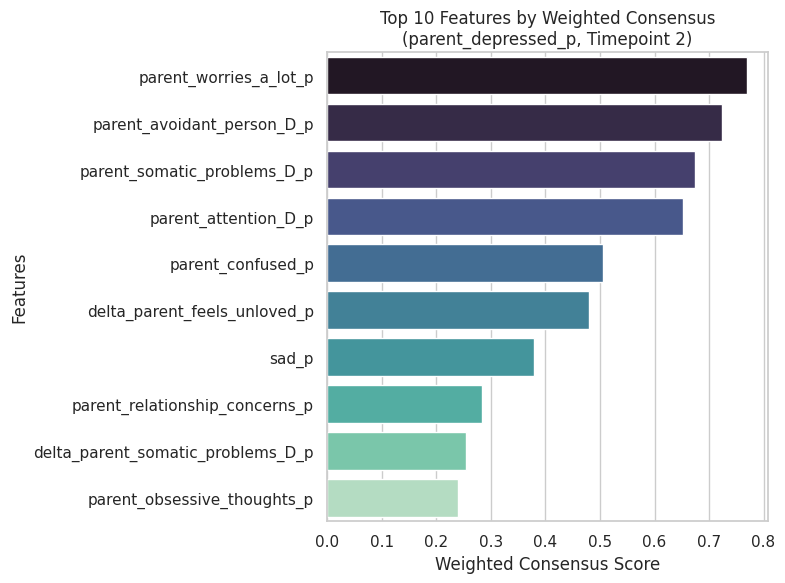

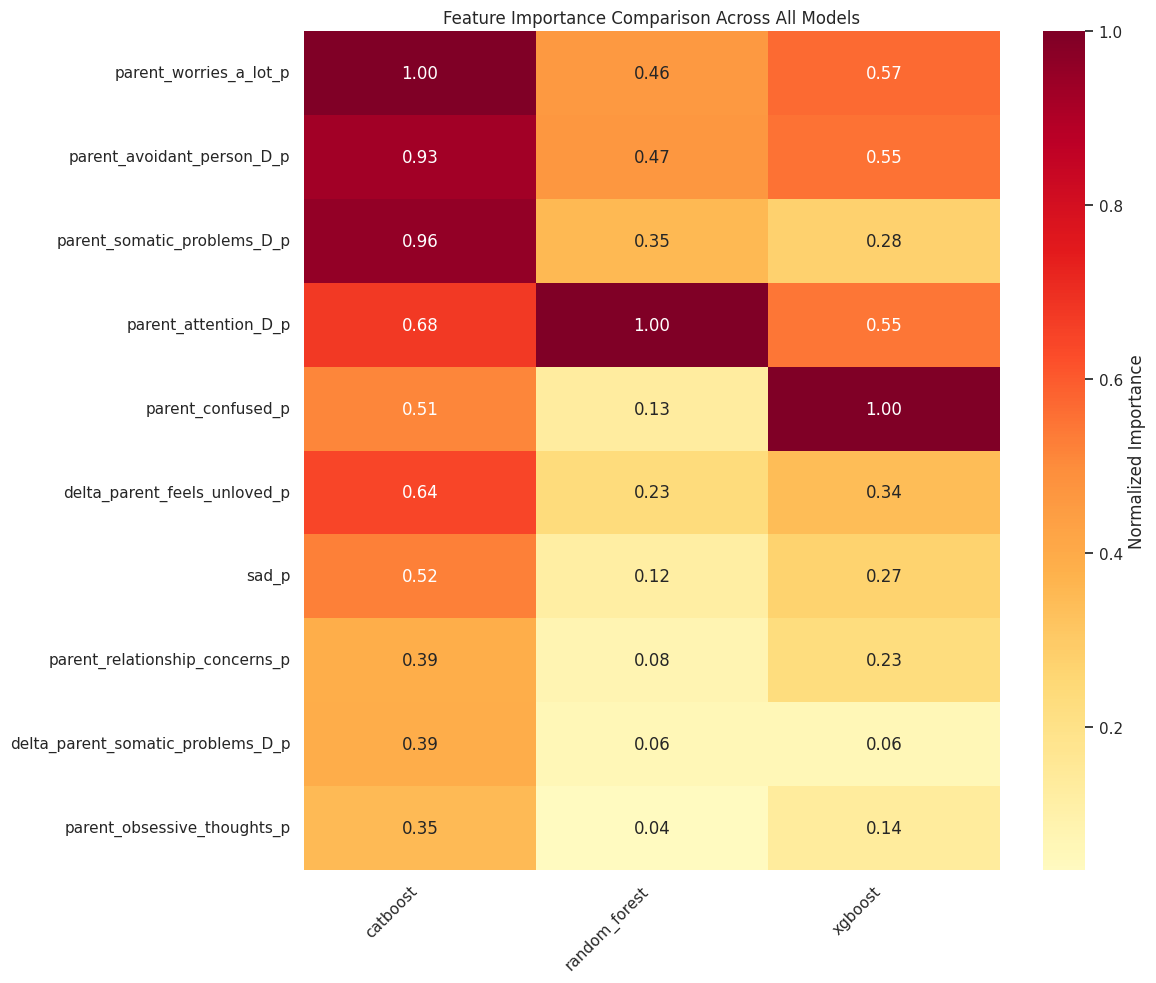


Top features with their consensus scores:
                                        weighted_score    avg_rank  rank_std  \
parent_worries_a_lot_p                        0.768823    2.000000  0.816497   
parent_avoidant_person_D_p                    0.723432    2.666667  0.471405   
parent_somatic_problems_D_p                   0.674189    4.000000  1.632993   
parent_attention_D_p                          0.651983    3.000000  1.414214   
parent_confused_p                             0.504867    4.666667  2.624669   
...                                                ...         ...       ...   
stabbing_shooting_victim_community_p          0.000000  351.666667  3.566822   
heroin_before_pregnancy_p                     0.000000  351.666667  3.566822   
foreign_child_sexually_abuse_victim_p         0.000000  351.666667  3.566822   
domestic_child_sexually_abuse_victim_p        0.000000  351.666667  3.566822   
sex_P_4.0                                     0.000000  351.666667  3.566822 

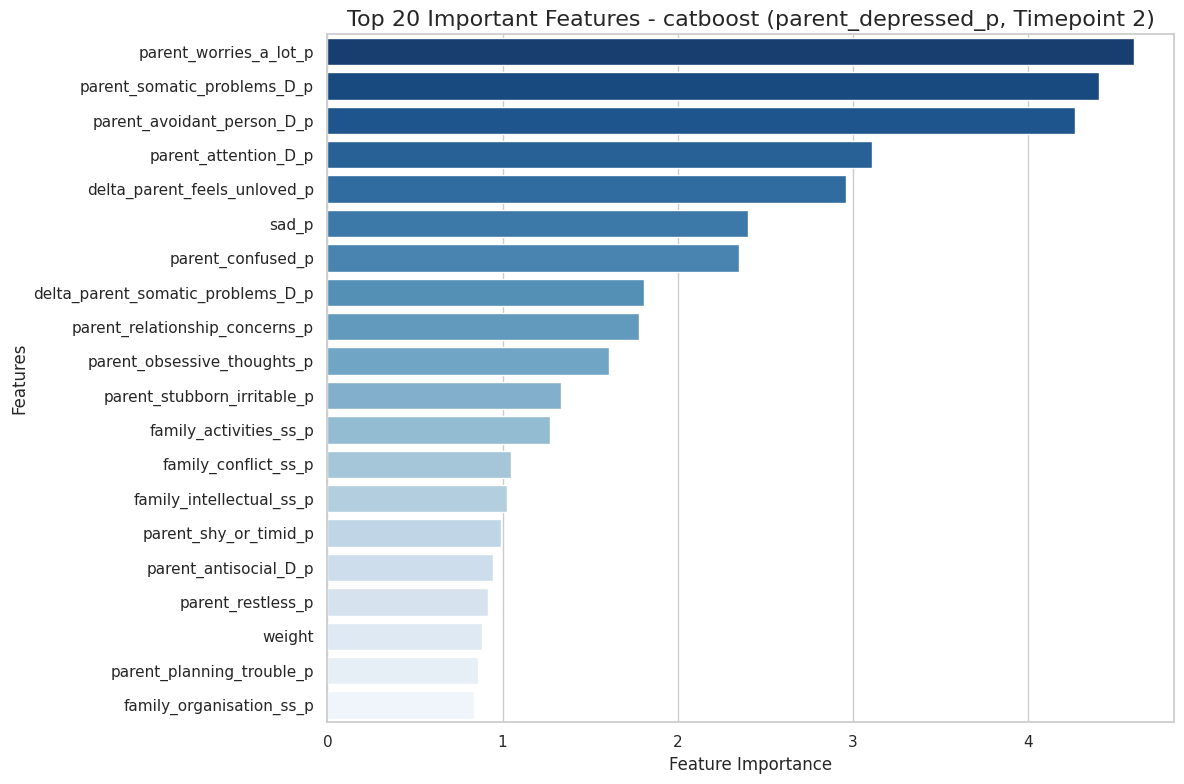

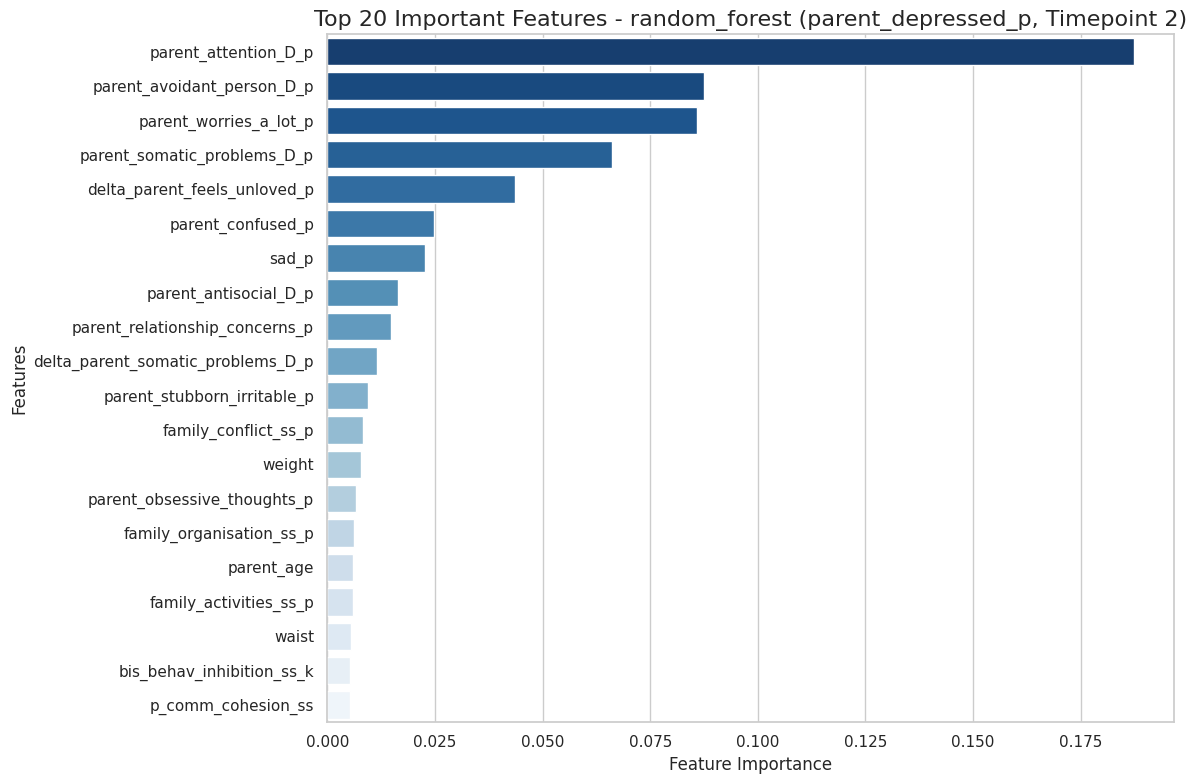

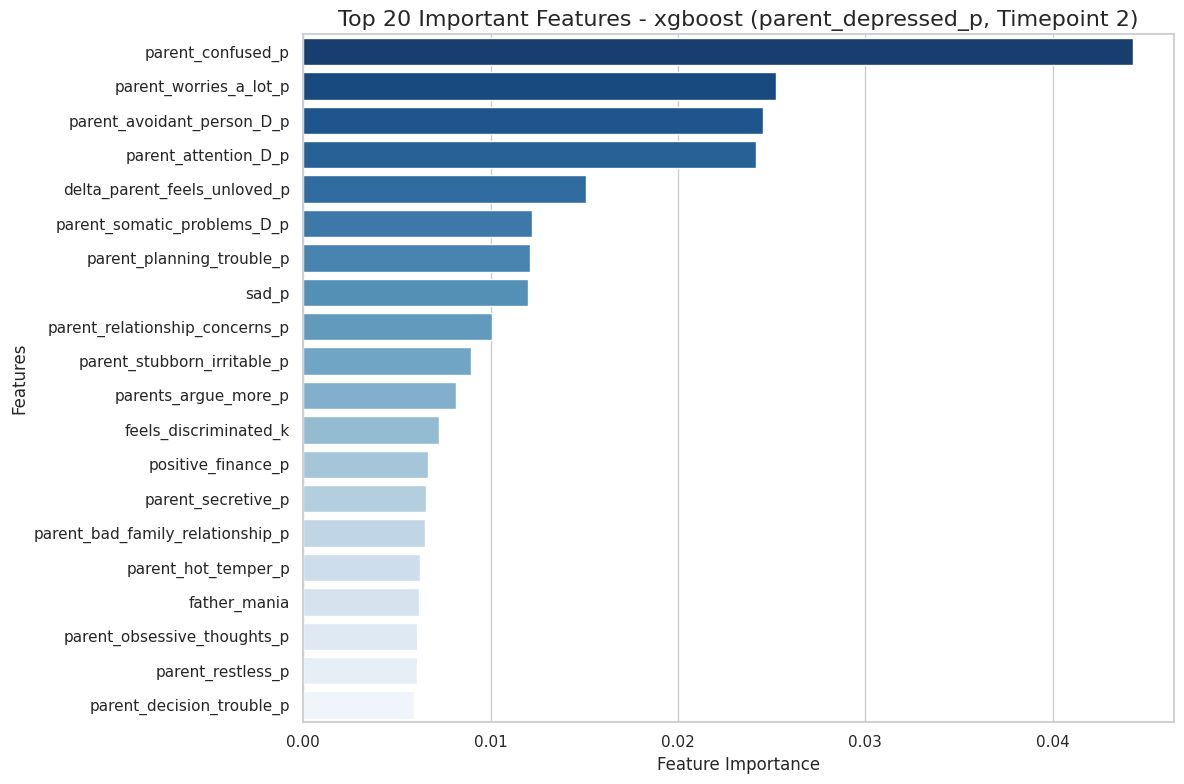

Enhanced feature importance visualization..


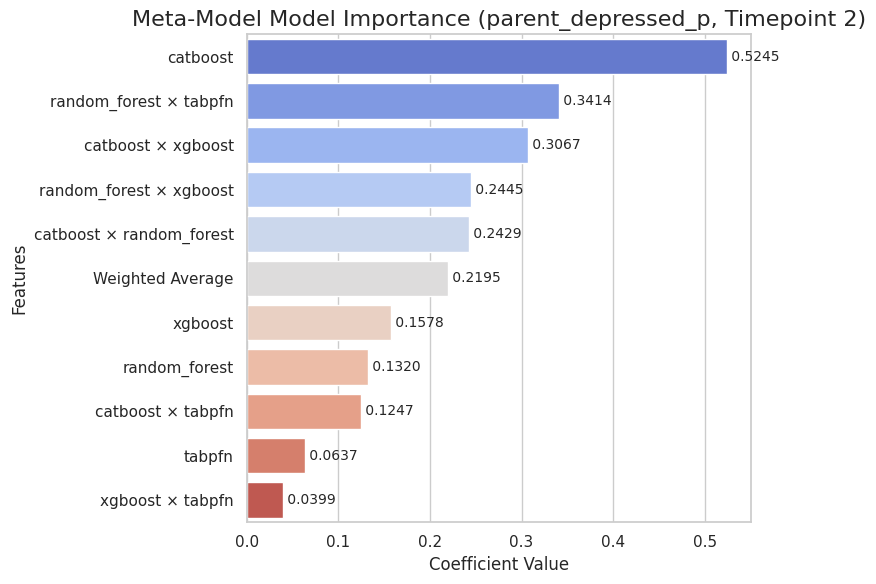

Model: catboost, successfully fit to y_pred predict
Model: random_forest, successfully fit to y_pred predict
Model: xgboost, successfully fit to y_pred predict
Model: tabpfn, successfully fit to y_pred predict


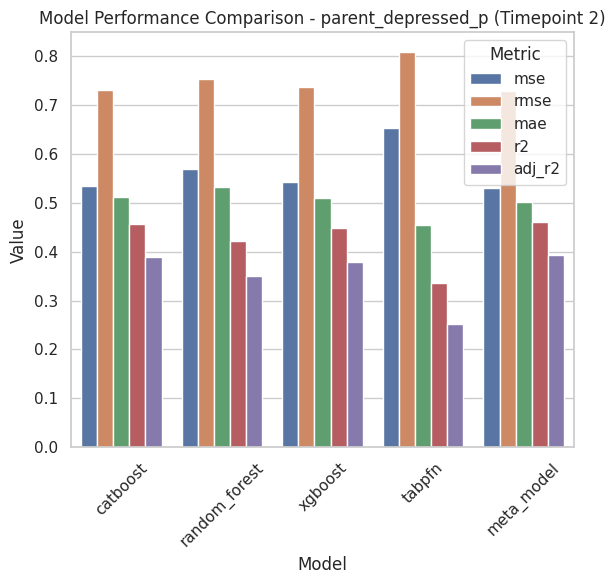


Detailed Metrics:


,mse,rmse,mae,r2,adj_r2
catboost,0.533695,0.730544,0.512115,0.457581,0.389732
random_forest,0.568350,0.753890,0.531953,0.422359,0.350104
xgboost,0.543195,0.737017,0.510890,0.447926,0.378869
tabpfn,0.653675,0.808502,0.455016,0.335640,0.252538
meta_model,0.530526,0.728372,0.501889,0.460802,0.393356


Error in GAM analysis: cannot access local variable 'feature_importance' where it is not associated with a value
Not enough dimensionality to do a GAM FI.

Generating SHAP values for base model: catboost...


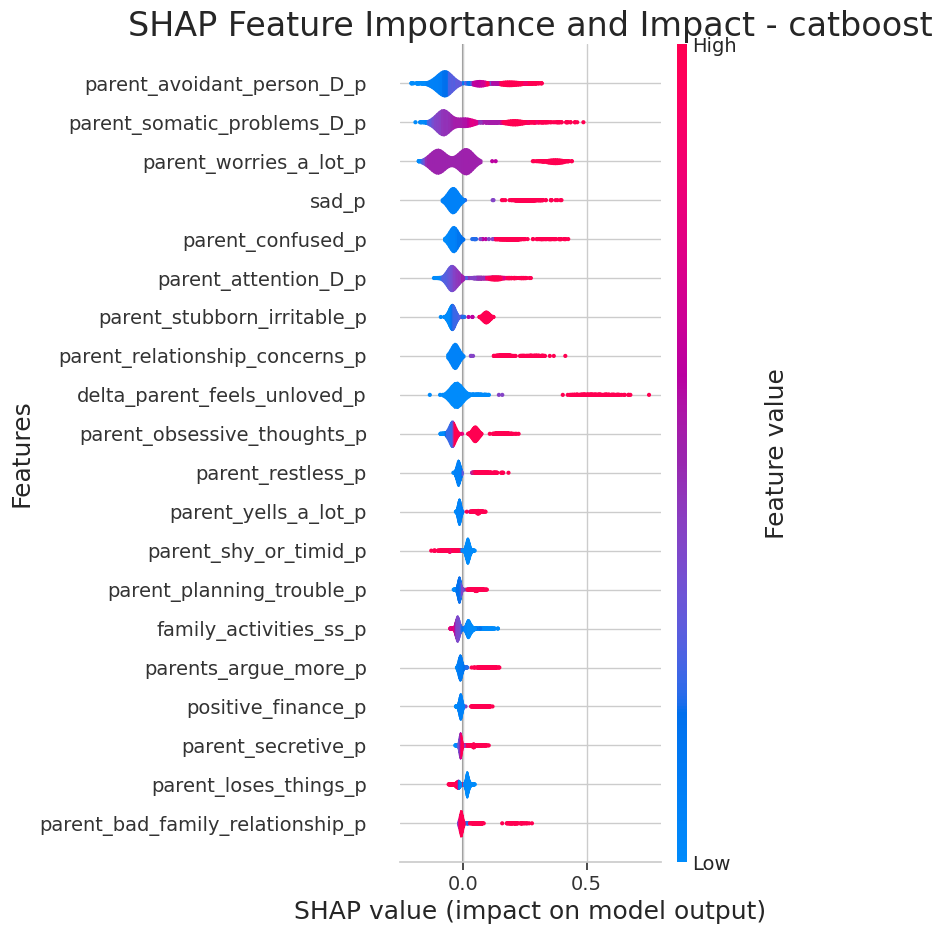


Generating SHAP values for base model: random_forest...


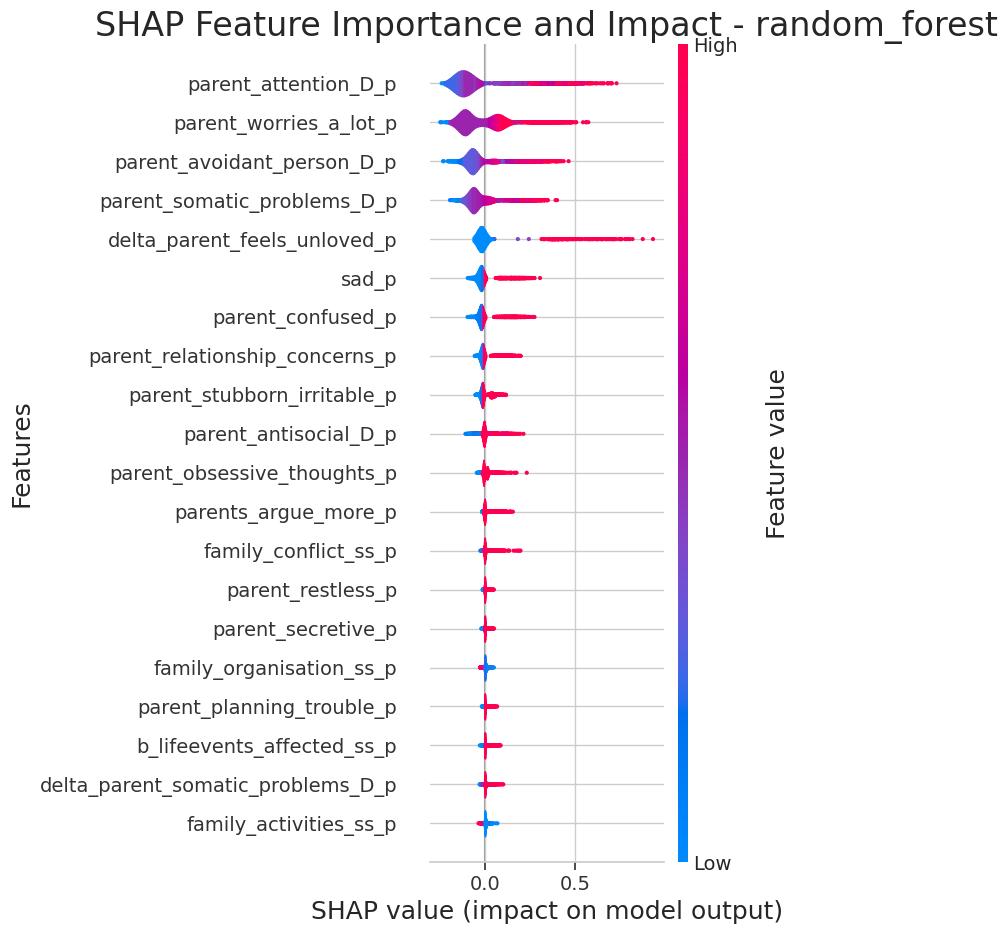


Generating SHAP values for base model: xgboost...


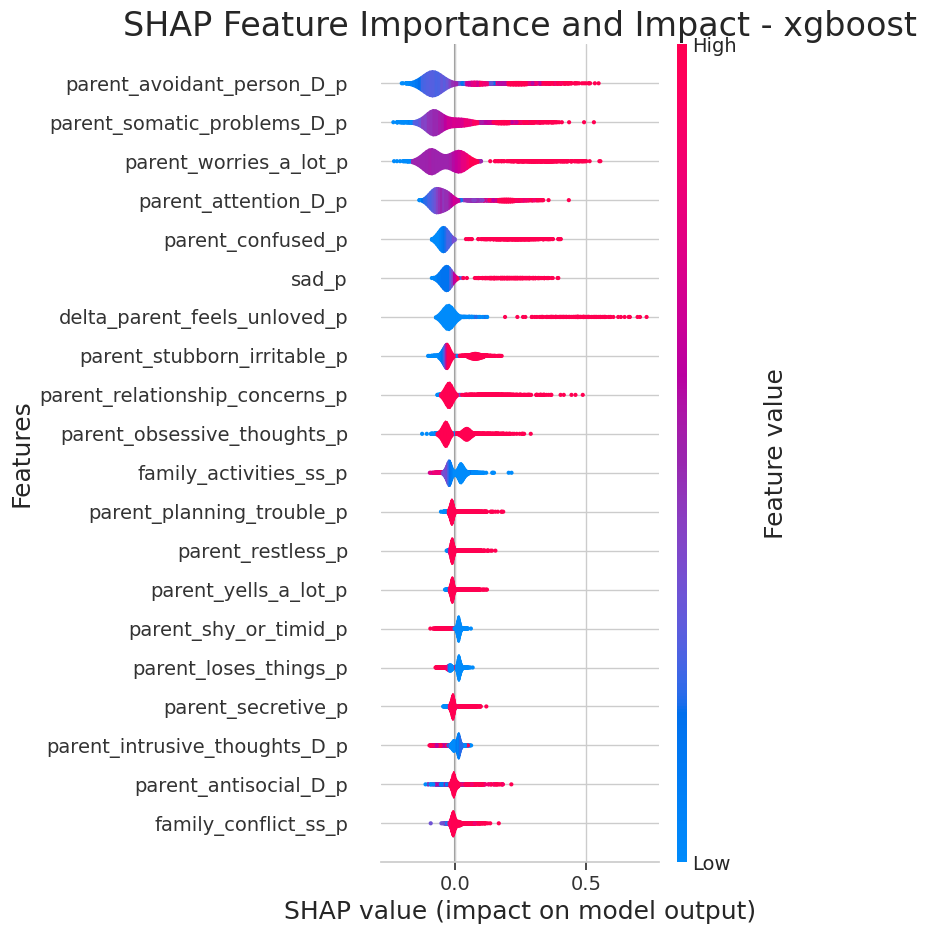


Generating SHAP values for base model: tabpfn...

Performing specialized TabPFN SHAP analysis...


In [ ]:
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
  from pygam import GAM, s
except:
  !pip3 install pygam
  from pygam import GAM, s
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
from smogn import smoter
import shap
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
from sklearn.exceptions import DataConversionWarning
from mapie.regression import MapieRegressor
from mapie.classification import MapieClassifier
from mapie.conformity_scores import AbsoluteConformityScore  # Remove ConformityScore import
from sklearn.model_selection import train_test_split
import optuna
from optuna.integration import CatBoostPruningCallback
from itertools import combinations
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import stats
from itertools import combinations
from collections import defaultdict
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from tabpfn import TabPFNClassifier, TabPFNRegressor
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Add this to global variables for spider plots
category_results = defaultdict(dict)

# Ignore DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set global seaborn style for visual appeal
sns.set(style="whitegrid")
sns.color_palette("cubehelix", as_cmap=True)


run_all = False # @param {"type":"boolean"}

#@markdown ------------------------------------------

isolate = False #@param {"type": "boolean"}
isolate_category="Inter"  #@param ["None", "Inter", "Cognitive Task Outcomes", "Task fMRI", "Multimodal Neuroimaging"]

#@markdown -------------------------------------------

#@markdown This changes CatBoost to EnsembleModels of [CatBoost, RF, XGB, Elastic]
ensemble_version = True #@param {"type":"boolean"}
ensemble_type = 'stacking' #@param ["bagging", "stacking"]

#@markdown ------------------------------------------

quantile_segment = False #@param {"type": "boolean"}

#@markdown ------------------------------------------
tp_option = '2' # @param ["0", "1", "2", "3", "4"]
group = "None" #@param ["high_ale", "high_ale_severe_p_mh", "low_ale", "Female", "Male", "None"]
target_options = "parent_depressed_p"  #@param ['top_10_sbt_core_depression', 'parent_anxdisord_D_p', "parent_bad_relationships_p", 'parent_dep_onset_rci_2.3', 'area_deprivation_idx', 'thought_disorder_D_p', 'gd_riskybets', 'social_problems_D_p', 'not_liked_p', 'doesnt_get_along_p', 'bdefs_distract_upset_p', 'suicidal_p', 'delta_parent_worries_a_lot_p', 'parent_concentration_trouble_p', 'parent_worries_a_lot_p', 'parent_wish_dead_present_B_p', 'delta_parent_depressed_p', 'parent_suicidal_thoughts_p', 'MDD_KSADS_C', 'top_5_sbt_core_depression', 'sbt_core_dep_onset_rci_2.3', 'sbt_core_dep_decrease_2sd', "depress_D_p_rev", "parent_depress_D_p", "parent_depressed_p", "parent_happy_person_p", "wish_dead_present_B_k", "pa_sum_k", "depress_update_p", "delta_sbt_core_depression", "tb_fluid", "tb_cryst", "tb_reading", 'tb_flanker', "bad_grades", "depress_D_p", "delta_depress_D_p", "external_D_p", "adhd_D_p", "anxdisord_D_p", "depadhd_c", "asdadhd_c", "latent_class_depression", "enjoys_little_p", "depressed_mood_B_k", "anhedonia_B_k", "dep_onset_rci_2.3", "dep_remission_rci_2.3", "dep_increase_2sd", "dep_increase_1.5sd", "dep_decrease_2sd", "dep_decrease_1.5sd", "top_10_depression", "top_5_depression", "sbt_core_depression", "sbt_fatigue_sleep", "sbt_anxiety_depression", "sbt_guilt_hopelessness", "sbt_social_withdrawal", "sbt_somatic_depression", "sbt_emotional_dysregulation", "sbt_avoidance_fear", "sbt_aggression_irritability", "sbt_academic_cognitive", "sbt_perfectionism_achievement", "sbt_well_being", "sbt_core_depression_delta_t0_t3"]
split = "across_categories" #@param ["across_categories", "within_categories"]
imputer = "kmeans" #@param ["mean", "median", "kmeans", "mice"]

#@markdown ------------------------------------------
#@markdown <b>Data preprocessing techniques for X_train, X_test, y_train, y_test <br> (Only change this if you know what you are doing!!)
deal_with_na_values = "impute_median" #@param ["fill_with_zero", "drop", "impute_mean", "impute_median"]
#@markdown ------------------------------------------

hyperparameter_tuning = False #@param {"type": "boolean"}
with_optuna = False #@param {"type": "boolean"}
num_of_optuna_trials = 5 # @param {type:"integer"}
#@markdown -------------------------------------------
selection_method = 'None' #@param ['rfecv',  'interaction', 'h-stats', 'clustering', 'None']

#@markdown -------------------------------------------

conformal_prediction = False #@param {"type": "boolean"}

# Add these imports at the top with the other imports
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

#@markdown ------------------------------------------
#@markdown This changes the model type to use a simple ridge or lasso to check
simple_test_model = False #@param {"type": "boolean"}
model_type = "lasso" #@param ["lasso", "ridge"]


# Function to create and tune Lasso or Ridge regression model
def create_tuned_linear_model(model_type, X_train, y_train, alpha_range=None):
    """
    Create and tune Lasso or Ridge regression model.

    Parameters:
    -----------
    model_type : str
        'lasso' or 'ridge'
    X_train : DataFrame
        Training features
    y_train : Series/array
        Training target
    alpha_range : list, optional
        Range of alpha values to search. If None, uses default range.

    Returns:
    --------
    best_model : sklearn model
        Tuned Lasso or Ridge model
    """
    if alpha_range is None:
        alpha_range = np.logspace(-4, 1, 20)

    if model_type == 'lasso':
        model = Lasso(random_state=42, max_iter=10000)
    else:  # ridge
        model = Ridge(random_state=42, max_iter=10000)

    param_grid = {'alpha': alpha_range}

    grid_search = GridSearchCV(
        model, param_grid, cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best alpha for {model_type}: {grid_search.best_params_['alpha']}")
    print(f"Best score: {-grid_search.best_score_:.4f} (MSE)")

    return grid_search.best_estimator_

# Function to run linear model analysis with visualization
def run_linear_model_analysis(model_type, X_train, X_test, y_train, y_test, target_options, tp, category=None):
    """
    Run analysis with Lasso or Ridge regression

    Parameters:
    -----------
    model_type : str
        'lasso' or 'ridge'
    X_train, X_test : DataFrame
        Training and test features
    y_train, y_test : Series/array
        Training and test targets
    target_options, tp, category : str/int
        Target variable, time point, and category for reporting
    """
    print(f"\nRunning {model_type.upper()} Regression Analysis")

    # Train model with cross-validation to select alpha
    model = create_tuned_linear_model(model_type, X_train, y_train)

    # Get coefficients
    coefficients = pd.Series(model.coef_, index=X_train.columns)

    # Plot top coefficients
    plt.figure(figsize=(12, 8))
    top_coefficients = coefficients.abs().sort_values(ascending=False).head(20)
    top_coefficients = coefficients[top_coefficients.index]

    sns.barplot(x=top_coefficients.values, y=top_coefficients.index, palette='coolwarm')
    title = f"Top 20 {model_type.capitalize()} Coefficients ({target_options}, Timepoint {tp}"
    title += f", Category {category})" if category else ")"
    plt.title(title, fontsize=16)
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    evaluation_metrics = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
        'Value': [mse, rmse, mae, r2]
    })

    print("\nEvaluation Metrics:")
    display(evaluation_metrics)

    # Metrics visualization
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(evaluation_metrics.set_index('Metric').T, annot=True, fmt='.4f', cmap='coolwarm', linewidths=1.5, cbar=False)
    ax.set_title(f'Evaluation Metrics for {target_options} (Timepoint {tp})', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Scatter plot of actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_type.capitalize()} Regression: Actual vs Predicted')
    plt.tight_layout()
    plt.show()

    # Add to category results for spider plot (for regression)
    if category is not None:
        if category not in category_results:
            category_results[category] = {}

        category_results[category]['score'] = r2
        # Calculate confidence intervals using bootstrap
        bootstrap_r2_scores = []
        n_bootstraps = 100

        for _ in range(n_bootstraps):
            indices = np.random.choice(len(y_test), len(y_test), replace=True)
            bootstrap_r2 = r2_score(y_test.iloc[indices], y_pred[indices])
            bootstrap_r2_scores.append(bootstrap_r2)

        ci = 1.96 * np.std(bootstrap_r2_scores)
        category_results[category]['score_lower'] = r2 - ci
        category_results[category]['score_upper'] = r2 + ci
        category_results[category]['r2'] = r2

    # Return model and metrics
    return {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'coefficients': coefficients
    }

def ensure_unique_feature_names(df):
    """
    Ensure all feature names in the DataFrame are unique by appending a suffix to duplicates.
    """
    feature_names = list(df.columns)
    unique_names = []
    name_counts = {}

    for name in feature_names:
        if name in name_counts:
            name_counts[name] += 1
            unique_names.append(f"{name}_{name_counts[name]}")
        else:
            name_counts[name] = 0
            unique_names.append(name)

    df.columns = unique_names
    return df

# Handle outliers
def handle_outliers(X, n_sigmas=5):
    for column in X.select_dtypes(include=[np.number]).columns:
        mean = X[column].mean()
        std = X[column].std()
        X[column] = X[column].clip(lower=mean - n_sigmas*std, upper=mean + n_sigmas*std)
    return X

def clean_data(X, y, method='fill_0', imputer_strategy=None):
    if method == 'remove':
        # Remove rows with infinite values
        mask_X = ~np.isinf(X).any(axis=1)
        mask_y = ~np.isinf(y).any(axis=1)
        mask = mask_X & mask_y

        # Remove rows with NaN values
        mask_X = ~np.isnan(X).any(axis=1)
        mask_y = ~np.isnan(y).any(axis=1)
        mask = mask & mask_X & mask_y

        X_clean = X[mask]
        y_clean = y[mask]

    elif method == 'fill_0':
        # Replace infinite values with 0
        X_clean = X.replace([np.inf, -np.inf], 0)
        y_clean = y.replace([np.inf, -np.inf], 0)

        # Replace NaN values with 0
        X_clean = X_clean.fillna(0)
        y_clean = y_clean.fillna(0)

    elif method == 'impute':
        # Replace infinite values with NaN
        X_clean = X.replace([np.inf, -np.inf], np.nan)
        y_clean = y.replace([np.inf, -np.inf], np.nan)

        # Impute NaN values
        if imputer_strategy in ['mean', 'median', 'most_frequent']:
            imputer = SimpleImputer(strategy=imputer_strategy)
            X_clean = pd.DataFrame(imputer.fit_transform(X_clean), columns=X_clean.columns)

            # For y, we'll use the same strategy but fit separately
            y_imputer = SimpleImputer(strategy=imputer_strategy)
            y_clean = pd.DataFrame(y_imputer.fit_transform(y_clean), columns=y_clean.columns)

        else:
            raise ValueError("Invalid imputer_strategy. Choose 'mean', 'median', or 'most_frequent'.")

    else:
        raise ValueError("Invalid method. Choose 'remove', 'fill_0', or 'impute'.")

    return X_clean, y_clean

class LightweightInteractionAnalyzer:
    def __init__(self, model, metric='rmse', n_jobs=-1):
        """
        Initialize the analyzer

        Parameters:
        -----------
        model : fitted model object
            Should have predict method
        metric : str, default='rmse'
            Metric to use for interaction strength ('rmse' or 'r2')
        n_jobs : int, default=-1
            Number of jobs for parallel processing
        """
        self.model = model
        self.metric = metric
        self.n_jobs = n_jobs
        self.interaction_scores = {}

    def _calculate_feature_importance(self, X, y, feature_name):
        """Calculate single feature importance using permutation"""
        baseline_pred = self.model.predict(X)
        baseline_score = mean_squared_error(y, baseline_pred, squared=False)

        X_permuted = X.copy()
        X_permuted[feature_name] = np.random.permutation(X_permuted[feature_name])
        permuted_pred = self.model.predict(X_permuted)
        permuted_score = mean_squared_error(y, permuted_pred, squared=False)

        return abs(permuted_score - baseline_score)

    def _calculate_interaction_strength(self, X, y, feat1, feat2):
        """Calculate interaction strength between two features"""
        # Calculate individual importance
        imp1 = self._calculate_feature_importance(X, y, feat1)
        imp2 = self._calculate_feature_importance(X, y, feat2)

        # Calculate joint importance
        X_permuted = X.copy()
        X_permuted[feat1] = np.random.permutation(X_permuted[feat1])
        X_permuted[feat2] = np.random.permutation(X_permuted[feat2])

        baseline_pred = self.model.predict(X)
        baseline_score = mean_squared_error(y, baseline_pred, squared=False)

        permuted_pred = self.model.predict(X_permuted)
        joint_score = mean_squared_error(y, permuted_pred, squared=False)

        # Interaction strength is the difference between joint importance
        # and the sum of individual importances
        interaction = abs(joint_score - baseline_score) - (imp1 + imp2)
        return max(interaction, 0)  # Ensure non-negative

    def analyze_interactions(self, X, y, max_features=10):
        """
        Analyze feature interactions

        Parameters:
        -----------
        X : pandas DataFrame
            Input features
        y : array-like
            Target variable
        max_features : int, default=10
            Maximum number of top features to consider for interactions
        """
        print("Calculating feature importances...")
        # First, get individual feature importances
        importances = {}
        for feature in tqdm(X.columns):
            importances[feature] = self._calculate_feature_importance(X, y, feature)

        # Select top features based on individual importance
        top_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        top_features = [f[0] for f in top_features[:max_features]]

        print("\nAnalyzing feature interactions...")
        # Calculate interactions between top features
        for feat1, feat2 in tqdm(list(combinations(top_features, 2))):
            interaction_strength = self._calculate_interaction_strength(X, y, feat1, feat2)
            self.interaction_scores[(feat1, feat2)] = interaction_strength

        return self.interaction_scores

    def plot_interactions(self, X, top_n=10):
        """Plot interaction heatmap"""
        # Create interaction matrix
        features = list(set([f for pair in self.interaction_scores.keys() for f in pair]))
        n_features = len(features)
        interaction_matrix = np.zeros((n_features, n_features))

        for (feat1, feat2), strength in self.interaction_scores.items():
            i = features.index(feat1)
            j = features.index(feat2)
            interaction_matrix[i, j] = strength
            interaction_matrix[j, i] = strength

        # Plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            interaction_matrix,
            xticklabels=features,
            yticklabels=features,
            cmap='YlOrRd'
        )
        plt.title('Feature Interaction Strengths')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Plot top interactions as bar chart
        sorted_interactions = sorted(
            self.interaction_scores.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top_n]

        plt.figure(figsize=(12, 6))
        interaction_names = [' × '.join(k) for k, _ in sorted_interactions]
        interaction_strengths = [v for _, v in sorted_interactions]

        plt.bar(range(len(sorted_interactions)), interaction_strengths)
        plt.xticks(
            range(len(sorted_interactions)),
            interaction_names,
            rotation=45,
            ha='right'
        )
        plt.title('Top Feature Interactions')
        plt.ylabel('Interaction Strength')
        plt.tight_layout()
        plt.show()

def analyze_model_interactions(model, X_train, X_test, y_train, max_features=10):
    """Analyze feature interactions using lightweight methods"""
    analyzer = LightweightInteractionAnalyzer(model)
    interaction_scores = analyzer.analyze_interactions(X_train, y_train, max_features=max_features)
    analyzer.plot_interactions(X_train)
    return interaction_scores

# Optuna objective
def objective(trial, X, y, is_reg, num_classes):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-7, 1, log=True),
        'random_state': 42
    }

    if is_reg:
        model = CatBoostRegressor(**params)
        eval_metric = 'RMSE'
    else:
        if num_classes > 2:
            params['loss_function'] = 'MultiClass'
            eval_metric = 'MultiClass'
        else:
            params['loss_function'] = 'Logloss'
            eval_metric = 'Logloss'
        model = CatBoostClassifier(**params)

    pruning_callback = CatBoostPruningCallback(trial, eval_metric)
    model.fit(X, y, eval_set=[(X, y)], early_stopping_rounds=100, verbose=False, callbacks=[pruning_callback])

    if is_reg:
        return model.best_score_['validation'][eval_metric]
    else:
        return model.best_score_['validation'][eval_metric]

# Try interaction features
def create_interaction_features(X, max_interactions=1000):
    initial_features = X.columns
    n_features = len(initial_features)

    # Calculate total possible interactions
    total_interactions = n_features * (n_features - 1) // 2

    # Generate all combinations
    all_combinations = list(combinations(range(n_features), 2))

    # If total interactions exceed max_interactions, randomly select interactions
    if total_interactions > max_interactions:
        np.random.seed(42)
        indices = np.random.permutation(total_interactions)[:max_interactions]
        feature_pairs = [all_combinations[i] for i in indices]
    else:
        feature_pairs = all_combinations

    # Create interaction features
    interaction_features = {}
    for i, j in feature_pairs:
        feat_A, feat_B = initial_features[i], initial_features[j]
        interaction_name = f'{feat_A}_x_{feat_B}'
        interaction_features[interaction_name] = X.iloc[:, i] * X.iloc[:, j]

    return pd.DataFrame(interaction_features)

def visualize_feature_importance(X_train, y_train, top_n=20):
    """
    Create visualizations for feature importance based on correlation with target

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features including interaction terms
    y_train : pandas Series
        Target variable
    top_n : int
        Number of top features to show in plots
    """
    # Ensure y_train is a Series with a name
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]
    if not isinstance(y_train, pd.Series):
        y_train = pd.Series(y_train)
    if y_train.name is None:
        y_train.name = 'target'

    # Calculate correlations with target
    correlations = X_train.apply(lambda x: abs(x.corr(y_train)) if x.name != y_train.name else 0)

    # Sort correlations
    top_correlations = correlations.sort_values(ascending=False).head(top_n)

    # Create figure with subplots
    plt.figure(figsize=(15, 10))

    # 1. Bar plot of top feature correlations
    plt.subplot(2, 1, 1)
    sns.barplot(x=top_correlations.values, y=top_correlations.index)
    plt.title(f'Top {top_n} Feature Correlations with Target')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')

    # Separate interaction terms and original features
    interaction_features = [f for f in top_correlations.index if '_x_' in f]
    original_features = [f for f in top_correlations.index if '_x_' not in f]

    # Create color mapping
    colors = ['#ff9999' if '_x_' in f else '#66b3ff' for f in top_correlations.index]

    # 2. Horizontal bar plot with color-coded features
    plt.subplot(2, 1, 2)
    bars = plt.barh(range(len(top_correlations)), top_correlations.values, color=colors)
    plt.yticks(range(len(top_correlations)), top_correlations.index)
    plt.xlabel('Absolute Correlation')
    plt.title('Feature Importance (Blue: Original Features, Red: Interaction Terms)')

    plt.tight_layout()
    plt.show()

def visualize_interaction_matrix(X_train, y_train, top_n=20):
    """
    Create a heatmap of feature interactions

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features including interaction terms
    y_train : pandas Series
        Target variable
    top_n : int
        Number of top features to include in heatmap
    """
    # Calculate correlations with target
    correlations = X_train.apply(lambda x: abs(x.corr(y_train)))

    # Get top features
    top_features = correlations.nlargest(top_n).index

    # Calculate correlation matrix for top features
    correlation_matrix = X_train[top_features].corr()

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f',
                square=True)
    plt.title('Feature Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def calculate_safe_correlations(X_train, y_train):
    # Convert y_train to 1D array if it's not already
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0].values
    elif isinstance(y_train, pd.Series):
        y_train = y_train.values
    y_train = y_train.ravel()

    correlations = {}

    # Calculate correlations one at a time
    for feature in X_train.columns:
        feature_values = X_train[feature].values.ravel()
        # Remove any NaN values
        mask = ~(np.isnan(feature_values) | np.isnan(y_train))
        if mask.sum() > 0:
            correlation = np.corrcoef(feature_values[mask], y_train[mask])[0, 1]
            correlations[feature] = abs(correlation) if not np.isnan(correlation) else 0
        else:
            correlations[feature] = 0

    return pd.Series(correlations)

def analyze_and_visualize_interactions(X_train, y_train, top_n=20):
    # 1. Feature importance visualization
    print("Plotting feature importance...")
    visualize_feature_importance(X_train, y_train, top_n)

    # 2. Interaction matrix visualization
    print("\nPlotting interaction matrix...")
    print("WIP!")
    #visualize_interaction_matrix(X_train, y_train, top_n)

    # 3. Print top interaction terms
    interaction_features = [f for f in X_train.columns if '_x_' in f]

    if interaction_features:

        X_interactions = X_train[interaction_features]
        correlations = calculate_safe_correlations(X_interactions, y_train)

        top_interactions = correlations.sort_values(ascending=False).head(top_n)

        print("\nTop 10 Interaction Features:")
        print("-" * 50)
        for feat, corr in top_interactions.items():
            # Split feature name for better readability
            feat1, feat2 = feat.split('_x_')
            print(f"{feat1} × {feat2}: {corr:.4f}")

        # Optional: Create visualization
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(top_interactions)), top_interactions.values)
        plt.xticks(range(len(top_interactions)),
                  [f"{f.split('_x_')[0]}\n×\n{f.split('_x_')[1]}" for f in top_interactions.index],
                  rotation=45)
        plt.title('Top Feature Interactions by Correlation with Target')
        plt.ylabel('Absolute Correlation')
        plt.tight_layout()
        plt.show()

        #correlations = X_train[interaction_features].apply(lambda x: abs(x.corr(y_train)))
        #top_interactions = correlations.nlargest(10)
        #print("\nTop 10 Interaction Features:")
        #for feat, corr in top_interactions.items():
            #print(f"{feat}: {corr:.4f}")

    return None

def plot_specific_interaction(model, X, feature1, feature2, n_samples=1000):
    """Plot detailed interaction between two specific features."""
    if len(X) > n_samples:
        X = X.sample(n_samples, random_state=42)

    # Create 2D grid of feature values
    x1_range = np.linspace(X[feature1].min(), X[feature1].max(), 20)
    x2_range = np.linspace(X[feature2].min(), X[feature2].max(), 20)
    xx1, xx2 = np.meshgrid(x1_range, x2_range)

    # Create predictions for grid
    grid_data = X.copy()
    predictions = np.zeros((20, 20))

    for i in range(20):
        for j in range(20):
            grid_data[feature1] = xx1[i, j]
            grid_data[feature2] = xx2[i, j]
            predictions[i, j] = model.predict(grid_data).mean()

    # Plot interaction
    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, predictions, levels=20, cmap='viridis')
    plt.colorbar(label='Predicted Value')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'Interaction Effect: {feature1} × {feature2}')
    plt.tight_layout()
    plt.show()

def calculate_h_statistics_batch(model, X, feature_pairs, n_samples=1000, batch_size=100):
    """Calculate H-statistics for multiple feature pairs in batches."""
    if len(X) > n_samples:
        X = X.sample(n_samples, random_state=42)

    results = []

    # Process feature pairs in batches
    for i in range(0, len(feature_pairs), batch_size):
        batch_pairs = feature_pairs[i:i + batch_size]
        batch_results = []

        # Get base predictions once for this batch (each batch one base)
        base_pred = model.predict(X)

        for feat1, feat2 in batch_pairs:
            # Create all permutations at once
            X_perm = X.copy()
            X_perm[feat1] = np.random.permutation(X_perm[feat1].values)
            pred1 = model.predict(X_perm)

            X_perm[feat2] = np.random.permutation(X_perm[feat2].values)
            pred_both = model.predict(X_perm)

            X_perm = X.copy()
            X_perm[feat2] = np.random.permutation(X_perm[feat2].values)
            pred2 = model.predict(X_perm)

            # Calculate H-statistic
            effect1 = np.mean(np.abs(base_pred - pred1))
            effect2 = np.mean(np.abs(base_pred - pred2))
            effect_both = np.mean(np.abs(base_pred - pred_both))

            h_stat = max(0, effect_both - (effect1 + effect2))
            batch_results.append(h_stat)

        results.extend(batch_results)

    return results

def select_features_with_h_statistics(X_train, X_test, y_train, is_reg=True, max_features=1000, top_interactions=50):
    """
    Select features based on H-statistics for interaction strength.

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features
    X_test : pandas DataFrame
        Test features
    y_train : array-like
        Training target
    is_reg : bool
        Whether this is a regression (True) or classification (False) problem
    max_features : int
        Maximum number of features to return after selection
    top_interactions : int
        Number of top interactions to consider for feature creation

    Returns:
    --------
    X_train_selected : pandas DataFrame
        Training data with selected original and interaction features
    X_test_selected : pandas DataFrame
        Test data with selected original and interaction features
    """

    if is_reg:
        model = CatBoostRegressor(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            verbose=False,
            random_state=42
        )
    else:
        model = CatBoostClassifier(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            verbose=False,
            random_state=42
        )

    print("Training initial model...")
    model.fit(X_train, y_train)

    # Generate feature pairs
    features = list(X_train.columns)
    feature_pairs = [(features[i], features[j])
                    for i in range(len(features))
                    for j in range(i + 1, len(features))]

    # Calculate H-statistics with batching and sampling
    print("Calculating H-statistics for feature pairs...")
    h_stats = calculate_h_statistics_batch(model, X_train, feature_pairs,
                                         n_samples=500,  # Reduced sample size
                                         batch_size=100)  # Batch processing

    # Create interaction strengths list
    interaction_strengths = [(pair[0], pair[1], stat)
                           for pair, stat in zip(feature_pairs, h_stats)]

    # Sort by interaction strength
    interaction_strengths.sort(key=lambda x: x[2], reverse=True)

    # Create interaction features for top pairs
    print(f"\nCreating interaction features for top {top_interactions} pairs...")
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()

    for feat1, feat2, strength in interaction_strengths[:top_interactions]:
        feat_name = f"{feat1}_x_{feat2}"
        X_train_new[feat_name] = X_train[feat1] * X_train[feat2]
        X_test_new[feat_name] = X_test[feat1] * X_test[feat2]

    # Calculate feature importance including new interaction features
    print("Calculating final feature importance...")
    model.fit(X_train_new, y_train)
    feature_importance = model.get_feature_importance()

    # Select top features based on importance
    feature_ranks = pd.Series(feature_importance, index=X_train_new.columns)
    selected_features = feature_ranks.nlargest(max_features).index

    # Visualize feature importance and interactions
    plt.figure(figsize=(15, 10))

    # Plot feature importance
    plt.subplot(2, 1, 1)
    top_20_features = feature_ranks.nlargest(20)
    sns.barplot(x=top_20_features.values, y=top_20_features.index)
    plt.title('Top 20 Features (Including Interactions)')
    plt.xlabel('Feature Importance')

    # Plot top interactions
    plt.subplot(2, 1, 2)
    top_interactions_df = pd.DataFrame(
        interaction_strengths[:10],
        columns=['Feature 1', 'Feature 2', 'H-Statistic']
    )
    sns.barplot(
        data=top_interactions_df,
        x='H-Statistic',
        y=top_interactions_df.apply(lambda x: f"{x['Feature 1']}\n×\n{x['Feature 2']}", axis=1)
    )
    plt.title('Top 10 Feature Interactions (H-Statistics)')
    plt.tight_layout()
    plt.show()

    # Create heatmap of top interactions
    n_top = 10  # Number of top features to show in heatmap
    top_features = list(set([f for pair in interaction_strengths[:n_top] for f in pair[:2]]))
    n_features = len(top_features)
    interaction_matrix = np.zeros((n_features, n_features))

    # Fill interaction matrix
    for i, feat1 in enumerate(top_features):
        for j, feat2 in enumerate(top_features):
            if i < j:
                # Find this pair in interaction_strengths if it exists
                strength = next((s for f1, f2, s in interaction_strengths
                               if (f1 == feat1 and f2 == feat2) or
                                  (f1 == feat2 and f2 == feat1)), 0)
                interaction_matrix[i, j] = strength
                interaction_matrix[j, i] = strength

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    ''' sns.heatmap(interaction_matrix,
                  xticklabels=top_features,
                  yticklabels=top_features,
                  cmap='YlOrRd',
                  annot=True,
                  fmt='.2e')'''

    # Create heatmap with adjusted spacing (commenting out bc it still looks like shit)
    '''    sns.heatmap(interaction_matrix,
                    xticklabels=top_features,
                    yticklabels=top_features,
                    cmap='YlOrRd',
                    annot=True,
                    fmt='.2e',
                    annot_kws={'size': min(10, 200/n_features)})  # Scale font size'''

    sns.heatmap(interaction_matrix,
              xticklabels=top_features,
              yticklabels=top_features,
              cmap='YlOrRd',
              annot=True,
              fmt='.2e',
              annot_kws={'size': 6})  # Fixed smaller size for numbers inside heatmap


    plt.title('Feature Interaction Strength Heatmap (H-Statistics)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print top interaction details
    print("\nTop 10 Feature Interactions (H-Statistics):")
    print("-" * 50)
    for feat1, feat2, strength in interaction_strengths[:10]:
        print(f"{feat1} × {feat2}: {strength:.4e}")

    # Return selected features
    X_train_selected = X_train_new[selected_features]
    X_test_selected = X_test_new[selected_features]

    print(f"\nFinal number of features: {len(selected_features)}")
    print(f"Number of interaction features: {sum('_x_' in f for f in selected_features)}")

    return X_train_selected, X_test_selected

def select_features_with_shap_interactions(X_train, X_test, y_train, split, is_reg=True, max_features=1000, top_interactions=50):
    """
    Select features based on SHAP interaction values.

    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features
    X_test : pandas DataFrame
        Test features
    y_train : array-like
        Training target
    is_reg : bool
        Whether this is a regression (True) or classification (False) problem
    max_features : int
        Maximum number of features to return after selection
    top_interactions : int
        Number of top interactions to consider for feature creation

    Returns:
    --------
    X_train_selected : pandas DataFrame
        Training data with selected original and interaction features
    X_test_selected : pandas DataFrame
        Test data with selected original and interaction features
    """

    import matplotlib.pyplot as plt
    import networkx as nx

    # Train a simple CatBoost model for SHAP analysis
    if is_reg:
        model = CatBoostRegressor(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            verbose=False,
            random_state=42
        )
    else:
        model = CatBoostClassifier(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            verbose=False,
            random_state=42
        )

    # Fit the model
    print("Training initial model for SHAP analysis...")
    model.fit(X_train, y_train)

    # Calculate SHAP interaction values
    print("Calculating SHAP interaction values...")
    explainer = shap.TreeExplainer(model)

    # Use a sample of the training data for interaction calculations
    sample_size = min(1000, len(X_train))
    X_train_sample = X_train.iloc[:sample_size]
    shap_interaction_values = explainer.shap_interaction_values(X_train_sample)

    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[0]

    # Calculate mean absolute SHAP interaction values
    mean_interactions = np.abs(shap_interaction_values).mean(axis=0)

    # Get feature pairs with strongest interactions
    interaction_strengths = []
    features = X_train.columns

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            strength = (mean_interactions[i, j] + mean_interactions[j, i]) / 2
            interaction_strengths.append((features[i], features[j], strength))

    # Sort interactions by strength
    interaction_strengths.sort(key=lambda x: x[2], reverse=True)

    # Create new interaction features for top pairs
    print(f"Creating interaction features for top {top_interactions} pairs...")
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()

    for feat1, feat2, strength in interaction_strengths[:top_interactions]:
        feat_name = f"{feat1}_x_{feat2}"
        X_train_new[feat_name] = X_train[feat1] * X_train[feat2]
        X_test_new[feat_name] = X_test[feat1] * X_test[feat2]

    # Calculate feature importance including new interaction features
    print("Calculating final feature importance...")
    model.fit(X_train_new, y_train)
    feature_importance = model.get_feature_importance()

    # Select top features based on importance
    feature_ranks = pd.Series(feature_importance, index=X_train_new.columns)
    selected_features = feature_ranks.nlargest(max_features).index

    # Visualize feature importance and interactions
    plt.figure(figsize=(15, 10))

    # Plot feature importance
    plt.subplot(2, 1, 1)
    top_20_features = feature_ranks.nlargest(20)
    sns.barplot(x=top_20_features.values, y=top_20_features.index)
    plt.title('Top 20 Features (Including Interactions)')
    plt.xlabel('Feature Importance')

    # Plot top interactions
    plt.subplot(2, 1, 2)
    top_interactions_df = pd.DataFrame(
        interaction_strengths[:10],
        columns=['Feature 1', 'Feature 2', 'Interaction Strength']
    )
    sns.barplot(
        data=top_interactions_df,
        x='Interaction Strength',
        y=top_interactions_df.apply(lambda x: f"{x['Feature 1']}\n×\n{x['Feature 2']}", axis=1)
    )
    plt.title('Top 10 Feature Interactions')

    plt.tight_layout()
    plt.show()

    # Calculate feature importance including new interaction features
    print("Calculating final feature importance...")
    model.fit(X_train_new, y_train)
    feature_importance = model.get_feature_importance()

    # Select top features based on importance
    feature_ranks = pd.Series(feature_importance, index=X_train_new.columns)
    selected_features = feature_ranks.nlargest(max_features).index

    # Create heatmap of top interactions

    n_top = 10  # Number of top features to show in heatmap
    top_features = list(set([f for pair in interaction_strengths[:n_top] for f in pair[:2]]))
    n_features = len(top_features)
    interaction_matrix = np.zeros((n_features, n_features))

    # Fill interaction matrix
    for i, feat1 in enumerate(top_features):
        for j, feat2 in enumerate(top_features):
            if i < j:
                # Find this pair in interaction_strengths if it exists
                strength = next((s for f1, f2, s in interaction_strengths
                               if (f1 == feat1 and f2 == feat2) or
                                  (f1 == feat2 and f2 == feat1)), 0)
                interaction_matrix[i, j] = strength
                interaction_matrix[j, i] = strength

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(interaction_matrix,
                xticklabels=top_features,
                yticklabels=top_features,
                cmap='YlOrRd',
                annot=True,
                fmt='.2e')
    plt.title('Feature Interaction Strength Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


    # Print top interaction details
    if split == 'within_categories':
      print("\nTop 10 Feature Interactions:")
      print("-" * 50)
      for feat1, feat2, strength in interaction_strengths[:10]:
          print(f"{feat1} × {feat2}: {strength:.4e}")
    else:
      print("\nTop 50 Feature Interactions:")
      print("-" * 50)
      for feat1, feat2, strength in interaction_strengths[:50]:
          print(f"{feat1} × {feat2}: {strength:.4e}")

    # Return selected features
    X_train_selected = X_train_new[selected_features]
    X_test_selected = X_test_new[selected_features]

    print(f"\nFinal number of features: {len(selected_features)}")
    print(f"Number of interaction features: {sum('_x_' in f for f in selected_features)}")

    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    # Create network visualization of top interactions
    print("Creating interaction network graph...")

    # Create graph
    G = nx.Graph()

    # Get top N interactions for the graph
    top_n = min(20, len(interaction_strengths))  # Adjust based on readability
    top_interactions_for_graph = sorted(interaction_strengths[:top_n], key=lambda x: x[2], reverse=True)

    # Add nodes and edges
    for feat1, feat2, strength in top_interactions_for_graph:
        # Add nodes if they don't exist
        if feat1 not in G:
            G.add_node(feat1)
        if feat2 not in G:
            G.add_node(feat2)

        # Add edge with weight based on interaction strength
        G.add_edge(feat1, feat2, weight=strength)

    # Calculate node size based on individual feature importance
    node_importance = {}
    feature_importance = model.get_feature_importance()
    feature_dict = dict(zip(X_train.columns, feature_importance))

    for node in G.nodes():
        node_importance[node] = feature_dict.get(node, 0)

    # Normalize node sizes for visualization
    max_size = 800
    min_size = 300
    if max(node_importance.values()) > 0:  # Avoid division by zero
        node_sizes = [min_size + (max_size - min_size) * node_importance[node] / max(node_importance.values())
                    for node in G.nodes()]
    else:
        node_sizes = [min_size for node in G.nodes()]

    # Create figure
    plt.figure(figsize=(16, 12), facecolor='white')

    # Use a shell layout for more square-like appearance
    pos = nx.kamada_kawai_layout(G)  # This often gives more evenly spaced nodes

    # Create custom colormap for edges - from light blue to pink
    colors = ['#a6cffe', '#ff9dc0']  # Light blue to pink
    edge_cmap = LinearSegmentedColormap.from_list('edge_colormap', colors)

    # Get max weight for normalization
    max_weight = max([G[u][v]['weight'] for u, v in G.edges()])

    # Draw edges with color based on weight and width proportional to weight
    for u, v, data in G.edges(data=True):
        weight = data['weight']
        normalized_weight = weight / max_weight
        edge_width = 1 + 8 * normalized_weight  # Scale width between 1 and 9
        edge_color = edge_cmap(normalized_weight)

        # Draw each edge individually with its own color and width
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                              width=edge_width,
                              edge_color=[edge_color],
                              alpha=0.8)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                         node_color='#4a90e2',  # Medium blue
                         alpha=0.8,
                         linewidths=1,
                         edgecolors='navy')

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_family='sans-serif')

    # Add edge labels with weights
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2e}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Feature Interaction Network Graph", fontsize=18, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    from matplotlib import cm



    return X_train_selected, X_test_selected

def plot_shap_interaction_violin_grid(model, X, top_n_features=4):
    """
    Create a grid of violin plots showing SHAP interaction values between top features.

    Parameters:
    -----------
    model : fitted CatBoost model
        The trained model to analyze
    X : pandas DataFrame
        Feature data to analyze
    top_n_features : int
        Number of top features to include in the grid
    """
    # Calculate SHAP interaction values
    explainer = shap.TreeExplainer(model)

    # Use a sample of data if the dataset is large
    sample_size = min(1000, len(X))
    X_sample = X.iloc[:sample_size]

    print("Calculating SHAP interaction values...")
    shap_interaction_values = explainer.shap_interaction_values(X_sample)

    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[0]

    # Get feature importance based on mean absolute SHAP values
    feature_importance = np.abs(shap_interaction_values).mean(axis=0).sum(axis=1)
    top_indices = np.argsort(-feature_importance)[:top_n_features]
    top_features = X.columns[top_indices]

    # Create figure
    fig, axes = plt.subplots(top_n_features, top_n_features,
                            figsize=(3*top_n_features, 3*top_n_features))

    # Create violin plots for each feature pair
    for i, feat1 in enumerate(top_features):
        for j, feat2 in enumerate(top_features):
            ax = axes[i, j]

            # Get indices for the features
            idx1 = list(X.columns).index(feat1)
            idx2 = list(X.columns).index(feat2)

            # Get interaction values
            interaction_vals = shap_interaction_values[:, idx1, idx2]

            # Create violin plot
            if i != j:  # Off-diagonal plots
                # Split data based on feature value being above/below median
                median_val = np.median(X_sample[feat2])
                high_mask = X_sample[feat2] > median_val

                # Create violin plot with two sides
                parts = ax.violinplot([interaction_vals[~high_mask], interaction_vals[high_mask]],
                                    positions=[0, 0],
                                    vert=True,
                                    widths=0.7,
                                    showmeans=True,
                                    showextrema=True)

                # Color the different sides
                for pc in parts['bodies']:
                    if parts['bodies'].index(pc) == 0:
                        pc.set_facecolor('red')
                        pc.set_alpha(0.4)
                    else:
                        pc.set_facecolor('blue')
                        pc.set_alpha(0.4)
            else:  # Diagonal plots
                # Single violin for main effects
                parts = ax.violinplot(interaction_vals,
                                    positions=[0],
                                    vert=True,
                                    widths=0.7,
                                    showmeans=True,
                                    showextrema=True)
                for pc in parts['bodies']:
                    pc.set_facecolor('blue')
                    pc.set_alpha(0.4)

            # Set plot limits and labels
            ax.set_ylim(-np.abs(interaction_vals).max(), np.abs(interaction_vals).max())
            ax.set_xlim(-1, 1)

            # Remove x-axis ticks
            ax.set_xticks([])

            # Add feature labels
            if i == 0:
                ax.set_title(feat2, fontsize=10)
            if j == 0:
                ax.set_ylabel(feat1, fontsize=10)

            # Add grid
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("SHAP Interaction Values Distribution", y=1.02, fontsize=14)
    plt.show()

    # Print feature importance summary
    print("\nFeature Importance Based on Interactions:")
    print("-" * 50)
    for feat, importance in zip(top_features, feature_importance[top_indices]):
        print(f"{feat}: {importance:.4e}")

def analyze_interactions_with_violin(model, X_train, X_test, y_train, is_reg=True, top_n_features=25):
    """
    Wrapper function to analyze interactions and create violin plot grid.
    """
    # Train model if not already fitted
    if not hasattr(model, 'feature_importances_'):
        print("Training model...")
        model.fit(X_train, y_train)

    # Create violin plot grid
    print("Creating interaction violin plot grid...")
    plot_shap_interaction_violin_grid(model, X_test, top_n_features)

    return model

# Use beeswarm now instead of violin
def plot_shap_interaction_grid(model, X, top_n_features=25):
    """
    Create a grid of beeswarm plots showing SHAP interaction values between top features.
    """
    try:
        # Calculate SHAP interaction values
        explainer = shap.TreeExplainer(model)

        # Use a sample of data if the dataset is large
        sample_size = min(1000, len(X))
        X_sample = X.iloc[:sample_size]

        print("Calculating SHAP interaction values...")
        shap_interaction_values = explainer.shap_interaction_values(X_sample)

        if isinstance(shap_interaction_values, list):
            shap_interaction_values = shap_interaction_values[0]

        # Get feature importance based on mean absolute SHAP values
        feature_importance = np.abs(shap_interaction_values).mean(axis=0).sum(axis=1)
        top_indices = np.argsort(-feature_importance)[:top_n_features]
        top_features = X.columns[top_indices]

        # Create figure
        fig, axes = plt.subplots(top_n_features, top_n_features,
                                figsize=(2*top_n_features, 2*top_n_features))

        # Create beeswarm plots for each feature pair
        for i, feat1 in enumerate(top_features):
            for j, feat2 in enumerate(top_features):
                ax = axes[i, j]

                # Get indices for the features
                idx1 = list(X.columns).index(feat1)
                idx2 = list(X.columns).index(feat2)

                # Get interaction values and feature values
                interaction_vals = shap_interaction_values[:, idx1, idx2]
                feature_vals = X_sample[feat2].values

                if i != j:  # Off-diagonal plots
                    # Create scatter plot with jitter
                    if len(interaction_vals) > 0:
                        # Add jitter to x-axis
                        x_jitter = np.random.normal(0, 0.1, size=len(interaction_vals))

                        # Color points based on feature value
                        colors = feature_vals
                        scatter = ax.scatter(x_jitter, interaction_vals,
                                          c=colors, cmap='coolwarm',
                                          alpha=0.6, s=20)

                else:  # Diagonal plots
                    if len(interaction_vals) > 0:
                        x_jitter = np.random.normal(0, 0.1, size=len(interaction_vals))
                        ax.scatter(x_jitter, interaction_vals,
                                 color='blue', alpha=0.6, s=20)

                # Set plot limits and labels
                if len(interaction_vals) > 0:
                    ax.set_ylim(-np.abs(interaction_vals).max(), np.abs(interaction_vals).max())
                ax.set_xlim(-1, 1)

                # Remove x-axis ticks
                ax.set_xticks([])

                # Add feature labels
                if i == 0:
                    ax.set_title(feat2, fontsize=8, rotation=45, ha='right')
                if j == 0:
                    ax.set_ylabel(feat1, fontsize=8)

                # Add grid
                ax.grid(True, alpha=0.3)

                # Add colorbar for off-diagonal plots
                if i != j and i == top_n_features-1 and j == top_n_features-1:
                    plt.colorbar(scatter, ax=ax, label=feat2)

        plt.tight_layout()
        plt.suptitle("SHAP Interaction Values Distribution", y=1.02, fontsize=14)
        plt.show()

        # Print feature importance summary
        print("\nFeature Importance Based on Interactions:")
        print("-" * 50)
        for feat, importance in zip(top_features, feature_importance[top_indices]):
            print(f"{feat}: {importance:.4e}")

    except Exception as e:
        print(f"Error in plotting SHAP interactions: {str(e)}")
        print("Continuing with the rest of the analysis...")

def analyze_interactions_with_beeswarm(model, X_train, X_test, y_train, is_reg=True, top_n_features=25):
    """
    Wrapper function to analyze interactions and create beeswarm plot grid.
    Parameters:
    -----------
    model : CatBoost model
        The model to analyze
    X_train : DataFrame
        Training features
    X_test : DataFrame
        Test features
    y_train : Series/array
        Training target
    is_reg : bool
        Whether this is a regression task
    top_n_features : int
        Number of top features to show in the interaction grid
    """
    print("Training model...")
    # Fit the model first
    model.fit(X_train, y_train)

    # Create beeswarm plot grid
    print("Creating interaction beeswarm plot grid...")
    plot_shap_interaction_grid(model, X_test, top_n_features)

    return model

def compare_metrics_across_categories(metrics_dict):
    """Compare and visualize metrics across different categories."""
    # Create DataFrame for comparison
    categories = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    aucs = []

    for cat, metrics in metrics_dict.items():
        categories.append(cat)
        accuracies.append(metrics['accuracy'])
        precisions.append(metrics['precision'])
        recalls.append(metrics['recall'])
        f1s.append(metrics['f1'])
        if 'auc' in metrics:
            aucs.append(metrics['auc'])
        else:
            aucs.append(None)

    comparison_df = pd.DataFrame({
        'Category': categories,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1': f1s,
        'AUC-ROC': aucs
    })

    # Visualize comparison
    plt.figure(figsize=(15, 8))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
    if not all(auc is None for auc in aucs):
        metrics_to_plot.append('AUC-ROC')

    comparison_df_melted = comparison_df.melt(
        id_vars=['Category'],
        value_vars=metrics_to_plot,
        var_name='Metric',
        value_name='Score'
    )

    sns.barplot(data=comparison_df_melted, x='Category', y='Score', hue='Metric')
    plt.title('Comparison of Metrics Across Categories')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print comparison table
    print("\nMetrics Comparison Across Categories:")
    print(comparison_df.to_string(index=False))


# Function to run the analysis (Old)
def run_analysis(tp_option, group, target_options, split):

    tp = tp_option if tp_option else 2
    group = None if group == "None" else group

    if tp_option == 0 and group == 'high_ale':
        print("No TP = 0 with high_ale=True")
        return
    if split == "across_categories":
        X_train, X_test, y_train, y_test = across_categories_data(int(tp_option), [f"{target_options}"], group=group, verbose=True)
        run_catboost_analysis(X_train, X_test, y_train, y_test, target_options, tp, hyperparameter_tuning=hyperparameter_tuning, conformal_prediction=conformal_prediction)
    elif split == "within_categories":
        within_categories_results = within_categories_data(int(tp_option), [f"{target_options}"], group=f"{group}", verbose=True)
        for category, data in within_categories_results.items():
            print(f"\nAnalyzing category: {category}")
            X_train, X_test, y_train, y_test = data

            if category == 'social_relationships' or category == 'other_psychopathology':
              X_train = X_train.loc[:, ~X_train.columns.duplicated()]
              X_test = X_test.loc[:, ~X_test.columns.duplicated()]

            run_catboost_analysis(X_train, X_test, y_train, y_test, target_options, tp, category, hyperparameter_tuning=hyperparameter_tuning, conformal_prediction=conformal_prediction)

        # if target_options == 'depress_D_p' or target_options == 'depress_D_p_rev' or target_options == 'external_D_p' or target_options == 'adhd_D_p':
        #   # After all categories are analyzed, create the spider plot
        #   create_spider_plot(category_results, tp, target_options)

        #   # Clear the category_results for the next analysis
        #   category_results.clear()

        # After all categories are analyzed, create the spider plot
        ordering = np.argsort(np.array([np.clip(category_results[cat]['score'], 0, None) for cat in list(category_results.keys())]))
        create_spider_plot(category_results, tp, target_options, "R^2" if is_regression(target_options) else "AUC-ROC", ordering)

        # Clear the category_results for the next analysis
        category_results.clear()

# New maybe
def run_analysis(tp_option, group, target_options, split, isolate=False, isolate_category=None, quantile_segment=False):
    """
    Run analysis with option to isolate a category and analyze all its combinations.

    Parameters:
    -----------
    tp_option : str
        Time point option
    group : str
        Group filter
    target_options : str
        Target variable
    split : str
        Split type ('across_categories' or 'within_categories')
    isolate : bool, default=False
        Whether to run isolation analysis
    isolate_category : str, default=None
        Category to combine with all others when isolate=True
    """
    tp = tp_option if tp_option else 2
    group = None if group == "None" else group

    global results_summary
    global metrics_dict_full

    results_summary = []

    # Stores evaluation metrics for each category and time point
    metrics_dict_full = {'category': [],
                          'metrics': []} # Stores evaluation metrics for ensemble?

    if tp_option == 0 and group == 'high_ale':
        print("No TP = 0 with high_ale=True")
        return

    if split == "across_categories":
        X_train, X_test, y_train, y_test = across_categories_data(int(tp_option), [f"{target_options}"], group=group, verbose=True)
        run_catboost_analysis(X_train, X_test, y_train, y_test, target_options, tp, hyperparameter_tuning=hyperparameter_tuning, conformal_prediction=conformal_prediction)

    elif split == "within_categories":

        if isolate:
            # Get combinations for isolated category
            print(f"\nAnalyzing all combinations for {isolate_category}:")
            combinations_results = within_categories_data_combinations(
                int(tp_option),
                [f"{target_options}"],
                base_category=isolate_category,
                group=group,
                verbose=True
            )

            # quantile_results = analyze_category_quantiles(combinations_data)
            # print_quantile_analysis(quantile_results)

            # Process each combination
            for combination_name, (X_train, X_test, y_train, y_test) in combinations_results.items():
                print(f"\nAnalyzing combination: {combination_name}")
                print(f"Features shape: {X_train.shape}")

                run_catboost_analysis(
                    X_train, X_test, y_train, y_test,
                    target_options, tp,
                    category=combination_name,
                    hyperparameter_tuning=hyperparameter_tuning,
                    conformal_prediction=conformal_prediction
                )

            try:
              results_summary_df = pd.DataFrame(results_summary)
              display(results_summary_df)
              results_summary_df.to_csv('results_summary.csv', index=False)
              print("Results summary saved.")
            except:
              print("No results summary to save.")

            # Create spider plot after all combinations are analyzed
            if any(target in [target_options] for target in ['depress_D_p', 'depress_D_p_rev', 'external_D_p', 'adhd_D_p']):
                ordering = np.argsort(np.array([np.clip(category_results[cat]['score'], 0, None)
                                              for cat in list(category_results.keys())]))
                create_spider_plot(
                    category_results, tp, target_options,
                    "R^2" if is_regression(target_options) else "AUC-ROC",
                    ordering
                )
                category_results.clear()

        else:
            within_categories_results = within_categories_data(int(tp_option), [f"{target_options}"], group=f"{group}", verbose=True)

            # TEST QUANTILE
            quantile_results = analyze_category_quantiles(within_categories_results)
            #print_quantile_analysis(quantile_results)

            # Add the quantile segmentation option
            '''if quantile_segment:
                print(f"Running quantile segmentation analysis based on {target_options}")


                results = run_quantile_analysis(
                    within_categories_results,
                    tp=tp_option,
                    target_options=target_options,
                    quantile_segment=True
                )
            else:'''
            for category, data in within_categories_results.items():
                print(f"\nAnalyzing category: {category}")
                X_train, X_test, y_train, y_test = data

                if category == 'social_relationships' or category == 'other_psychopathology':
                  X_train = X_train.loc[:, ~X_train.columns.duplicated()]
                  X_test = X_test.loc[:, ~X_test.columns.duplicated()]

                run_catboost_analysis(X_train, X_test, y_train, y_test, target_options, tp, category, hyperparameter_tuning=hyperparameter_tuning,
                                      conformal_prediction=conformal_prediction, quantile_segment=quantile_segment)

            if not ensemble_version:
              try:
                results_summary_df = pd.DataFrame(results_summary)
                display(results_summary_df)
                results_summary_df.to_csv('results_summary.csv', index=False)
                print("Results summary saved.")
              except:
                print("No results summary to save.")
            else:

              def create_metrics_dataframe(metrics_dict):
                  # Create a list to store all rows
                  rows = []

                  # Iterate through each category and its corresponding metrics
                  for category, metrics in zip(metrics_dict['category'], metrics_dict['metrics']):
                      # For each model and its scores in the metrics
                      for model, scores in metrics.items():
                          # Create a row with category, model, and all metrics
                          row = {
                              'category': category,
                              'model': model,
                              **scores  # Unpack all metrics (mse, rmse, mae, r2)
                          }
                          rows.append(row)

                  # Create DataFrame from the rows
                  df = pd.DataFrame(rows)

                  # Sort by R² score in descending order
                  try:
                    df_sorted = df.sort_values('r2', ascending=False)
                  except:
                    df_sorted = df


                  return df_sorted

              results_ensemble = create_metrics_dataframe(metrics_dict_full)
              try:
                results_meta = results_ensemble[results_ensemble['model']=='meta_model']
                results_meta.to_csv('results_ensemble_meta_model.csv', index=False)
                display(results_meta)
              except:
                display(results_ensemble)
                results_ensemble.to_csv('results_ensemble.csv', index=False)

              print("Results ensemble saved.")

            # Create spider plot after all categories are analyzed
            if any(target in [target_options] for target in ['depress_D_p', 'depress_D_p_rev', 'external_D_p', 'adhd_D_p']):
                ordering = np.argsort(np.array([np.clip(category_results[cat]['score'], 0, None)
                                              for cat in list(category_results.keys())]))
                try:
                  create_spider_plot(
                      category_results, tp, target_options,
                      "R^2" if is_regression(target_options) else "AUC-ROC",
                      ordering
                  )
                except:
                  print("Spider plot not available at this selection.")
                category_results.clear()

# Function for CatBoost analysis and enhanced visualizations
def run_catboost_analysis(X_train, X_test, y_train, y_test, target_options, tp, category=None,
                          hyperparameter_tuning=False, conformal_prediction=False, quantile_segment=False):

    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import RandomizedSearchCV, cross_val_score
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from scipy.stats import uniform, randint
    import matplotlib.pyplot as plt
    import shap
    from imblearn.over_sampling import SMOTE, SMOTENC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.preprocessing import OneHotEncoder

    print(f"Original shape: {X_train.shape}")

    # One Hotty Mcboddy Encoding
    one_hot_features = ['marital_status', 'child_religion', 'sex_orient_y', 'trans_id_y', 'crysflu_c']

    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    if False: # Comment out first
      for feature in one_hot_features:
          print(f"Encoding {feature} for one hot encoding..")
          if feature in X_train.columns:
              # Reshape data for encoding
              X_train_cat = X_train[[feature]].astype(str)  # Convert to string to handle any numeric codes
              X_test_cat = X_test[[feature]].astype(str)

              # Fit and transform
              encoded_train = encoder.fit_transform(X_train_cat)
              encoded_test = encoder.transform(X_test_cat)

              # Create column names for encoded features
              unique_values = encoder.categories_[0][1:]  # Skip first category due to drop='first'
              encoded_columns = [f"{feature}_{val}" for val in unique_values]

              # Convert to DataFrame
              encoded_train_df = pd.DataFrame(
                  encoded_train,
                  columns=encoded_columns,
                  index=X_train.index
              )
              encoded_test_df = pd.DataFrame(
                  encoded_test,
                  columns=encoded_columns,
                  index=X_test.index
              )

              # Replace original column with encoded columns
              X_train = pd.concat([X_train.drop(feature, axis=1), encoded_train_df], axis=1)
              X_test = pd.concat([X_test.drop(feature, axis=1), encoded_test_df], axis=1)

              print(f"Encoded {feature} into {len(encoded_columns)} categories")

      print(f"Shape after categorical encoding: {X_train.shape}")

    # Step 1: Encode categorical variables
    le = LabelEncoder()
    categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        X_train[column] = le.fit_transform(X_train[column].astype(str))
        X_test[column] = le.transform(X_test[column].astype(str))
    print("Categorical variables encoded")

    # Step 2: Remove constant features
    try:
      constant_columns = [col for col in X_train.columns if X_train[col].nunique() == 1]
      X_train = X_train.drop(columns=constant_columns)
      X_test = X_test.drop(columns=constant_columns)
      print(f"Removed {len(constant_columns)} constant columns")
    except:
      print(f"No constant features to remove.")

    # Step 3: Handle outliers
    try:
      X_train = handle_outliers(X_train)
      X_test = handle_outliers(X_test)
      print("Outliers handled")
    except:
      print("No outliers needed to be handled.")

    # Step 4: Feature scaling (not always necessary for CatBoost, but can be helpful)
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    print("Features scaled")

    print(f"Shape after preprocessing: {X_train.shape}")

    is_reg = is_regression(target_options)

    if not is_reg and (target_options == 'latent_class_depression' or target_options == 'depadhd_c' or target_options == 'asdadhd_c'):
        y_train = map_classes(y_train)
        y_test = map_classes(y_test)

    # Map the deal_with_na_values to the appropriate method and strategy
    na_method_mapping = {
        "fill_with_zero": ("fill_0", None),
        "drop": ("remove", None),
        "impute_mean": ("impute", "mean"),
        "impute_median": ("impute", "median")
    }

    # Clean the data
    method, imputer_strategy = na_method_mapping[deal_with_na_values]
    X_train, y_train = clean_data(X_train, y_train, method=method, imputer_strategy=imputer_strategy)
    X_test, y_test = clean_data(X_test, y_test, method=method, imputer_strategy=imputer_strategy)
    X_train = X_train.loc[:, ~X_train.columns.duplicated(keep='first')]
    X_test = X_test.loc[:, ~X_test.columns.duplicated(keep='first')]


    # Feature selection (if enabled)
    if selection_method != 'None' or selection_method != None:
        if selection_method == 'rfecv':
            # Recursive Feature Elimination with Cross-Validation
            if is_reg:
                estimator = RandomForestRegressor(random_state=42)
                print("Using RandomForestRegressor for feature selection.")
            else:
                estimator = RandomForestClassifier(random_state=42)
                print("Using RandomForestClassifier for feature selection.")
            selector = RFECV(estimator, step=1, cv=5)
            selector = selector.fit(X_train,  y_train) # Use y.ravel to make it to 1d from 2d

            # Transform X_train and X_test using the selector
            X_train_transformed = selector.transform(X_train)
            X_test_transformed = selector.transform(X_test)

            # Convert numpy arrays back to DataFrame and update column names
            selected_features = [X_train.columns[i] for i in selector.get_support(indices=True)]
            X_train = pd.DataFrame(X_train_transformed, columns=selected_features)
            X_test = pd.DataFrame(X_test_transformed, columns=selected_features)
            print(f"Features reduced to {selector.n_features_} using RFECV.")

        elif selection_method == 'interaction':
            # Feature Interaction: Add new features that are interactions of existing features

            #print("Analyzing feature interactions with violin plots...")
            if is_reg:
                initial_model = CatBoostRegressor(
                    iterations=100,
                    depth=6,
                    learning_rate=0.1,
                    verbose=False,
                    random_state=42
                )
            else:
                initial_model = CatBoostClassifier(
                    iterations=100,
                    depth=6,
                    learning_rate=0.1,
                    verbose=False,
                    random_state=42
                )

            # Individual interactions:
            # X_train and y_train needs to be non A_feat_X_B_feat

            #initial_model.fit(X_train, y_train)

            # Do we pass this over to "model" instead?
            #interactions_with_violin = analyze_interactions_with_violin(initial_model, X_train, X_test, y_train, is_reg=is_reg)
            #interactions_with_beeswarm = analyze_interactions_with_beeswarm(initial_model, X_train, X_test, y_train, is_reg=is_reg, top_n_features=15)

            print("Performing SHAP interaction-based feature selection...")
            X_train, X_test = select_features_with_shap_interactions(
                X_train,
                X_test,
                y_train,
                split=str(split),
                is_reg=is_reg,
                max_features=1000,  # Adjust this number as needed
                top_interactions=50  # Adjust this number as needed
            )

        elif selection_method == 'h-stats':
          print("Performing H-Stats interaction-based feature selection...")

          X_train, X_test = select_features_with_h_statistics(
              X_train,
              X_test,
              y_train,
              is_reg=is_reg,
              max_features=1000,
              top_interactions=50
          )

        elif selection_method == 'clustering':
            # Feature Clustering: Cluster features and select cluster representatives
            n_clusters = 5  # Example: Define the number of clusters
            kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train.T)
            cluster_labels = kmeans.labels_
            selected_features = [X_train.columns[cluster_labels == i][0] for i in range(n_clusters)]
            X_train = X_train[selected_features]
            X_test = X_test[selected_features]
            print(f"Features reduced to {len(selected_features)} by clustering.")


    num_classes = len(np.unique(y_train)) if not is_reg else 0

    if quantile_segment:
        print("Calculating quantile-based sample weights...")
        #This one is for the dynamic 4 quantile segmentation
        #sample_weights = calculate_quantile_weights(y_train)

        # This one only for top 25%
        sample_weights = calculate_top_quartile_weights(y_train)

    else:
        sample_weights = None

    if hyperparameter_tuning:
        print("Tuning the hyperparameters")

        if with_optuna:
          print("Tuning hyperparameters with Optuna")

          # Ensure unique feature names
          X_train = ensure_unique_feature_names(X_train)
          X_test = ensure_unique_feature_names(X_test)

          study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
          study.optimize(lambda trial: objective(trial, X_train, y_train, is_reg, num_classes), n_trials=num_of_optuna_trials)

          best_params = study.best_params
          best_params['random_state'] = 42
          print("Best hyperparameters:", best_params)

          if ensemble_version:
            if ensemble_type == 'bagging':
                # Create ensemble model (existing bagging implementation)
                model_configs = {
                    'catboost': best_params,
                    'random_forest': {'n_estimators': 100, 'max_depth': 10},
                    'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                    'elasticnet': {'alpha': 1.0, 'l1_ratio': 0.5}  # Only for regression
                }

                model = create_ensemble_model(
                    task_type='regression' if is_reg else 'classification',
                    model_configs=model_configs
                )
            else:  # ensemble_type == 'stacking'
                # Create stacking ensemble model

                model_configs = {
                    'catboost': best_params,
                    'random_forest': {'n_estimators': 100, 'max_depth': 10},
                    'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                    #'svm': {'kernel': 'rbf', 'C': 1.0},
                    'tabpfn': {'device': 'auto'}
                }

                if split == 'within_categories' and category == 'Multimodal Neuroimaging':
                    print("Change to CPU for Neuroimaging.")
                    model_configs = {
                        'catboost': best_params,
                        'random_forest': {'n_estimators': 100, 'max_depth': 10},
                        'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                        #'svm': {'kernel': 'rbf', 'C': 1.0},
                        'tabpfn': {'device': 'cpu', 'max_features': 50}
                    }

                # For stacking, we'll use Linear Regression as meta-learner for regression
                # and LogisticRegression for classification
                if is_reg:
                    meta_model = LinearRegression()
                else:
                    meta_model = LogisticRegression(random_state=42)

                enhanced_model = enhance_stacking_ensemble_model()

                model = create_stacking_ensemble(
                    task_type='regression' if is_reg else 'classification',
                    model_configs=model_configs,
                    meta_model=meta_model,
                    cv=5,
                    random_state=42
                )

                model.explain_meta_model(X_train, y_train)

          else:
            if is_reg:
                model = CatBoostRegressor(**best_params)
            else:
                model = CatBoostClassifier(**best_params)

          # Optuna provides feature importance for hyperparameters
          importance = optuna.importance.get_param_importances(study)

          print("\nHyperparameter importance:")
          for param, score in importance.items():
              print(f"{param}: {score:.4f}")
        else:
          if ensemble_version:
                if ensemble_type == 'bagging':
                    model = create_tuned_ensemble(
                        task_type='regression' if is_reg else 'classification',
                        n_iter=100,
                        cv=5
                    )
                else:  # ensemble_type == 'stacking'
                    # Create and tune stacking ensemble
                    if is_reg:
                        meta_model = LinearRegression()
                    else:
                        meta_model = LogisticRegression(random_state=42)

                    enhanced_model = enhance_stacking_ensemble_model()

                    model = create_stacking_ensemble(
                        task_type='regression' if is_reg else 'classification',
                        meta_model=meta_model,
                        cv=5,
                        random_state=42
                    )

                    model.explain_meta_model(X_train, y_train)

                # Tune and fit the model
                categorical_features = list(range(len(categorical_columns))) if categorical_columns else None
                model = model.tune_and_fit(X_train, y_train, categorical_features=categorical_features)
          else:
            # Hyperparameter tuning for CatBoost
            if is_reg:
                param_dist = {
                    'iterations': randint(100, 1000),
                    'learning_rate': uniform(0.01, 0.3),
                    'depth': randint(4, 10),
                    'l2_leaf_reg': uniform(1, 10),
                    'border_count': randint(32, 255)
                }
                model = CatBoostRegressor(random_state=42)
                scoring = 'neg_mean_squared_error'
            else:
                param_dist = {
                    'iterations': randint(100, 1000),
                    'learning_rate': uniform(0.01, 0.3),
                    'depth': randint(4, 10),
                    'l2_leaf_reg': uniform(1, 10),
                    'border_count': randint(32, 255)
                }
                model = CatBoostClassifier(random_state=42)
                scoring = 'accuracy'

            random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring=scoring, random_state=42, n_jobs=-1)
            random_search.fit(X_train, y_train)

            print("Best hyperparameters:", random_search.best_params_)
            model = random_search.best_estimator_
    else:
        print("Not tuning the hyperparameters")

        # Use default or predefined parameters
        best_params = {
              'iterations': 1000,
              'learning_rate': 0.05,
              'depth': 6,
              'l2_leaf_reg': 3,
              'border_count': 128,
              'thread_count': -1,
              'verbose': False
          }

        # Use optimal parameters
        if ensemble_version:
            if ensemble_type == 'bagging':
                # Create bagging ensemble model (existing code)
                model_configs = {
                    'catboost': best_params,
                    'random_forest': {'n_estimators': 100, 'max_depth': 10},
                    'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                    'elasticnet': {'alpha': 1.0, 'l1_ratio': 0.5}
                }

                model = create_ensemble_model(
                    task_type='regression' if is_reg else 'classification',
                    model_configs=model_configs
                )
            else:  # ensemble_type == 'stacking'
                # Create stacking ensemble model
                model_configs = {
                    'catboost': best_params,
                    'random_forest': {'n_estimators': 100, 'max_depth': 10},
                    'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                    #'svm': {'kernel': 'rbf', 'C': 1.0},
                    'tabpfn': {'device': 'auto'}
                    }

                if split == 'within_categories' and category == 'Multimodal Neuroimaging':
                    print("Switch to CPU for neuroimaging.")
                    model_configs = {
                        'catboost': best_params,
                        'random_forest': {'n_estimators': 100, 'max_depth': 10},
                        'xgboost': {'n_estimators': 100, 'learning_rate': 0.1},
                        #'svm': {'kernel': 'rbf', 'C': 1.0},
                        'tabpfn': {'device': 'cpu', 'max_features': 50}
                    }

                if is_reg:
                    meta_model = LinearRegression()
                else:
                    meta_model = LogisticRegression(random_state=42)

                enhanced_model = enhance_stacking_ensemble_model()

                model = create_stacking_ensemble(
                    task_type='regression' if is_reg else 'classification',
                    model_configs=model_configs,
                    meta_model=meta_model,
                    cv=5,
                    random_state=42
                )



        else:
          if is_reg:
              model = CatBoostRegressor(**best_params, random_state=42)
          else:
              model = CatBoostClassifier(**best_params, random_state=42)
    if is_reg:
        scoring = 'r2'
    else:
        scoring = 'roc_auc'

    # Add boolean target processing here
    if target_options == 'dep_onset_rci_2.3' or (len(np.unique(y_train)) == 2 and not is_reg):
        y_train = preprocess_boolean_target(y_train)
        y_test = preprocess_boolean_target(y_test)
        model, y_train = modify_ensemble_for_boolean(model, X_train, y_train)

    # TODO: testing_pipeline = False, then no runs for this one (takes too long)
    # Cross-validation score
    testing_pipeline = False
    if target_options != 'latent_class_depression' and testing_pipeline:
      print("Cross validation in progress..")
      cv_scores = cross_val_score(model, X_train.to_numpy(), y_train.to_numpy().ravel(), cv=5, scoring=scoring)
      print(f"Cross-validation scores: {cv_scores}")
      print(f"Mean CV score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    else:
      cv_scores = [] # Make it empty, because we should cv this for catboost instead

    # Create CatBoost Pool objects
    # Identify categorical columns
    categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    if categorical_columns:
        train_pool = Pool(X_train, y_train, cat_features=categorical_columns, weight=sample_weights)
        test_pool = Pool(X_test, y_test, cat_features=categorical_columns)
    else:
      try:
        train_pool = Pool(X_train, y_train, weight=sample_weights)
        test_pool = Pool(X_test, y_test)
      except:
        X_train = X_train.loc[:, ~X_train.columns.duplicated()]
        X_test = X_test.loc[:, ~X_test.columns.duplicated()]
        train_pool = Pool(X_train, y_train, weight=sample_weights)
        test_pool = Pool(X_test, y_test)

    # Create CatBoost Pool objects
    train_pool = Pool(X_train, y_train, cat_features=categorical_columns, weight=sample_weights)
    test_pool = Pool(X_test, y_test, cat_features=categorical_columns)

    if simple_test_model:
      if model_type == "lasso" or model_type == "ridge":
          if not is_regression(target_options):
              print(f"Warning: {model_type} regression is only for regression tasks. Using CatBoost for classification.")
          else:
              return run_linear_model_analysis(model_type, X_train, X_test, y_train, y_test, target_options, tp, category)

    # Only for classification
    if not is_reg and not ensemble_version:
        from sklearn.utils.class_weight import compute_class_weight
        # Calculate class weights for this category's data
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.ravel())
        class_weights_dict = dict(zip(np.unique(y_train), class_weights))
        model.set_params(class_weights=class_weights_dict)

    # Fit the model
    if ensemble_version:
        # For ensemble model, we'll need to fit with the raw data instead of Pool objects
        # Check if we need to reduce features for TabPFN
        if X_train.shape[1] >= 500 and 'tabpfn' in model_configs:
            print("\nFeature count exceeds TabPFN limit. Selecting top features to ensure it's under 500...")
            # Use CatBoost to select features
            if is_reg:
                feature_selector = CatBoostRegressor(
                    iterations=100,
                    learning_rate=0.1,
                    verbose=False,
                    random_state=42
                )
            else:
                feature_selector = CatBoostClassifier(
                    iterations=100,
                    learning_rate=0.1,
                    verbose=False,
                    random_state=42
                )

            # Fit CatBoost and get feature importance
            try:
              feature_selector.fit(X_train, y_train)
            except:
              print(f"For TabPFN feature selection, y_train needs to not be multidimentional")
              feature_selector.fit(X_train, y_train.iloc[:, 0])

            importance = pd.Series(feature_selector.feature_importances_, index=X_train.columns)
            selected_features = importance.nlargest(490).index

            # Reduce features for all models
            X_train = X_train[selected_features]
            if isinstance(X_test, pd.DataFrame):
                X_test = X_test[selected_features]

            print(f"Reduced feature set from {X_train.shape[1]} to {len(selected_features)} features")

            categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

            # Create Pool objects with potentially reduced features
            if categorical_columns:
                train_pool = Pool(X_train, y_train, cat_features=categorical_columns, weight=sample_weights)
                test_pool = Pool(X_test, y_test, cat_features=categorical_columns)
            else:
                try:
                    train_pool = Pool(X_train, y_train, weight=sample_weights)
                    test_pool = Pool(X_test, y_test)
                except:
                    X_train = X_train.loc[:, ~X_train.columns.duplicated()]
                    X_test = X_test.loc[:, ~X_test.columns.duplicated()]
                    train_pool = Pool(X_train, y_train, weight=sample_weights)
                    test_pool = Pool(X_test, y_test)

        # Now fit the model with possibly reduced features
        if categorical_columns:
            model.fit(X_train, y_train, categorical_features=categorical_columns)
        else:
            model.fit(X_train, y_train)
    else:
        # Original CatBoost fitting with Pool objects
        model.fit(train_pool, eval_set=test_pool,
                  use_best_model=True, early_stopping_rounds=50)


    try:

      consensus_df, model_weights, feature_comparison = model.analyze_feature_consensus(
          X_train, y_train,
          target_options,
          tp,
          category,
          top_n=10  # Number of top features to analyze
      )

      # Access specific results if needed
      print("\nTop features with their consensus scores:")
      print(consensus_df.sort_values('weighted_score', ascending=False))
    except Exception as e:
      print("Failed to do consensus_df, model_weights, and feature comparison, because of: ", e)
      print("Only works for Ensemble: Stacking - Consensus Analysis")

    if not sample_weights and sample_weights != None:
      print("Sample weights successfuly included in fit!")
      print(sample_weights)

    # Convert y_test to numpy array if it's a DataFrame or Series
    y_test_np = y_test.values if isinstance(y_test, (pd.DataFrame, pd.Series)) else np.array(y_test)
    y_test_np = y_test_np.ravel()  # Ensure it's 1-dimensional

    # Visualize selection_method interaction with SHAP
    _ = '''if selection_method == 'interaction':
      if not is_reg:  # For classification
          print("\nAnalyzing feature interactions...")
          interactions, interaction_values = analyze_shap_interactions(model, X_train, X_test)

      else:  # For regression
          print("\nAnalyzing feature interactions...")
          interactions, interaction_values = analyze_shap_interactions(model, X_train, X_test)
      '''

    # After model fitting, add conformal prediction if enabled
    if conformal_prediction:
        print("\nPerforming Conformal Prediction Analysis...")

        # Split validation set for conformal prediction
        X_train_conf, X_val_conf, y_train_conf, y_val_conf = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )

        if is_reg:
            # Regression conformal prediction
            mapie = MapieRegressor(
                estimator=model,
                method="plus",
                cv="prefit",
                random_state=42
            )

            # Fit MAPIE
            mapie.fit(X_train_conf, y_train_conf)

            # Get prediction intervals
            y_pred_conf, y_pis = mapie.predict(X_test, alpha=[0.05, 0.32])

            # Visualize prediction intervals
            plt.figure(figsize=(15, 8))
            plt.fill_between(
                range(len(y_test)),
                y_pis[:, 0, 0],  # Lower bound for alpha=0.05
                y_pis[:, 1, 0],  # Upper bound for alpha=0.05
                alpha=0.3,
                label="95% Prediction Interval"
            )
            plt.fill_between(
                range(len(y_test)),
                y_pis[:, 0, 1],  # Lower bound for alpha=0.32
                y_pis[:, 1, 1],  # Upper bound for alpha=0.32
                alpha=0.3,
                label="68% Prediction Interval"
            )
            plt.plot(range(len(y_test)), y_test, 'ko', label='Actual', markersize=4)
            plt.plot(range(len(y_test)), y_pred_conf, 'r-', label='Predicted')
            if split == 'within_categories':
              plt.title(f"Conformal Prediction Intervals\n({target_options}, Timepoint {tp}, for {category})")
            else:
              plt.title(f"Conformal Prediction Intervals\n({target_options}, Timepoint {tp})")

            plt.xlabel("Sample Index")
            plt.ylabel("Target Value")
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
          # Classification conformal prediction
          mapie = MapieClassifier(
              estimator=model,
              method="score",
              cv="prefit",
              random_state=42
          )

          # Fit MAPIE
          mapie.fit(X_train_conf, y_train_conf)

          # Get prediction sets for different alpha values
          alpha_values = [0.05, 0.32, 0.5]  # Added 0.5 for approximating probabilities
          y_pred_conf, y_ps = mapie.predict(X_test, alpha=alpha_values)

          # Determine if it's binary or multiclass
          n_classes = len(np.unique(y_test))
          is_binary = n_classes == 2

          # Calculate prediction set sizes
          set_sizes = np.sum(y_ps, axis=2)

          # Calculate coverage using numpy arrays
          coverage_95 = np.mean([y_test_np[i] in np.where(y_ps[i, :, 0])[0] for i in range(len(y_test_np))])
          coverage_68 = np.mean([y_test_np[i] in np.where(y_ps[i, :, 1])[0] for i in range(len(y_test_np))])

          # Approximate class probabilities
          if is_binary:
              class_probs = 1 - y_ps[:, 0, :]  # Probability of class 1
              class_probs = np.column_stack((1 - class_probs, class_probs))  # Add probability of class 0
          else:
              class_probs = y_ps[:, :, -1]  # Use the last alpha value for multiclass

          # 1. Class Probability Distributions
          plt.figure(figsize=(15, 8))
          for i in range(class_probs.shape[1]):
              sns.kdeplot(class_probs[:, i], label=f'Class {i}')

          if split == 'within_categories':
              plt.title(f"Class Probability Distributions\n({target_options}, Timepoint {tp}, for {category})")
          else:
              plt.title(f"Class Probability Distributions\n({target_options}, Timepoint {tp})")
          plt.xlabel("Probability")
          plt.ylabel("Density")
          plt.legend()
          plt.tight_layout()
          plt.show()

          # 2. Prediction Set Sizes Distribution

          try:
            plt.figure(figsize=(15, 8))
            for i, alpha in enumerate(alpha_values):
                sns.histplot(set_sizes[:, i], kde=True, label=f'α = {alpha}', stat='density', alpha=0.6)
          except:
            print("Full Alpha Distribution of Prediction Sets not available for ", target_options)

          if split == 'within_categories':
              plt.title(f"Distribution of Prediction Set Sizes\n({target_options}, Timepoint {tp}, for {category})")
          else:
              plt.title(f"Distribution of Prediction Set Sizes\n({target_options}, Timepoint {tp})")
          plt.xlabel("Number of Classes in Prediction Set")
          plt.ylabel("Density")
          plt.legend()
          plt.tight_layout()
          plt.show()


          # 3. Coverage vs Alpha
          coverages = [np.mean([y_test_np[i] in np.where(y_ps[i, :, j])[0] for i in range(len(y_test_np))]) for j in range(len(alpha_values))]
          plt.figure(figsize=(10, 6))
          plt.plot(alpha_values, coverages, 'bo-')
          plt.plot(alpha_values, alpha_values, 'r--', label='Ideal coverage')

          if split == 'within_categories':
              plt.title(f"Coverage vs. Alpha\n({target_options}, Timepoint {tp}, for {category})")
          else:
              plt.title(f"Coverage vs. Alpha\n({target_options}, Timepoint {tp})")
          plt.xlabel("Alpha")
          plt.ylabel("Empirical coverage")
          plt.legend()
          plt.tight_layout()
          plt.show()

          # 4. Confusion Matrix (for binary classification)
          if is_binary:
              y_pred = (class_probs[:, 1] > 0.5).astype(int)
              cm = confusion_matrix(y_test_np, y_pred)
              plt.figure(figsize=(10, 8))
              sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
              plt.title(f"Confusion Matrix\n({target_options}, Timepoint {tp})")
              plt.xlabel("Predicted Class")
              plt.ylabel("True Class")
              plt.tight_layout()
              plt.show()

          # 5. ROC Curve (for binary classification)
          try:
            if is_binary:
                fpr, tpr, _ = roc_curve(y_test_np, class_probs[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(10, 8))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'Receiver Operating Characteristic (ROC) Curve\n({target_options}, Timepoint {tp})')
                plt.legend(loc="lower right")
                plt.tight_layout()
                plt.show()
          except Exception as e:
            print("Cannot convert AUC variables because len y unique != 2: ", e)

          print(f"Coverage at 95% confidence: {coverage_95:.4f}")
          print(f"Coverage at 68% confidence: {coverage_68:.4f}")


    # Get feature importance
    if ensemble_version:
      # Get and plot feature importance from all models
      model.plot_feature_importance(X_train, y_train, target_options, tp, category)
      '''      # Get feature importance from all models
            feature_importances = model.get_feature_importance()

            # Plot feature importance for each model
            for model_name, importance in feature_importances.items():
                feature_importance = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
                top_20_features = feature_importance.head(20).sort_values(ascending=True)

                plt.figure(figsize=(8, 8))
                sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='coolwarm')
                plt.title(f"Top 20 Important Features - {model_name}", fontsize=16)
                plt.xlabel("Feature Importance", fontsize=12)
                plt.ylabel("Features", fontsize=12)
                plt.tight_layout()
                plt.show()'''
    else:
      feature_importance = model.get_feature_importance()
      feature_names = X_train.columns
      feature_importance = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)

      # Plot top 20 OR 30 feature importances
      if split == "across_categories":
        top_20_features = feature_importance.head(30).sort_values(ascending=True)
        top_str = 30
      else:
        top_20_features = feature_importance.head(20).sort_values(ascending=True)
        top_str = 20

      plt.figure(figsize=(8, 8))
      sns.barplot(x=top_20_features.values, y=top_20_features.index, palette='coolwarm')
      title = f"Top {top_str} CatBoost Important Features for {'Regression' if is_reg else 'Classification'} ({target_options}, Timepoint {tp}"
      title += f", Category {category})" if category else ")"
      plt.title(title, fontsize=16)
      plt.xlabel("Feature Importance", fontsize=12)
      plt.ylabel("Features", fontsize=12)
      for i, v in enumerate(top_20_features.values):
          plt.text(v, i, f' {v:.4f}', va='center', fontsize=10)
      plt.tight_layout()
      plt.show()

      # Partial Dependence Plots
      top_10_features = feature_importance.head(10).index
      if is_reg:
          fig, ax = plt.subplots(2, 5, figsize=(24, 12))
          for i, feature in enumerate(top_10_features):
            try:
              PartialDependenceDisplay.from_estimator(model, X_train, [feature], ax=ax[i // 5, i % 5])
            except:
              print("Percentiles too close together, skipping this one as it is un-map-able.")
          plt.suptitle(f'Partial Dependence Plots for Top 10 Features ({target_options}, Timepoint {tp})', fontsize=20)
          plt.tight_layout(rect=[0, 0, 1, 0.96])
          plt.show()
      else:
          classes = model.classes_
          for target_class in classes:
              fig, ax = plt.subplots(2, 5, figsize=(24, 12))
              for i, feature in enumerate(top_10_features):
                try:
                  PartialDependenceDisplay.from_estimator(model, X_train, [feature], target=target_class, ax=ax[i // 5, i % 5])
                except ValueError:
                  print("Percentiles too close together, skipping this one as it is un-map-able.")
              plt.suptitle(f'Partial Dependence Plots for Top 10 Features (Class: {target_class}, {target_options}, Timepoint {tp})', fontsize=20)
              plt.tight_layout(rect=[0, 0, 1, 0.95])
              plt.show()

    # Calculate test predictions and metrics

    y_pred = model.predict(test_pool)


    if ensemble_version:
        # Get metrics for all models and ensemble
        metrics_dict = model.evaluate_models(X_test, y_test, target_options, tp, category)
        metrics_dict_full['metrics'].append(metrics_dict)

        try:
          metrics_dict_full['category'].append(category)
        except:
          metrics_dict_full['category'].append('All')

        # Use ensemble metrics for overall evaluation
        if is_reg:
          try:
            evaluation_metrics = pd.DataFrame({
                'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
                'Value': [metrics_dict['ensemble']['mse'],
                        metrics_dict['ensemble']['rmse'],
                        metrics_dict['ensemble']['mae'],
                        metrics_dict['ensemble']['r2']]
            })
            score = metrics_dict['ensemble']['r2']
          except:
            evaluation_metrics = pd.DataFrame({
                'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
                'Value': [metrics_dict['meta_model']['mse'],
                        metrics_dict['meta_model']['rmse'],
                        metrics_dict['meta_model']['mae'],
                        metrics_dict['meta_model']['r2']]
            })
            score = metrics_dict['meta_model']['r2']
        else:
          try:
            metrics = metrics_dict['ensemble']
            evaluation_metrics = pd.DataFrame({
                'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'] +
                        (['AUC-ROC'] if 'auc' in metrics else []),
                'Value': [metrics['accuracy'], metrics['precision'],
                        metrics['recall'], metrics['f1']] +
                        ([metrics['auc']] if 'auc' in metrics else [])
            })
            score = metrics['auc'] if 'auc' in metrics else metrics['accuracy']
          except:

            metrics = metrics_dict['meta_model']
            evaluation_metrics = pd.DataFrame({
                'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'] +
                        (['AUC-ROC'] if 'auc' in metrics else []),
                'Value': [metrics['accuracy'], metrics['precision'],
                        metrics['recall'], metrics['f1']] +
                        ([metrics['auc']] if 'auc' in metrics else [])
            })
            score = metrics['auc'] if 'auc' in metrics else metrics['accuracy']

    else:
      if is_reg:
          mse = mean_squared_error(y_test, y_pred)
          rmse = np.sqrt(mse)
          mae = mean_absolute_error(y_test, y_pred)
          r2 = r2_score(y_test, y_pred)
          score = r2

          evaluation_metrics = pd.DataFrame({
              'Metric': ['MSE', 'RMSE', 'MAE', 'R² Score'],
              'Value': [mse, rmse, mae, r2]
          })
      else:
          # Get predictions for just this category's test data
          y_pred_category = model.predict(test_pool)
          proba_category = model.predict_proba(test_pool)

          # Calculate metrics using only this category's predictions
          accuracy = accuracy_score(y_test, y_pred_category)
          precision = precision_score(y_test, y_pred_category, average='weighted')
          recall = recall_score(y_test, y_pred_category, average='weighted')
          f1 = f1_score(y_test, y_pred_category, average='weighted')


          # Store metrics for this category in a dictionary
          category_metrics = {
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'f1': f1
          }

          if len(np.unique(y_test)) == 2:
              auc = roc_auc_score(y_test, model.predict_proba(test_pool)[:, 1])
              category_metrics['auc'] = auc
              evaluation_metrics = pd.DataFrame({
                  'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],
                  'Value': [accuracy, precision, recall, f1, auc]
              })
              score = auc
          else:
              try:
                  auc = roc_auc_score(y_test, proba_category[:, 1])
                  score = auc
                  category_metrics['auc'] = auc
              except:
                  print(f"Cannot define AUC for category {category} - {len(np.unique(y_test))} unique classes")
                  score = accuracy  # Fallback to accuracy as the score

              evaluation_metrics = pd.DataFrame({
                  'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                  'Value': [accuracy, precision, recall, f1]
              })

          # Store metrics in global dictionary for tracking across categories
          if 'category_metrics' not in globals():
              global category_metrics_dict
              category_metrics_dict = {}

          category_metrics_dict[category] = category_metrics

          print(f"\nClassification Report for category {category}:")
          print(classification_report(y_test, y_pred))

          # Confusion Matrix with category label
          cm = confusion_matrix(y_test, y_pred)
          plt.figure(figsize=(10, 8))
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
          plt.title(f'Confusion Matrix - {category}')
          plt.ylabel('Actual')
          plt.xlabel('Predicted')
          plt.show()

          # Compare metrics across categories if we have multiple categories
          if category and len(category_metrics_dict) > 1:
              compare_metrics_across_categories(category_metrics_dict)


      if target_options != 'latent_class_depression':
        ci = stats.sem(cv_scores) * stats.t.ppf((1 + 0.95) / 2., len(cv_scores)-1)
      # am I making some false assumption here about normality
      # if I use this same code for AUC ROC ??

      # bro the score down here is reffered for multiclass bc the cv isnt tailored for multiclass
      # im gonna try except it rn
      try:
        category_results[category]['score'] = score
        category_results[category]['score_lower'] = score - ci
        category_results[category]['score_upper'] = score + ci
      except:
        print("Score is not referenced for multiclass classification?")

      # Print metrics as a table
      print("\nEvaluation Metrics:")
      display(evaluation_metrics)

      # Metrics visualization
      fig, ax = plt.subplots(figsize=(6, 4))
      sns.heatmap(evaluation_metrics.set_index('Metric').T, annot=True, fmt='.4f', cmap='coolwarm', linewidths=1.5, cbar=False)
      ax.set_title(f'Evaluation Metrics for {target_options} (Timepoint {tp})', fontsize=16)
      plt.tight_layout()
      plt.show()

      # After calculating metrics for spider plot (regression only)
      if is_reg:
          category_results[category]['r2'] = r2

    #### Probability Callibration for LCD ####
    # Check if target requires calibrated probabilities
    if target_options == 'latent_class_depression' or target_options == 'asdadhd_c' or target_options == 'depadhd_c':
        # Calibrating classifier
        calibrated_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        try:
          calibrated_clf.fit(X_test, y_test.ravel())  # Fit on the test set for example purposes
        except:
          calibrated_clf.fit(X_test, y_test)

        # Getting probabilities and visualizing
        probabilities = calibrated_clf.predict_proba(X_test)
        plt.figure(figsize=(8, 6))
        plt.hist(probabilities, bins=10, alpha=0.75, label=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
        plt.title('Probability Distributions')
        plt.legend()
        plt.show()

    # GAM Analysis
    try:
        # Get top 10 features and their names
        top_10_features = feature_importance.head(10).index
        X_train_top10 = X_train[top_10_features]
        X_test_top10 = X_test[top_10_features]

        # Create GAM formula using feature names
        gam_formula = " + ".join([f"s({i}, label='{name}')" for i, name in enumerate(top_10_features)])

        # Create GAM formula with just the indices
        if is_reg:
            gam = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))
        else:
            gam = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9),
                     distribution='binomial', link='logit')

        gam.fit(X_train_top10, y_train)

        # Try: Set the term names after fitting
        feature_mapping = {i: name for i, name in enumerate(top_10_features)}
        gam.terms.feature_names = feature_mapping

        # GAM Visualization
        fig, axs = plt.subplots(2, 5, figsize=(25, 12))
        fig.suptitle(f'GAM Partial Dependence Plots for Top 10 Features\n({target_options}, Timepoint {tp}{", " + category if category else ""})',
                    fontsize=20, y=1.02)

        for i, (term, feature) in enumerate(zip(gam.terms, top_10_features)):
            if term.isintercept:
                continue

            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

            ax = axs[i // 5, i % 5]
            ax.plot(XX[:, term.feature], pdep, color='#ff7f0e', label='Partial Effect')
            ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], alpha=0.2, color='#ff7f0e')

            feature_values = X_train_top10.iloc[:, i]
            partial_dep = gam.partial_dependence(term=i, X=X_train_top10.values)
            ax.scatter(feature_values, partial_dep, alpha=0.1, color='#1f77b4', label='Data')

            ax.set_title(feature, fontsize=12)
            ax.set_xlabel('Value', fontsize=10)
            ax.set_ylabel('Partial Effect', fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='both', which='major', labelsize=8)

            importance = feature_importance[feature]
            ax.text(0.05, 0.95, f'XGB Importance: {importance:.4f}',
                   transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            if i == 0:
                ax.legend(fontsize=8, loc='lower right')

        plt.tight_layout()
        plt.show()

        # Print GAM summary with feature names(? How)

        print("\nGAM Summary:")
        print(gam.summary())


        # Print feature mapping

        print("\nFeature Mapping:")
        print("-" * 50)
        for i, feature in enumerate(top_10_features):
            print(f"s({i}) = {feature}")


        # GAM Performance
        y_pred_gam = gam.predict(X_test_top10)
        if is_reg:
            mse_gam = mean_squared_error(y_test, y_pred_gam)
            r2_gam = r2_score(y_test, y_pred_gam)
            print(f"\nGAM Performance:\nMSE: {mse_gam:.4f}\nR2: {r2_gam:.4f}")
        else:
            accuracy_gam = accuracy_score(y_test, (y_pred_gam > 0.5).astype(int))
            print(f"\nGAM Performance:\nAccuracy: {accuracy_gam:.4f}")
            print("\nGAM Classification Report:")
            print(classification_report(y_test, (y_pred_gam > 0.5).astype(int)))

    except Exception as e:
        print(f"Error in GAM analysis: {str(e)}")
        print("Not enough dimensionality to do a GAM FI.")

    # SHAP Values Visualization
    if ensemble_version:
      # Get SHAP values for each model in the ensemble
      shap_values_dict = model.explain_with_shap(X_train, X_test)
    else:
      explainer = shap.TreeExplainer(model)
      shap_values = explainer.shap_values(X_test)

      shap_values = explainer.shap_values(X_test)

      if shap_values.ndim > 2:
          # individual x features x class

          # 2. SHAP values come as a list of arrays, one per class
          # For multiclass problems, shap_values is a list of arrays (one array per class)
          print(shap_values.shape)
          shap_values_abs = np.apply_along_axis(np.abs, 0, shap_values)

          # 3. Calculate mean SHAP values for each feature per class
          shap_values_mean = np.mean(shap_values_abs, axis=0)  # Average over instances for each class

          sorted_shap_values_mean_sum_idxs = np.argsort(np.sum(shap_values_mean, axis=1))

          idxs = sorted_shap_values_mean_sum_idxs[-10:]

          shap_values_mean = shap_values_mean[idxs, :]

          # 4. Prepare data for stacked bar plot
          n_classes = shap_values_mean.shape[1]
          n_features = 10
          class_names = inverse_map_classes(pd.Series(model.classes_)) # Replace with actual class names if available
          feature_names = X_test.columns[idxs]  # Feature names from your dataset

          # 5. Create the stacked bar plot
          plt.figure(figsize=(12, 8))
          colors = plt.get_cmap("tab10").colors[:n_classes]  # Colors for each class

          # Initialize bottom for stacking
          bottom = np.zeros(n_features)

          # Plot each class's contribution as a stacked bar
          for i, class_name in enumerate(class_names):
              print(feature_names.shape)
              print(shap_values_mean.shape)
              try:
                plt.barh(feature_names, shap_values_mean[:, i], left=bottom, color=colors[i], label=class_name)
              except:
                print("Shape mismatch, going to the shap values mean for bottom variable name..")
                bottom = shap_values_mean.shape[1]
                plt.barh(feature_names, shap_values_mean[:, i], left=bottom, color=colors[i], label=class_name)

              bottom += shap_values_mean[:,i]  # Update bottom for stacking

          # 6. Add labels and title
          plt.xlabel('Features', fontsize=14)
          plt.ylabel('Mean SHAP Value (Absolute)', fontsize=14)
          plt.title("Stacked Global SHAP Feature Importance Across Classes", fontsize=16)
          plt.xticks(rotation=90)
          plt.legend(title="Classes", loc="upper right")
          plt.tight_layout()

          # 7. Display the plot
          plt.show()

          # For multi-class problems
          for i in range(0, 4):
            shap.summary_plot(shap_values[:,:,i], X_test, plot_type="bar", show=False)
            plt.title(f"SHAP Feature Importance Class {inverse_map_classes(int(model.classes_[i]))}", fontsize=20)
            plt.tight_layout()
            plt.show()

      if target_options == 'latent_class_depression' or target_options == 'depadhd_c' or target_options == 'asdadhd_c' or isinstance(shap_values, list):

        shap_values_raw = explainer.shap_values(X_test)
        # For multiclass problems
        n_classes = len(shap_values_raw)
        class_names = inverse_map_classes(pd.Series(range(n_classes))).tolist()

        # Global feature importance bar plot
        plt.figure(figsize=(12, 8))
        shap_values_all = np.abs(np.array(shap_values_raw)).mean(0)
        shap_values_exp = shap.Explanation(values=shap_values_all,
                                            data=X_test.values,
                                            feature_names=X_test.columns)
        shap.plots.bar(shap_values_exp, show=False)
        plt.title("Global Feature Importance (All Classes)", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Bar plots for each class
        for i, class_name in enumerate(class_names):
          if i >= 4:
            break
          else:
            plt.figure(figsize=(12, 8))
            shap_values_exp = shap.Explanation(values=shap_values_raw[i],
                                                data=X_test.values,
                                                feature_names=X_test.columns)
            shap.plots.bar(shap_values_exp, show=False)
            plt.title(f"Feature Importance for Class: {class_name}", fontsize=16)
            plt.tight_layout()
            plt.show()

            # Individual SHAP value plot for the first instance of each class
            if len(shap_values_exp) > 0:
              try:
                plt.figure(figsize=(12, 8))
                shap.plots.bar(shap_values_exp[0], show=False)
                plt.title(f"Individual SHAP Values for Class: {class_name} (First Instance)", fontsize=16)
                plt.tight_layout()
                plt.show()
              except Exception as e:
                print("SHAP Values Error:", e)

      else:
        try:
          # For regression or binary classification
          plt.figure(figsize=(20, 16))
          shap.summary_plot(shap_values, X_test, plot_type="violin", show=False, max_display=20)
          plt.title("SHAP Feature Importance and Impact", fontsize=24)
          plt.xlabel("SHAP value (impact on model output)", fontsize=18)
          plt.ylabel("Features", fontsize=18)
          plt.tick_params(axis='both', which='major', labelsize=14)

          # Adjust colorbar
          cbar = plt.gcf().axes[-1]
          cbar.set_ylabel("Feature value", fontsize=18, labelpad=20)
          cbar.tick_params(labelsize=14)

          plt.tight_layout()
          plt.show()
        except:
          print("Not enough data to do SHAP feature importance on this class/group prediction.")


    # Compute metrics based on task type
    try:
      if not is_reg:
          y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
          metrics = {
              'Category': category,
              'Time Point': f"T{tp}",
              'Task': 'Classification',
              'Accuracy': accuracy_score(y_test, y_pred),
              'Precision': precision_score(y_test, y_pred, average='weighted'),
              'Recall': recall_score(y_test, y_pred, average='weighted'),
              'F1-Score': f1_score(y_test, y_pred, average='weighted'),
              'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
          }
      else:
          metrics = {
              'Category': category,
              'Time Point': f"{tp}",
              'Task': 'Regression',
              'MSE': mean_squared_error(y_test, y_pred),
              'MAE': mean_absolute_error(y_test, y_pred),
              'R2': r2_score(y_test, y_pred)
          }

      # Step 6: Append metrics for the current category
      if split == "within_categories":
        results_summary.append(metrics)
        print(f"Results summary appended with {metrics}")
    except:
      print("Not showing summary_metrics table in computing metrics for classifier ensembles.")

    run_shapiq = False
    if ensemble_version and ensemble_type == 'stacking' and run_shapiq:
        # Run ShapIQ analysis

        print("\nRunning advanced ShapIQ interaction analysis...")

        shapiq_results = integrate_shapiq_analysis(
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            model=model,
            target_options=target_options,
            tp=tp,
            category=category
            )

    return model

###############################################################################
if run_all:
    for tp_option in [0, 1, 2, 3, 4]:
        for group in ["high_ale", "high_ale_severe_p_mh", "Female", "Male", "low_ale", None]:
            for target_options in ["depress_D_p_rev", "depress_D_p", "tb_fluid", "latent_class_depression", "dep_onset_rci_1.96",
                                   "dep_onset_rci_2.3", "dep_remission_rci_1.96", "dep_remission_rci_2.3",
                                   "dep_increase_2sd", "dep_increase_1.5sd", "dep_decrease_2sd", "dep_decrease_1.5sd",
                                   "top_10_depression", "top_5_depression"]:
                for split in ['across_categories', 'within_categories']:
                    print(tp_option, group, target_options, split)
                    run_analysis(tp_option, group, target_options, split, isolate, isolate_category)
else:
    run_analysis(tp_option, group, target_options, split, isolate, isolate_category, quantile_segment)


###############################################################################

def add_auc_pr_to_metrics(metrics_dict):
    """
    Adds AUC-PR to existing metrics dictionary by using available data.

    Parameters:
    -----------
    metrics_dict : dict
        The metrics dictionary with structure {'category': [...], 'metrics': [...]}

    Returns:
    --------
    dict
        Updated metrics dictionary with AUC-PR added
    """
    import sklearn.metrics as skm

    for i, metrics_list in enumerate(metrics_dict['metrics']):
        for model_name, model_metrics in metrics_list.items():
            # Check if this is binary classification with class-specific metrics
            if ('precision_class_1' in model_metrics and
                'recall_class_1' in model_metrics and
                'auc' in model_metrics):

                try:
                    # We have the precision and recall values for class 1
                    # Use these to approximate PR-AUC
                    precision = model_metrics['precision_class_1']
                    recall = model_metrics['recall_class_1']

                    # Simple approximation (area of rectangle)
                    pr_auc = precision * recall

                    print(f"Approximated PR-AUC for {model_name}: {pr_auc:.4f}")
                    metrics_dict['metrics'][i][model_name]['auc_pr'] = pr_auc
                except Exception as e:
                    print(f"Error calculating PR-AUC for {model_name}: {str(e)}")

    return metrics_dict

def create_publication_ready_table(metrics_dict):
    """
    Creates a publication-ready table from the stored metrics dictionary

    Parameters:
    -----------
    metrics_dict : dict
        Dictionary containing categories and their corresponding metrics

    Returns:
    --------
    pandas.DataFrame
        Formatted publication-ready table
    """
    # Create a list to store formatted results
    results = []

    # Process each category

    for category, metrics_list in zip(metrics_dict['category'], metrics_dict['metrics']):
        for model_name, model_metrics in metrics_list.items():

          if model_name == 'meta_model':
            # Check if binary classification metrics are available
            is_binary = 'precision_class_1' in model_metrics or 'precision_class_0' in model_metrics or 'precision_class1' in model_metrics

            row_data = {
                'Category': category if category else 'All Categories',
                'Model': model_name
            }

            # Add binary classification metrics if available
            if is_binary:
                # Check which naming convention is used (with underscore or not)
                if 'precision_class_1' in model_metrics:
                    prefix = 'class_'
                else:
                    prefix = 'class'

                # Add minority class metrics
                if f'precision_{prefix}1' in model_metrics:
                    row_data['Minority Precision'] = model_metrics[f'precision_{prefix}1']
                if f'recall_{prefix}1' in model_metrics:
                    row_data['Minority Recall'] = model_metrics[f'recall_{prefix}1']
                if f'f1_{prefix}1' in model_metrics:
                    row_data['Minority F1'] = model_metrics[f'f1_{prefix}1']

                # Add general metrics
                if 'auc' in model_metrics:
                    row_data['ROC-AUC'] = model_metrics['auc']
                if 'auc_pr' in model_metrics:
                    row_data['PR-AUC'] = model_metrics['auc_pr']
                if 'balanced_accuracy' in model_metrics:
                    row_data['Balanced Acc.'] = model_metrics['balanced_accuracy']
                elif 'accuracy' in model_metrics:
                    row_data['Accuracy'] = model_metrics['accuracy']

                # Add macro metrics
                if 'f1_macro' in model_metrics:
                    row_data['F1 (Macro)'] = model_metrics['f1_macro']

            # For multiclass classification or if binary metrics aren't available
            else:
                if 'balanced_accuracy' in model_metrics:
                    row_data['Balanced Acc.'] = model_metrics['balanced_accuracy']
                elif 'accuracy' in model_metrics:
                    row_data['Accuracy'] = model_metrics['accuracy']

                if 'f1_macro' in model_metrics:
                    row_data['F1 (Macro)'] = model_metrics['f1_macro']
                if 'precision_macro' in model_metrics:
                    row_data['Precision (Macro)'] = model_metrics['precision_macro']
                if 'recall_macro' in model_metrics:
                    row_data['Recall (Macro)'] = model_metrics['recall_macro']

            # Add regression metrics
            if 'r2' in model_metrics:
                row_data['R²'] = model_metrics['r2']
                row_data['RMSE'] = model_metrics['rmse']
                row_data['MAE'] = model_metrics['mae']

            results.append(row_data)

    # Convert to DataFrame
    pub_df = pd.DataFrame(results)

    # Set index for better display
    if 'Category' in pub_df.columns and 'Model' in pub_df.columns:
        pub_df = pub_df.set_index(['Category', 'Model'])
    elif 'Model' in pub_df.columns:
        pub_df = pub_df.set_index('Model')

    # Round values to 3 decimal places
    pub_df = pub_df.round(3)

    # Define column order based on task type (classification vs regression)
    if 'R²' in pub_df.columns:
        # Regression metrics
        ordered_columns = ['R²', 'RMSE', 'MAE', 'MSE']
    elif 'Minority Recall' in pub_df.columns:
        # Binary classification with minority class metrics
        ordered_columns = [
            'Minority Recall',     # Most important for imbalanced data
            'Minority Precision',
            'Minority F1',
            'PR-AUC',             # Better than ROC-AUC for imbalanced data
            'ROC-AUC',
            'Balanced Acc.',
            'F1 (Macro)'
        ]
    else:
        # Multiclass classification
        ordered_columns = [
            'Balanced Acc.',
            'F1 (Macro)',
            'Precision (Macro)',
            'Recall (Macro)',
            'Accuracy'
        ]

    # Reorder columns (only keep columns that exist in the DataFrame)
    available_ordered_cols = [col for col in ordered_columns if col in pub_df.columns]
    pub_df = pub_df[available_ordered_cols]

    return pub_df

def create_publication_ready_table_all(metrics_dict):
    """
    Creates a publication-ready table from the stored metrics dictionary

    Parameters:
    -----------
    metrics_dict : dict
        Dictionary containing categories and their corresponding metrics

    Returns:
    --------
    pandas.DataFrame
        Formatted publication-ready table
    """
    # Create a list to store formatted results
    results = []

    # Process each category
    for category, metrics_list in zip(metrics_dict['category'], metrics_dict['metrics']):
        for model_name, model_metrics in metrics_list.items():
            # Check if binary classification metrics are available
            is_binary = 'precision_class_1' in model_metrics or 'precision_class_0' in model_metrics or 'precision_class1' in model_metrics

            row_data = {
                'Category': category if category else 'All Categories',
                'Model': model_name
            }

            # Add binary classification metrics if available
            if is_binary:
                # Check which naming convention is used (with underscore or not)
                if 'precision_class_1' in model_metrics:
                    prefix = 'class_'
                else:
                    prefix = 'class'

                # Add minority class metrics
                if f'precision_{prefix}1' in model_metrics:
                    row_data['Minority Precision'] = model_metrics[f'precision_{prefix}1']
                if f'recall_{prefix}1' in model_metrics:
                    row_data['Minority Recall'] = model_metrics[f'recall_{prefix}1']
                if f'f1_{prefix}1' in model_metrics:
                    row_data['Minority F1'] = model_metrics[f'f1_{prefix}1']

                # Add general metrics
                if 'auc' in model_metrics:
                    row_data['ROC-AUC'] = model_metrics['auc']
                if 'auc_pr' in model_metrics:
                    row_data['PR-AUC'] = model_metrics['auc_pr']
                if 'balanced_accuracy' in model_metrics:
                    row_data['Balanced Acc.'] = model_metrics['balanced_accuracy']
                elif 'accuracy' in model_metrics:
                    row_data['Accuracy'] = model_metrics['accuracy']

                # Add macro metrics
                if 'f1_macro' in model_metrics:
                    row_data['F1 (Macro)'] = model_metrics['f1_macro']

            # For multiclass classification or if binary metrics aren't available
            else:
                if 'balanced_accuracy' in model_metrics:
                    row_data['Balanced Acc.'] = model_metrics['balanced_accuracy']
                elif 'accuracy' in model_metrics:
                    row_data['Accuracy'] = model_metrics['accuracy']

                if 'f1_macro' in model_metrics:
                    row_data['F1 (Macro)'] = model_metrics['f1_macro']
                if 'precision_macro' in model_metrics:
                    row_data['Precision (Macro)'] = model_metrics['precision_macro']
                if 'recall_macro' in model_metrics:
                    row_data['Recall (Macro)'] = model_metrics['recall_macro']

            # Add regression metrics
            if 'r2' in model_metrics:
                row_data['R²'] = model_metrics['r2']
                row_data['RMSE'] = model_metrics['rmse']
                row_data['MAE'] = model_metrics['mae']

            results.append(row_data)

    # Convert to DataFrame
    pub_df = pd.DataFrame(results)

    # Set index for better display
    if 'Category' in pub_df.columns and 'Model' in pub_df.columns:
        pub_df = pub_df.set_index(['Category', 'Model'])
    elif 'Model' in pub_df.columns:
        pub_df = pub_df.set_index('Model')

    # Round values to 3 decimal places
    pub_df = pub_df.round(3)

    # Define column order based on task type (classification vs regression)
    if 'R²' in pub_df.columns:
        # Regression metrics
        ordered_columns = ['R²', 'RMSE', 'MAE', 'MSE']
    elif 'Minority Recall' in pub_df.columns:
        # Binary classification with minority class metrics
        ordered_columns = [
            'Minority Recall',     # Most important for imbalanced data
            'Minority Precision',
            'Minority F1',
            'PR-AUC',             # Better than ROC-AUC for imbalanced data
            'ROC-AUC',
            'Balanced Acc.',
            'F1 (Macro)'
        ]
    else:
        # Multiclass classification
        ordered_columns = [
            'Balanced Acc.',
            'F1 (Macro)',
            'Precision (Macro)',
            'Recall (Macro)',
            'Accuracy'
        ]

    # Reorder columns (only keep columns that exist in the DataFrame)
    available_ordered_cols = [col for col in ordered_columns if col in pub_df.columns]
    pub_df = pub_df[available_ordered_cols]

    return pub_df

# Add this to your code where you process the results
def display_publication_table(metrics_dict, split):
    """Display publication-ready metrics table with highlighting"""
    try:
        # Get the publication-ready table
        if split == 'within_categories':
          pub_table = create_publication_ready_table(metrics_dict)
        else:
          pub_table = create_publication_ready_table_all(metrics_dict)

        # Determine which metrics should be highlighted as maximum or minimum
        maximize_metrics = ['Minority Recall', 'Minority Precision', 'Minority F1',
                           'PR-AUC', 'ROC-AUC', 'F1 (Macro)', 'Balanced Acc.', 'R²',
                           'Accuracy', 'Precision (Macro)', 'Recall (Macro)']
        minimize_metrics = ['RMSE', 'MAE', 'MSE']

        # Create style with conditional formatting
        def highlight_best(s, maximize=True):
            is_best = s == (s.max() if maximize else s.min())
            return ['background-color: lightgreen' if v else '' for v in is_best]

        # Apply style to each column appropriately
        styled_table = pub_table.style

        for col in pub_table.columns:
            if col in maximize_metrics or any(col.startswith(m) for m in maximize_metrics):
                styled_table = styled_table.apply(highlight_best, maximize=True, axis=0, subset=[col])
            elif col in minimize_metrics or any(col.startswith(m) for m in minimize_metrics):
                styled_table = styled_table.apply(highlight_best, maximize=False, axis=0, subset=[col])

        print("\nPublication-Ready Metrics Summary:")
        display(styled_table)
        return styled_table

    except Exception as e:
        # Fallback if styling fails
        print("\nPublication-Ready Metrics Summary:")
        display(pub_table)
        print(f"Note: Table styling failed with error: {str(e)}")
        return pub_table

# Add PR-AUC to all metrics
try:
  metrics_dict_full = add_auc_pr_to_metrics(metrics_dict_full)

  publication_table = display_publication_table(metrics_dict_full, split)
  display(publication_table)
except:
  #print("Not a classification process - so no need AUC PR.")
  pass